# Room Decor

##Data Preparation

###Header file

In [191]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten, Input
from keras.models import Sequential, Model
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras import layers
from tensorflow.image import resize
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, concatenate, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [134]:
# Load room decor data from a NumPy binary file
room_decor_data = np.load("rooms_dataset.npy")

# Check for any missing records (NaN values) in the dataset
print("Room Decor Data - Missing Records:", np.isnan(room_decor_data).any())

# Print the shape of the dataset
print("Shape of the Room dataset:", room_decor_data.shape)

# Check and print the data type of the elements in the dataset
print("Data type of the Room dataset:", room_decor_data.dtype)

Room Decor Data - Missing Records: False
Shape of the Room dataset: (1157, 16, 16)
Data type of the Room dataset: int64


In [135]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Data Augmentation

In [136]:
# Initialize lists to store the classified rooms
Down = []
UpDown = []
UpLeft = []
DownRight = []
DownLeft = []
DownLeftRight = []
UpDownRightLeft = []
other = []
Left = []
UpDownRight = []
UpDownLeft = []

# Iterate through the dataset
for room in room_decor_data:
    bottom_row = room[-1, :]  # Extract bottom row
    top_row = room[0, :]      # Extract top row
    left_column = room[:, 0]  # Extract leftmost column
    right_column = room[:, -1] # Extract rightmost column

    # Classify rooms into respective categories
    if np.count_nonzero(bottom_row == 7) > 0 and np.count_nonzero(room == 7, axis=None) == np.count_nonzero(bottom_row == 7):
        Down.append(room)
    elif np.count_nonzero(top_row == 7) > 0 and np.count_nonzero(bottom_row == 7) > 0 and np.count_nonzero(room == 7, axis=None) == np.count_nonzero(top_row == 7) + np.count_nonzero(bottom_row == 7):
        UpDown.append(room)
    elif np.count_nonzero(top_row == 7) > 0 and np.count_nonzero(left_column == 7) > 0 and np.count_nonzero(room == 7, axis=None) == np.count_nonzero(top_row == 7) + np.count_nonzero(left_column == 7):
        UpLeft.append(room)
    elif np.count_nonzero(bottom_row == 7) > 0 and np.count_nonzero(right_column == 7) > 0 and np.count_nonzero(room == 7, axis=None) == np.count_nonzero(bottom_row == 7) + np.count_nonzero(right_column == 7):
        DownRight.append(room)
    elif np.count_nonzero(bottom_row == 7) > 0 and np.count_nonzero(left_column == 7) > 0 and np.count_nonzero(room == 7, axis=None) == np.count_nonzero(bottom_row == 7) + np.count_nonzero(left_column == 7):
        DownLeft.append(room)
    elif np.count_nonzero(bottom_row == 7) > 0 and np.count_nonzero(left_column == 7) > 0 and np.count_nonzero(right_column == 7) > 0 and np.count_nonzero(room[0, :] == 7) == 0:
        DownLeftRight.append(room)
    elif np.count_nonzero(top_row == 7) > 0 and np.count_nonzero(bottom_row == 7) > 0 and np.count_nonzero(left_column == 7) > 0 and np.count_nonzero(right_column == 7) > 0:
        UpDownRightLeft.append(room)
    elif np.count_nonzero(bottom_row == 7) > 0 and np.count_nonzero(top_row == 7) > 0 and np.count_nonzero(right_column == 7) > 0 and np.count_nonzero(room[:, 0] == 7 ) == 0:
        UpDownRight.append(room)
    elif np.count_nonzero(top_row == 7) > 0 and np.count_nonzero(bottom_row == 7) > 0 and np.count_nonzero(left_column == 7) > 0 and np.count_nonzero(room[:, -1] == 7 ) == 0:
        UpDownLeft.append(room)
    elif np.count_nonzero(left_column == 7) > 0 and np.count_nonzero(room[:, 0] == 7) > 0 and np.count_nonzero(room[:, 1:] == 7) == 0:
        Left.append(room)
    else:
        other.append(room)  # Store rooms not classified in any category in 'other'

# Convert classified rooms to tuples for comparison
Down_tuples = [tuple(room.ravel()) for room in Down]
UpDown_tuples = [tuple(room.ravel()) for room in UpDown]
DownRight_tuples = [tuple(room.ravel()) for room in DownRight]
DownLeft_tuples = [tuple(room.ravel()) for room in DownLeft]
DownLeftRight_tuples = [tuple(room.ravel()) for room in DownLeftRight]
UpDownRightLeft_tuples = [tuple(room.ravel()) for room in UpDownRightLeft]
UpDownLeft_tuples = [tuple(room.ravel()) for room in UpDownLeft]
Left_tuples = [tuple(room.ravel()) for room in Left]

# Remove classified rooms from 'other' list
other = [room for room in other if tuple(room.ravel()) not in Down_tuples and tuple(room.ravel()) not in UpDown_tuples and tuple(room.ravel()) not in DownRight_tuples and tuple(room.ravel()) not in DownLeft_tuples and tuple(room.ravel()) not in DownLeftRight_tuples and tuple(room.ravel()) not in UpDownRightLeft_tuples and tuple(room.ravel()) not in UpDownLeft_tuples and tuple(room.ravel()) not in Left_tuples]

# Print the number of positions of the layouts falling under each category
print("Number of layouts classified as Down:", len(Down))
print("Number of layouts classified as UpDown:", len(UpDown))
print("Number of layouts classified as UpLeft:", len(UpLeft))
print("Number of layouts classified as DownRight:", len(DownRight))
print("Number of layouts classified as DownLeft:", len(DownLeft))
print("Number of layouts classified as DownLeftRight:", len(DownLeftRight))
print("Number of layouts classified as UpDownRightLeft:", len(UpDownRightLeft))
print("Number of layouts classified as Left:", len(Left))
print("Number of layouts classified as UpDownRight:", len(UpDownRight))
print("Number of layouts classified as UpDownLeft:", len(UpDownLeft))
print("Number of layouts classified as Other:", len(other))

# Now you have the classified rooms stored in respective lists: Down, UpDown, DownRight, DownLeft, DownLeftRight, UpDownRightLeft, UpDownLeft, Left
# and the remaining rooms that are not classified in any category stored in the 'other' list.


Number of layouts classified as Down: 196
Number of layouts classified as UpDown: 200
Number of layouts classified as UpLeft: 1
Number of layouts classified as DownRight: 200
Number of layouts classified as DownLeft: 200
Number of layouts classified as DownLeftRight: 150
Number of layouts classified as UpDownRightLeft: 198
Number of layouts classified as Left: 3
Number of layouts classified as UpDownRight: 6
Number of layouts classified as UpDownLeft: 3
Number of layouts classified as Other: 0


In [137]:
# Function to rotate a room layout by 90 degrees to the left
def rotate_layout_90_left(layout):
    return np.rot90(layout, k=1)

# Function to rotate a room layout by 90 degrees to the right
def rotate_layout_90_right(layout):
    return np.rot90(layout, k=-1)

# Function to rotate a room layout by 180 degrees
def rotate_layout_180(layout):
    return np.rot90(layout, k=2)

# Data augmentation for layouts classified as "Down"
augmented_left = [rotate_layout_90_right(room) for room in Down]
augmented_top = [rotate_layout_180(room) for room in Down]
augmented_right = [rotate_layout_90_left(room) for room in Down]

# Print the lengths of augmented lists
print("Number of augmented layouts for left rotation:", len(augmented_left))
print("Number of augmented layouts for top rotation:", len(augmented_top))
print("Number of augmented layouts for right rotation:", len(augmented_right))


Number of augmented layouts for left rotation: 196
Number of augmented layouts for top rotation: 196
Number of augmented layouts for right rotation: 196


In [138]:
# Function to rotate a room layout by 180 degrees
def rotate_layout_180(layout):
    return np.rot90(layout, k=1)

# Data augmentation for layouts classified as "UpDown"
augmented_left_right = [rotate_layout_180(room) for room in UpDown]

# Print the number of augmented layouts
print("Number of augmented layouts for Left-right rotation:", len(augmented_left_right))


Number of augmented layouts for Left-right rotation: 200


In [139]:
# Function to rotate a room layout by 180 degrees
def rotate_layout_180(layout):
    return np.rot90(layout, k=2)

# Data augmentation for layouts classified as "DownRight"
augmented_up_left = [rotate_layout_180(room) for room in DownRight]

# Print the number of augmented layouts
print("Number of augmented layouts for UpLeft:", len(augmented_up_left))
# Function to horizontally flip a room layout
def flip_layout_horizontal(layout):
    return np.fliplr(layout)

# Data augmentation for layouts classified as "Augmented UpLeft"
augmented_up_right = [flip_layout_horizontal(room) for room in augmented_up_left]

# Print the number of augmented layouts
print("Number of augmented layouts for UpRight:", len(augmented_up_right))
# Function to vertically flip a room layout
def flip_layout_vertical(layout):
    return np.flipud(layout)

# Data augmentation for layouts classified as "DownLeftRight"
augmented_up_left_right = [flip_layout_vertical(room) for room in DownLeftRight]

# Print the number of augmented layouts
print("Number of augmented layouts for UpLeftRight:", len(augmented_up_left_right))
# Function to rotate a room layout by 90 degrees
def rotate_layout_90(layout):
    return np.rot90(layout)

# Function to flip a room layout horizontally
def flip_layout_horizontal(layout):
    return np.fliplr(layout)

# Data augmentation for layouts classified as "DownLeftRight" (to create "UpDownLeft")
augmented_up_down_left = [rotate_layout_90(room) for room in DownLeftRight]

# Data augmentation for layouts classified as "UpDownLeft" (to create "UpDownRight")
augmented_up_down_right = [flip_layout_horizontal(room) for room in augmented_up_down_left]

# Print the number of augmented layouts for UpDownLeft and UpDownRight
print("Number of augmented layouts for UpDownLeft:", len(augmented_up_down_left))
print("Number of augmented layouts for UpDownRight:", len(augmented_up_down_right))
# Combine original and augmented room layouts
Updatedroomdecor = Down + UpDown + UpLeft + DownRight + DownLeft + DownLeftRight + UpDownRightLeft + Left + UpDownRight + UpDownLeft + other + augmented_left + augmented_top + augmented_right + augmented_up_left + augmented_up_right + augmented_up_left_right + augmented_up_down_right + augmented_up_down_left

# Print the total number of room layouts
print("Total number of room layouts:", len(Updatedroomdecor))

# Print the shape of Updatedroomdecor
print("Shape of Updatedroomdecor:", np.shape(Updatedroomdecor))

# Print the type of Updatedroomdecor
print("Type of Updatedroomdecor:", type(Updatedroomdecor))



Number of augmented layouts for UpLeft: 200
Number of augmented layouts for UpRight: 200
Number of augmented layouts for UpLeftRight: 150
Number of augmented layouts for UpDownLeft: 150
Number of augmented layouts for UpDownRight: 150
Total number of room layouts: 2595
Shape of Updatedroomdecor: (2595, 16, 16)
Type of Updatedroomdecor: <class 'list'>


###Data Classification

In [140]:
# Define function to classify a room into categories based on specific criteria
def classify_room(room):
    # Extract the bottom row, top row, left column, and right column of the room
    bottom_row = room[-1, :]
    top_row = room[0, :]
    left_column = room[:, 0]
    right_column = room[:, -1]

    # Check for specific patterns in the room's borders and classify accordingly
    if np.count_nonzero(top_row == 7) > 0 and np.count_nonzero(bottom_row == 7) > 0:
        if np.count_nonzero(left_column == 7) > 0 and np.count_nonzero(right_column == 7) > 0:
            return 15  # UpDownLeftRight
        elif np.count_nonzero(left_column == 7) > 0:
            return 11  # UpDownLeft
        elif np.count_nonzero(right_column == 7) > 0:
            return 12  # UpDownRight
        else:
            return 5  # UpDown
    elif np.count_nonzero(top_row == 7) > 0:
        if np.count_nonzero(left_column == 7) > 0 and np.count_nonzero(right_column == 7) > 0:
            return 13  # UpLeftRight
        elif np.count_nonzero(left_column == 7) > 0:
            return 7  # UpLeft
        elif np.count_nonzero(right_column == 7) > 0:
            return 8  # UpRight
        else:
            return 1  # Up
    elif np.count_nonzero(bottom_row == 7) > 0:
        if np.count_nonzero(left_column == 7) > 0 and np.count_nonzero(right_column == 7) > 0:
            return 14  # DownLeftRight
        elif np.count_nonzero(left_column == 7) > 0:
            return 9  # DownLeft
        elif np.count_nonzero(right_column == 7) > 0:
            return 10  # DownRight
        else:
            return 2  # Down
    elif np.count_nonzero(left_column == 7) > 0 and np.count_nonzero(right_column == 7) > 0:
        return 6  # LeftRight
    elif np.count_nonzero(left_column == 7) > 0:
        return 3  # Left
    elif np.count_nonzero(right_column == 7) > 0:
        return 4  # Right
    else:
        return 0  # Unclassified

# Apply the classify_room function to each room in Updatedroomdecor and store the results in Room_Type
Room_Type = [classify_room(room) for room in Updatedroomdecor]

# Print the first few classified room categories
print("First few classified room categories:", Room_Type[:10])


First few classified room categories: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


No images found for category 0


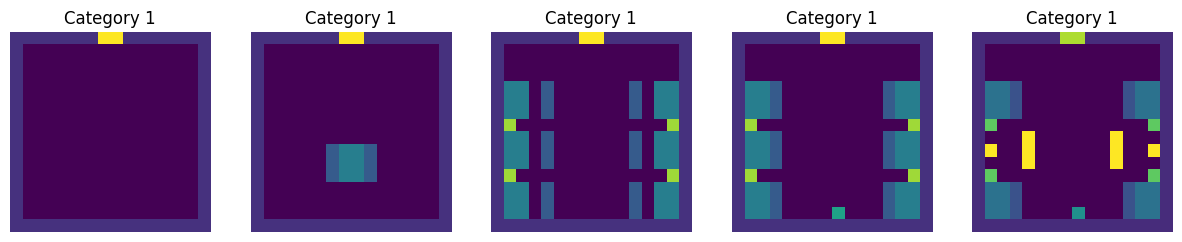

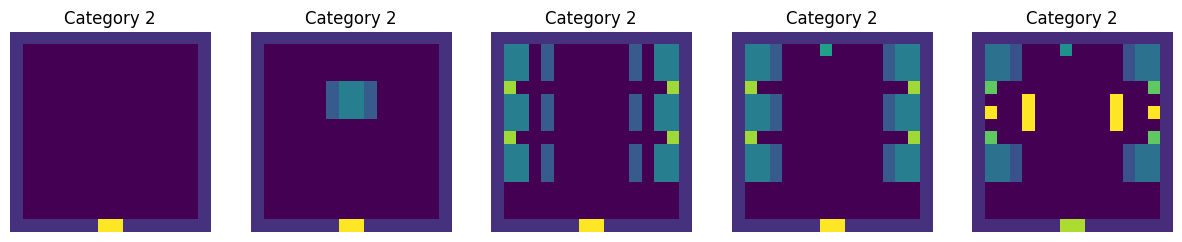

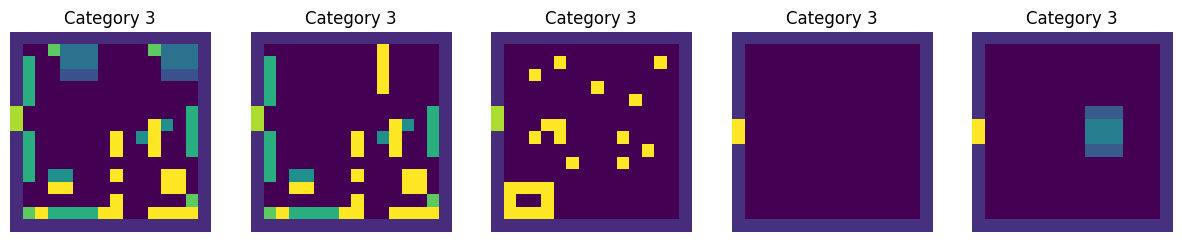

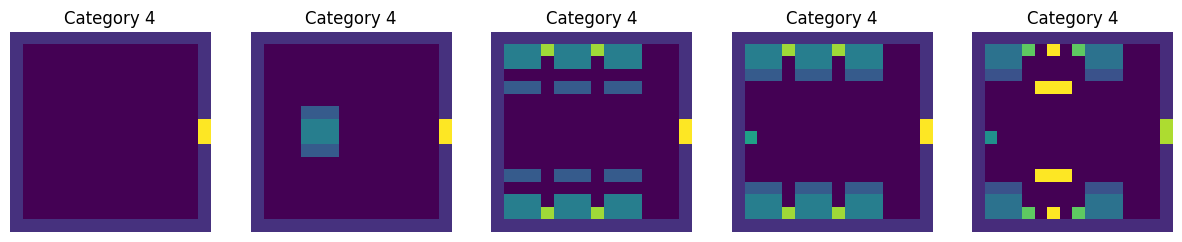

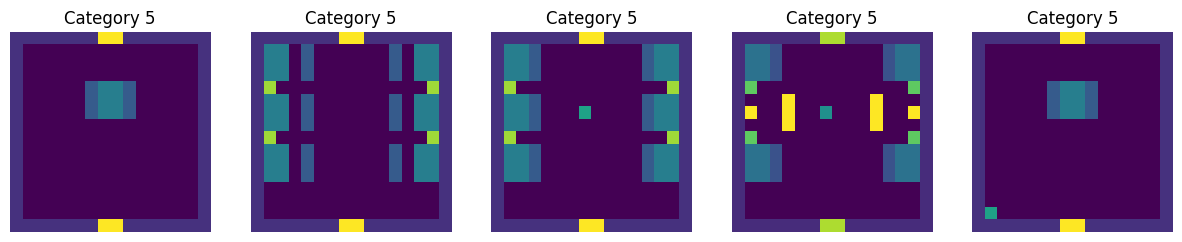

No images found for category 6


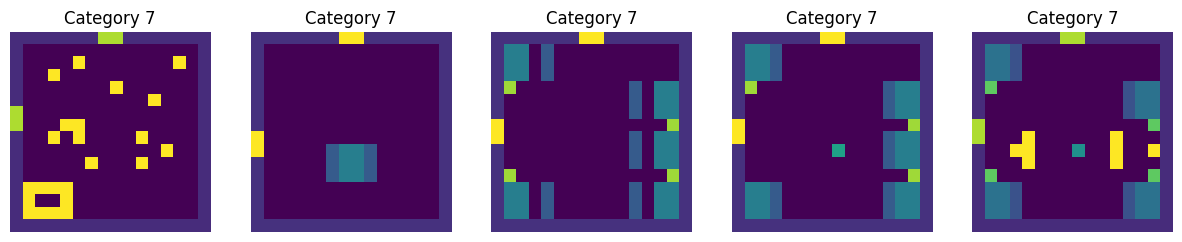

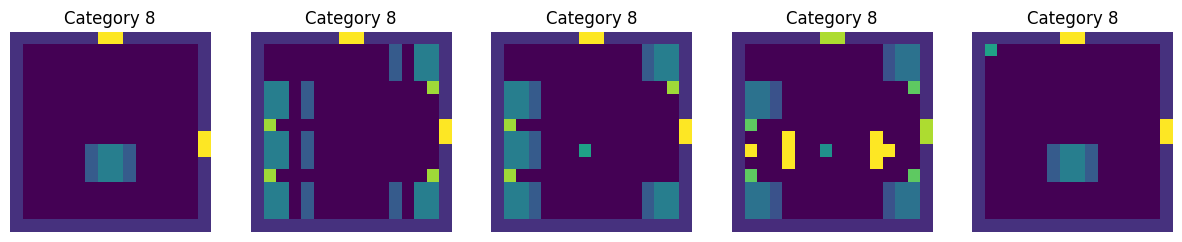

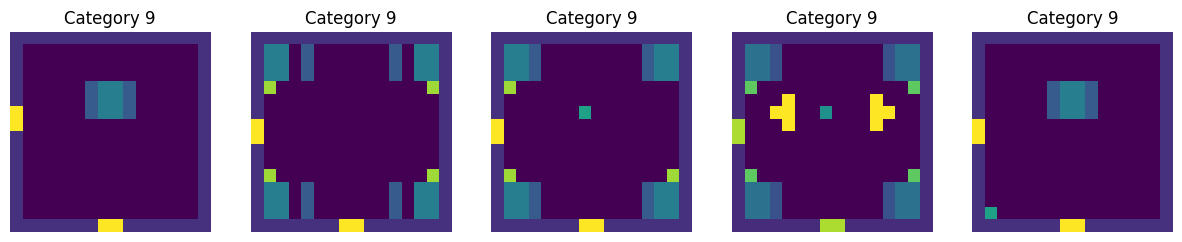

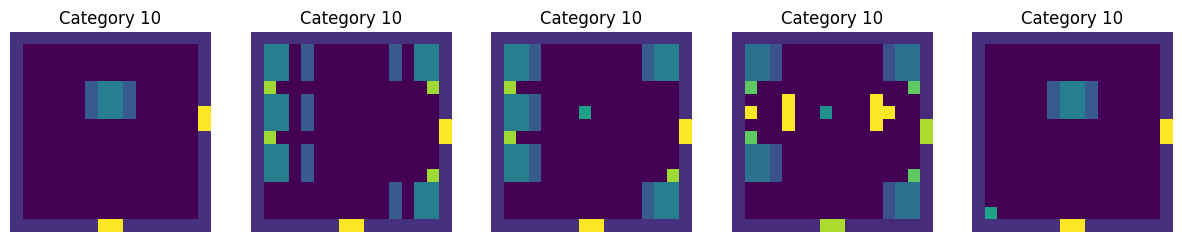

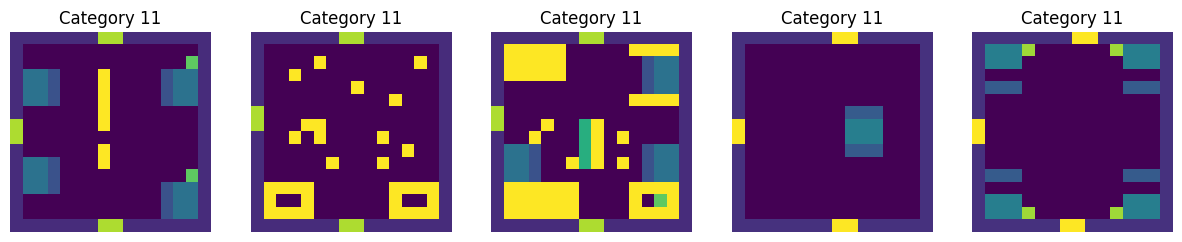

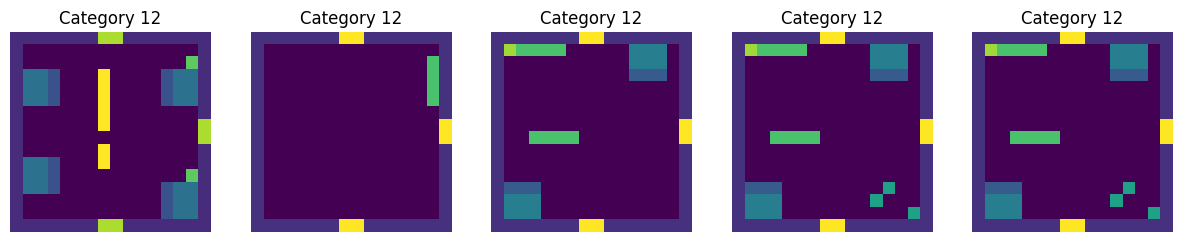

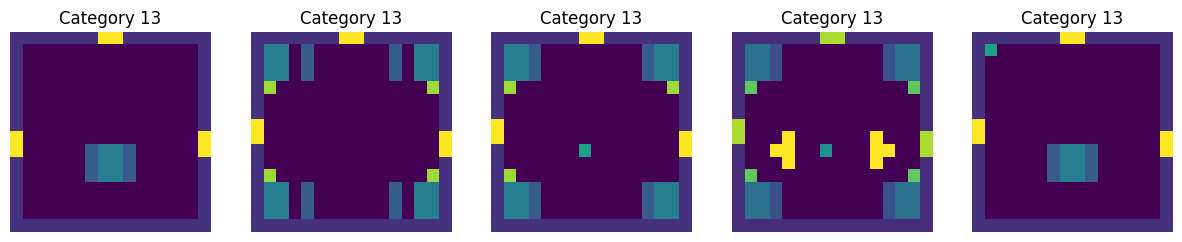

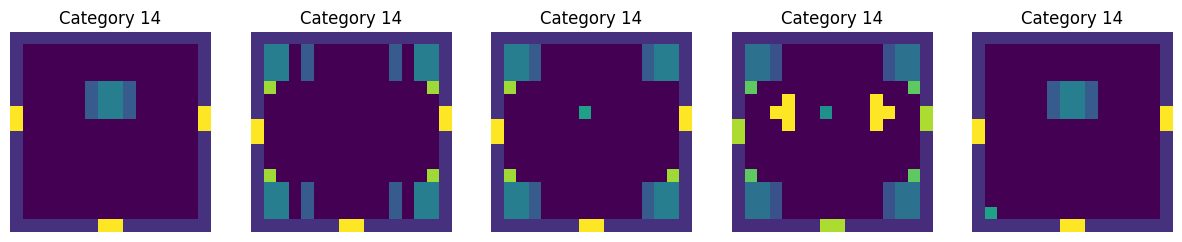

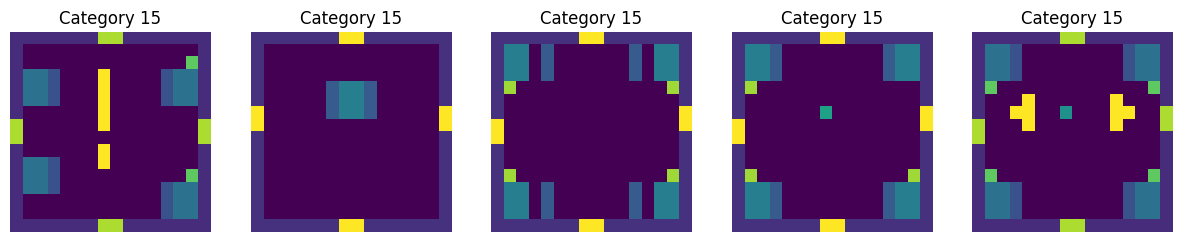

In [192]:
# Dictionary to store room images for each category (0 to 15)
category_images = {i: [] for i in range(16)}

# Assuming 'Room_Type' contains categories ranging from 0 to 15 and Updatedroomdecor contains the images
for i, category in enumerate(Room_Type):
    category_images[category].append(Updatedroomdecor[i])  # Store images in the corresponding category

# Function to plot a specified number of images for a given category
def plot_category_images(category, images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))  # Create subplots
    for i in range(num_images):
        axes[i].imshow(images[i])  # Display image
        axes[i].set_title(f"Category {category}")  # Set title for the subplot
        axes[i].axis('off')  # Turn off axis
    plt.show()  # Show the plot

# Plot images for each category
for category, images in category_images.items():
    if images:
        plot_category_images(category, images)  # Plot if there are images in the category
    else:
        print(f"No images found for category {category}")  # Print if no images are found


In [142]:
# Count the occurrences of each category
category_counts = Counter(Room_Type)

# Print the categories and the number of rooms in each category
for category, count in category_counts.items():
    print(f"Category {category}: {count} rooms")


Category 2: 196 rooms
Category 5: 200 rooms
Category 7: 201 rooms
Category 10: 200 rooms
Category 9: 200 rooms
Category 14: 150 rooms
Category 15: 198 rooms
Category 3: 199 rooms
Category 12: 156 rooms
Category 11: 153 rooms
Category 1: 196 rooms
Category 4: 196 rooms
Category 8: 200 rooms
Category 13: 150 rooms


##CGAN

###Split Dataset


In [143]:
# Classify each room layout
Room_Type = [classify_room(room) for room in Updatedroomdecor]

# Convert the list of room layouts to a 3D NumPy array
room_layouts_array = np.array(Updatedroomdecor)

# Flatten each room layout into a 1D array
room_layouts_flattened = [layout.ravel() for layout in room_layouts_array]

# Create a DataFrame with 'X' and 'Y'
data = {'X': room_layouts_flattened, 'Y': Room_Type}
df = pd.DataFrame(data)

# Print the first few rows of the DataFrame
print(df.head())
print(df.shape)
print(df.dtypes)

                                                   X  Y
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  2
(2595, 2)
X    object
Y     int64
dtype: object


In [144]:


# Prepare the data
data = np.array(Updatedroomdecor)
labels = np.array(Room_Type)

# Normalize the data
data = data / 9.0  # assuming the maximum value in the data is 9

# Expand dimensions to match the input shape for CNN
data = np.expand_dims(data, axis=-1)

# One-hot encode the labels
labels = to_categorical(labels, num_classes=16)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Print the shapes of the splits
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((2076, 16, 16, 1), (519, 16, 16, 1), (2076, 16), (519, 16))

###Build Generator, Discriminator

In [193]:

# Define the Generator model
def build_generator(noise_dim, num_classes, room_shape):
    noise = Input(shape=(noise_dim,))  # Input for the noise vector
    label = Input(shape=(num_classes,))  # Input for the label (one-hot encoded)

    # Concatenate noise and label inputs
    model_input = concatenate([noise, label])

    x = Dense(128)(model_input)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)
    x = Dense(256)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation("relu")(x)
    x = Dense(np.prod(room_shape), activation='tanh')(x)
    x = Reshape(room_shape)(x)  # Reshape the output to the desired room shape

    return Model([noise, label], x)  # Create and return the model


In [151]:
from keras.layers import Input, concatenate, Dense, Flatten, LeakyReLU
from keras.models import Model

# Define the Discriminator model
def build_discriminator(room_shape, num_classes):
    room = Input(shape=room_shape)  # Input for the room image
    label = Input(shape=(num_classes,))  # Input for the label (one-hot encoded)

    # Concatenate flattened room input and label input
    model_input = concatenate([Flatten()(room), label])

    x = Dense(512)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation

    return Model([room, label], x)  # Create and return the model


In [152]:
from keras.layers import Input
from keras.models import Model

# Combine Generator and Discriminator into a CGAN
def build_cgan(generator, discriminator):
    # Extract noise dimension and number of classes from the generator's input shapes
    noise_dim = generator.input_shape[0][1]
    num_classes = generator.input_shape[1][1]

    noise = Input(shape=(noise_dim,))  # Input for the noise vector
    label = Input(shape=(num_classes,))  # Input for the label (one-hot encoded)

    generated_room = generator([noise, label])  # Generate room image using the generator

    discriminator.trainable = False  # Freeze the discriminator during CGAN training
    validity = discriminator([generated_room, label])  # Get validity of the generated room from the discriminator

    return Model([noise, label], validity)  # Create and return the CGAN model


In [153]:
from keras.optimizers import Adam

# Parameters
noise_dim = 100  # Dimension of the noise vector
num_classes = 16  # Number of classes (for one-hot encoding)
room_shape = (16, 16, 1)  # Shape of the room image

# Build and compile the models
generator = build_generator(noise_dim, num_classes, room_shape)  # Build the generator model
discriminator = build_discriminator(room_shape, num_classes)  # Build the discriminator model
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])  # Compile the discriminator model
cgan = build_cgan(generator, discriminator)  # Build the CGAN model
cgan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))  # Compile the CGAN model

# Print summaries of the models
generator.summary()  # Print generator model summary
discriminator.summary()  # Print discriminator model summary
cgan.summary()  # Print CGAN model summary


Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_125 (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 input_126 (InputLayer)      [(None, 16)]                 0         []                            
                                                                                                  
 concatenate_30 (Concatenat  (None, 116)                  0         ['input_125[0][0]',           
 e)                                                                  'input_126[0][0]']           
                                                                                                  
 dense_108 (Dense)           (None, 128)                  14976     ['concatenate_30[0][0]'

###Train 1

In [154]:
from keras.utils import to_categorical

# Define the training function for the CGAN
def train(generator, discriminator, cgan, epochs, batch_size, X_train, y_train, noise_dim=100):
    real = np.ones((batch_size, 1))  # Real labels (for real images)
    fake = np.zeros((batch_size, 1))  # Fake labels (for generated images)

    for epoch in range(epochs):
        # Select a random batch of real images and labels
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_rooms = X_train[idx]
        real_labels = y_train[idx]

        # Generate noise and corresponding labels for fake images
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_labels_one_hot = to_categorical(gen_labels, num_classes=num_classes)

        # Generate fake images using the generator
        generated_rooms = generator.predict([noise, gen_labels_one_hot])

        # Train the discriminator (real images and fake images)
        d_loss_real = discriminator.train_on_batch([real_rooms, real_labels], real)
        d_loss_fake = discriminator.train_on_batch([generated_rooms, gen_labels_one_hot], fake)

        # Calculate the total discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generate noise and labels for training the generator via CGAN
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_labels_one_hot = to_categorical(gen_labels, num_classes=num_classes)

        # Train the generator (via the CGAN model)
        g_loss = cgan.train_on_batch([noise, gen_labels_one_hot], real)

        # Print the progress every 100 epochs
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

# Normalize the data
X_train = np.array(Updatedroomdecor)
X_train = X_train / 9.0  # Normalize the data to the range [0, 1]
X_train = np.expand_dims(X_train, axis=-1)  # Expand dimensions to match the input shape for CNN
y_train = to_categorical(Room_Type, num_classes=16)  # One-hot encode the labels

# Train the CGAN
train(generator, discriminator, cgan, epochs=1000, batch_size=16, X_train=X_train, y_train=y_train)


1/1 [==============================] - 0s 158ms/step
0 [D loss: 0.7391368448734283 | D accuracy: 43.75] [G loss: 0.6331807374954224]
1/1 [==============================] - 0s 25ms/step
100 [D loss: 0.5093543529510498 | D accuracy: 78.125] [G loss: 2.0434632301330566]
1/1 [==============================] - 0s 25ms/step
200 [D loss: 0.32203516364097595 | D accuracy: 87.5] [G loss: 2.727289915084839]
1/1 [==============================] - 0s 41ms/step
300 [D loss: 0.1304747685790062 | D accuracy: 100.0] [G loss: 3.3702876567840576]
1/1 [==============================] - 0s 37ms/step
400 [D loss: 0.051382776349782944 | D accuracy: 100.0] [G loss: 3.0538783073425293]
1/1 [==============================] - 0s 23ms/step
500 [D loss: 0.05500256177037954 | D accuracy: 100.0] [G loss: 3.945800542831421]
1/1 [==============================] - 0s 30ms/step
600 [D loss: 0.09042399376630783 | D accuracy: 96.875] [G loss: 4.934937477111816]
1/1 [==============================] - 0s 24ms/step
700 [D l

1/1 [==============================] - 0s 33ms/step
0 [D loss: 0.15786727890372276 | D accuracy: 96.875] [G loss: 4.6245574951171875]
1/1 [==============================] - 0s 32ms/step


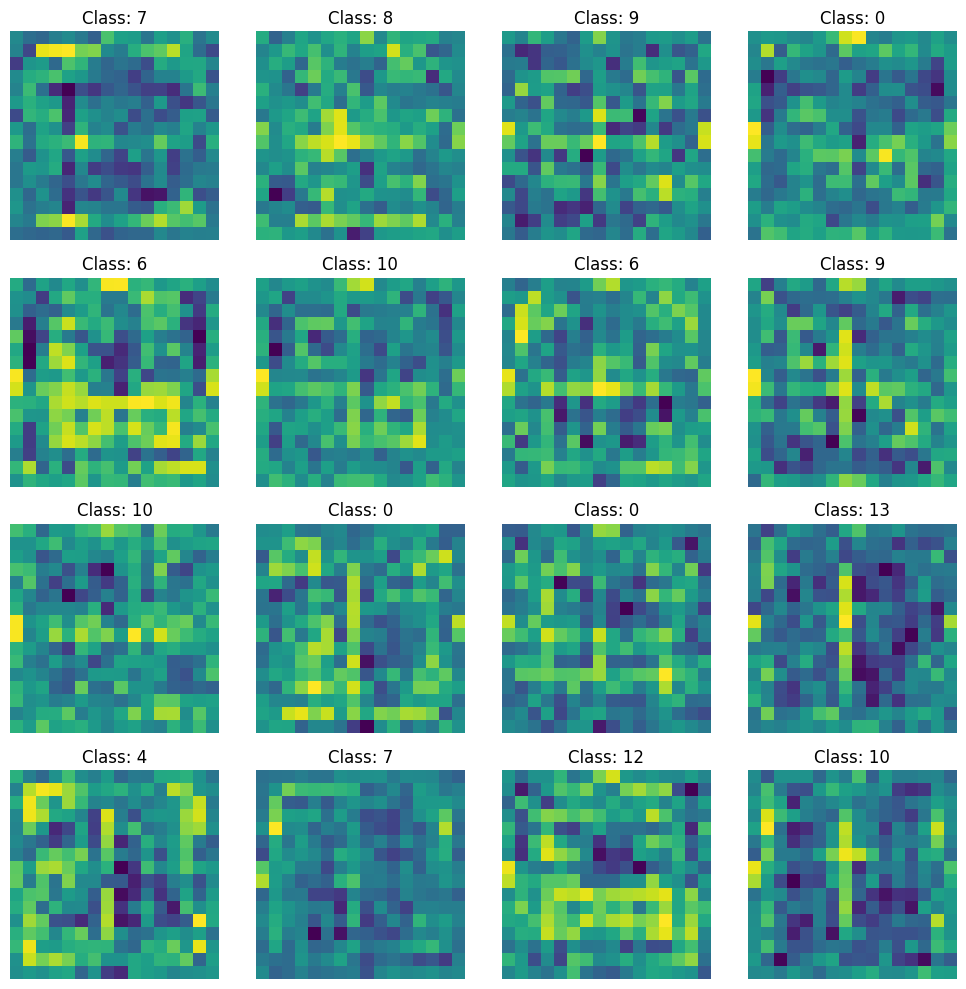

1/1 [==============================] - 0s 55ms/step
100 [D loss: 0.2427704632282257 | D accuracy: 87.5] [G loss: 5.270140171051025]
1/1 [==============================] - 0s 37ms/step


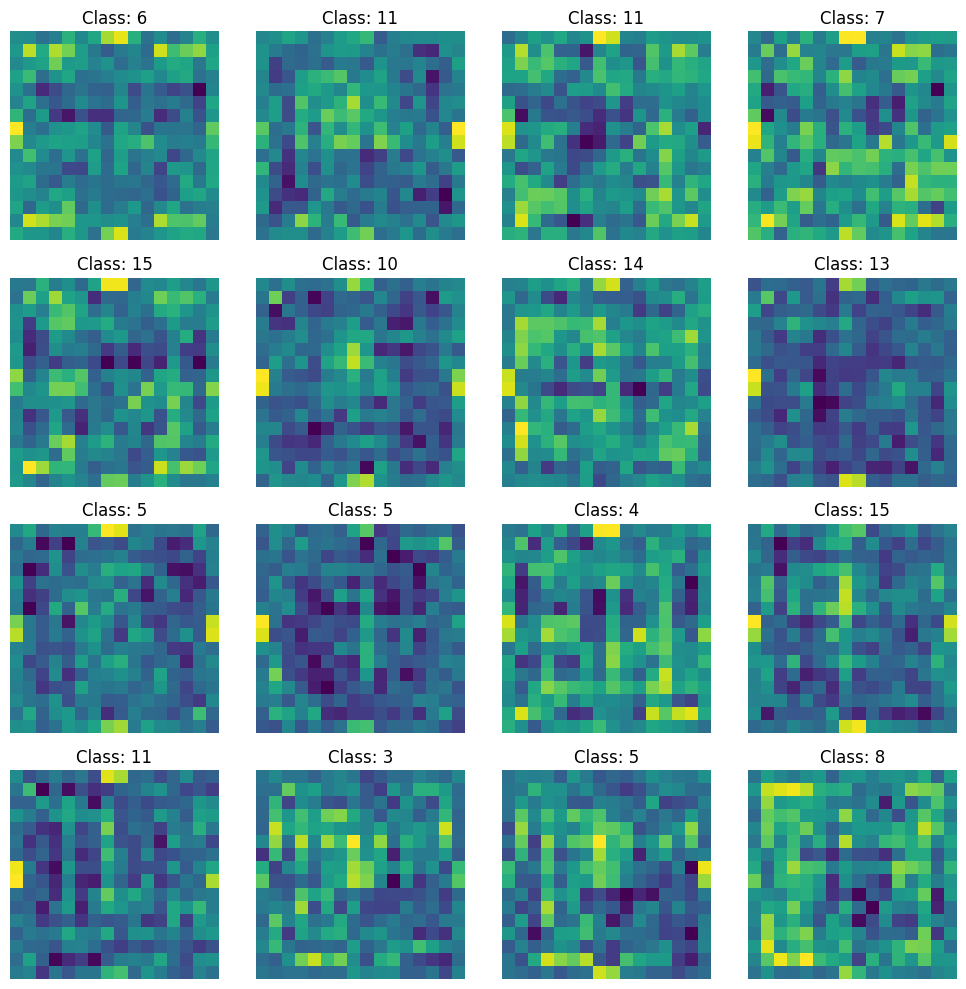

1/1 [==============================] - 0s 27ms/step
200 [D loss: 0.3465120494365692 | D accuracy: 90.625] [G loss: 4.642645835876465]
1/1 [==============================] - 0s 27ms/step


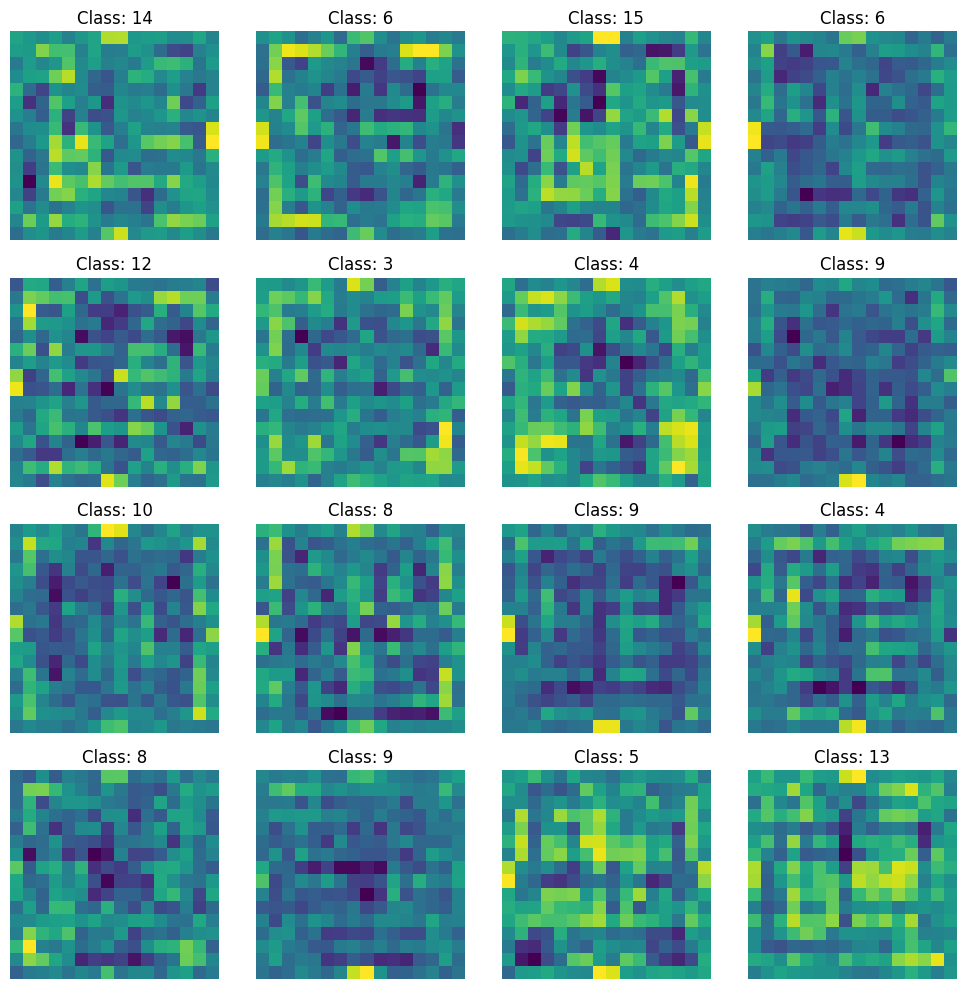

1/1 [==============================] - 0s 26ms/step
300 [D loss: 0.10116104781627655 | D accuracy: 96.875] [G loss: 2.852735996246338]
1/1 [==============================] - 0s 24ms/step


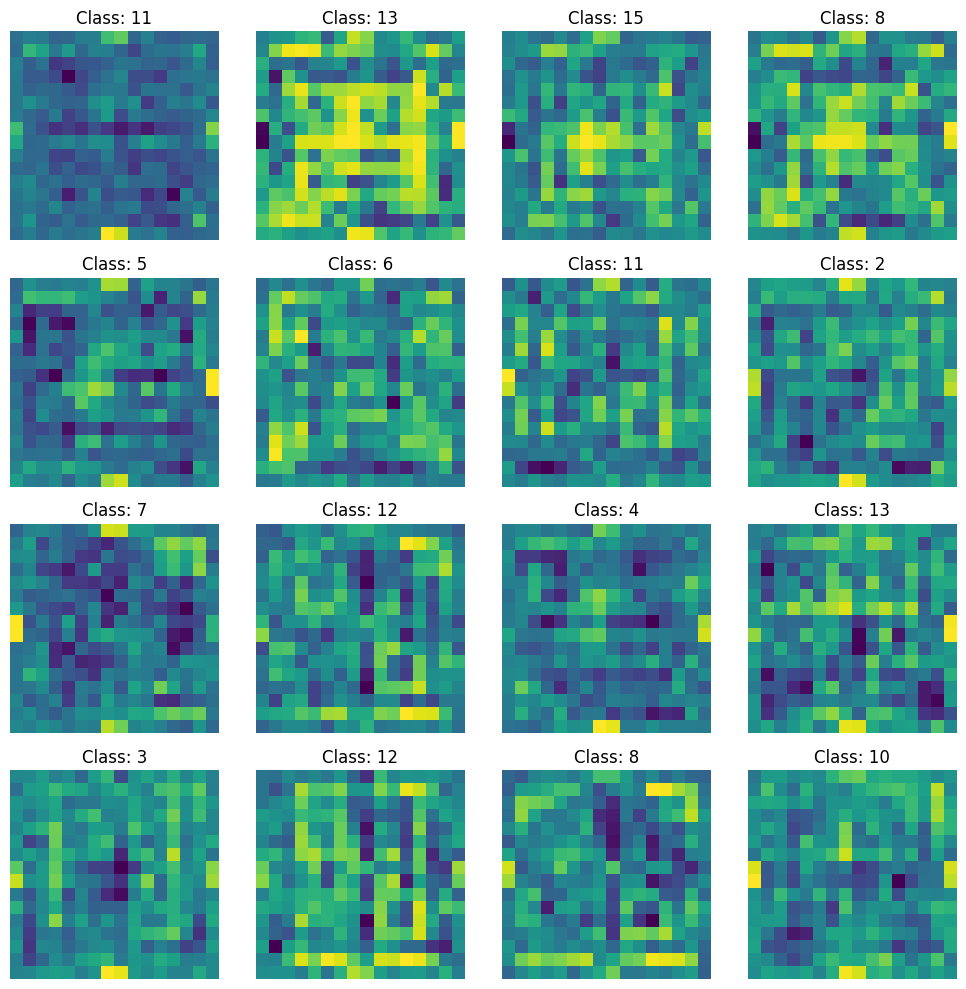

1/1 [==============================] - 0s 56ms/step
400 [D loss: 0.07083258405327797 | D accuracy: 100.0] [G loss: 5.416481971740723]
1/1 [==============================] - 0s 35ms/step


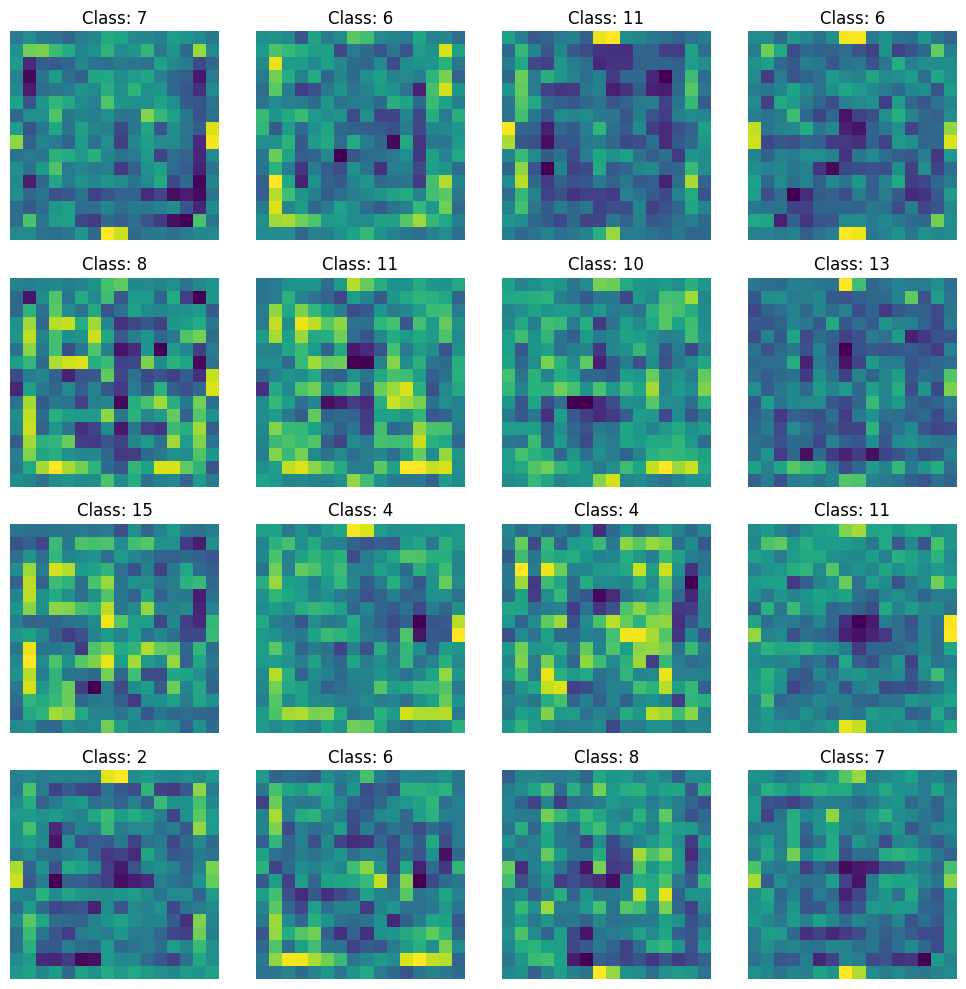

1/1 [==============================] - 0s 25ms/step
500 [D loss: 0.1467190682888031 | D accuracy: 96.875] [G loss: 4.131753921508789]
1/1 [==============================] - 0s 26ms/step


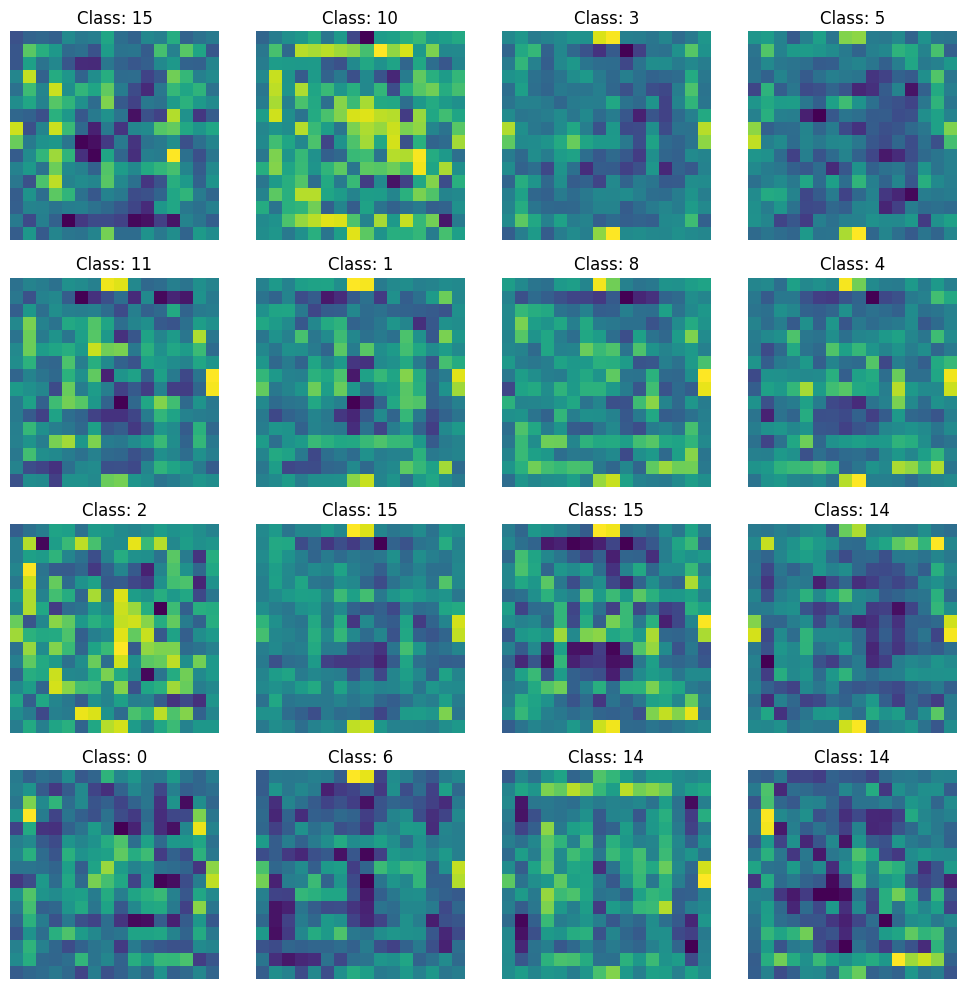

1/1 [==============================] - 0s 34ms/step
600 [D loss: 0.17455437779426575 | D accuracy: 93.75] [G loss: 3.6328318119049072]
1/1 [==============================] - 0s 26ms/step


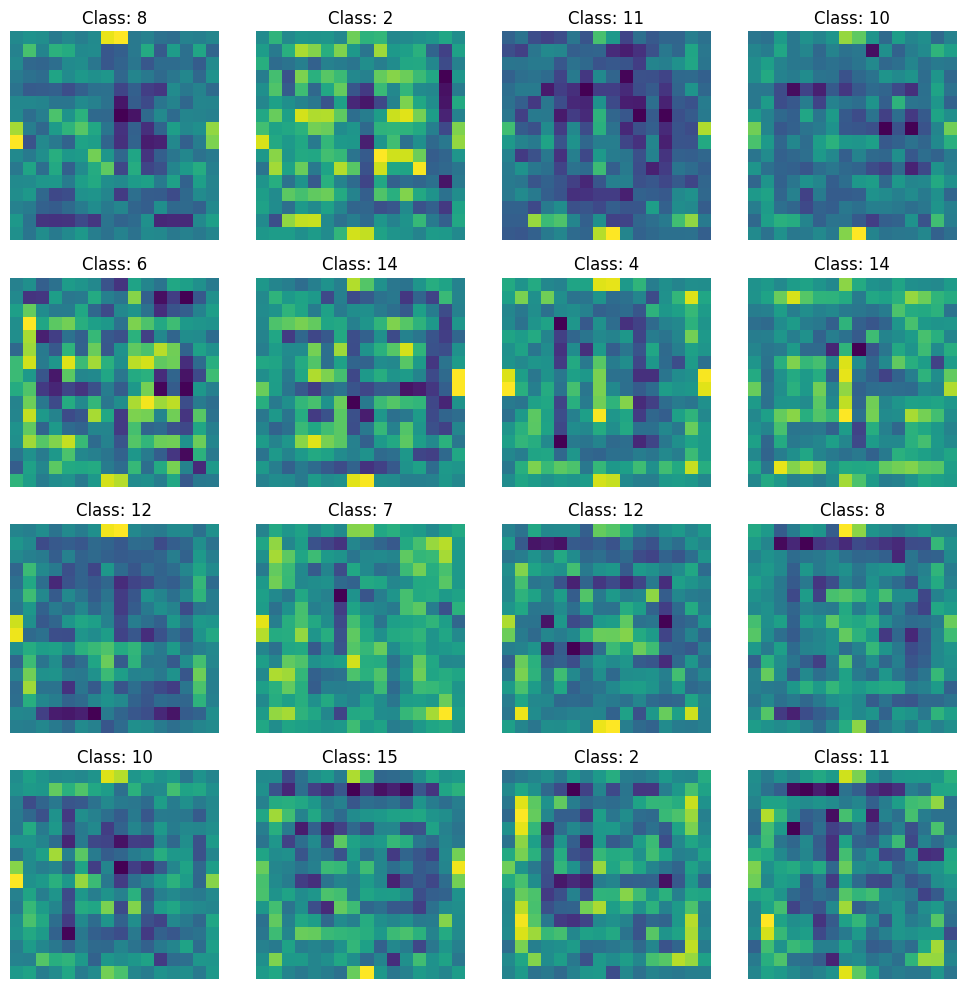

1/1 [==============================] - 0s 61ms/step
700 [D loss: 0.14401070773601532 | D accuracy: 93.75] [G loss: 4.5572614669799805]
1/1 [==============================] - 0s 37ms/step


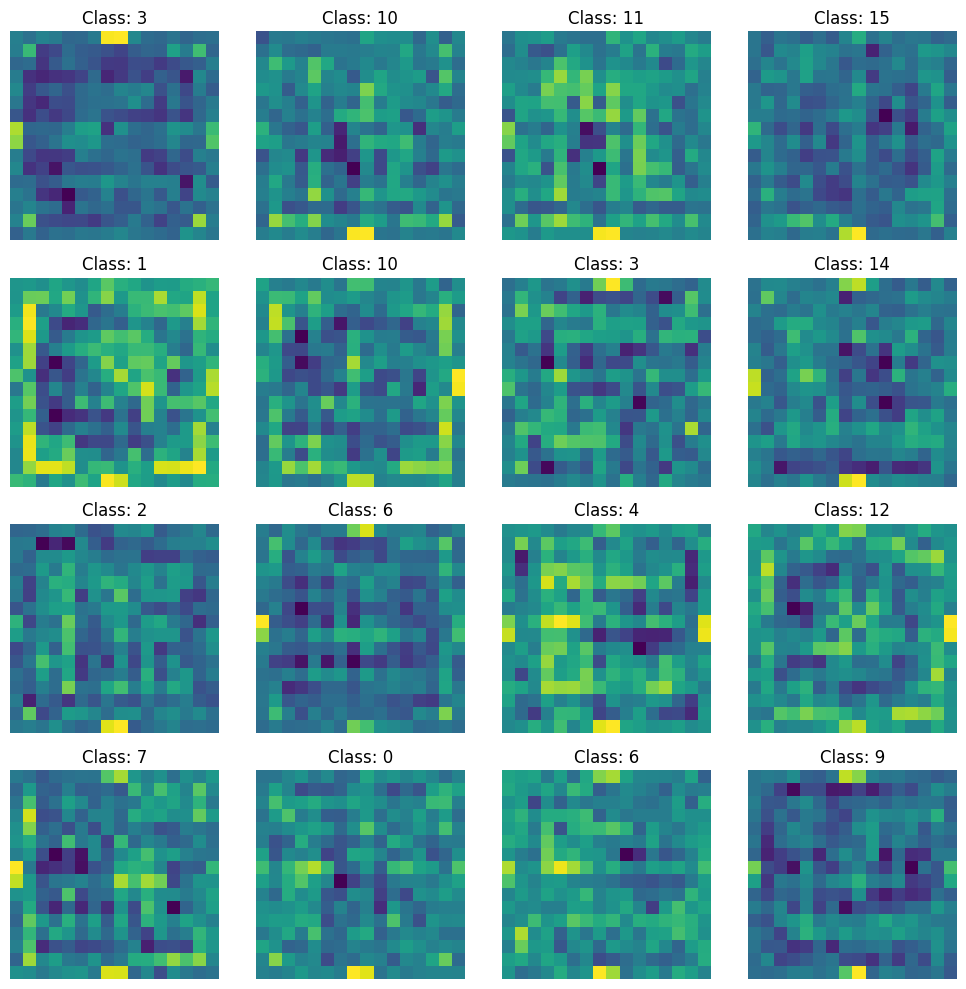

1/1 [==============================] - 0s 29ms/step
800 [D loss: 0.22496161609888077 | D accuracy: 87.5] [G loss: 5.118746757507324]
1/1 [==============================] - 0s 34ms/step


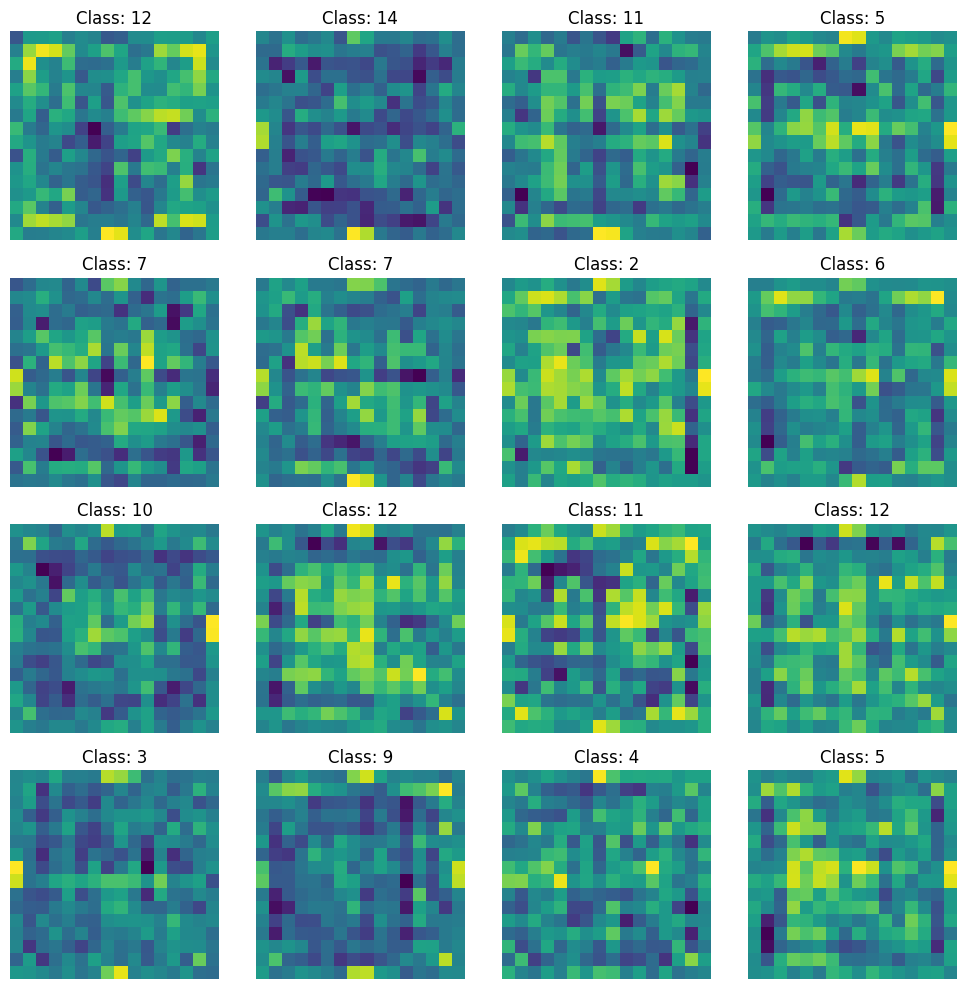

1/1 [==============================] - 0s 28ms/step
900 [D loss: 0.1157546192407608 | D accuracy: 96.875] [G loss: 7.735744953155518]
1/1 [==============================] - 0s 31ms/step


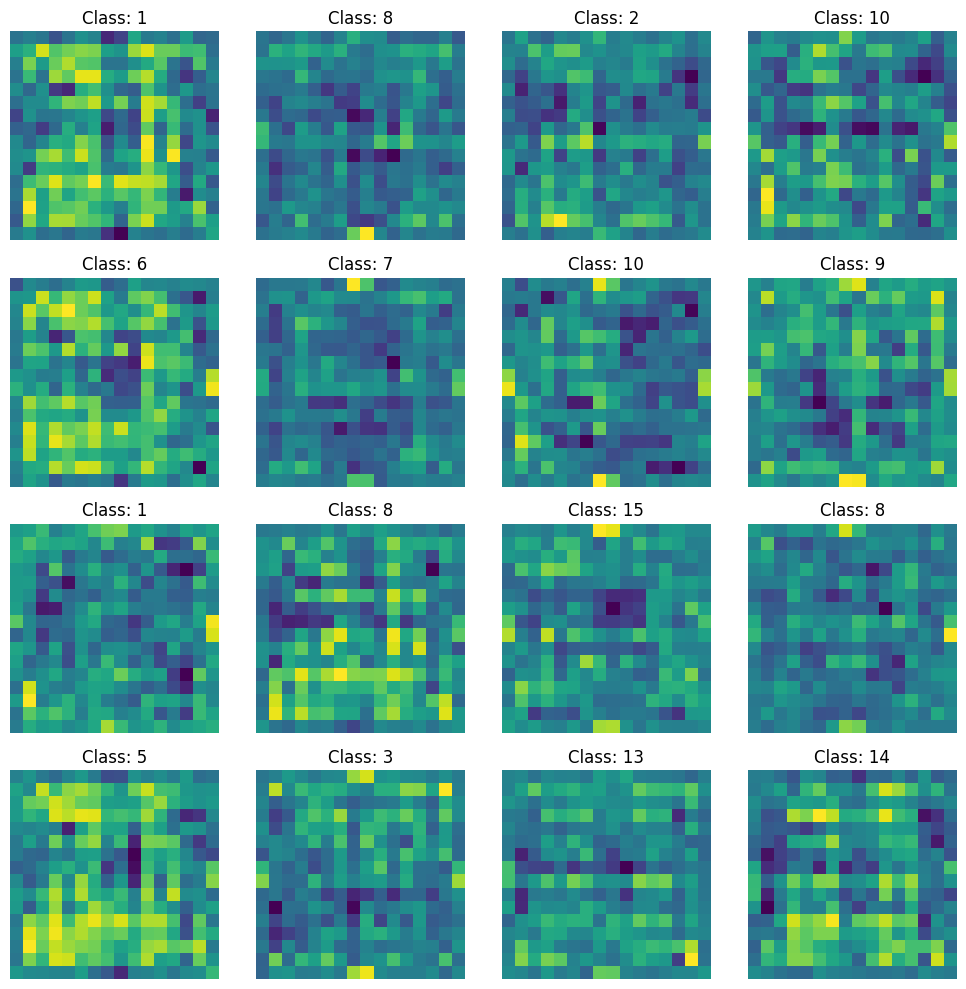

1/1 [==============================] - 0s 41ms/step
1000 [D loss: 0.16345218569040298 | D accuracy: 93.75] [G loss: 4.572120666503906]
1/1 [==============================] - 0s 38ms/step


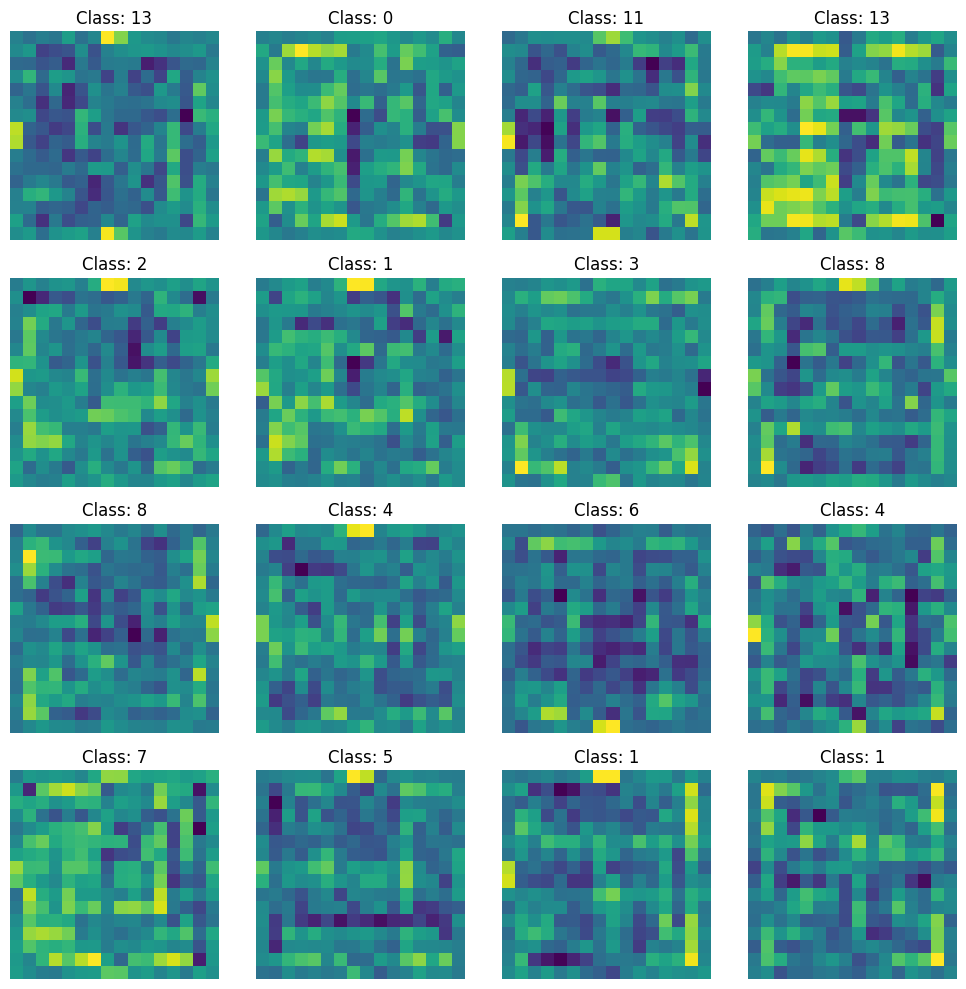

1/1 [==============================] - 0s 34ms/step
1100 [D loss: 0.25892890989780426 | D accuracy: 87.5] [G loss: 4.621218681335449]
1/1 [==============================] - 0s 31ms/step


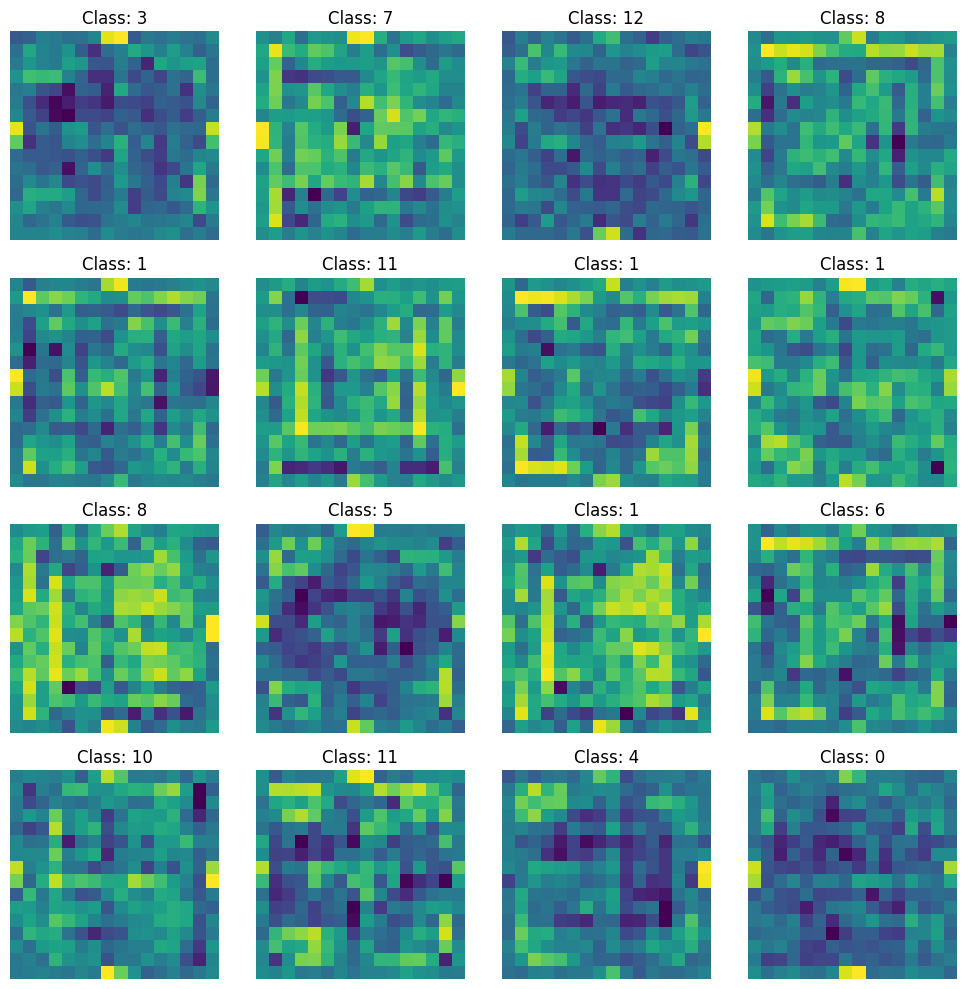

1/1 [==============================] - 0s 37ms/step
1200 [D loss: 0.20601800084114075 | D accuracy: 87.5] [G loss: 6.524024963378906]
1/1 [==============================] - 0s 43ms/step


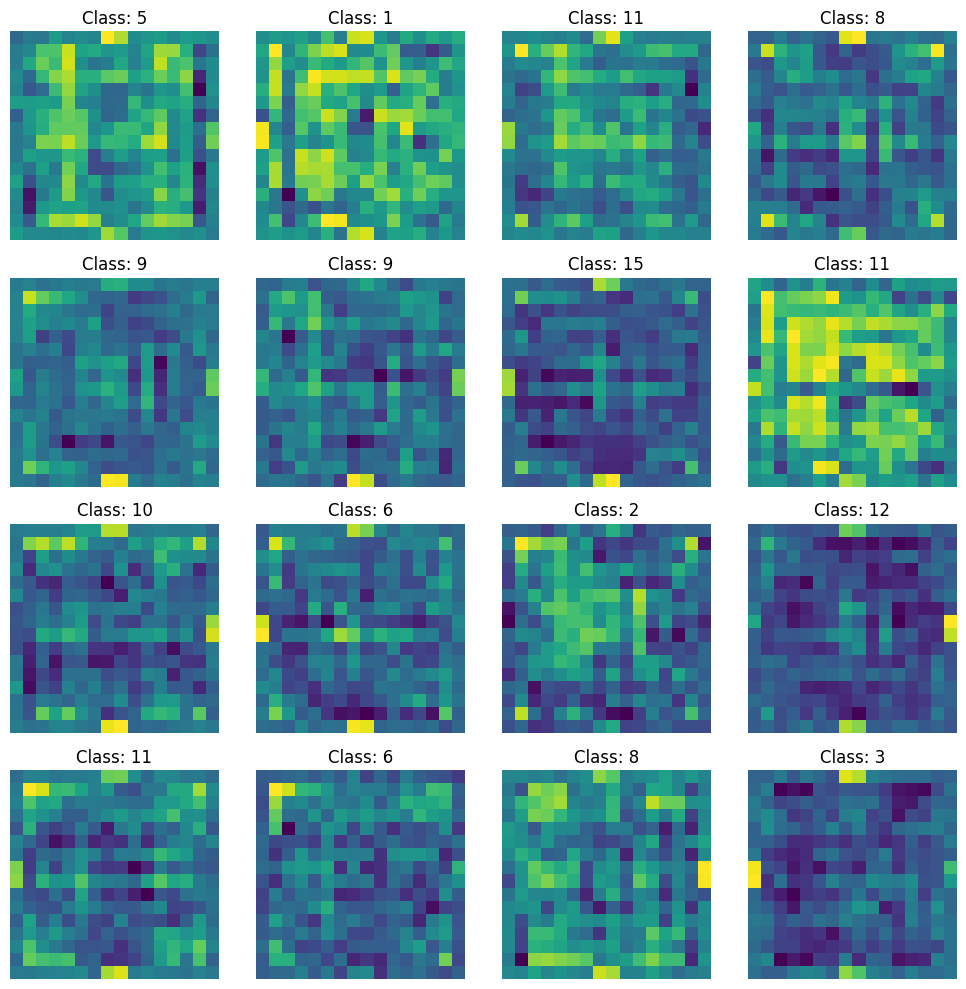

1/1 [==============================] - 0s 27ms/step
1300 [D loss: 0.16495153307914734 | D accuracy: 96.875] [G loss: 5.194074630737305]
1/1 [==============================] - 0s 25ms/step


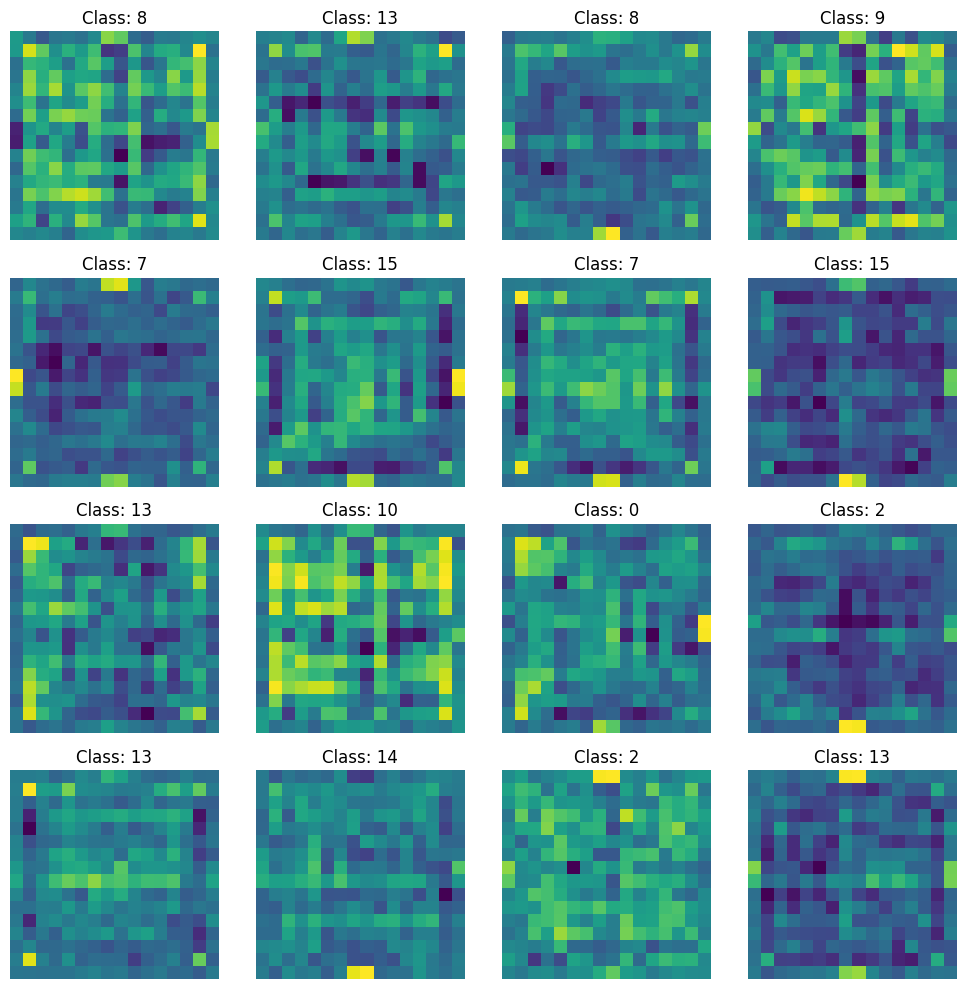

1/1 [==============================] - 0s 33ms/step
1400 [D loss: 0.11285454779863358 | D accuracy: 96.875] [G loss: 6.927393436431885]
1/1 [==============================] - 0s 34ms/step


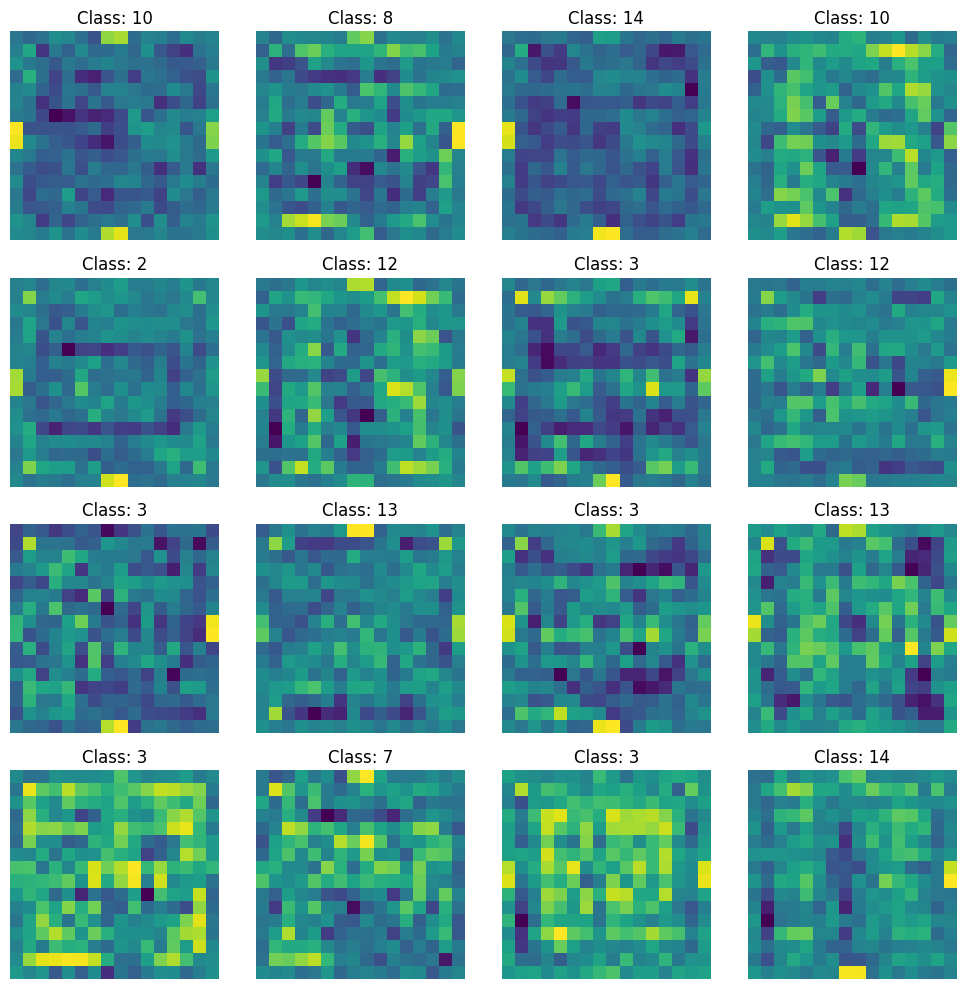

1/1 [==============================] - 0s 34ms/step
1500 [D loss: 0.13265013322234154 | D accuracy: 96.875] [G loss: 6.414621353149414]
1/1 [==============================] - 0s 32ms/step


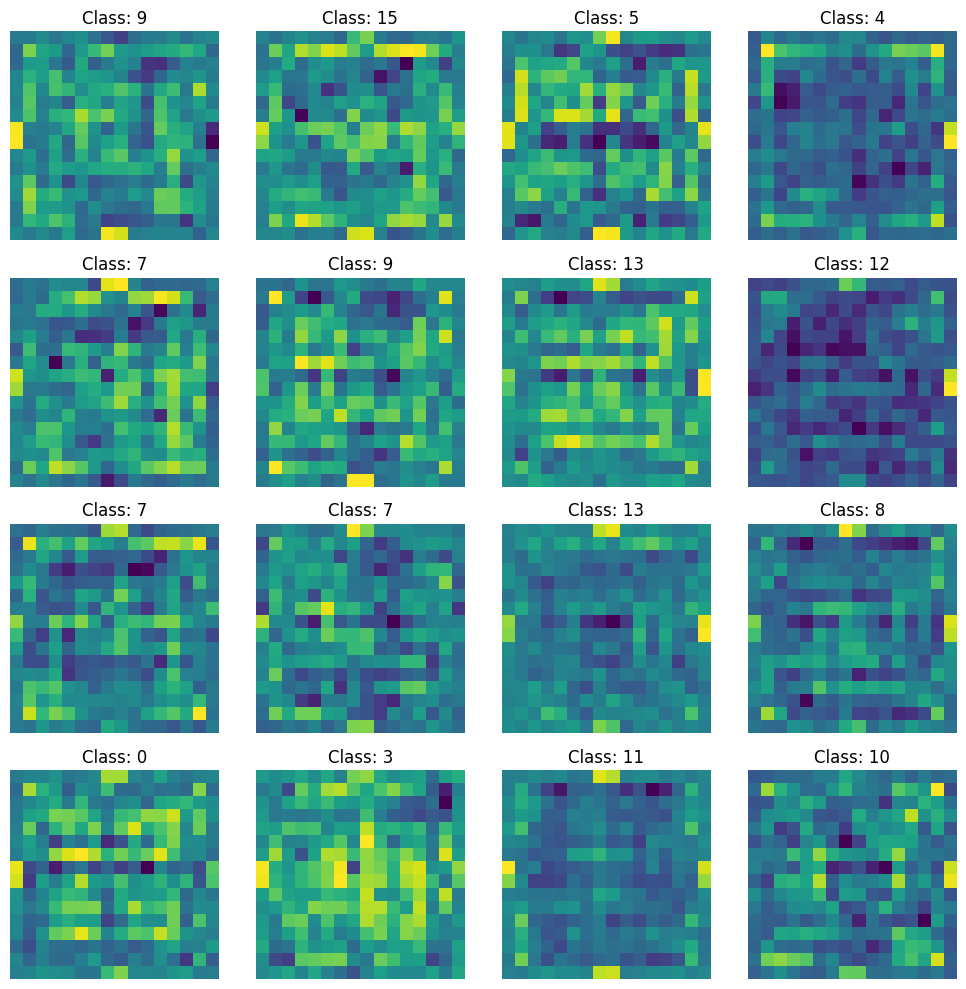

1/1 [==============================] - 0s 28ms/step
1600 [D loss: 0.16705304384231567 | D accuracy: 96.875] [G loss: 5.318552494049072]
1/1 [==============================] - 0s 39ms/step


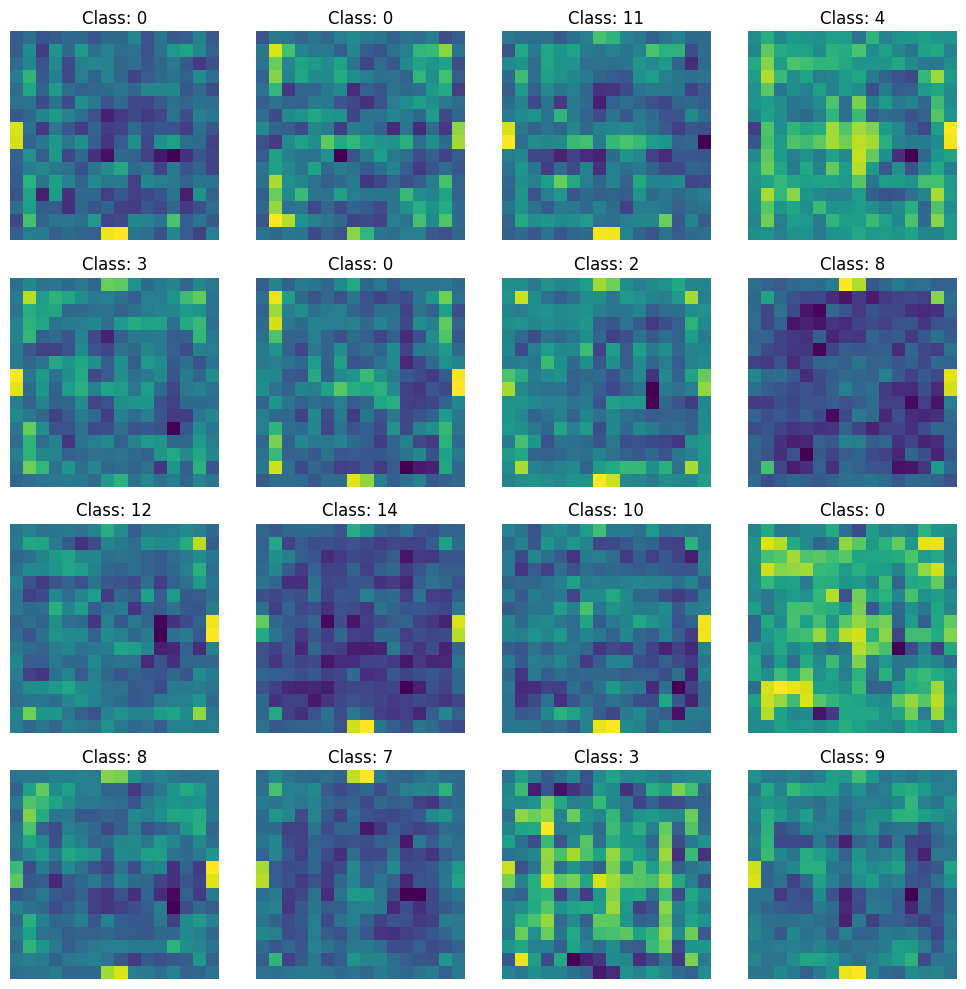

1/1 [==============================] - 0s 24ms/step
1700 [D loss: 0.12488728016614914 | D accuracy: 96.875] [G loss: 5.045160293579102]
1/1 [==============================] - 0s 24ms/step


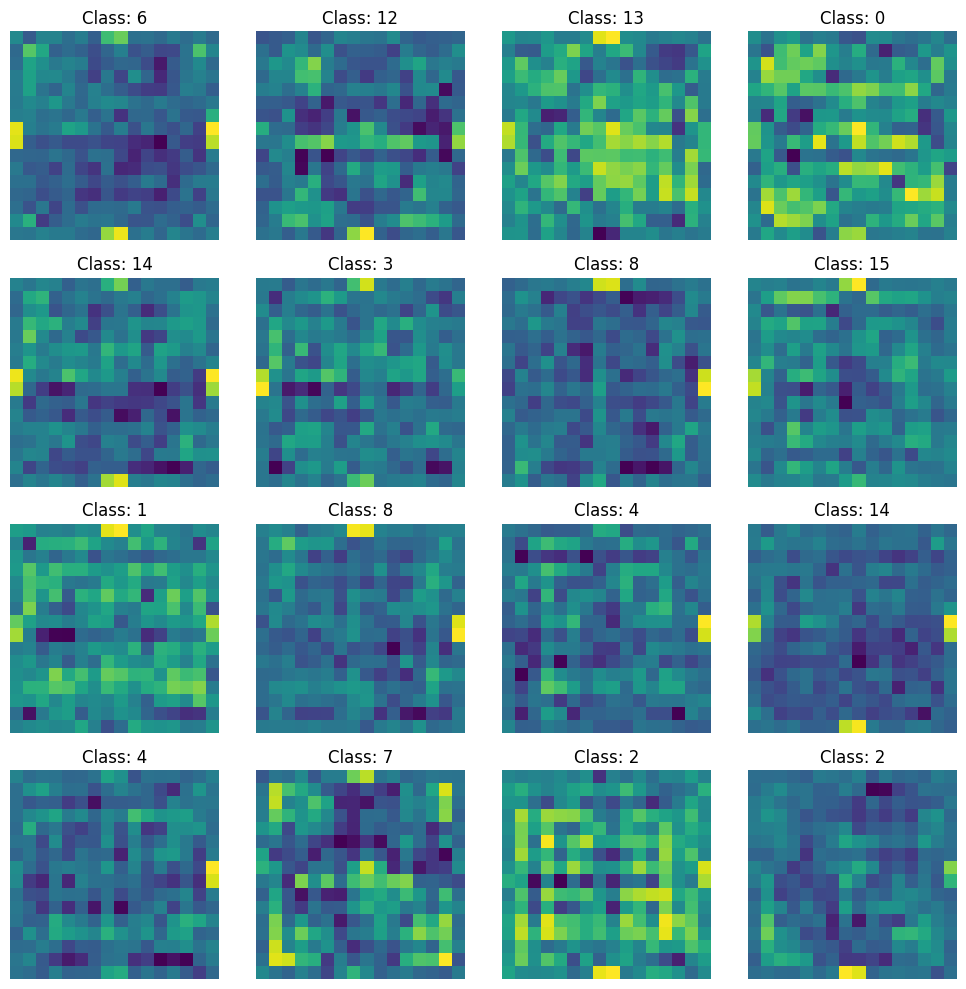

1/1 [==============================] - 0s 31ms/step
1800 [D loss: 0.14166030287742615 | D accuracy: 93.75] [G loss: 5.914224624633789]
1/1 [==============================] - 0s 34ms/step


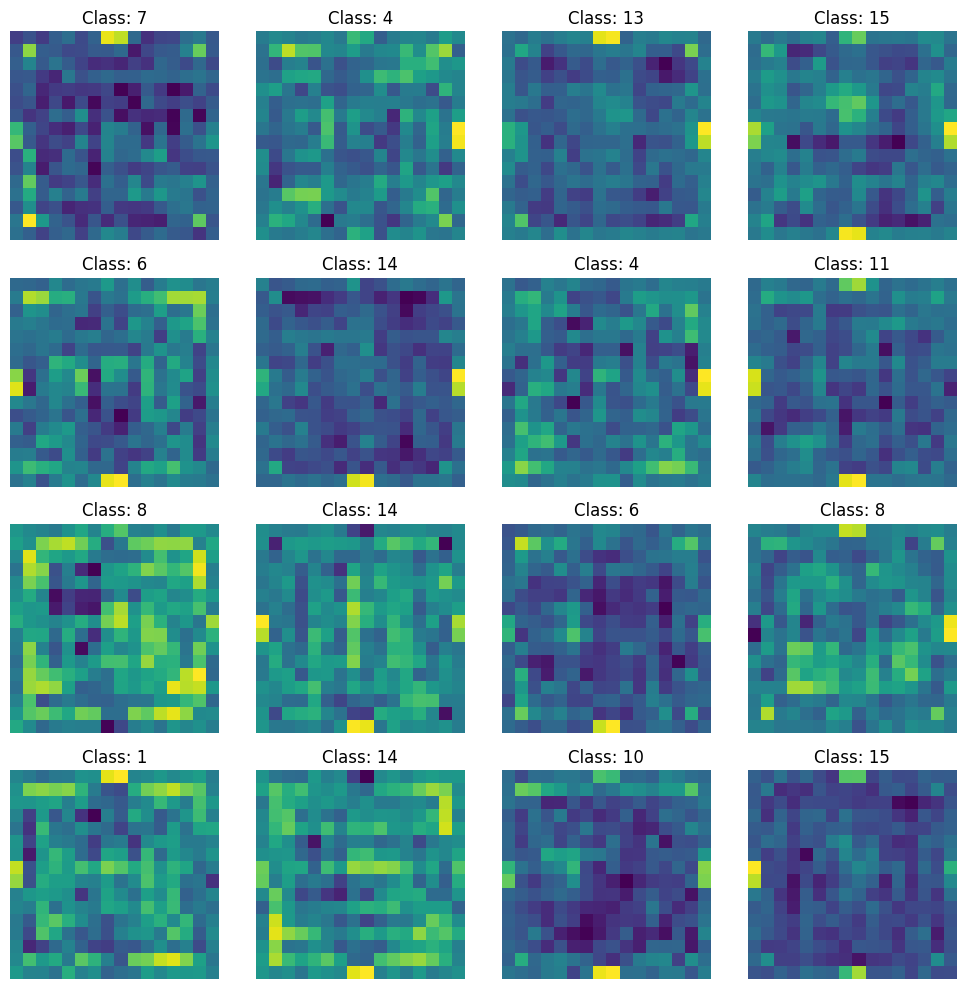

1/1 [==============================] - 0s 28ms/step
1900 [D loss: 0.4299614429473877 | D accuracy: 81.25] [G loss: 3.654153347015381]
1/1 [==============================] - 0s 26ms/step


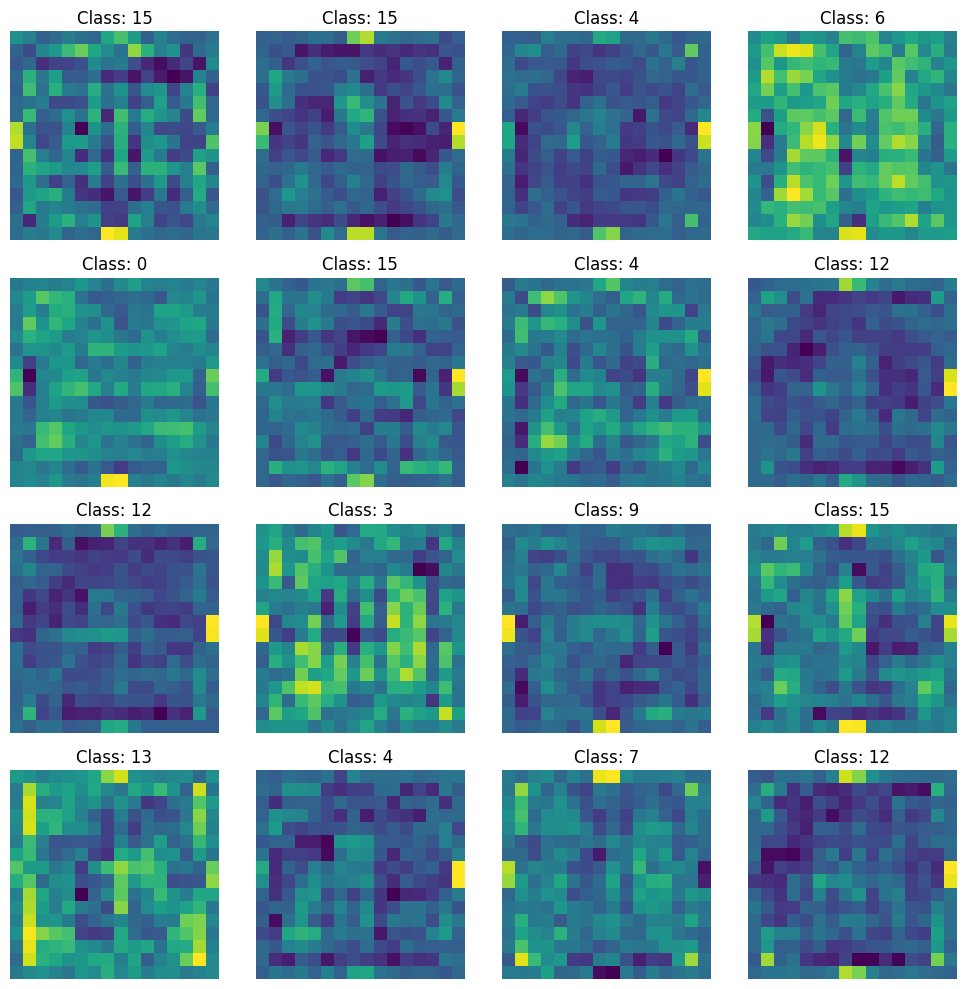

1/1 [==============================] - 0s 39ms/step
2000 [D loss: 0.19115718454122543 | D accuracy: 96.875] [G loss: 3.2573089599609375]
1/1 [==============================] - 0s 33ms/step


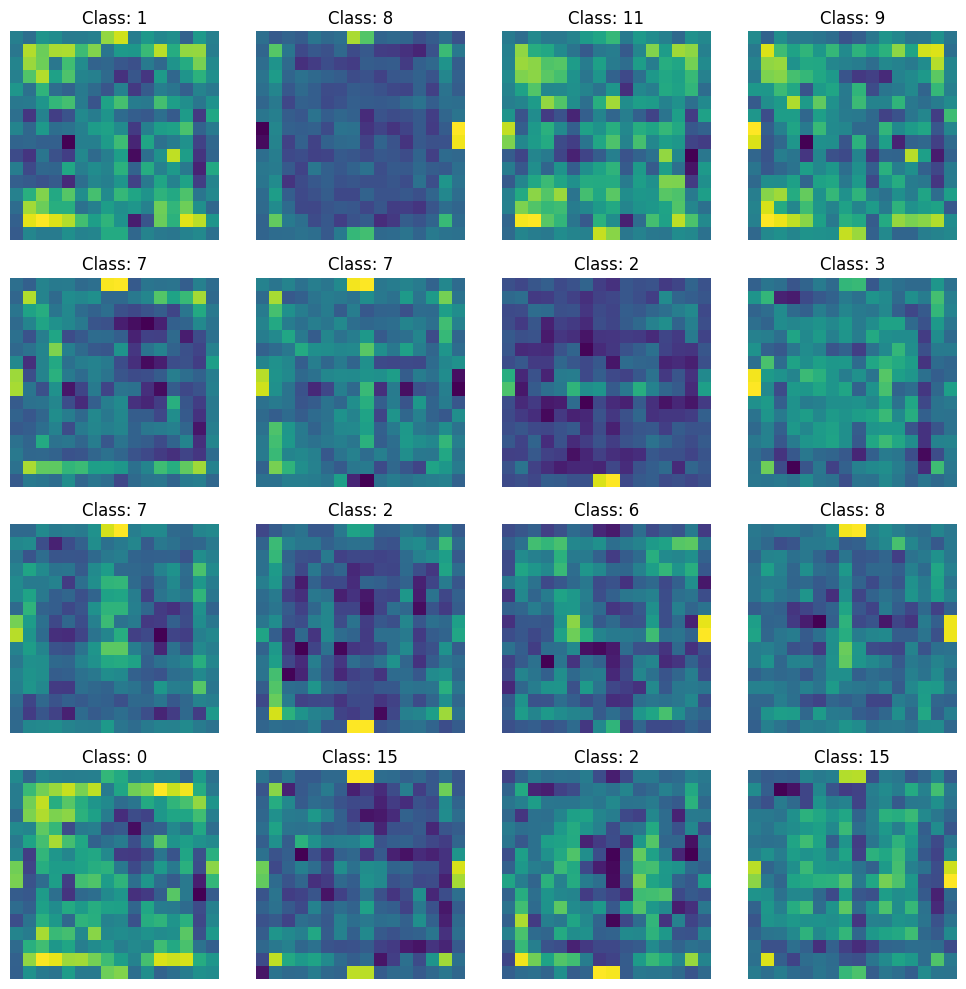

1/1 [==============================] - 0s 30ms/step
2100 [D loss: 0.25904523581266403 | D accuracy: 93.75] [G loss: 4.702883720397949]
1/1 [==============================] - 0s 33ms/step


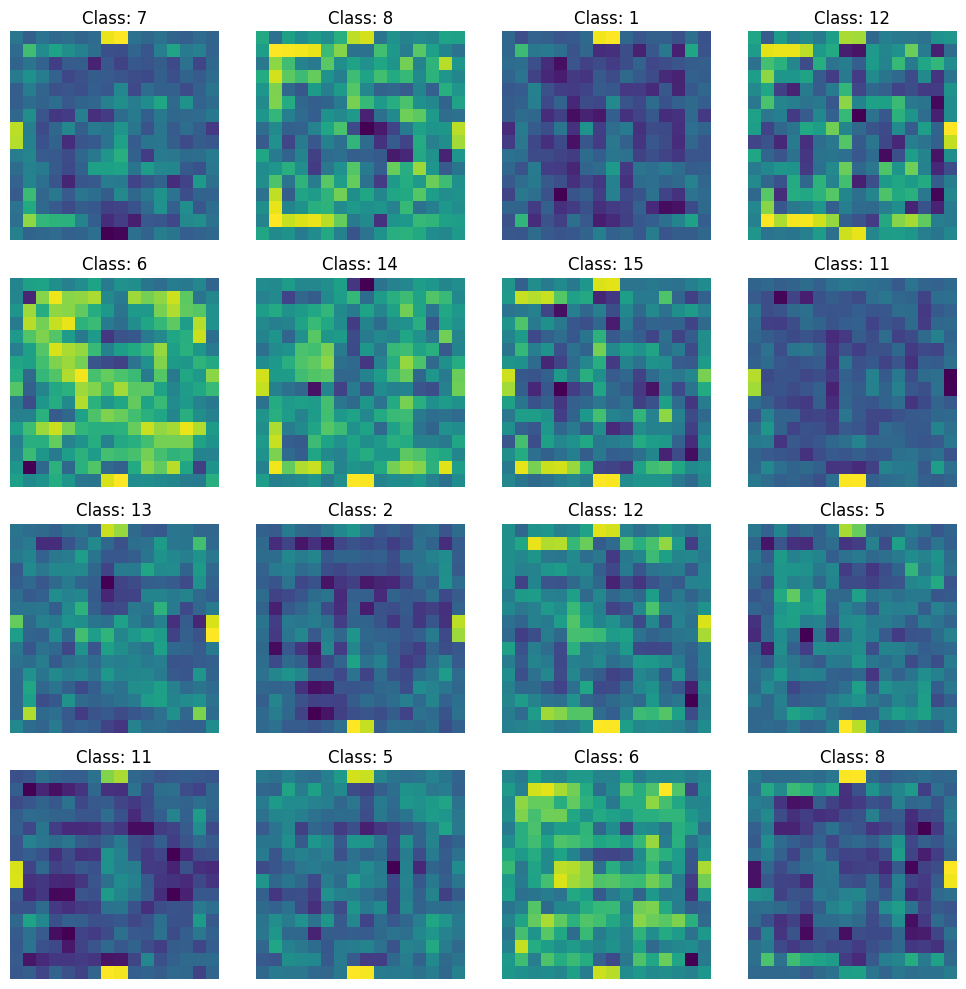

1/1 [==============================] - 0s 29ms/step
2200 [D loss: 0.2761445418000221 | D accuracy: 93.75] [G loss: 5.296868324279785]
1/1 [==============================] - 0s 30ms/step


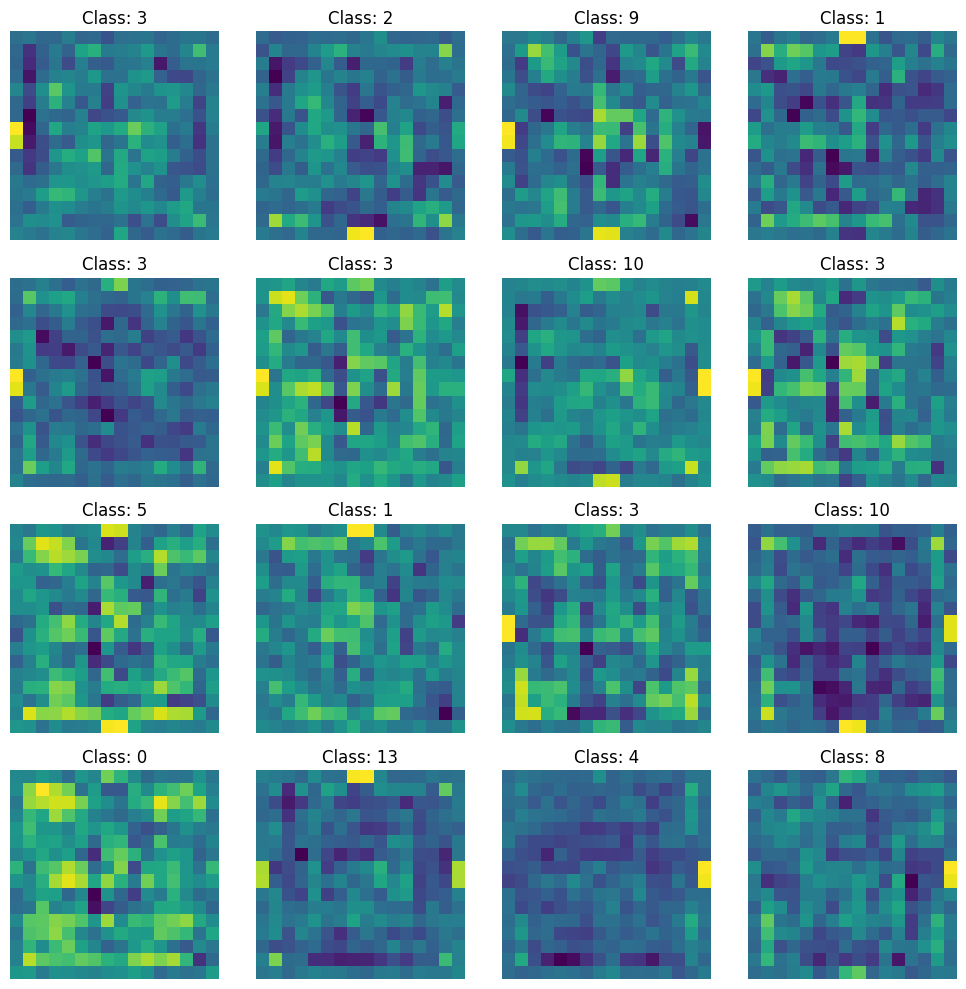

1/1 [==============================] - 0s 25ms/step
2300 [D loss: 0.36995455622673035 | D accuracy: 87.5] [G loss: 2.988953113555908]
1/1 [==============================] - 0s 25ms/step


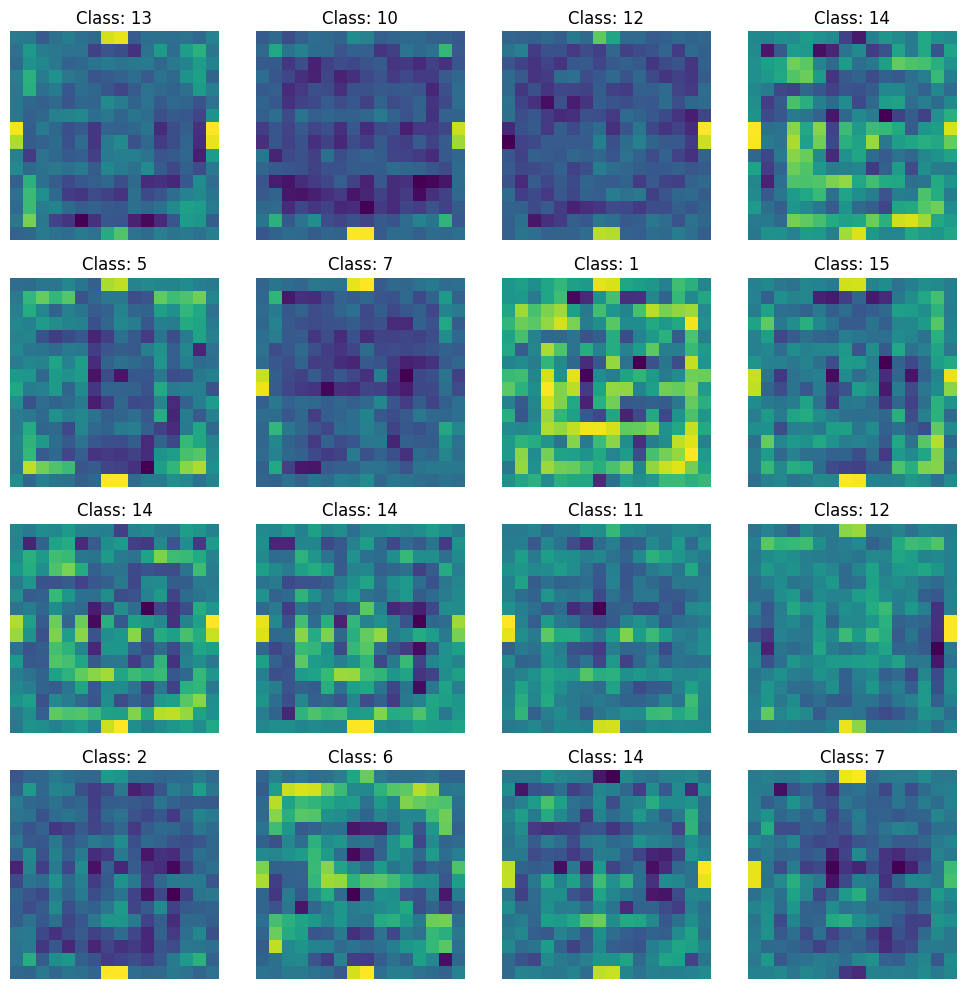

1/1 [==============================] - 0s 26ms/step
2400 [D loss: 0.2678490877151489 | D accuracy: 87.5] [G loss: 4.898375034332275]
1/1 [==============================] - 0s 29ms/step


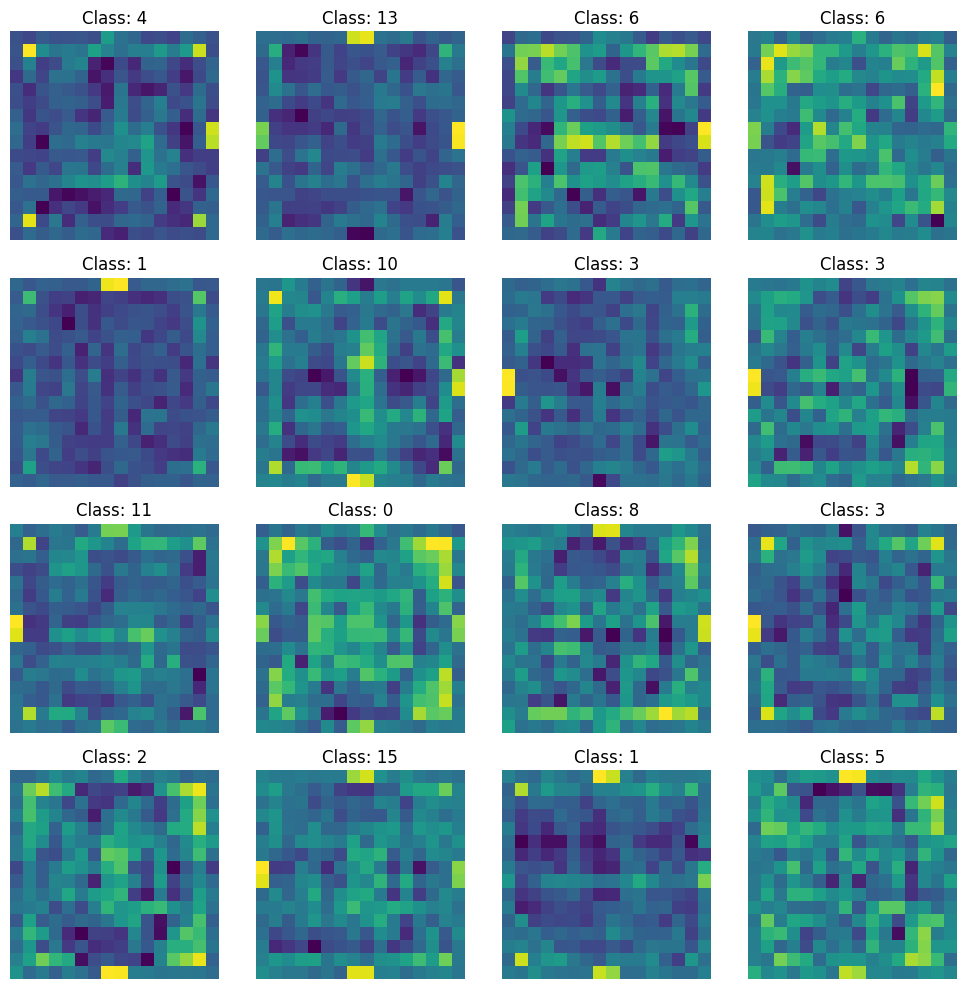

1/1 [==============================] - 0s 47ms/step
2500 [D loss: 0.39060530066490173 | D accuracy: 81.25] [G loss: 5.236981391906738]
1/1 [==============================] - 0s 47ms/step


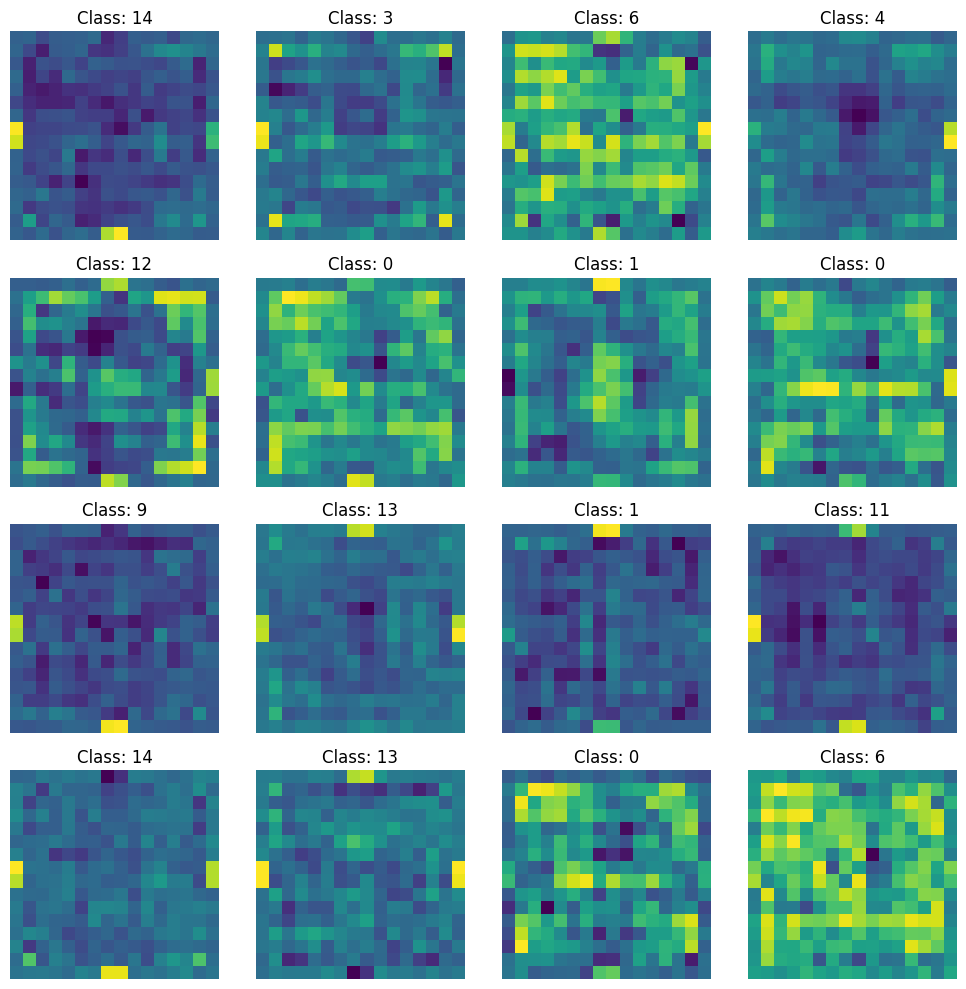

1/1 [==============================] - 0s 29ms/step
2600 [D loss: 0.31444211304187775 | D accuracy: 81.25] [G loss: 5.427778244018555]
1/1 [==============================] - 0s 35ms/step


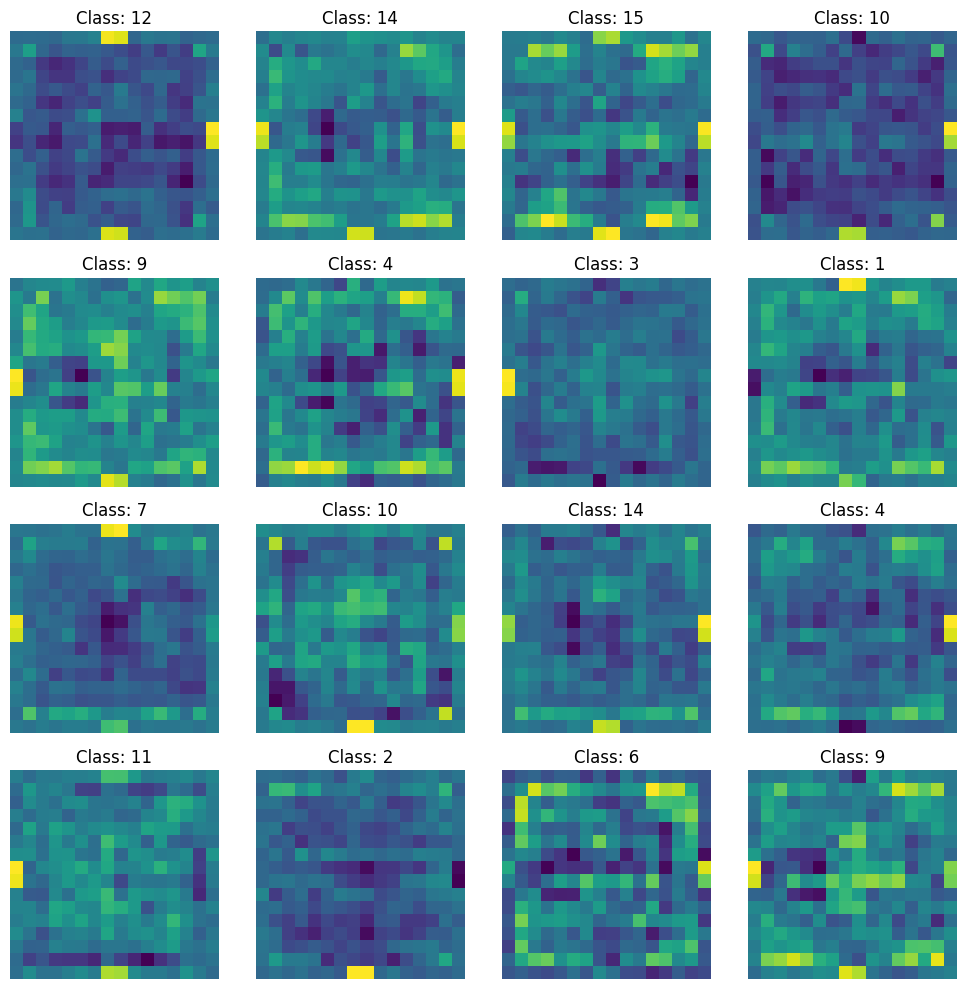

1/1 [==============================] - 0s 28ms/step
2700 [D loss: 0.27407605946063995 | D accuracy: 90.625] [G loss: 4.805884838104248]
1/1 [==============================] - 0s 25ms/step


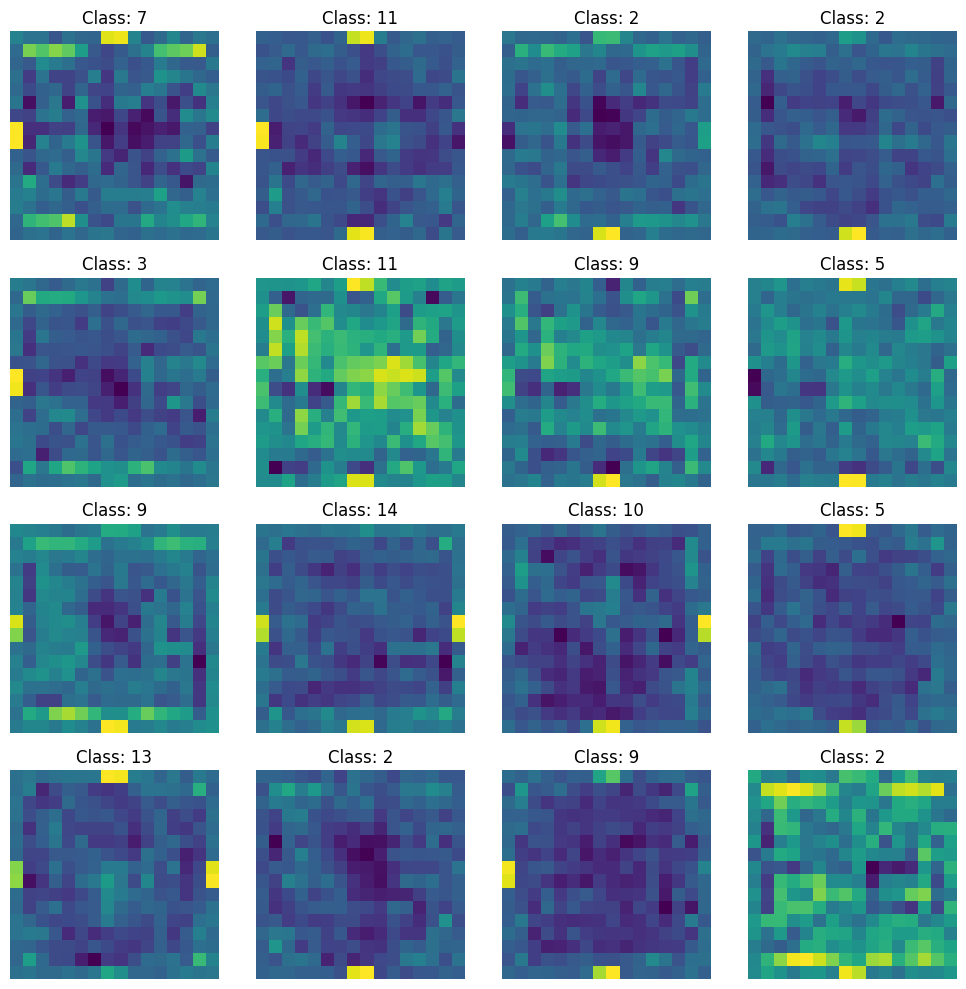

1/1 [==============================] - 0s 33ms/step
2800 [D loss: 0.2077741026878357 | D accuracy: 96.875] [G loss: 5.232282638549805]
1/1 [==============================] - 0s 29ms/step


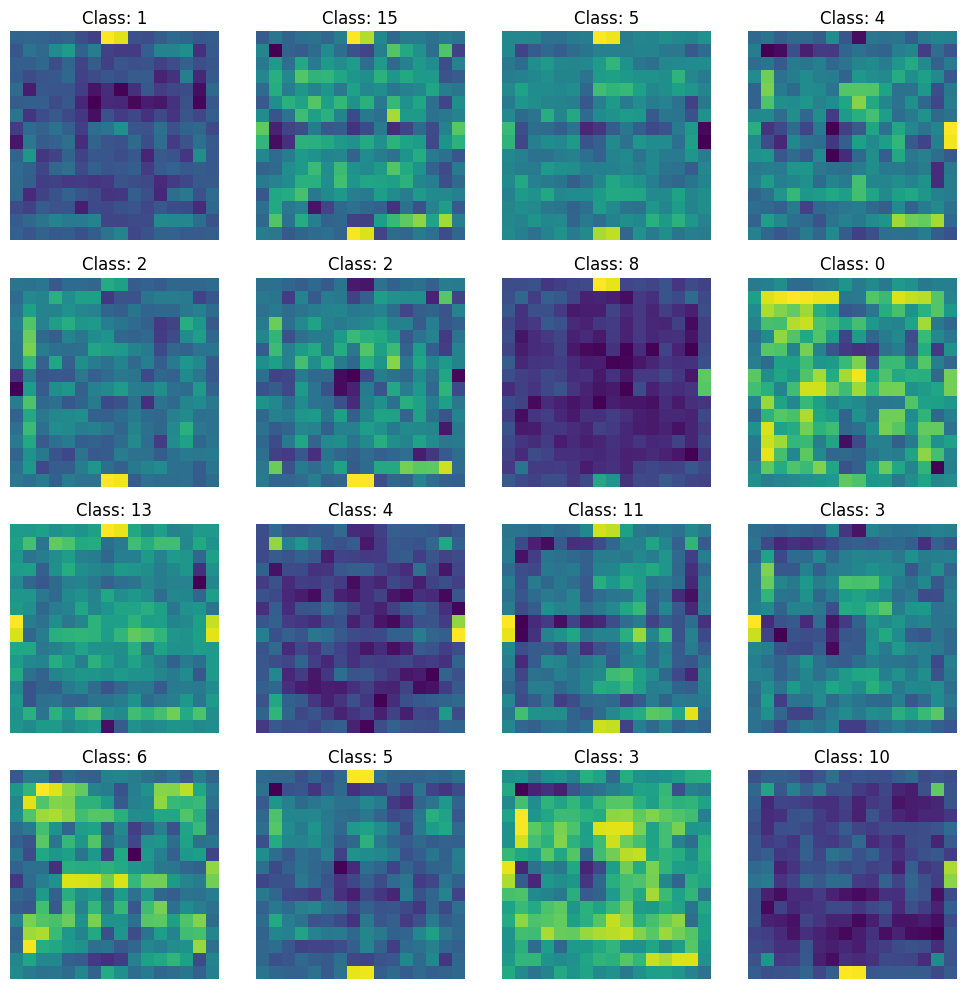

1/1 [==============================] - 0s 33ms/step
2900 [D loss: 0.24274103343486786 | D accuracy: 90.625] [G loss: 3.4230480194091797]
1/1 [==============================] - 0s 33ms/step


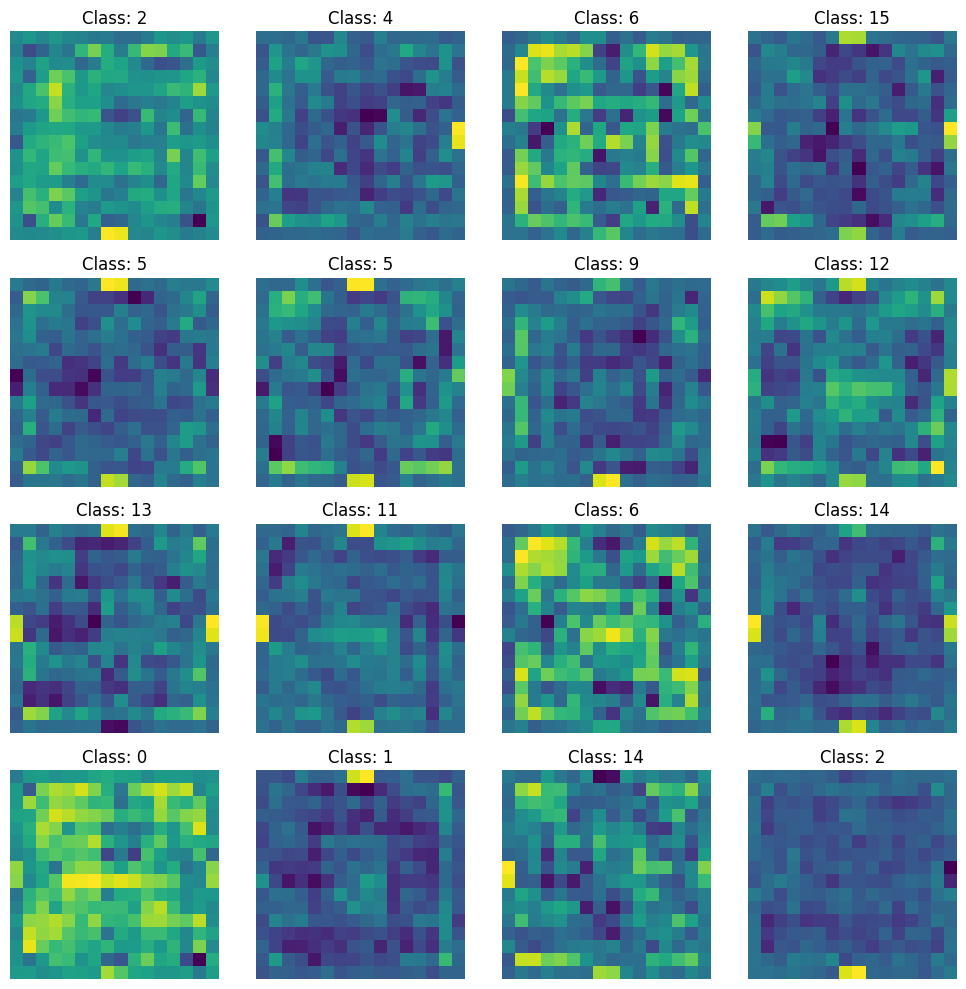

1/1 [==============================] - 0s 26ms/step
3000 [D loss: 0.1338806077837944 | D accuracy: 100.0] [G loss: 4.374110221862793]
1/1 [==============================] - 0s 27ms/step


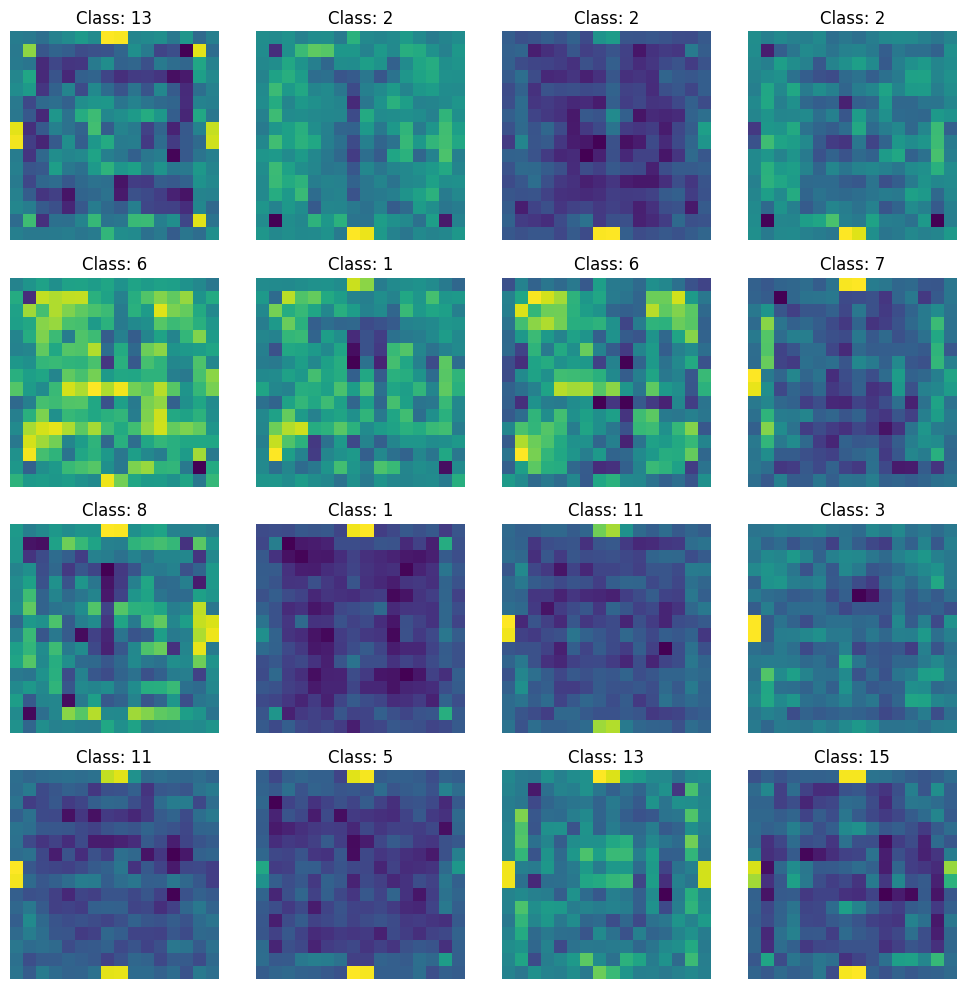

1/1 [==============================] - 0s 26ms/step
3100 [D loss: 0.20552150905132294 | D accuracy: 93.75] [G loss: 3.12127947807312]
1/1 [==============================] - 0s 29ms/step


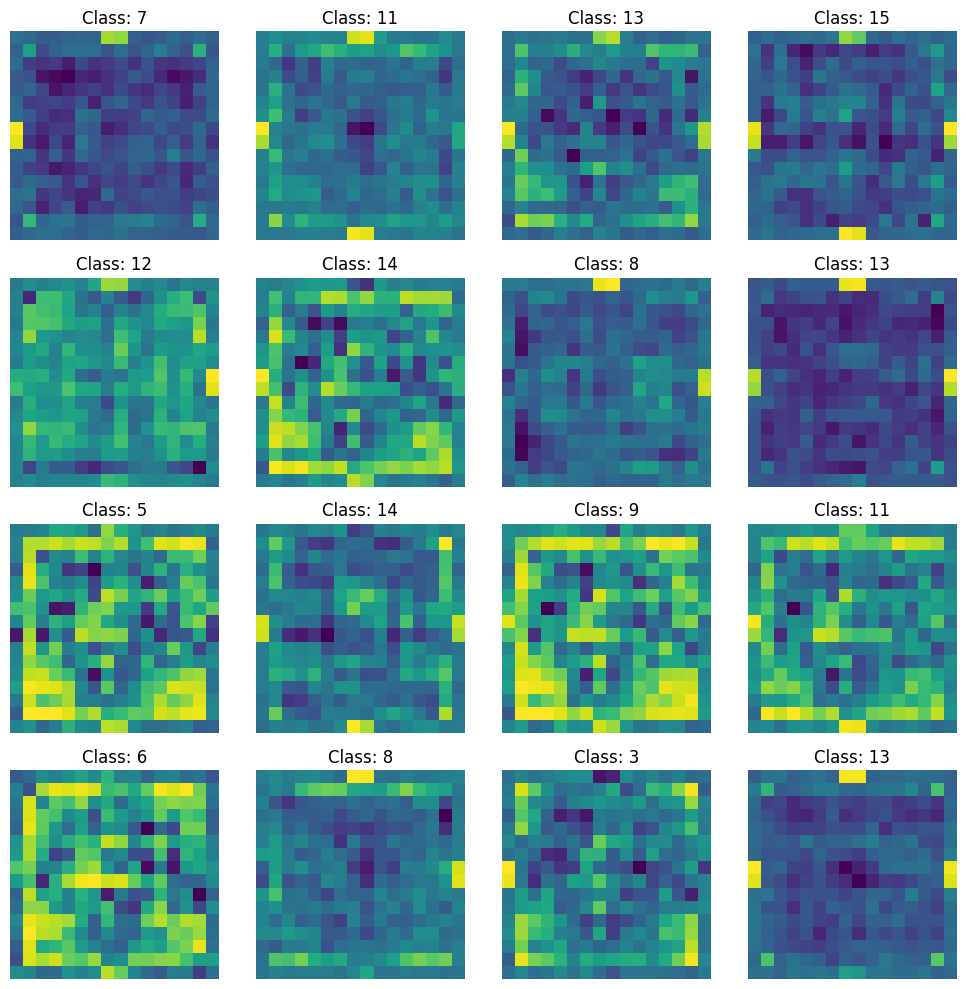

1/1 [==============================] - 0s 31ms/step
3200 [D loss: 0.323601558804512 | D accuracy: 90.625] [G loss: 3.535111904144287]
1/1 [==============================] - 0s 30ms/step


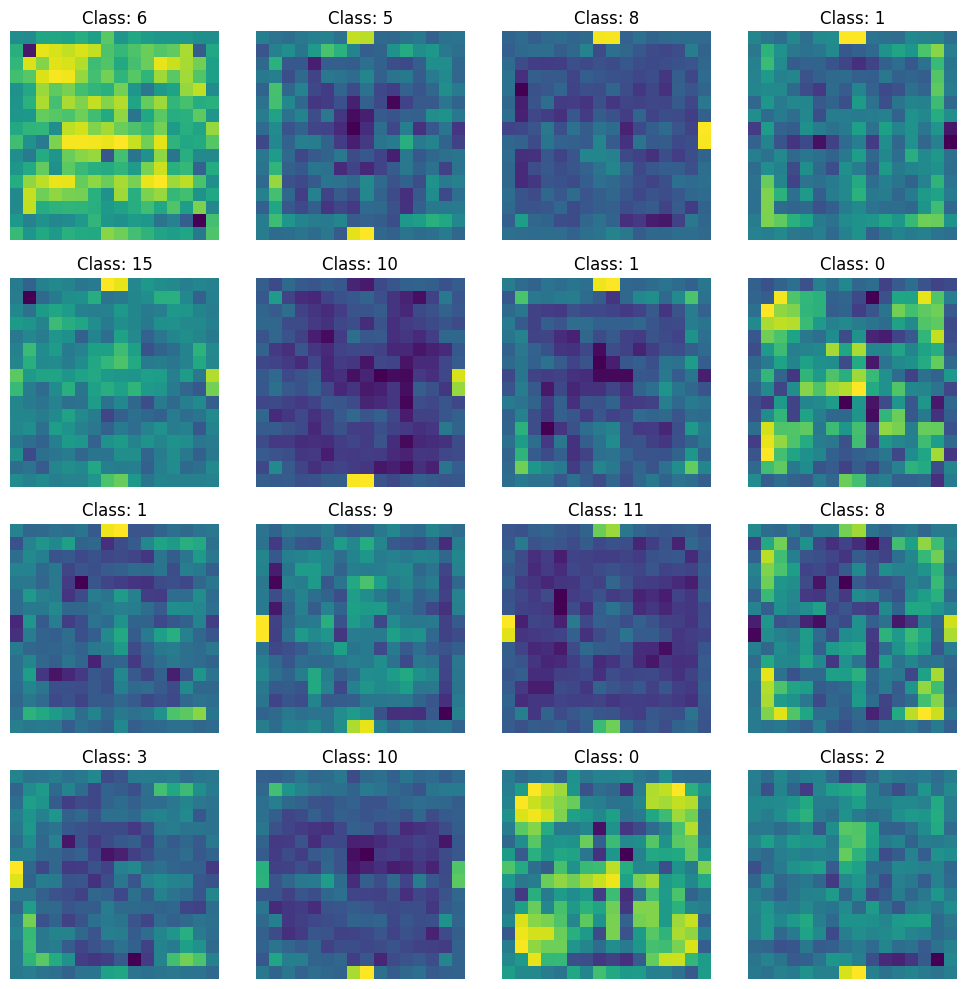

1/1 [==============================] - 0s 31ms/step
3300 [D loss: 0.15525420755147934 | D accuracy: 93.75] [G loss: 5.448677062988281]
1/1 [==============================] - 0s 29ms/step


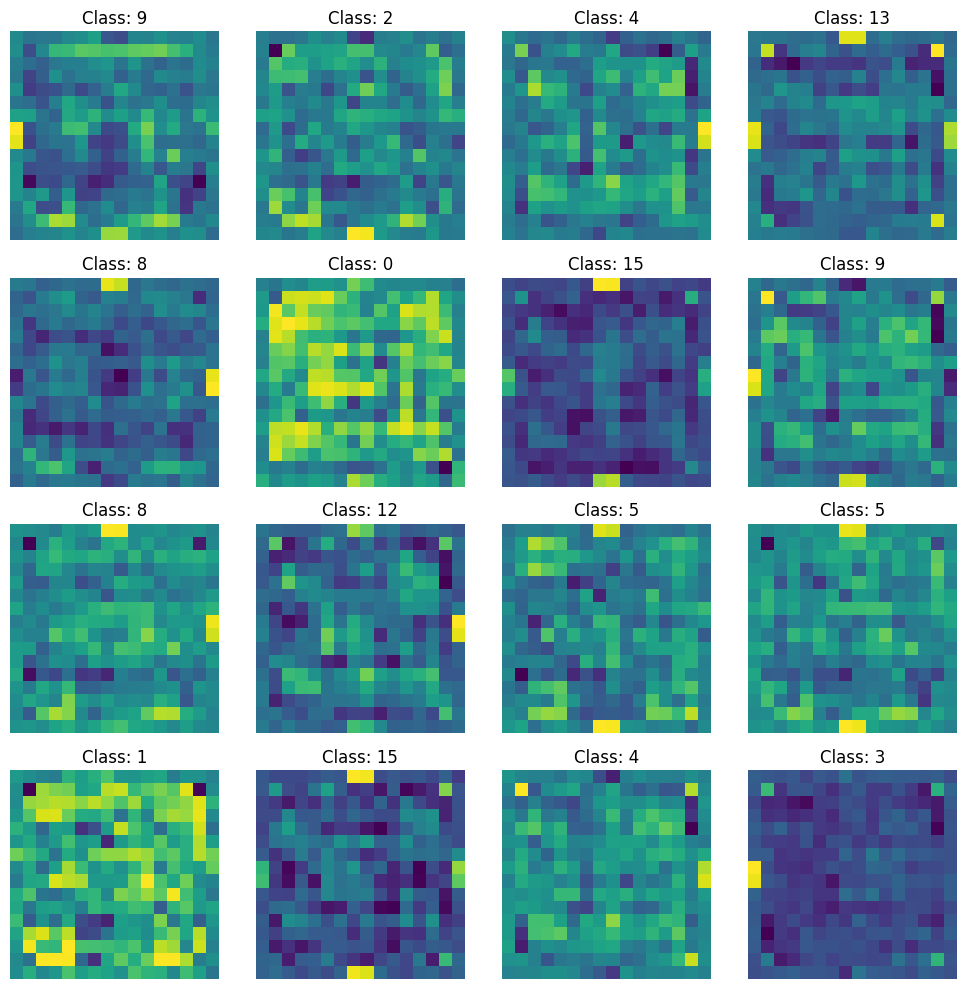

1/1 [==============================] - 0s 39ms/step
3400 [D loss: 0.21634501218795776 | D accuracy: 93.75] [G loss: 4.472023010253906]
1/1 [==============================] - 0s 54ms/step


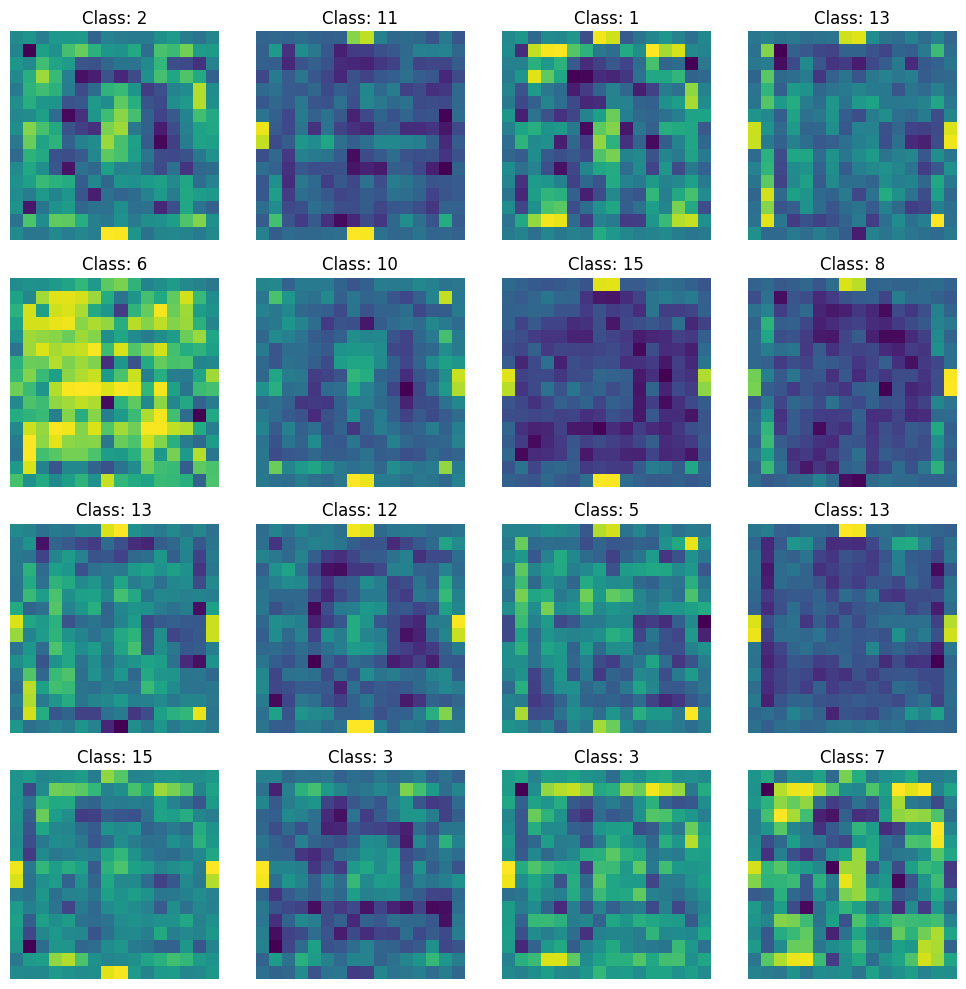

1/1 [==============================] - 0s 32ms/step
3500 [D loss: 0.13869862258434296 | D accuracy: 96.875] [G loss: 5.464089393615723]
1/1 [==============================] - 0s 34ms/step


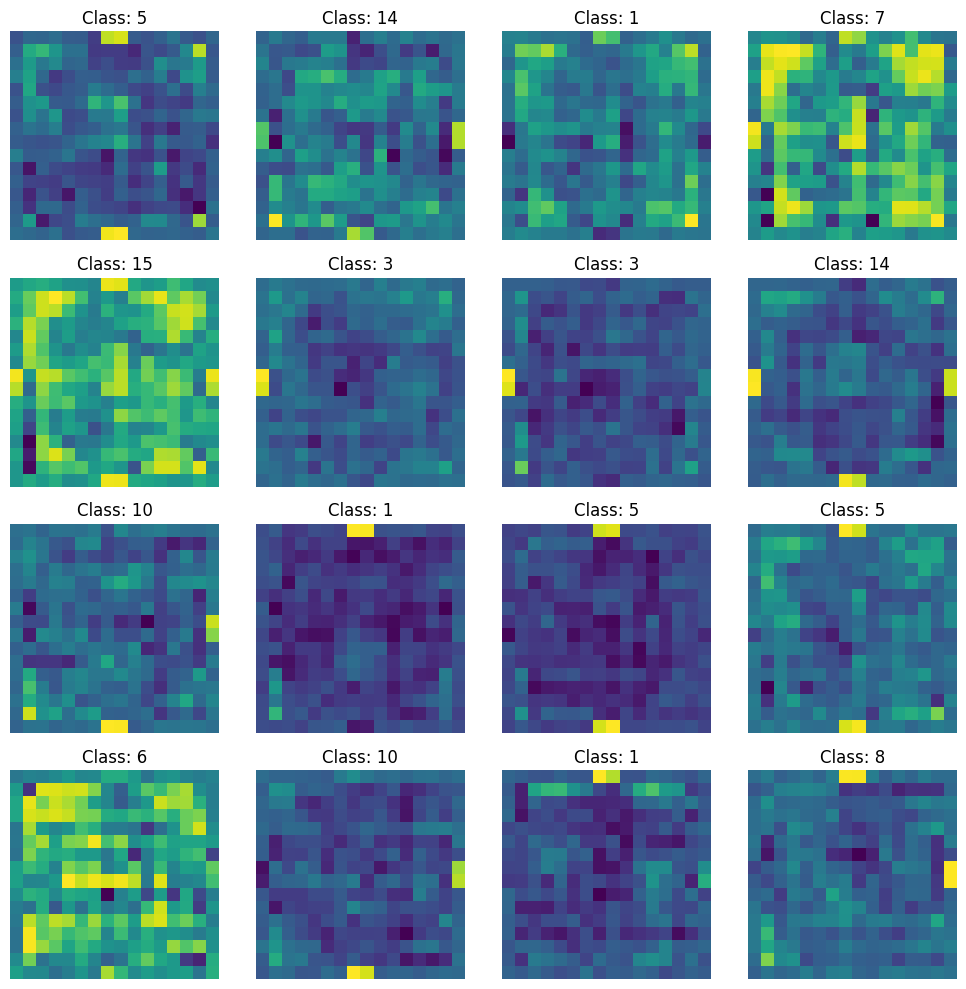

1/1 [==============================] - 0s 49ms/step
3600 [D loss: 0.1340300366282463 | D accuracy: 96.875] [G loss: 3.403090476989746]
1/1 [==============================] - 0s 61ms/step


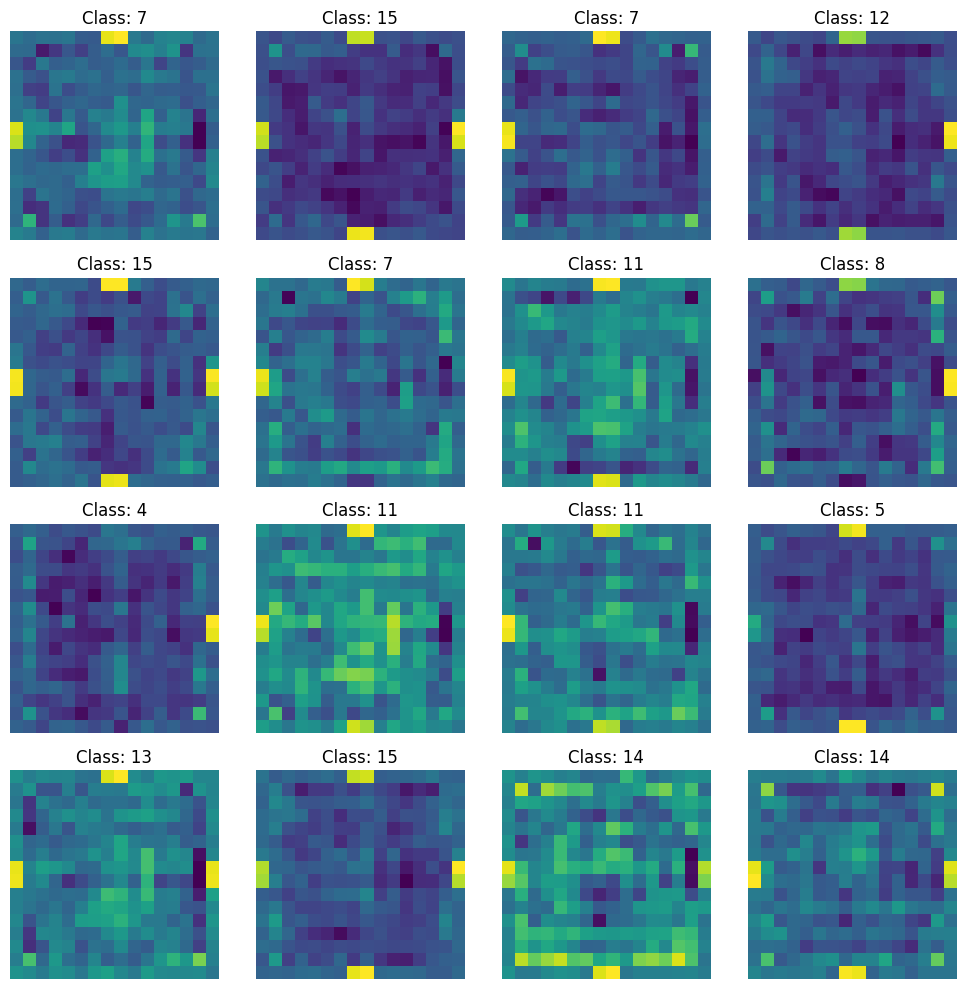

1/1 [==============================] - 0s 23ms/step
3700 [D loss: 0.42009562253952026 | D accuracy: 78.125] [G loss: 5.366580009460449]
1/1 [==============================] - 0s 32ms/step


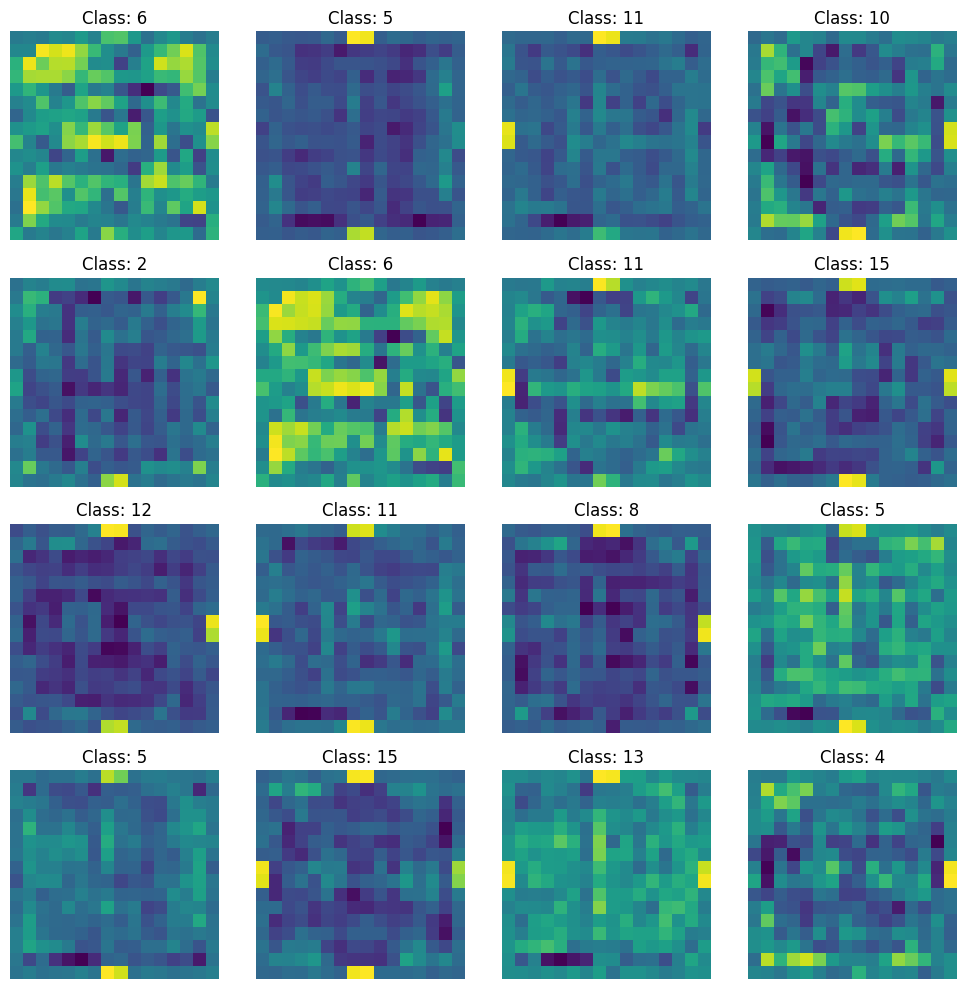

1/1 [==============================] - 0s 28ms/step
3800 [D loss: 0.3320428654551506 | D accuracy: 84.375] [G loss: 3.02943754196167]
1/1 [==============================] - 0s 23ms/step


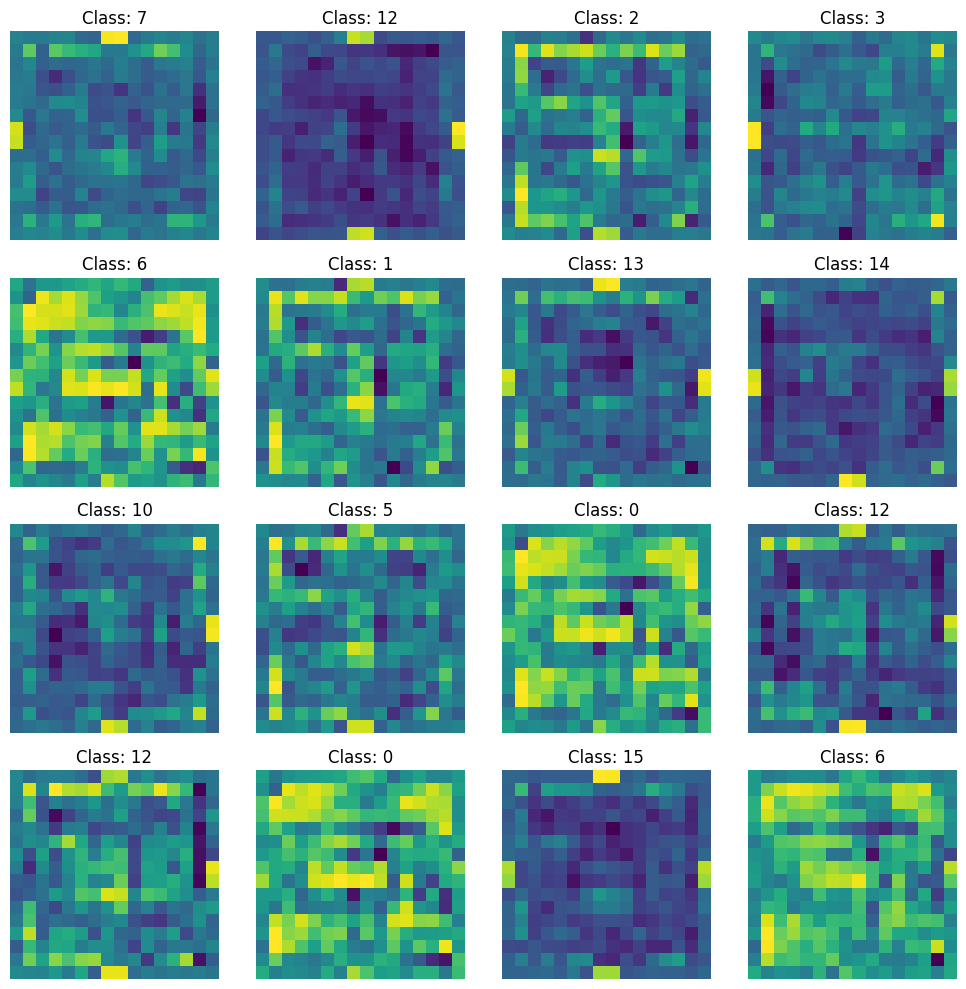

1/1 [==============================] - 0s 31ms/step
3900 [D loss: 0.3078767657279968 | D accuracy: 84.375] [G loss: 3.316591739654541]
1/1 [==============================] - 0s 29ms/step


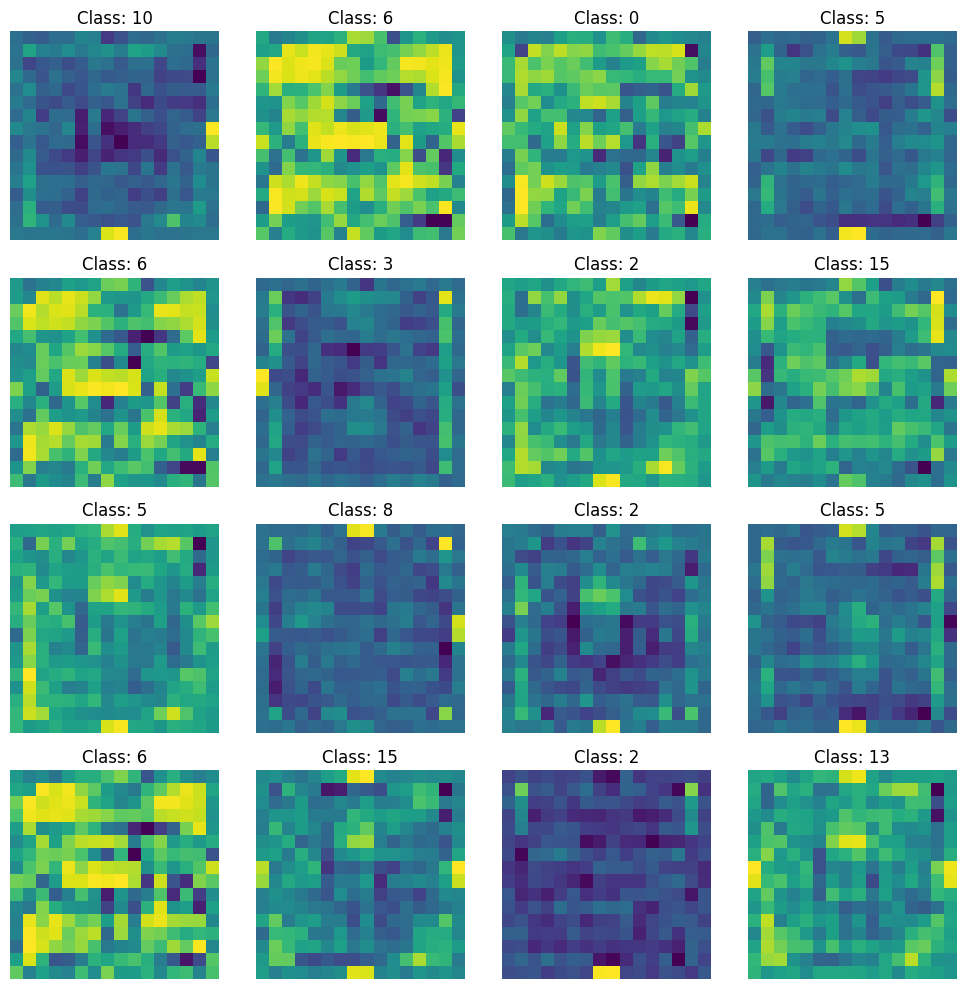

1/1 [==============================] - 0s 31ms/step
4000 [D loss: 0.2386740893125534 | D accuracy: 90.625] [G loss: 5.807207107543945]
1/1 [==============================] - 0s 26ms/step


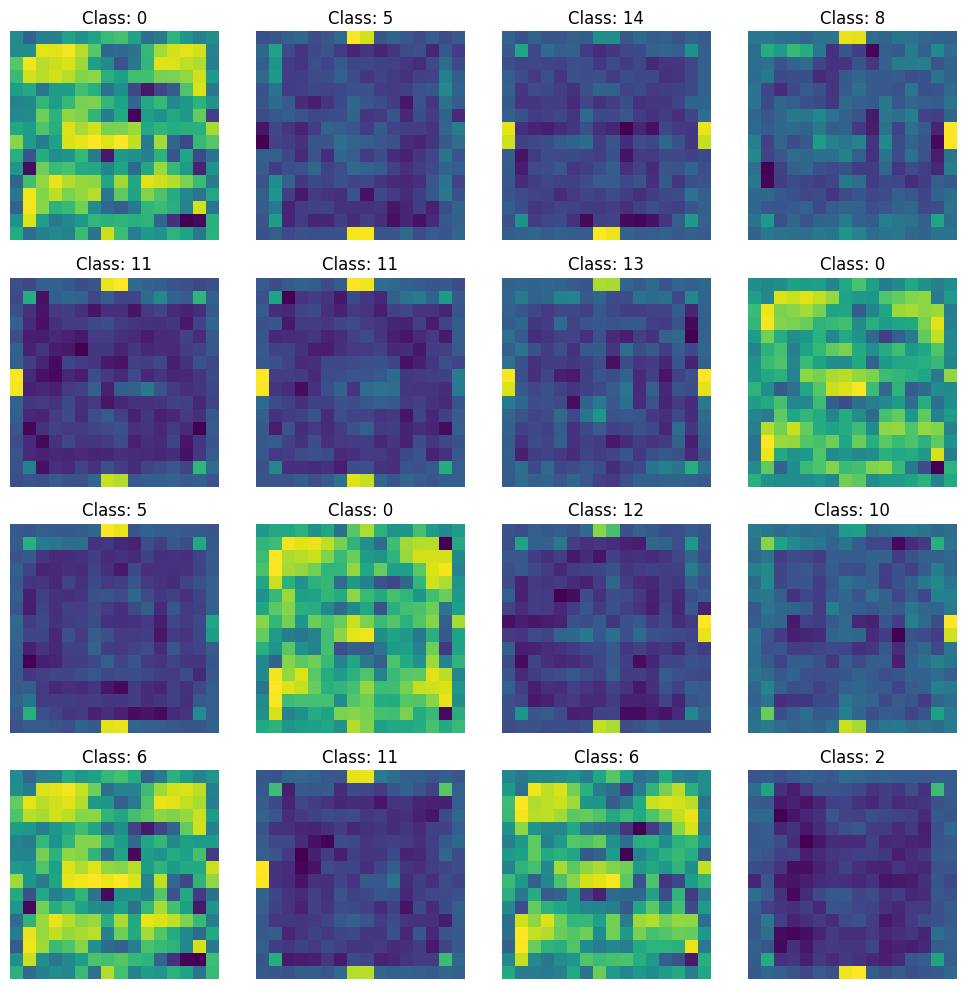

1/1 [==============================] - 0s 34ms/step
4100 [D loss: 0.2903284505009651 | D accuracy: 84.375] [G loss: 5.92326545715332]
1/1 [==============================] - 0s 50ms/step


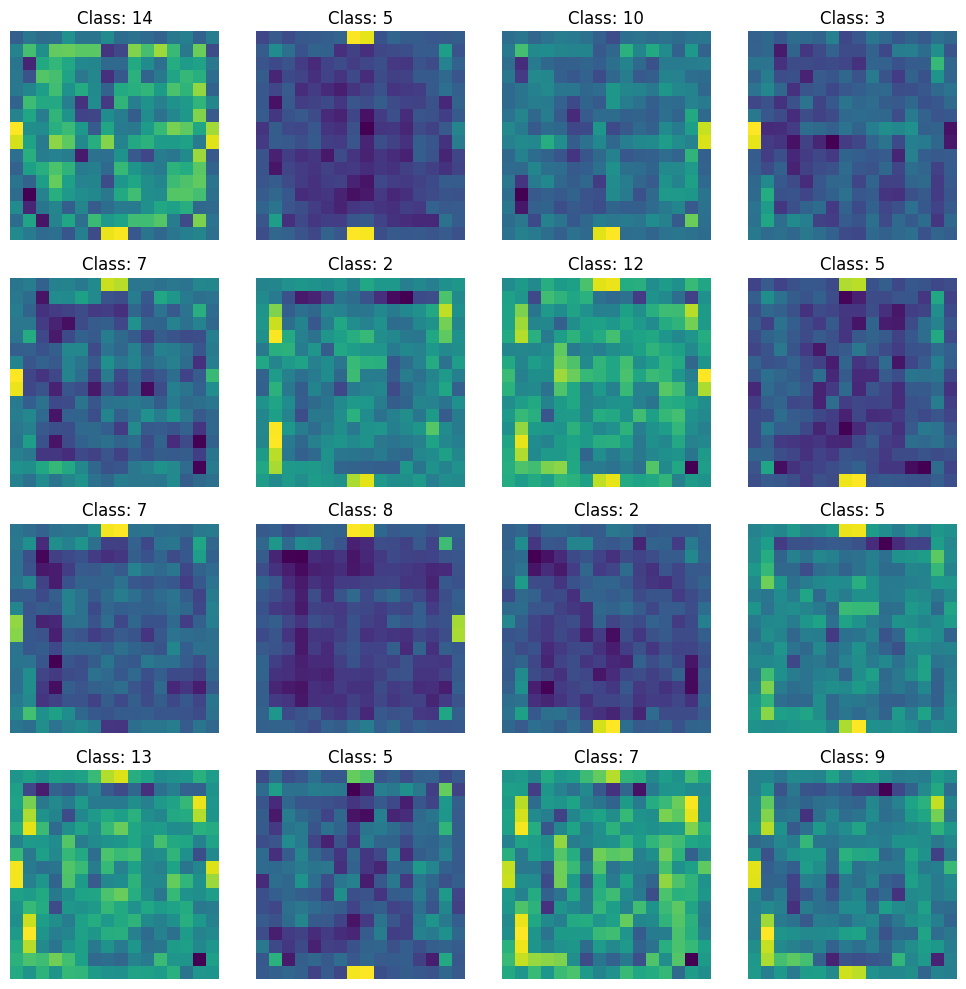

1/1 [==============================] - 0s 40ms/step
4200 [D loss: 0.35468728840351105 | D accuracy: 81.25] [G loss: 5.630767822265625]
1/1 [==============================] - 0s 34ms/step


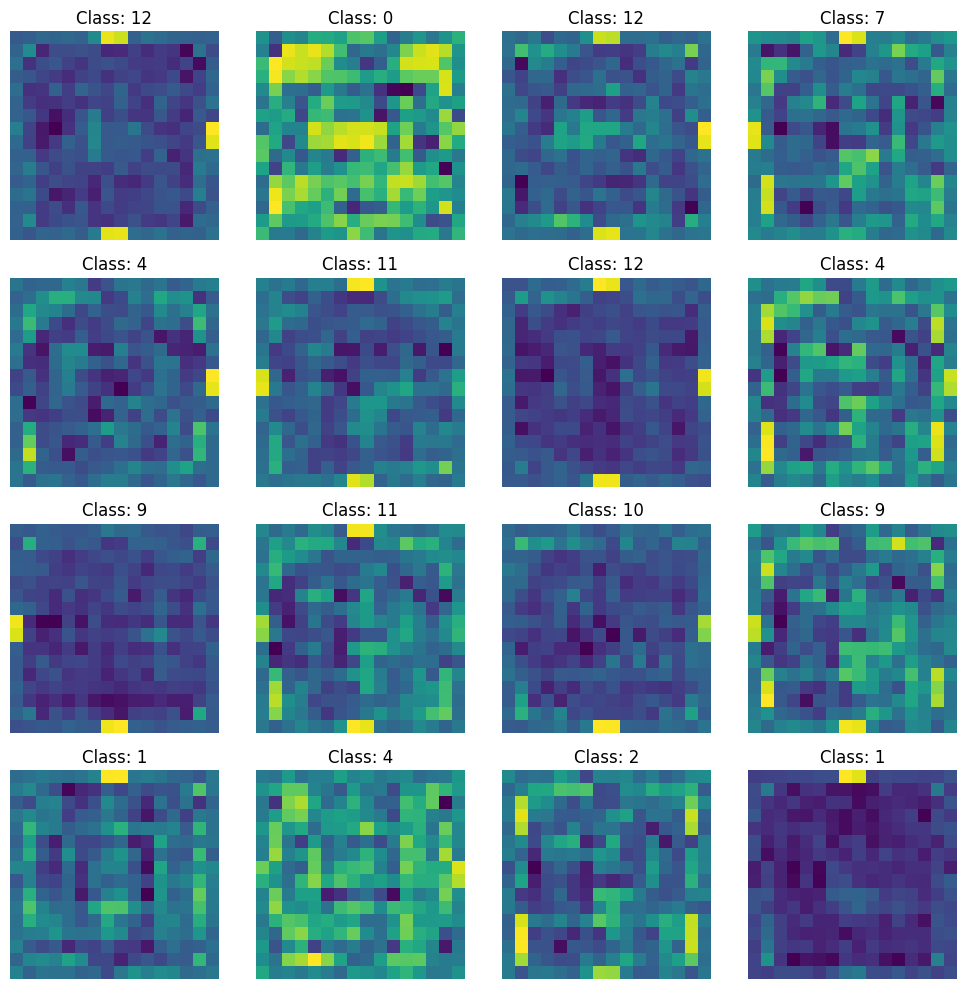

1/1 [==============================] - 0s 39ms/step
4300 [D loss: 0.36598655581474304 | D accuracy: 78.125] [G loss: 4.268452167510986]
1/1 [==============================] - 0s 50ms/step


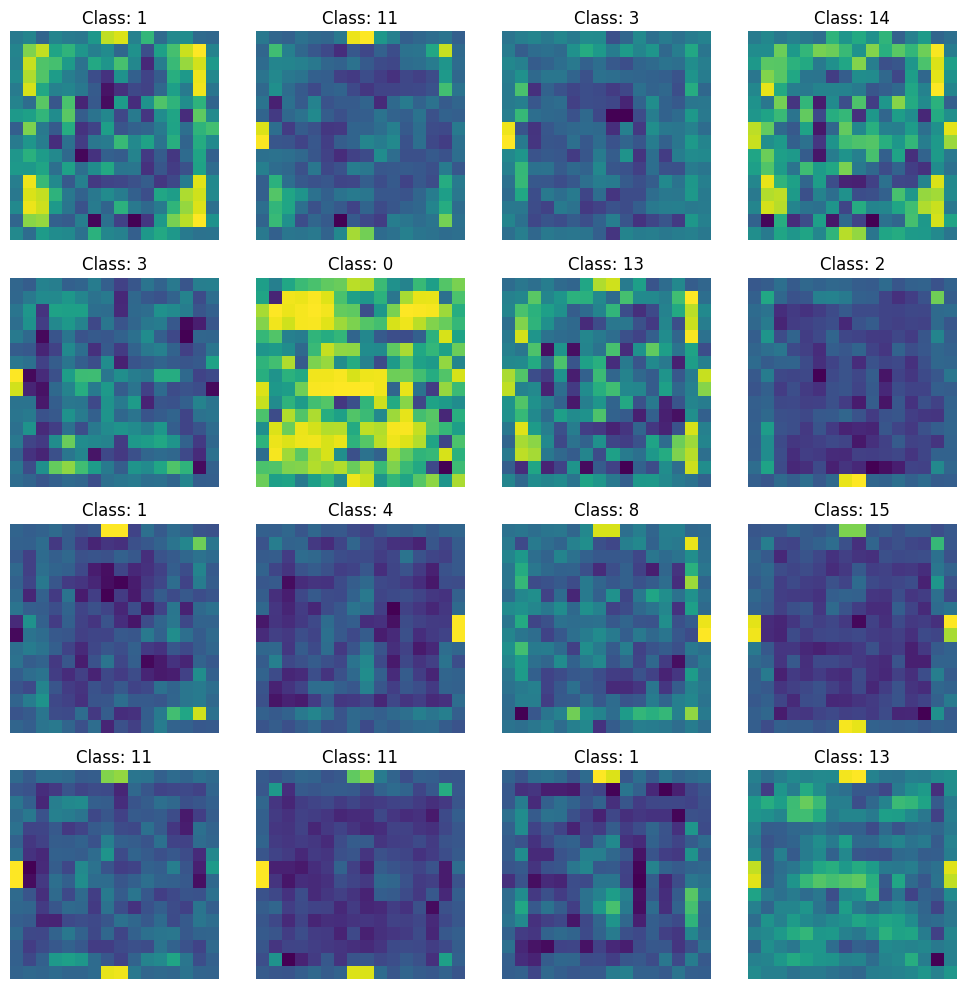

1/1 [==============================] - 0s 26ms/step
4400 [D loss: 0.19993628561496735 | D accuracy: 93.75] [G loss: 6.142025947570801]
1/1 [==============================] - 0s 28ms/step


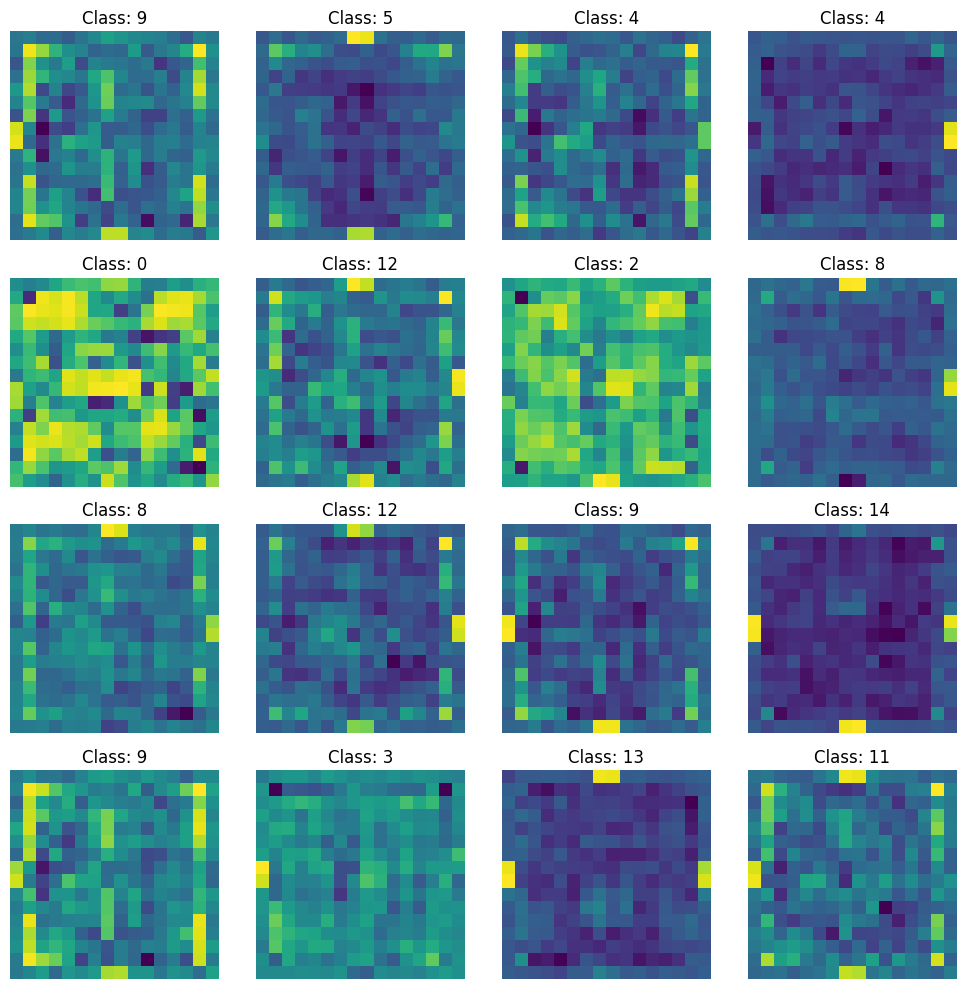

1/1 [==============================] - 0s 27ms/step
4500 [D loss: 0.15023257583379745 | D accuracy: 93.75] [G loss: 4.5289506912231445]
1/1 [==============================] - 0s 25ms/step


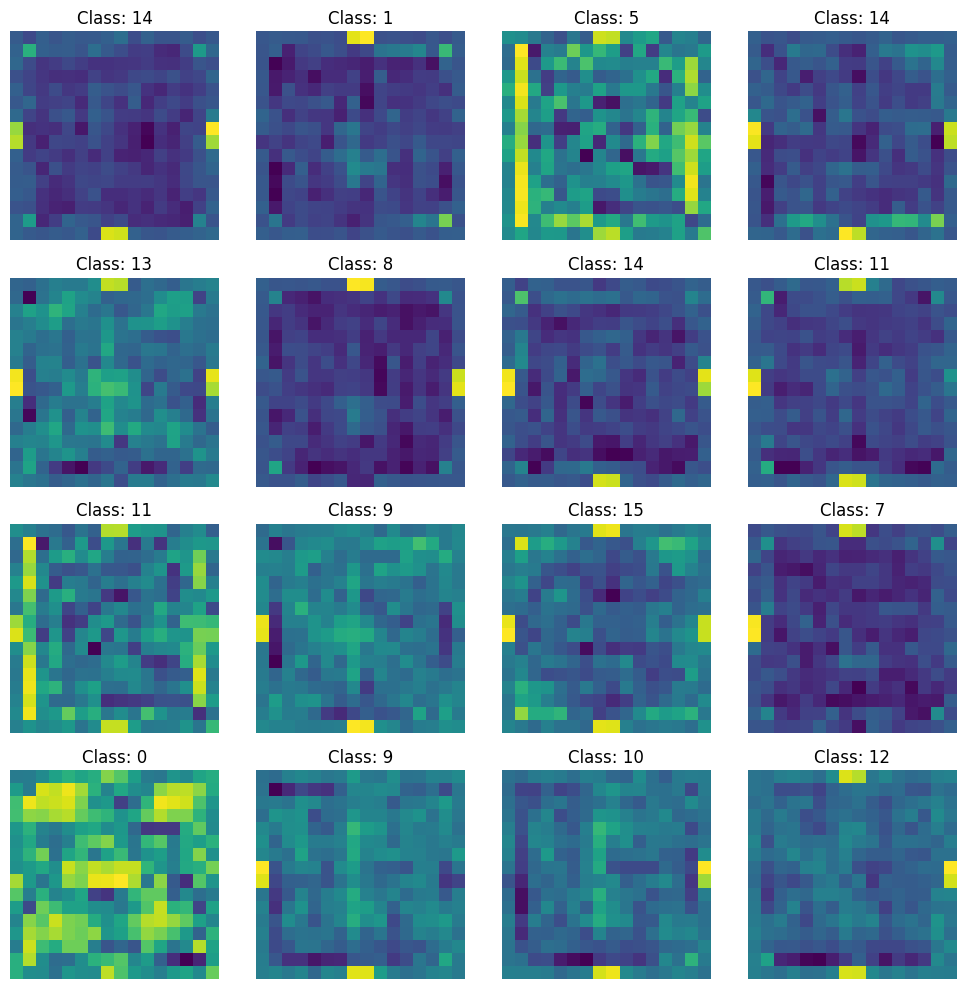

1/1 [==============================] - 0s 35ms/step
4600 [D loss: 0.2954888790845871 | D accuracy: 90.625] [G loss: 4.114398956298828]
1/1 [==============================] - 0s 40ms/step


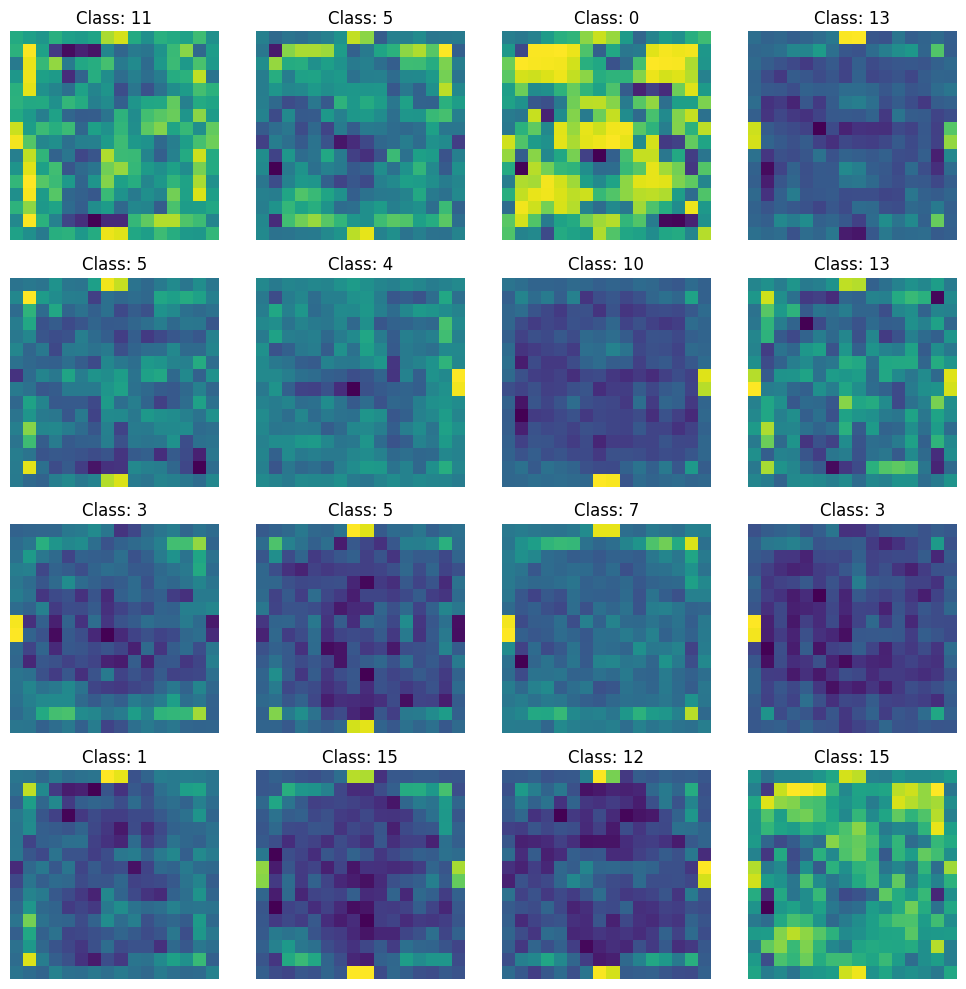

1/1 [==============================] - 0s 44ms/step
4700 [D loss: 0.23094554618000984 | D accuracy: 87.5] [G loss: 5.326848983764648]
1/1 [==============================] - 0s 45ms/step


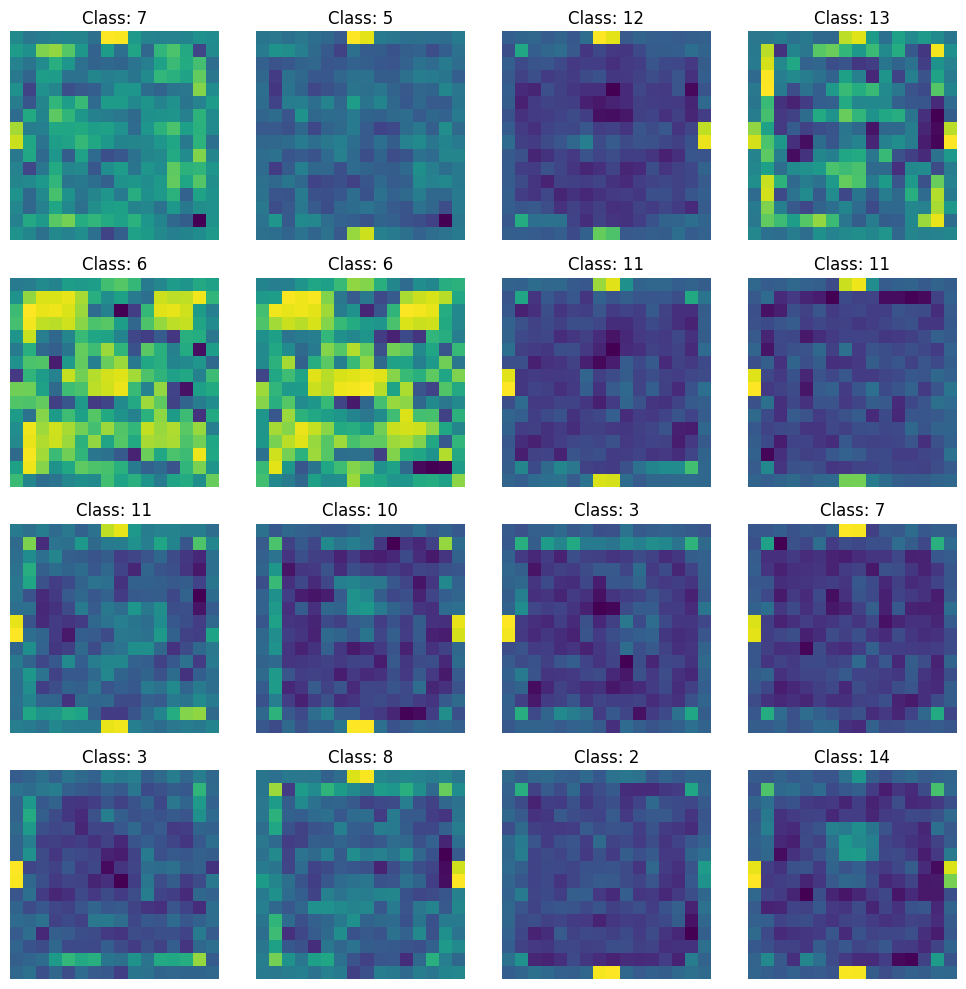

1/1 [==============================] - 0s 24ms/step
4800 [D loss: 0.138443723320961 | D accuracy: 96.875] [G loss: 4.409224987030029]
1/1 [==============================] - 0s 25ms/step


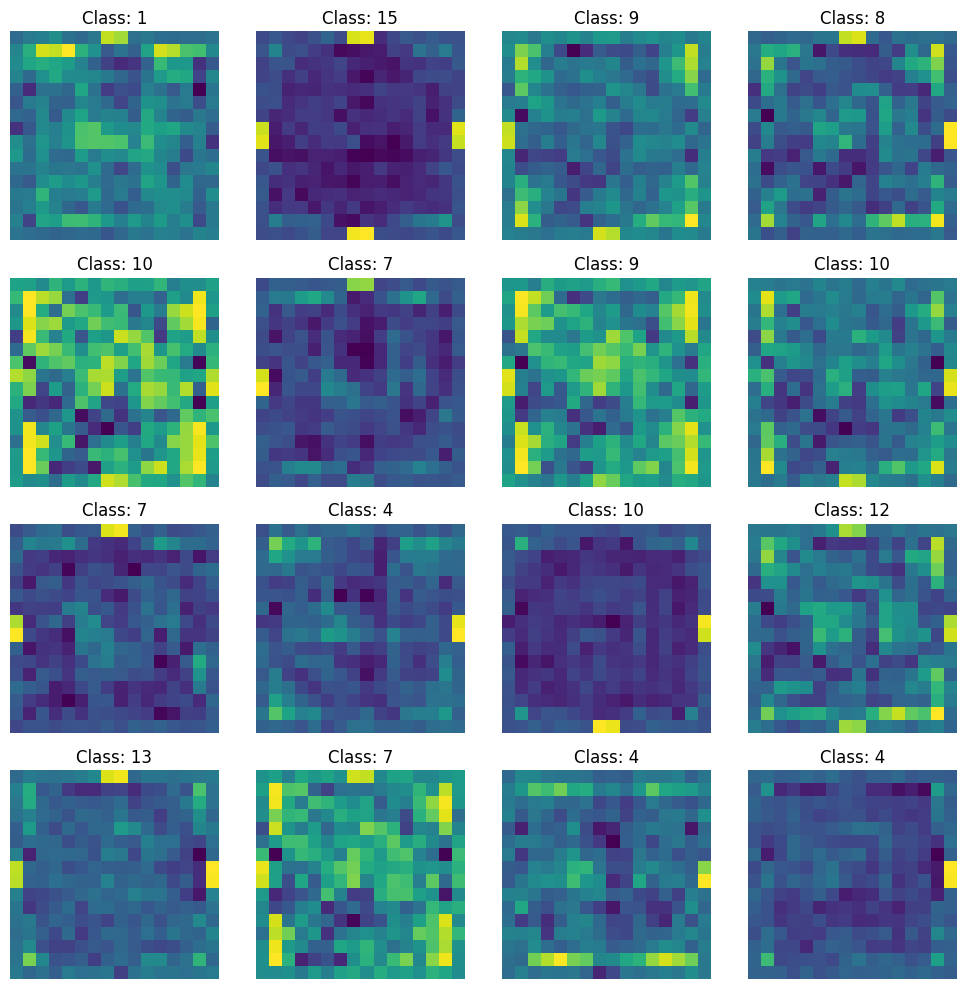

1/1 [==============================] - 0s 40ms/step
4900 [D loss: 0.2173810824751854 | D accuracy: 96.875] [G loss: 4.707907676696777]
1/1 [==============================] - 0s 40ms/step


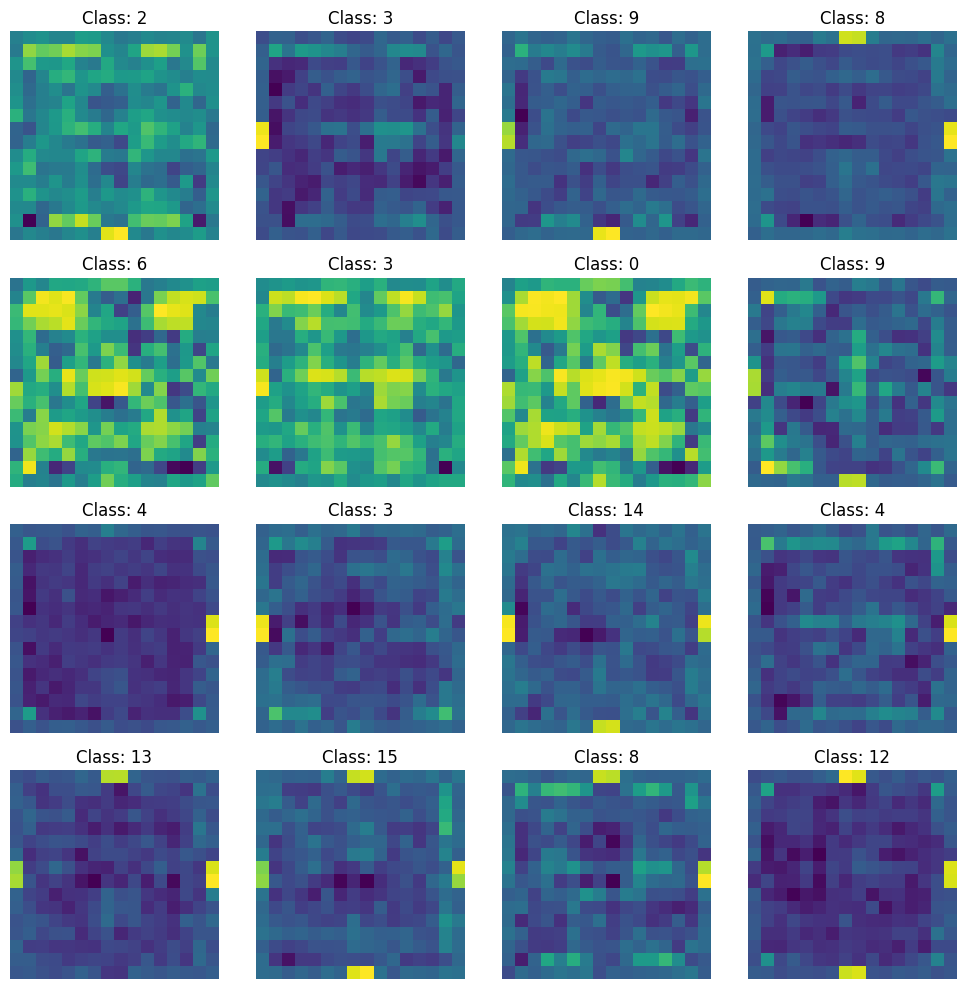

1/1 [==============================] - 0s 33ms/step
5000 [D loss: 0.2450437694787979 | D accuracy: 90.625] [G loss: 7.027538299560547]
1/1 [==============================] - 0s 32ms/step


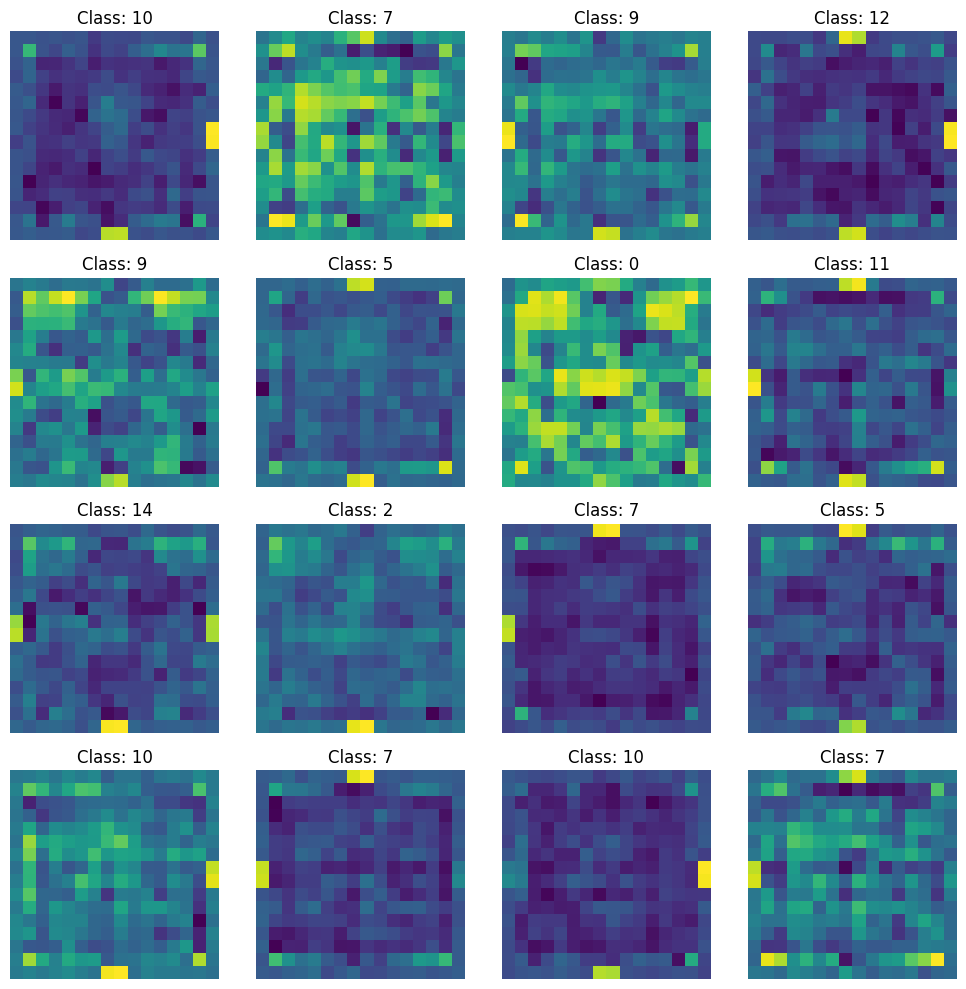

1/1 [==============================] - 0s 26ms/step
5100 [D loss: 0.49532628059387207 | D accuracy: 78.125] [G loss: 7.983376979827881]
1/1 [==============================] - 0s 32ms/step


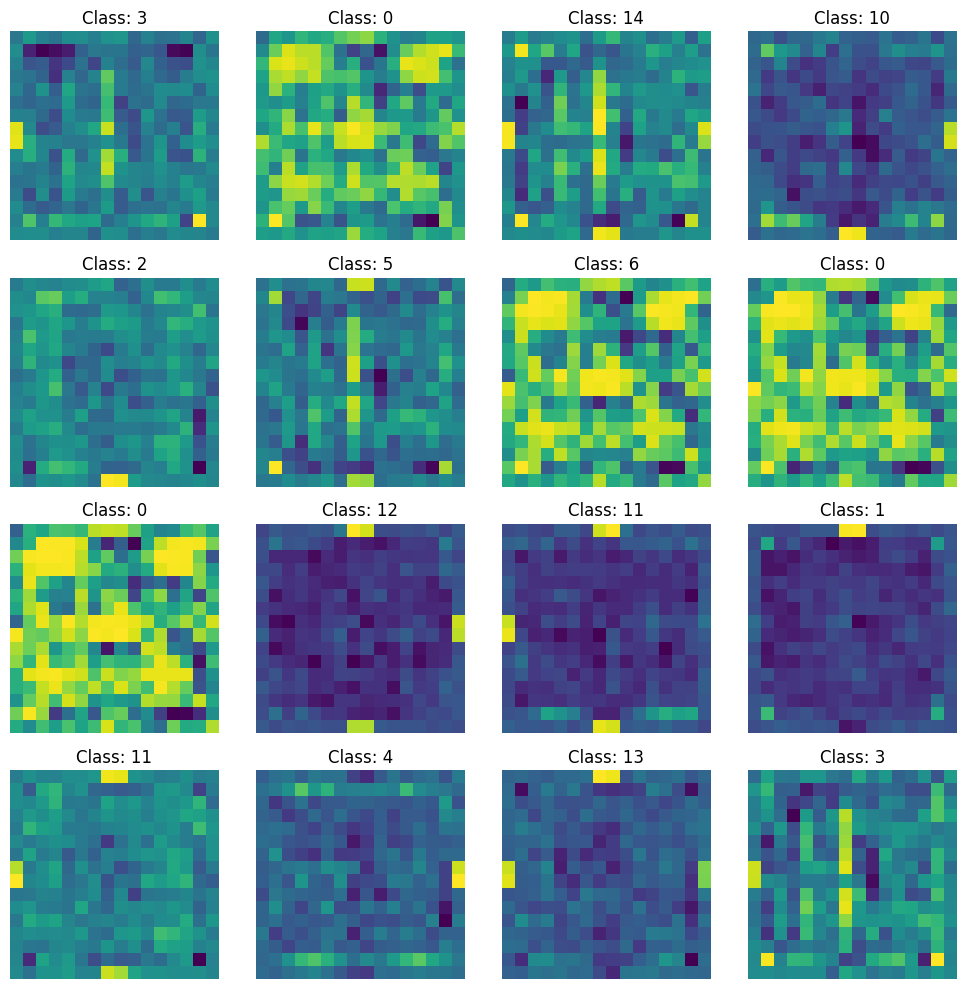

1/1 [==============================] - 0s 27ms/step
5200 [D loss: 0.31264134868979454 | D accuracy: 90.625] [G loss: 4.7886247634887695]
1/1 [==============================] - 0s 25ms/step


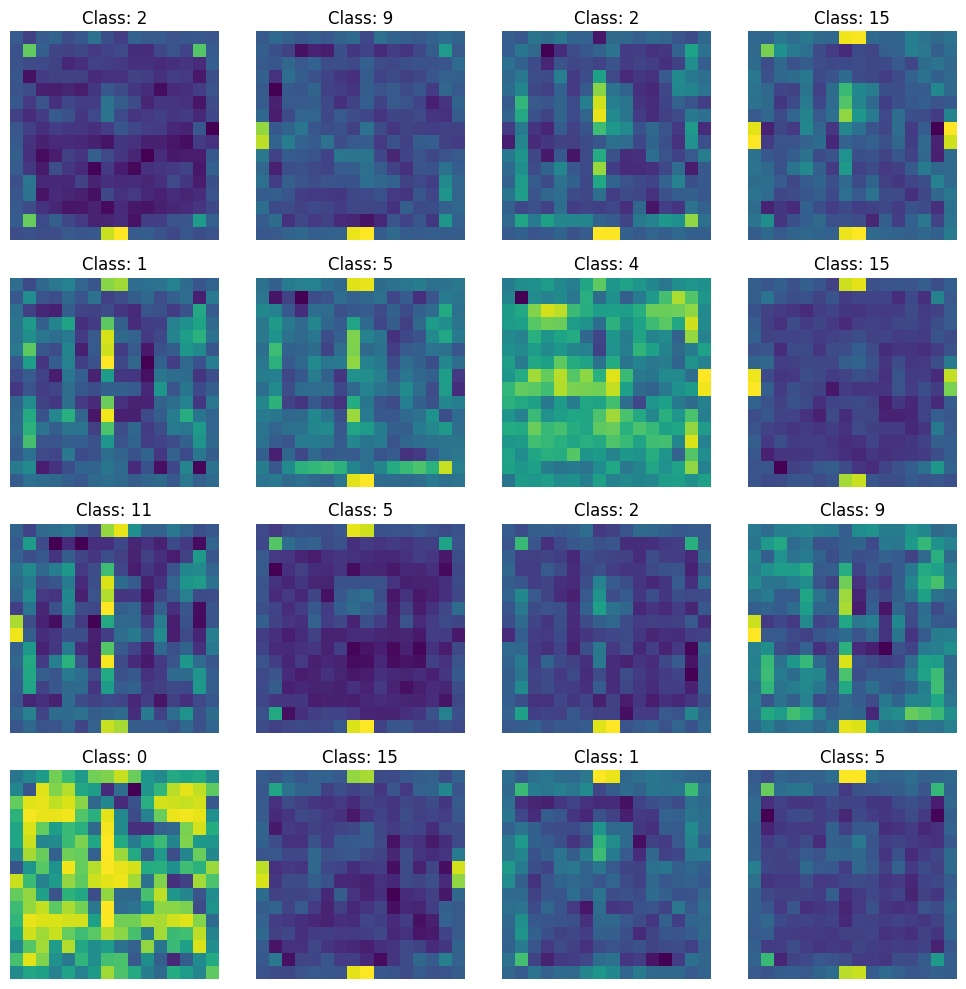

1/1 [==============================] - 0s 34ms/step
5300 [D loss: 0.13017108105123043 | D accuracy: 96.875] [G loss: 5.110591888427734]
1/1 [==============================] - 0s 39ms/step


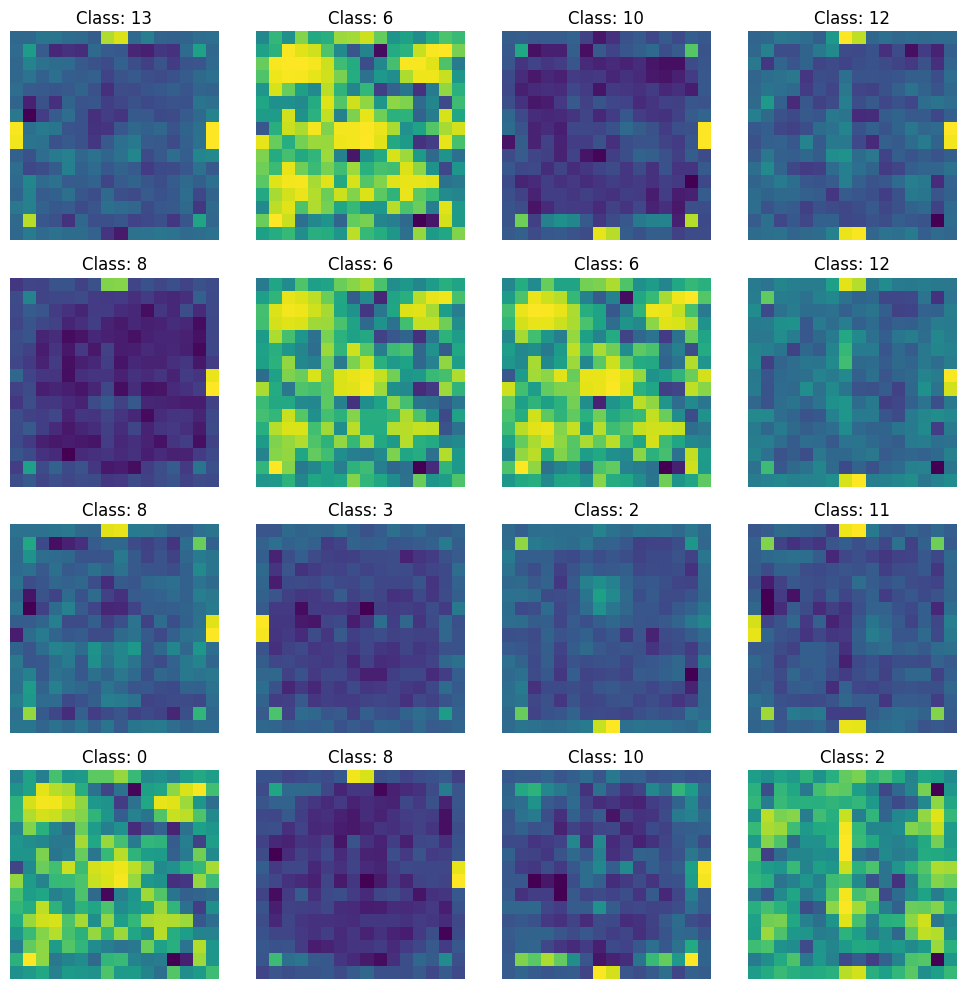

1/1 [==============================] - 0s 27ms/step
5400 [D loss: 0.11644771695137024 | D accuracy: 100.0] [G loss: 5.23812198638916]
1/1 [==============================] - 0s 27ms/step


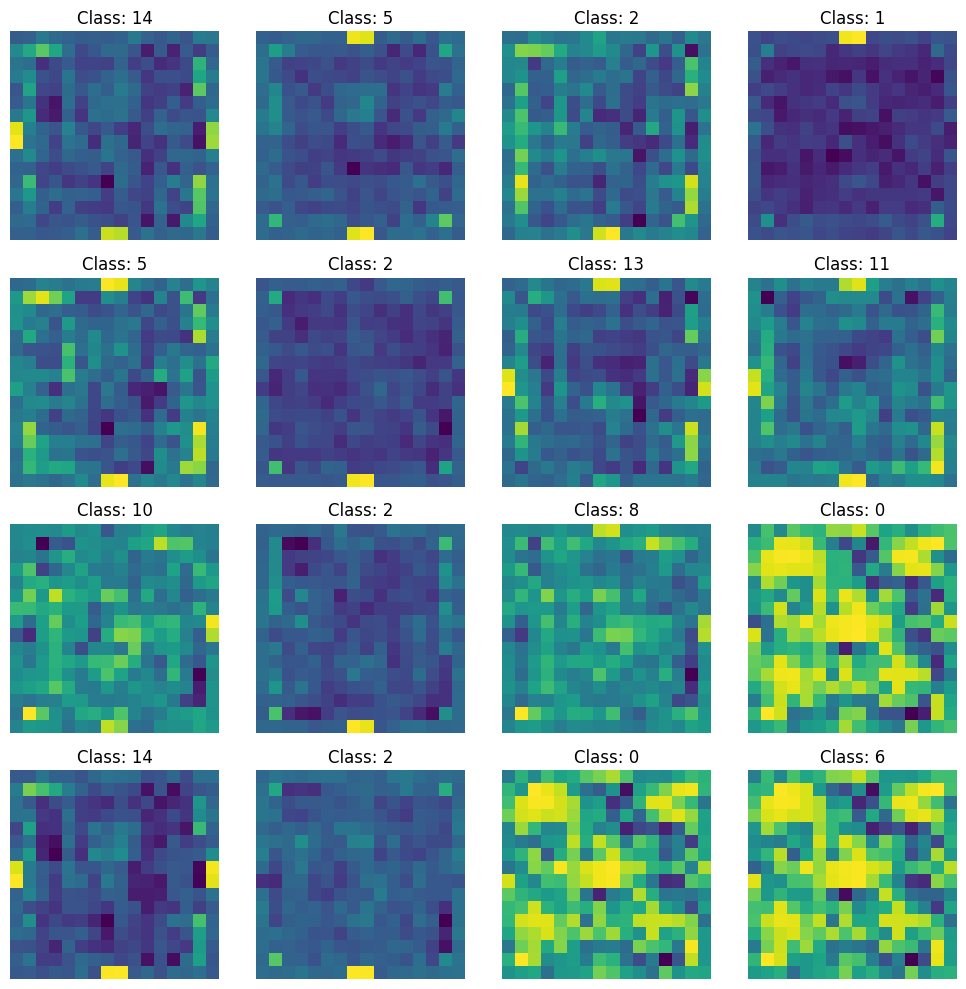

1/1 [==============================] - 0s 23ms/step
5500 [D loss: 0.13236497342586517 | D accuracy: 96.875] [G loss: 3.9415478706359863]
1/1 [==============================] - 0s 24ms/step


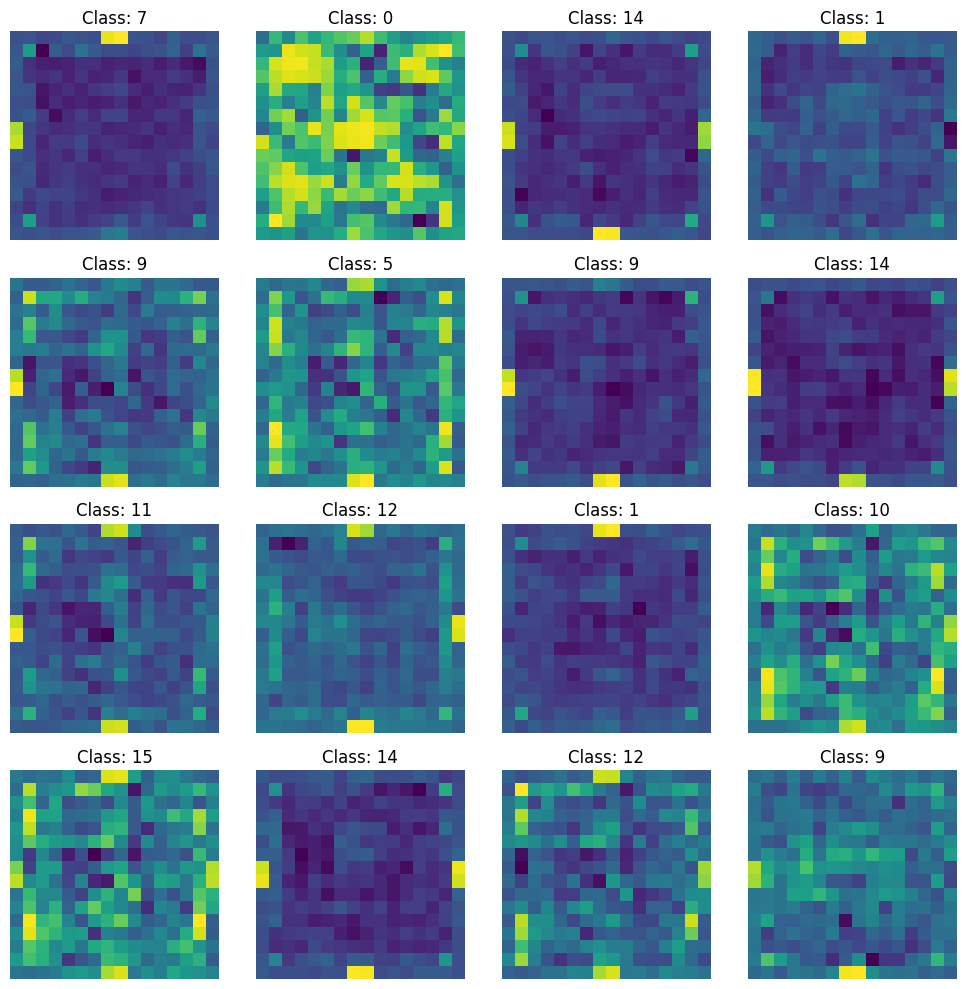

1/1 [==============================] - 0s 53ms/step
5600 [D loss: 0.24854249134659767 | D accuracy: 90.625] [G loss: 4.925173759460449]
1/1 [==============================] - 0s 59ms/step


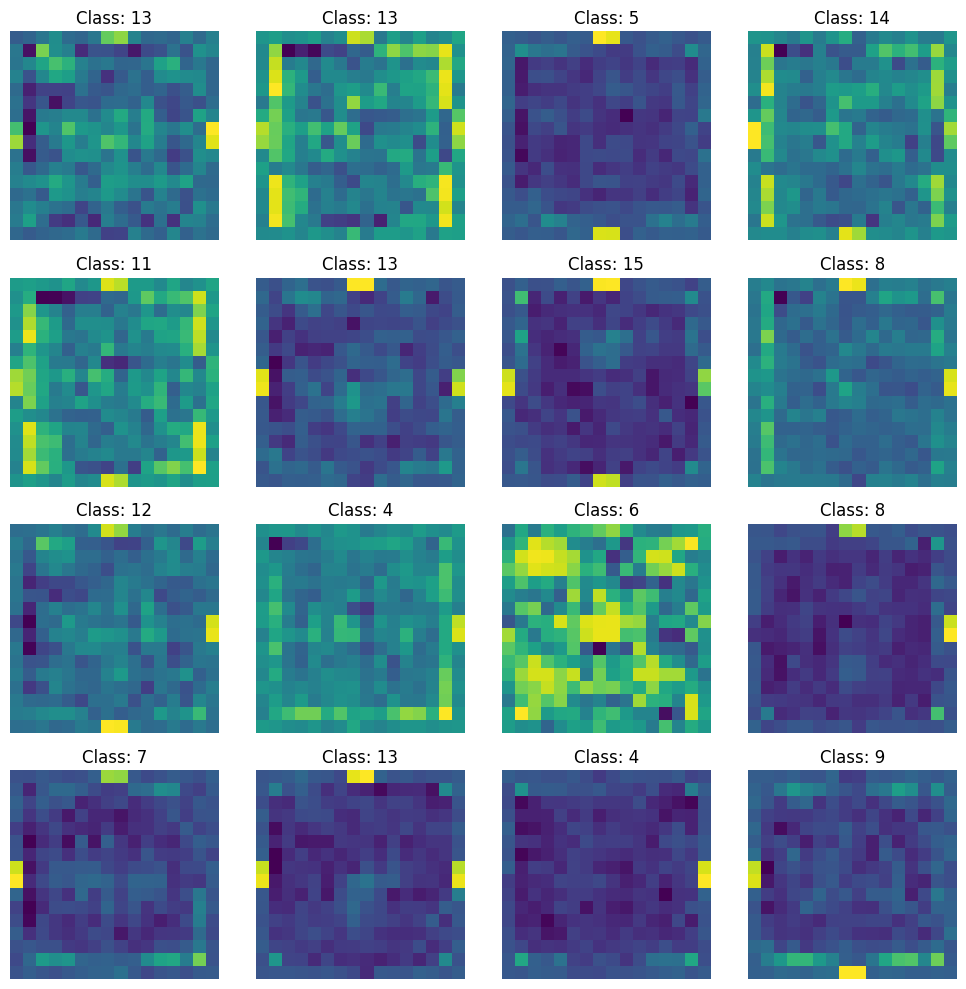

1/1 [==============================] - 0s 33ms/step
5700 [D loss: 0.16059469804167747 | D accuracy: 93.75] [G loss: 5.27596378326416]
1/1 [==============================] - 0s 31ms/step


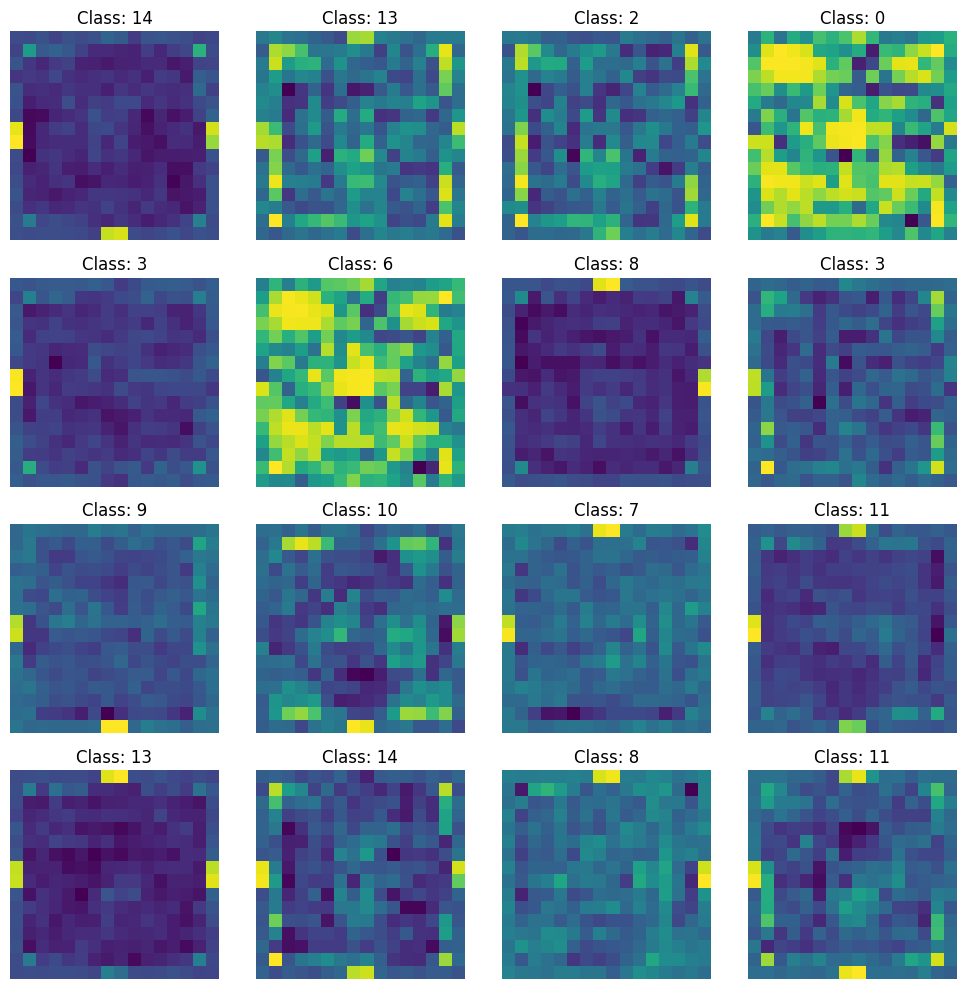

1/1 [==============================] - 0s 29ms/step
5800 [D loss: 0.05871575139462948 | D accuracy: 100.0] [G loss: 7.202146053314209]
1/1 [==============================] - 0s 27ms/step


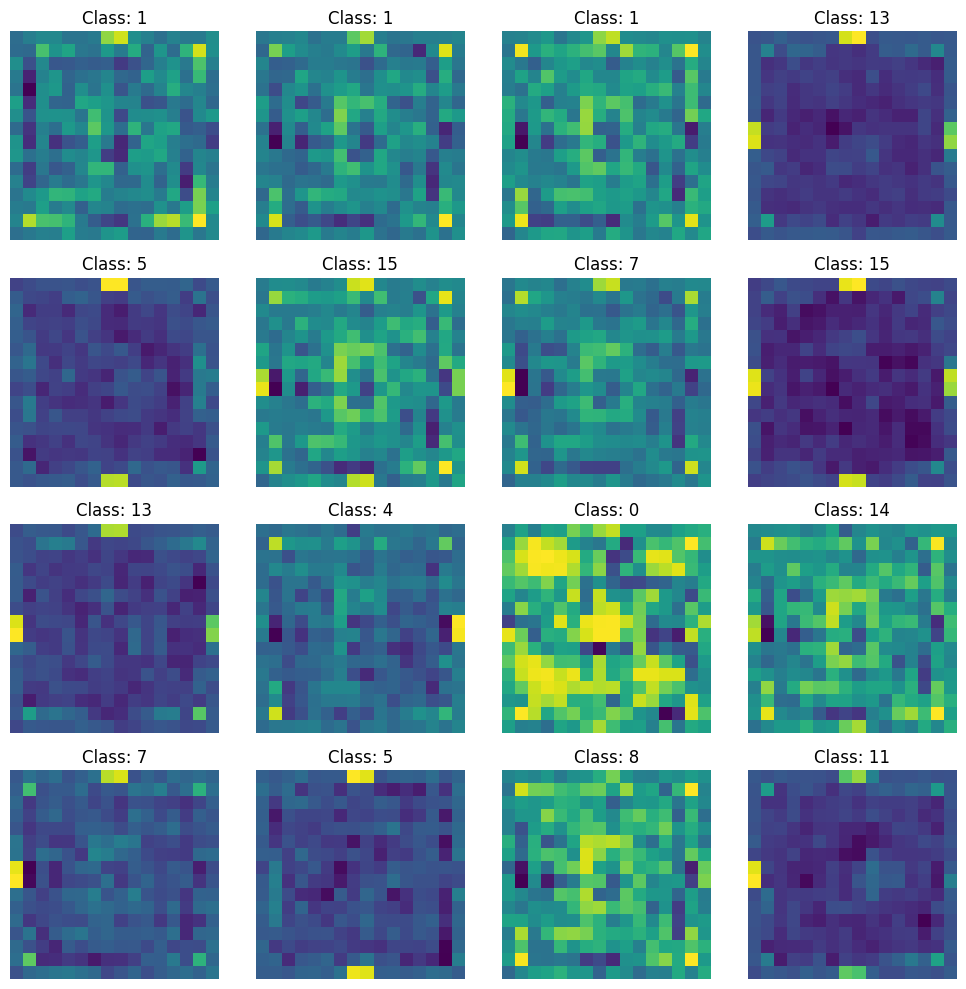

1/1 [==============================] - 0s 23ms/step
5900 [D loss: 0.24372779577970505 | D accuracy: 84.375] [G loss: 7.5132904052734375]
1/1 [==============================] - 0s 24ms/step


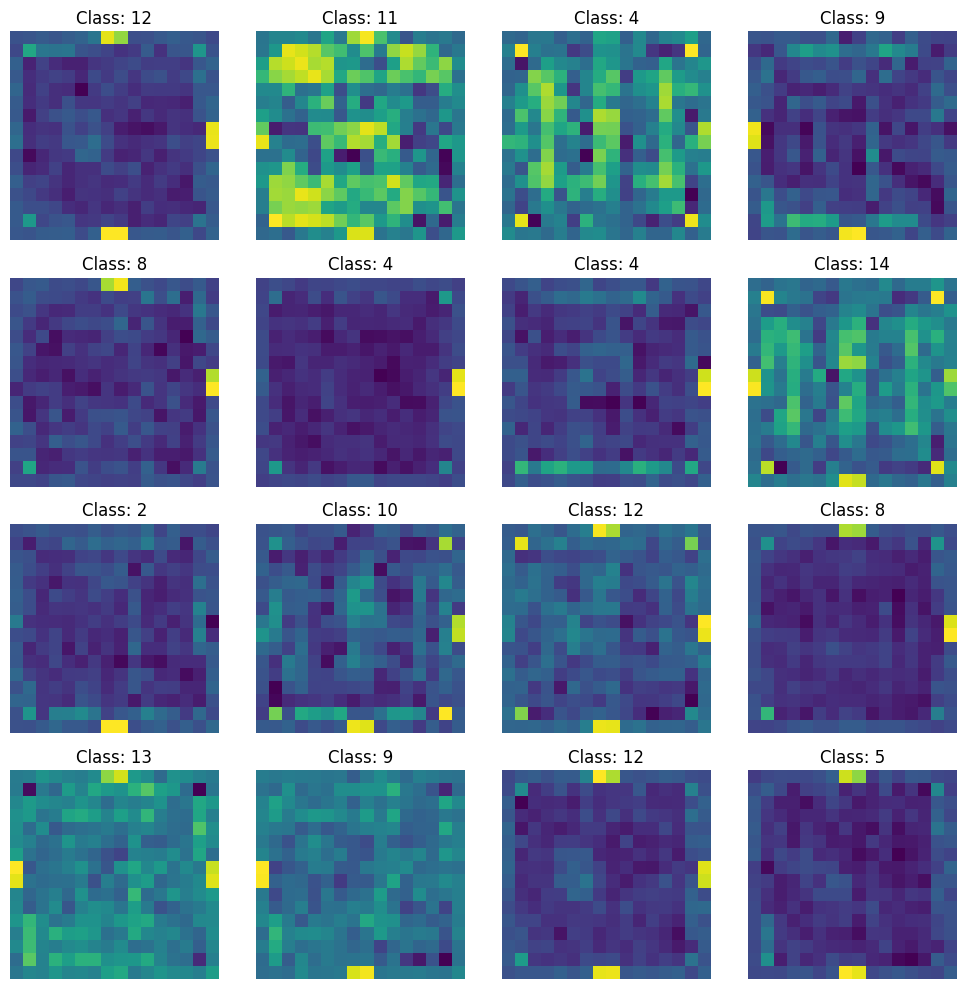

1/1 [==============================] - 0s 39ms/step
6000 [D loss: 0.12866009771823883 | D accuracy: 93.75] [G loss: 8.234088897705078]
1/1 [==============================] - 0s 31ms/step


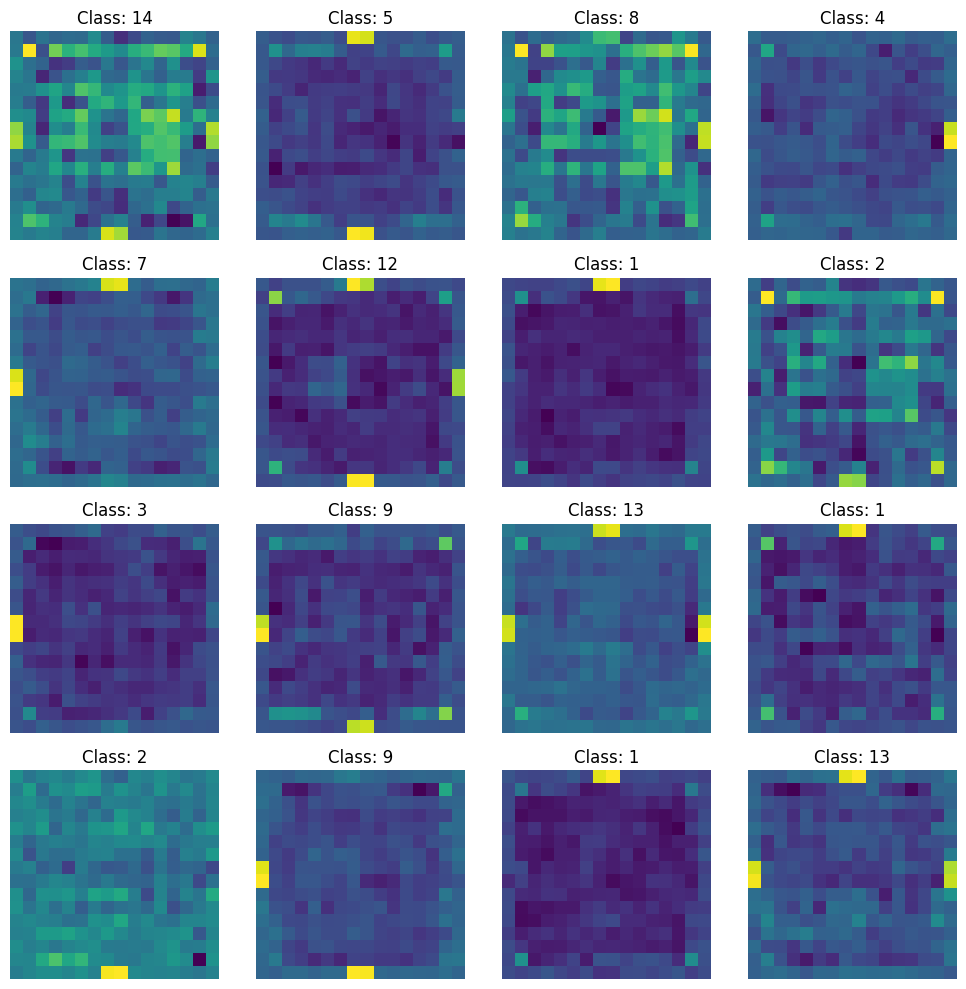

1/1 [==============================] - 0s 28ms/step
6100 [D loss: 0.26492317765951157 | D accuracy: 84.375] [G loss: 4.414113998413086]
1/1 [==============================] - 0s 27ms/step


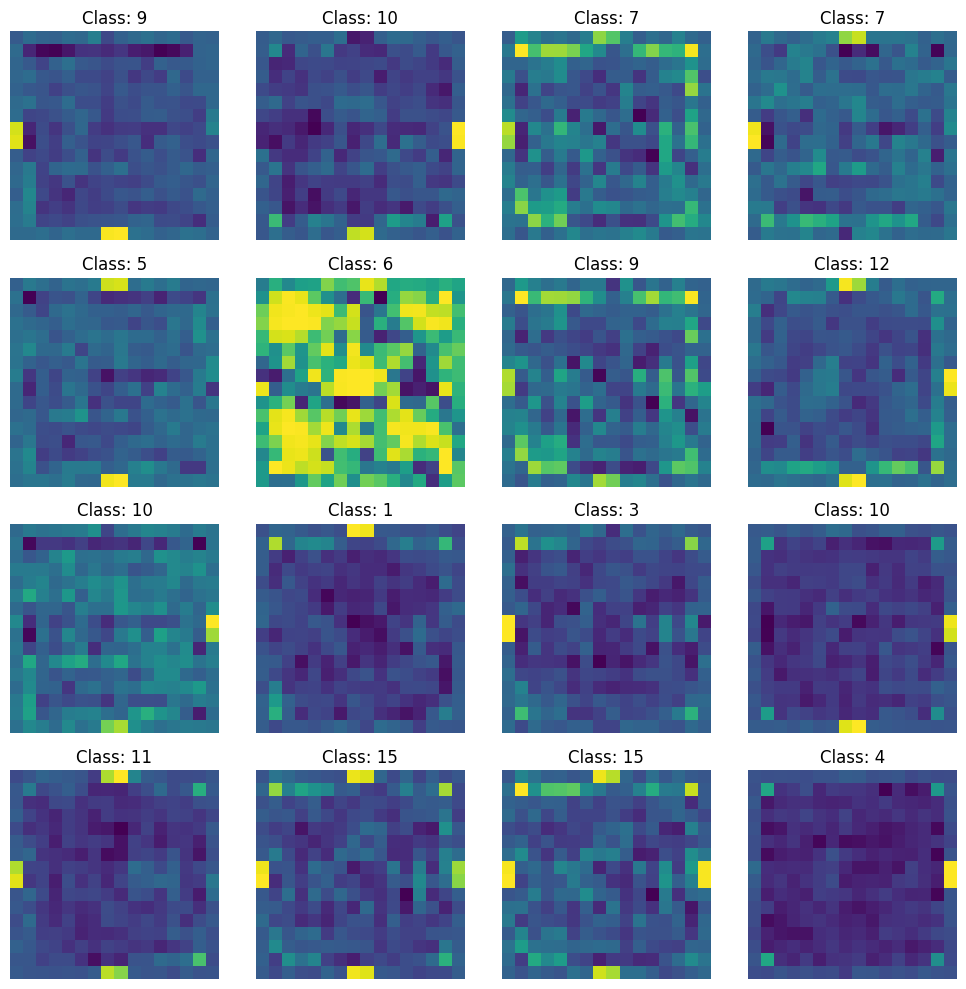

1/1 [==============================] - 0s 45ms/step
6200 [D loss: 0.36370567232370377 | D accuracy: 75.0] [G loss: 8.390408515930176]
1/1 [==============================] - 0s 45ms/step


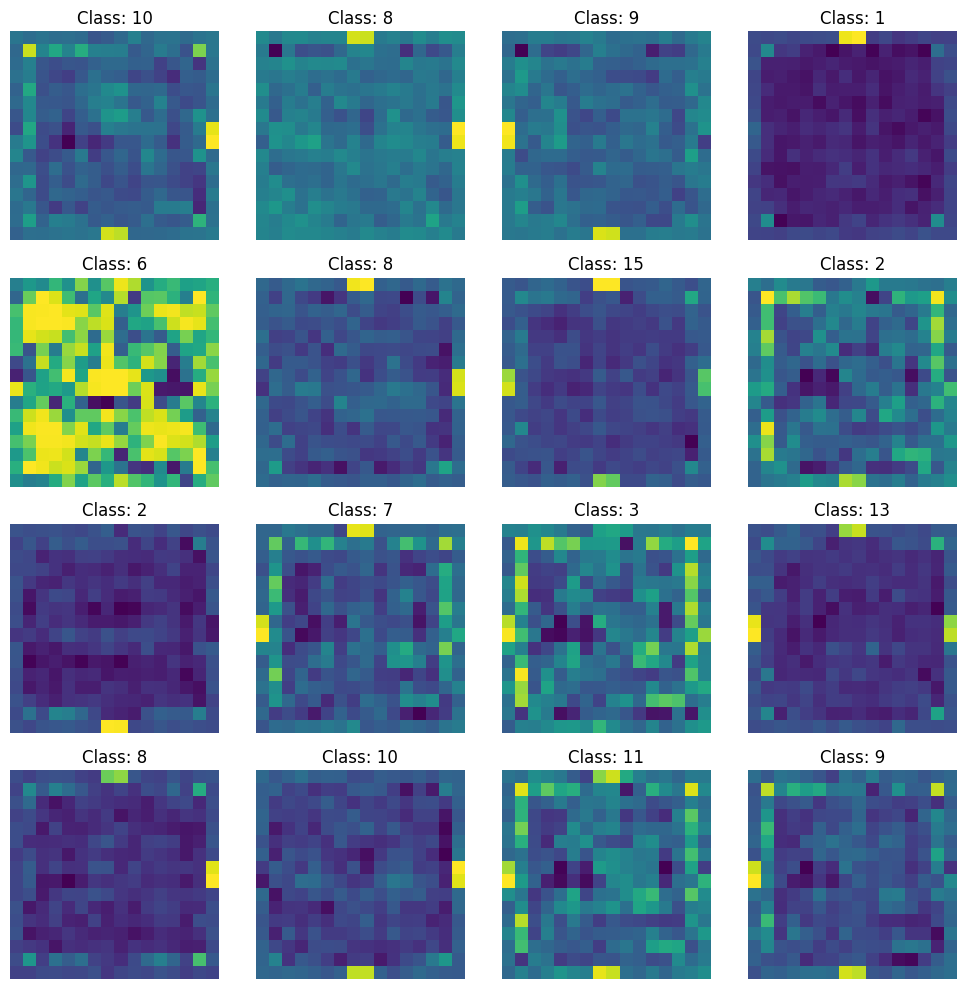

1/1 [==============================] - 0s 40ms/step
6300 [D loss: 0.11676513031125069 | D accuracy: 96.875] [G loss: 6.000907897949219]
1/1 [==============================] - 0s 33ms/step


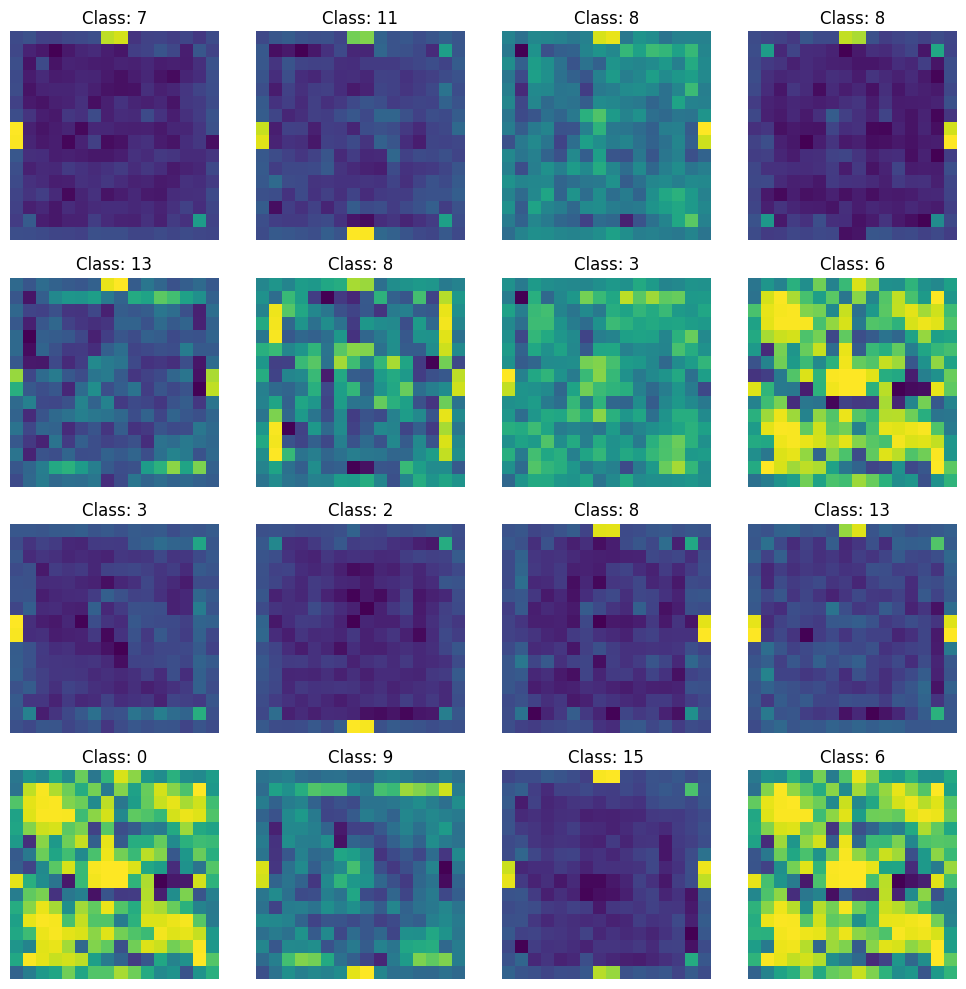

1/1 [==============================] - 0s 51ms/step
6400 [D loss: 0.1318032145500183 | D accuracy: 93.75] [G loss: 6.115048408508301]
1/1 [==============================] - 0s 65ms/step


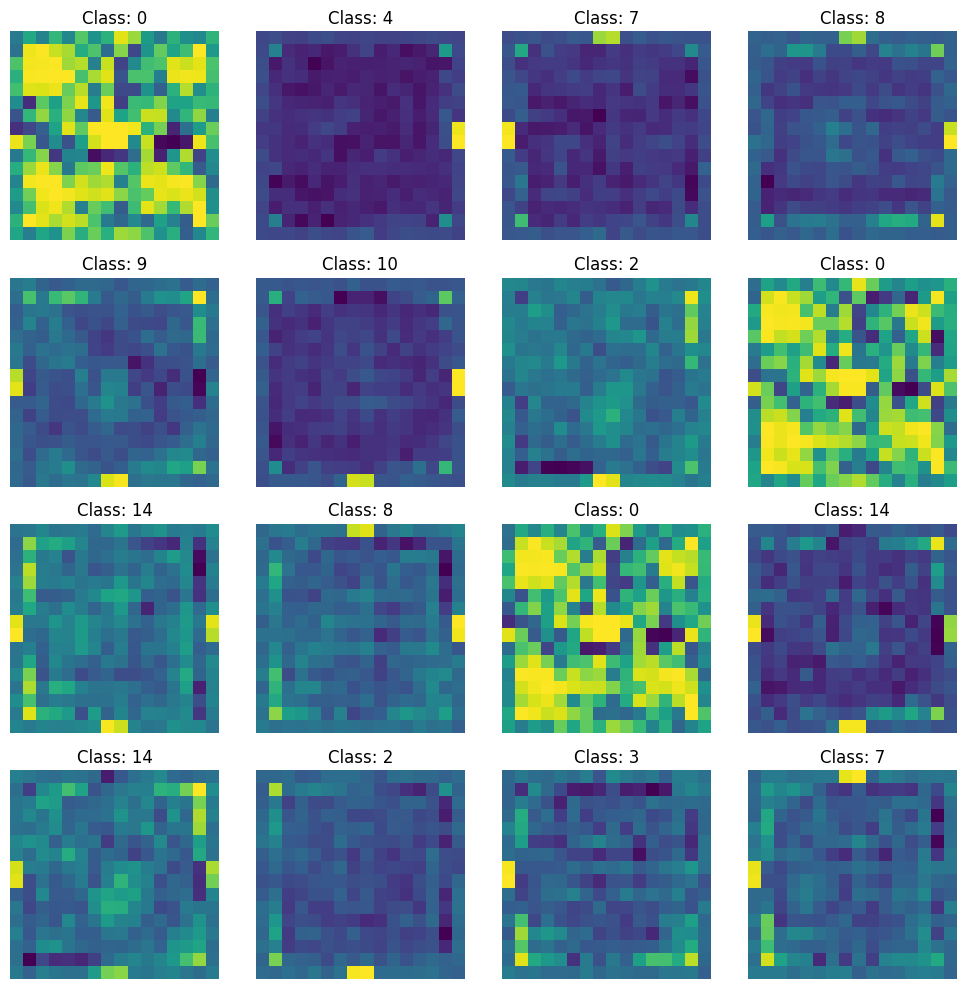

1/1 [==============================] - 0s 25ms/step
6500 [D loss: 0.227906234562397 | D accuracy: 87.5] [G loss: 7.144206523895264]
1/1 [==============================] - 0s 38ms/step


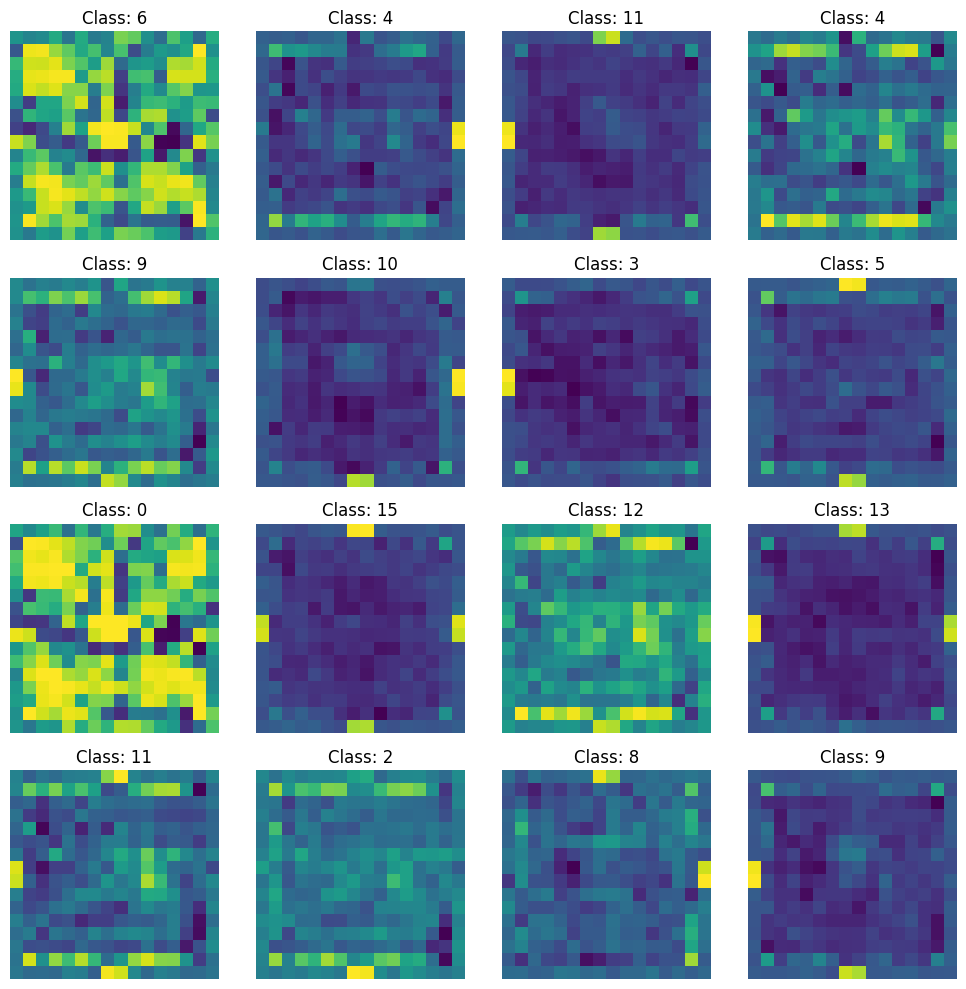

1/1 [==============================] - 0s 47ms/step
6600 [D loss: 0.25633446872234344 | D accuracy: 84.375] [G loss: 3.2359814643859863]
1/1 [==============================] - 0s 69ms/step


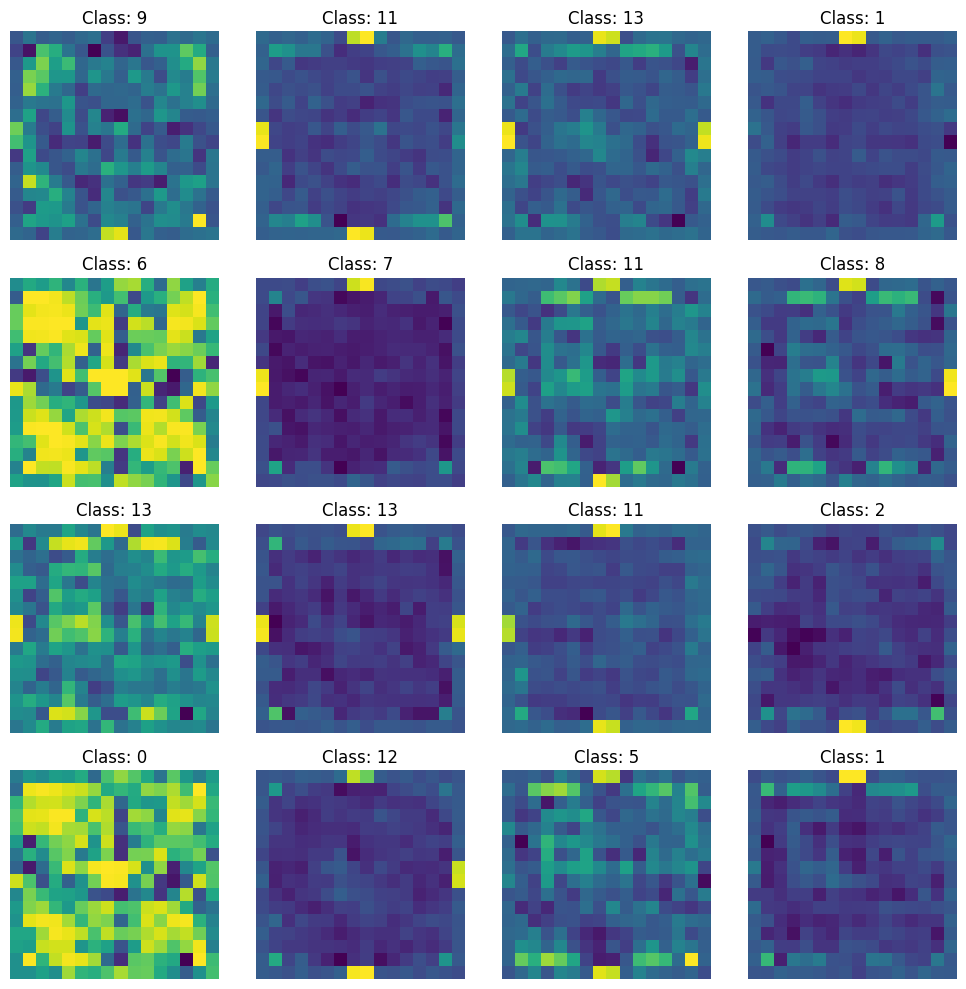

1/1 [==============================] - 0s 53ms/step
6700 [D loss: 0.18161870539188385 | D accuracy: 93.75] [G loss: 3.0834853649139404]
1/1 [==============================] - 0s 32ms/step


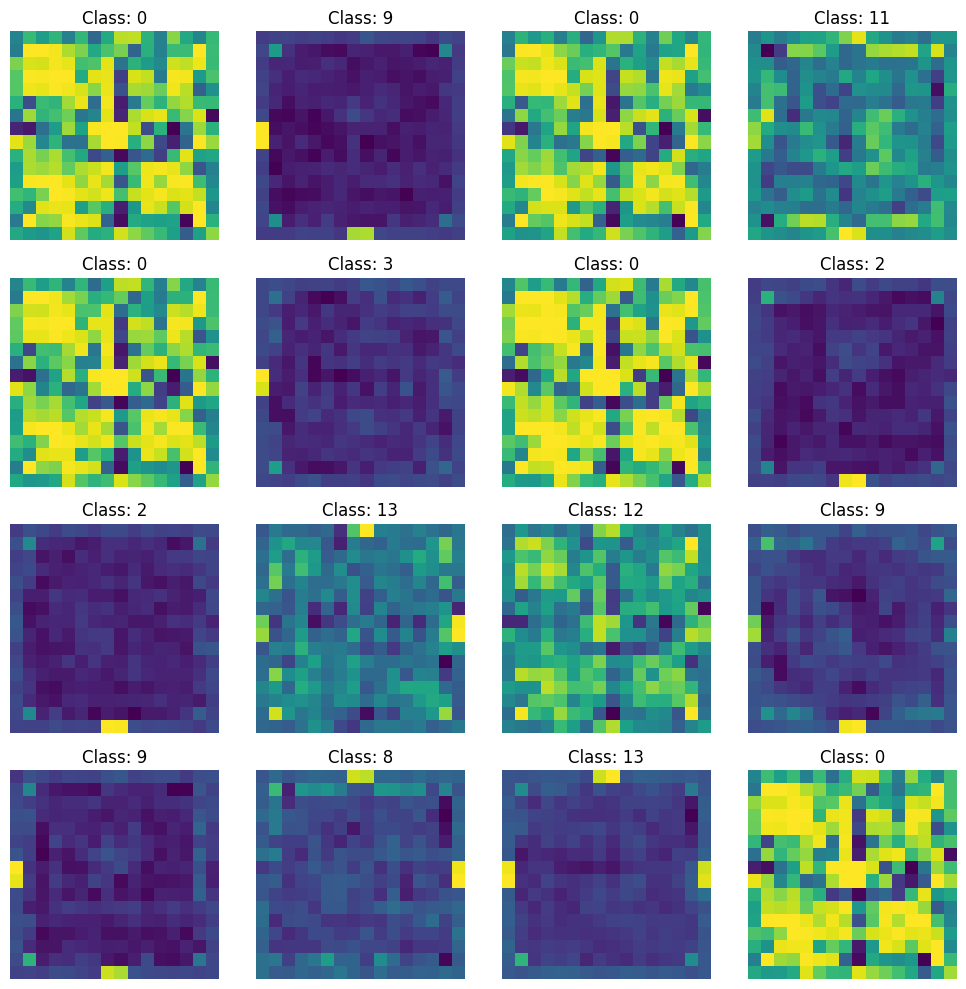

1/1 [==============================] - 0s 29ms/step
6800 [D loss: 0.12231684476137161 | D accuracy: 93.75] [G loss: 6.340599060058594]
1/1 [==============================] - 0s 28ms/step


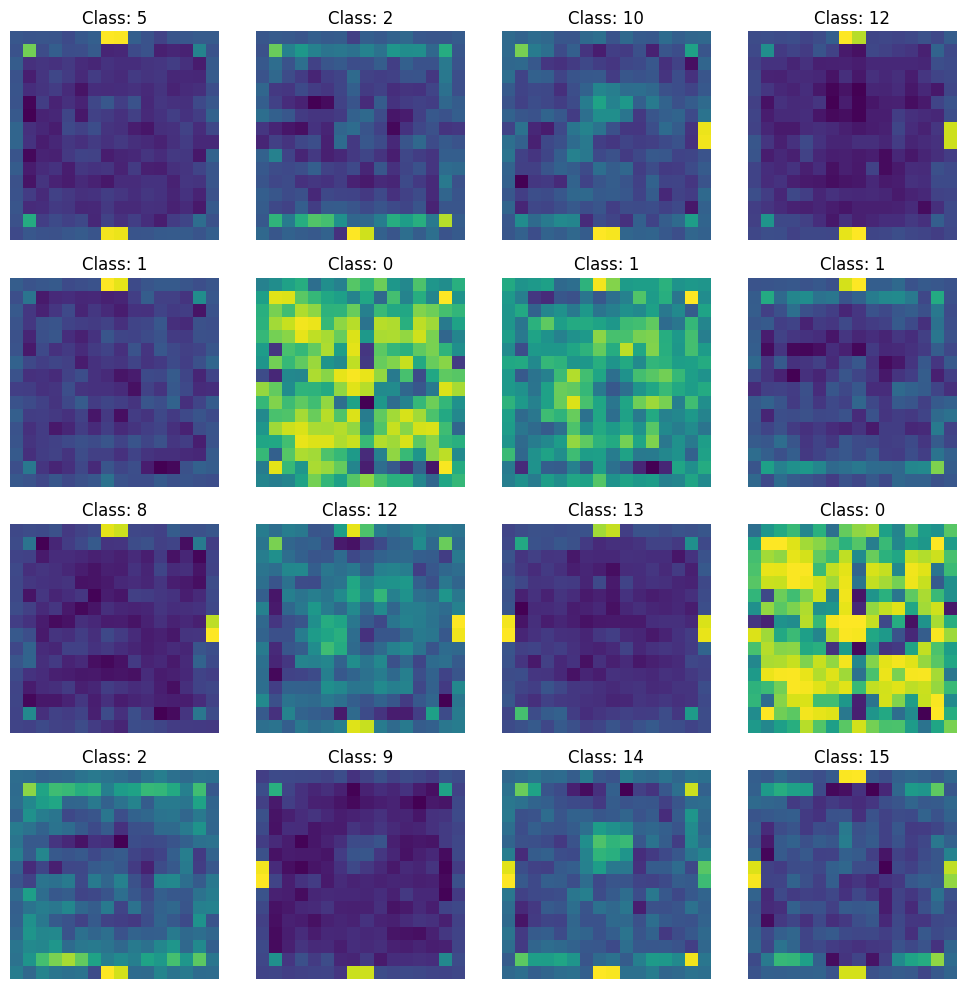

1/1 [==============================] - 0s 25ms/step
6900 [D loss: 0.0416370015591383 | D accuracy: 100.0] [G loss: 6.461457252502441]
1/1 [==============================] - 0s 25ms/step


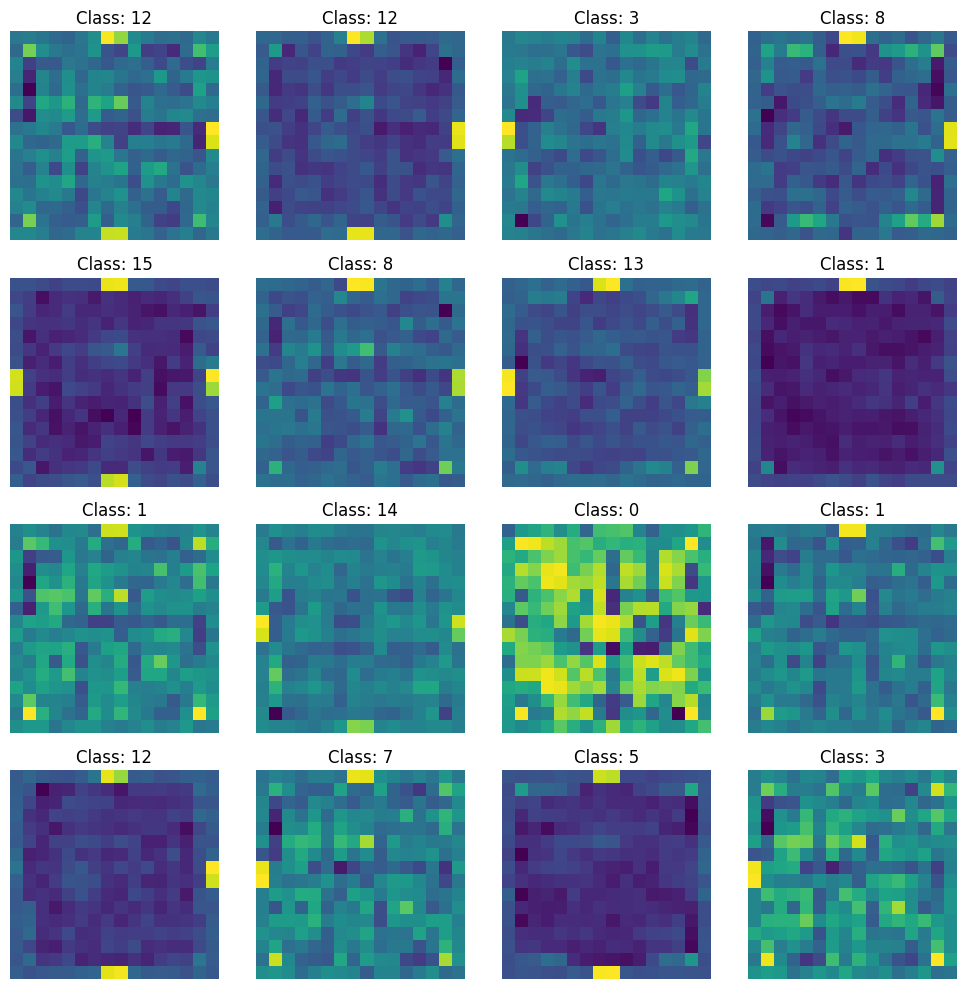

1/1 [==============================] - 0s 52ms/step
7000 [D loss: 0.04414351191371679 | D accuracy: 100.0] [G loss: 7.914711952209473]
1/1 [==============================] - 0s 42ms/step


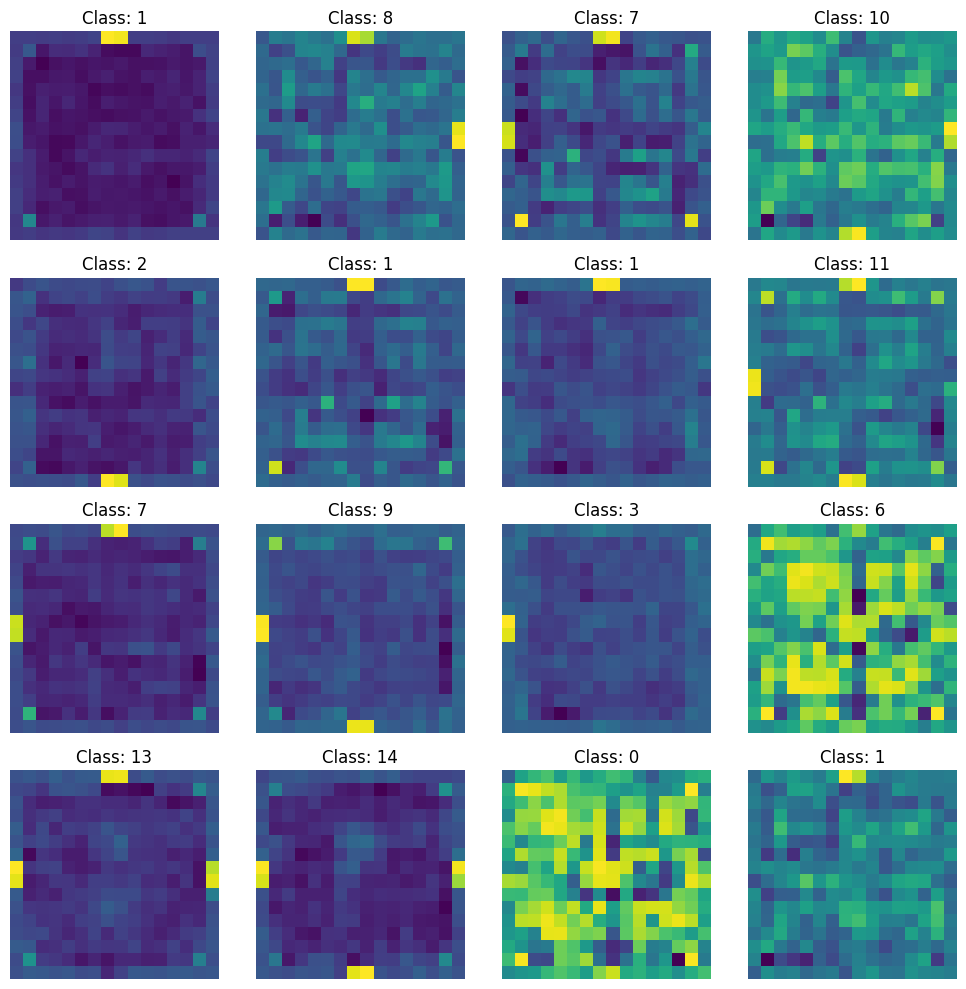

1/1 [==============================] - 0s 32ms/step
7100 [D loss: 0.2110656350851059 | D accuracy: 90.625] [G loss: 4.946672439575195]
1/1 [==============================] - 0s 28ms/step


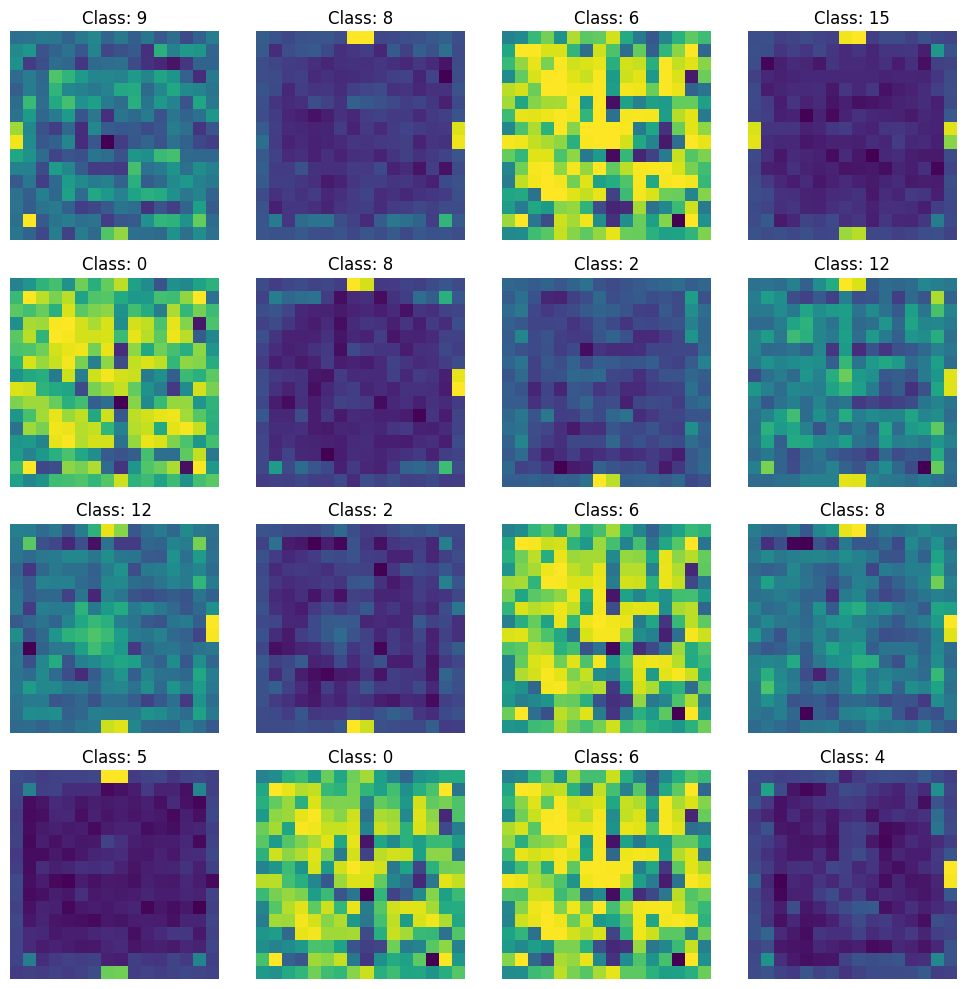

1/1 [==============================] - 0s 39ms/step
7200 [D loss: 0.20334196090698242 | D accuracy: 93.75] [G loss: 6.443602561950684]
1/1 [==============================] - 0s 62ms/step


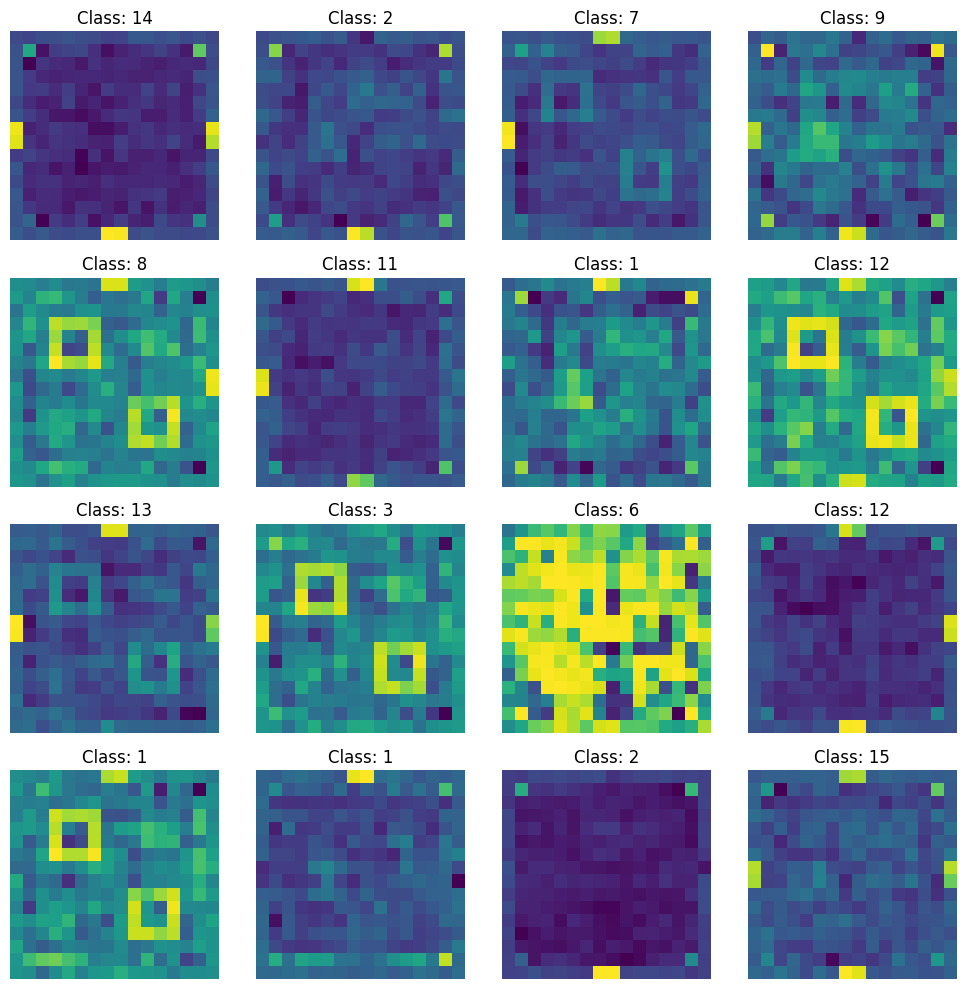

1/1 [==============================] - 0s 36ms/step
7300 [D loss: 0.16670282557606697 | D accuracy: 93.75] [G loss: 4.307638168334961]
1/1 [==============================] - 0s 47ms/step


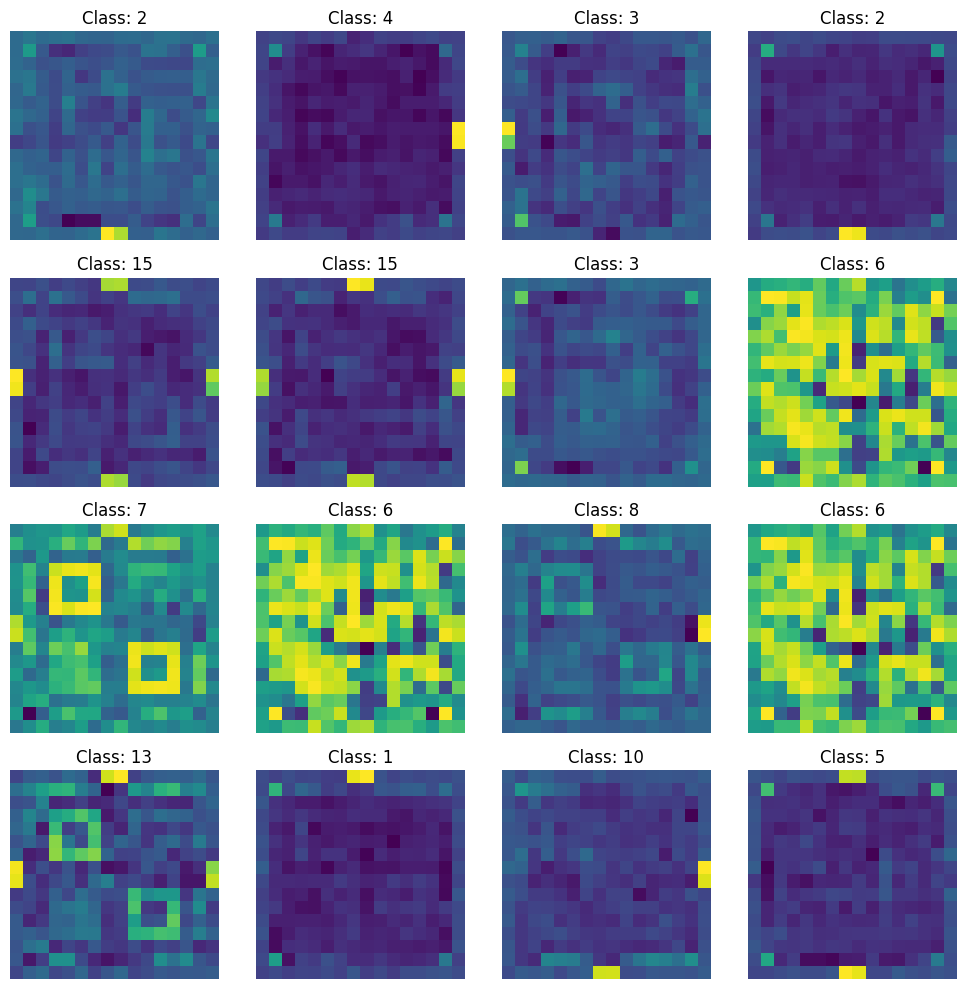

1/1 [==============================] - 0s 34ms/step
7400 [D loss: 0.258722260594368 | D accuracy: 87.5] [G loss: 6.3864850997924805]
1/1 [==============================] - 0s 36ms/step


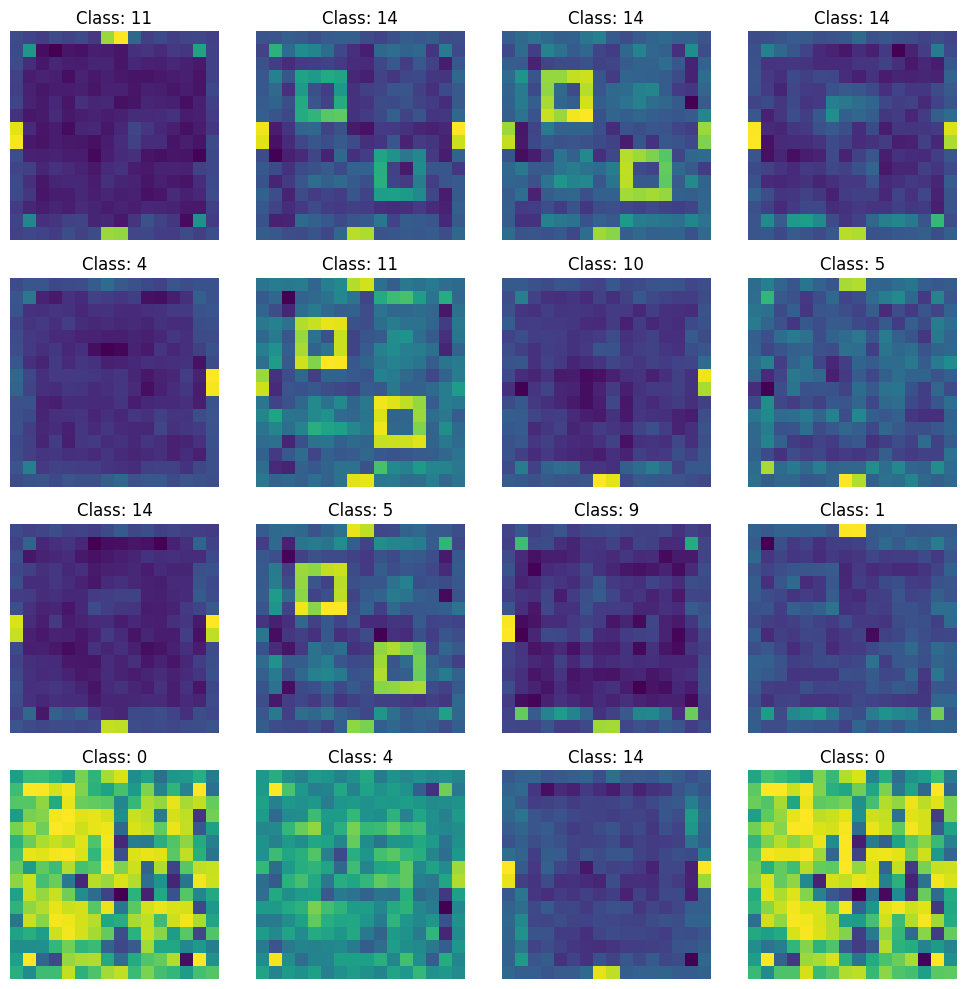

1/1 [==============================] - 0s 25ms/step
7500 [D loss: 0.14304714649915695 | D accuracy: 93.75] [G loss: 7.311528205871582]
1/1 [==============================] - 0s 27ms/step


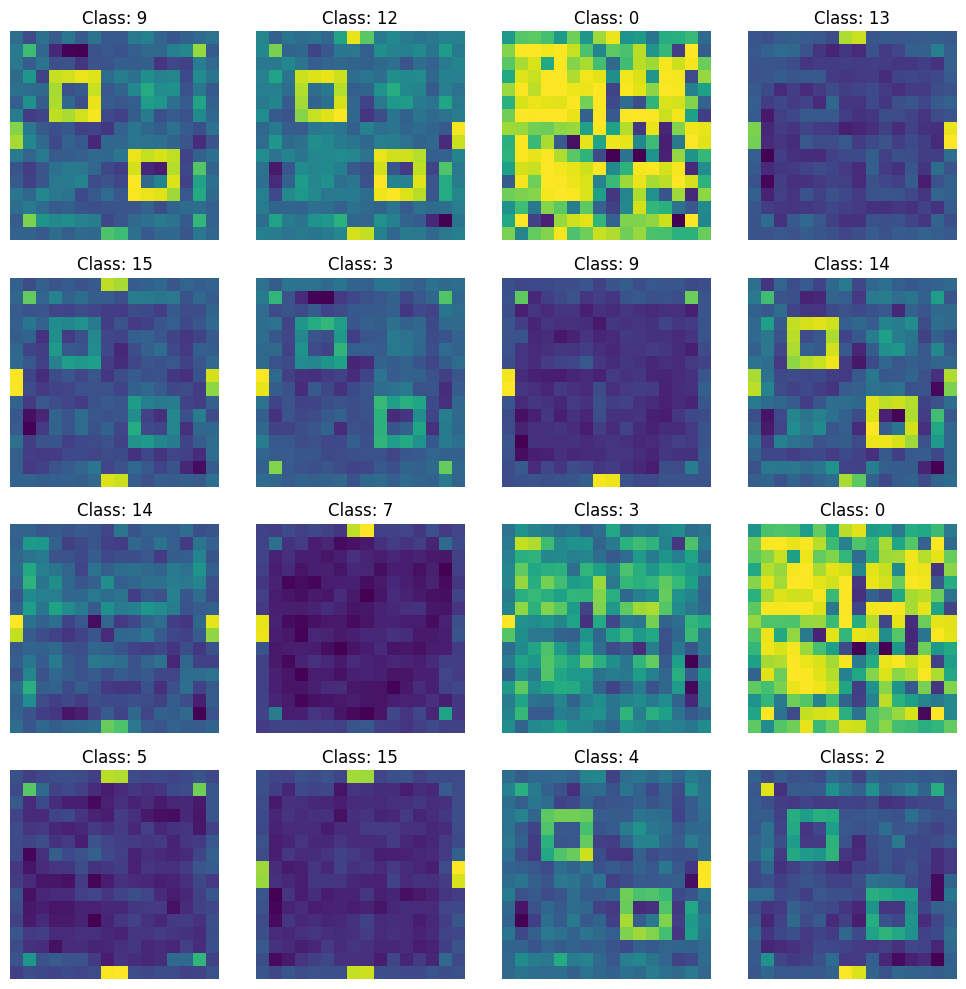

1/1 [==============================] - 0s 49ms/step
7600 [D loss: 0.216798335313797 | D accuracy: 90.625] [G loss: 5.191727161407471]
1/1 [==============================] - 0s 37ms/step


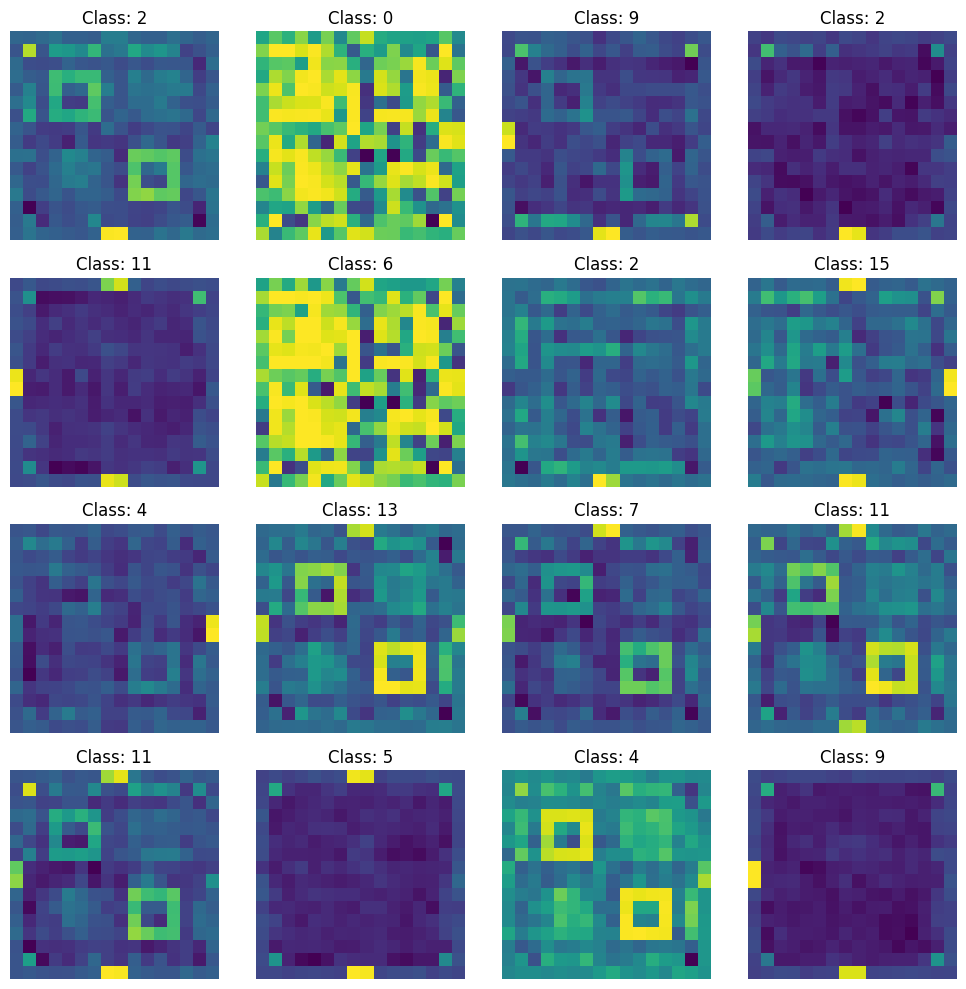

1/1 [==============================] - 0s 33ms/step
7700 [D loss: 0.30465470254421234 | D accuracy: 84.375] [G loss: 7.336950778961182]
1/1 [==============================] - 0s 33ms/step


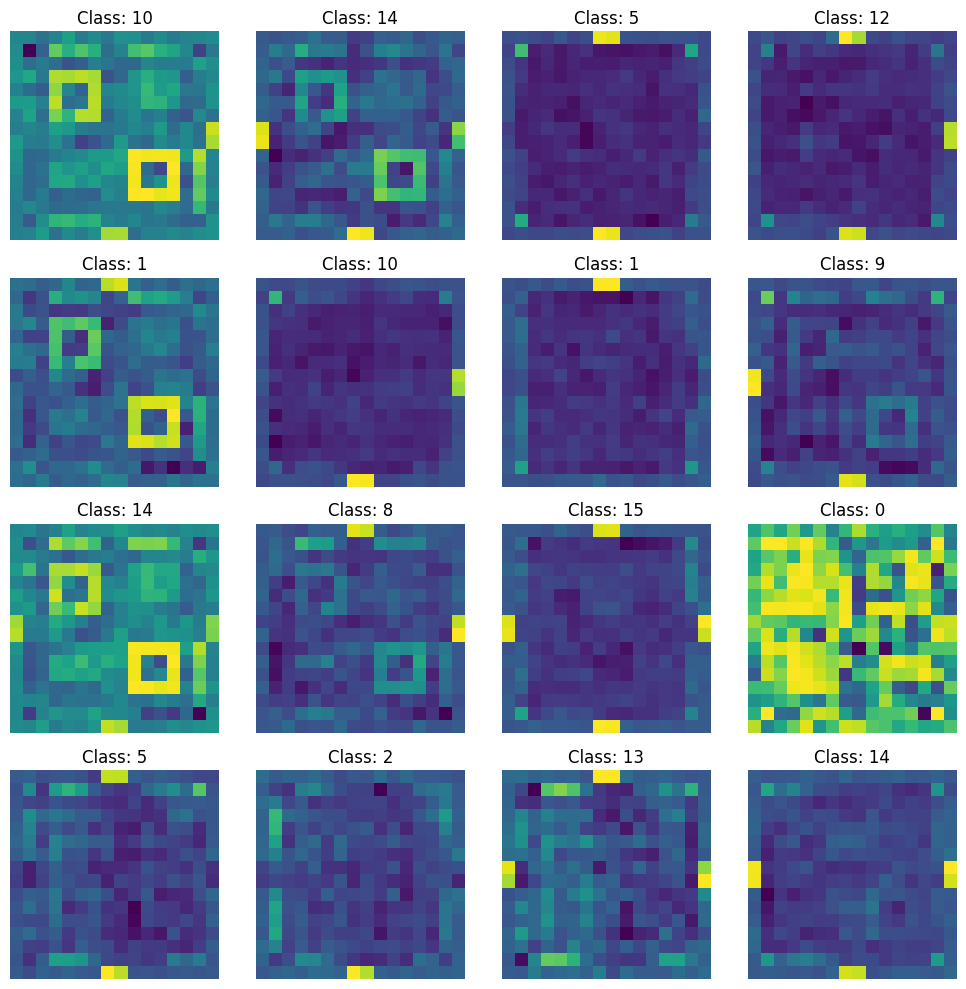

1/1 [==============================] - 0s 51ms/step
7800 [D loss: 0.07643398642539978 | D accuracy: 96.875] [G loss: 4.378957748413086]
1/1 [==============================] - 0s 42ms/step


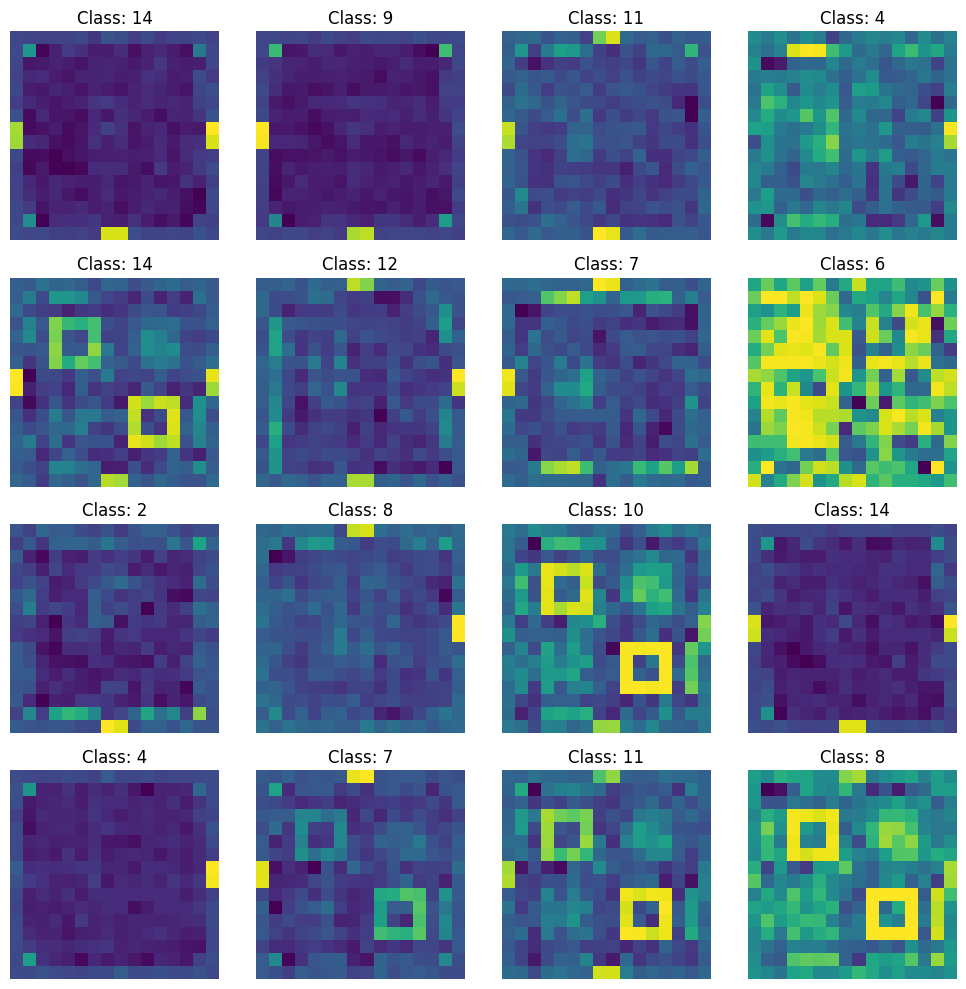

1/1 [==============================] - 0s 26ms/step
7900 [D loss: 0.07503685913980007 | D accuracy: 100.0] [G loss: 4.742111682891846]
1/1 [==============================] - 0s 26ms/step


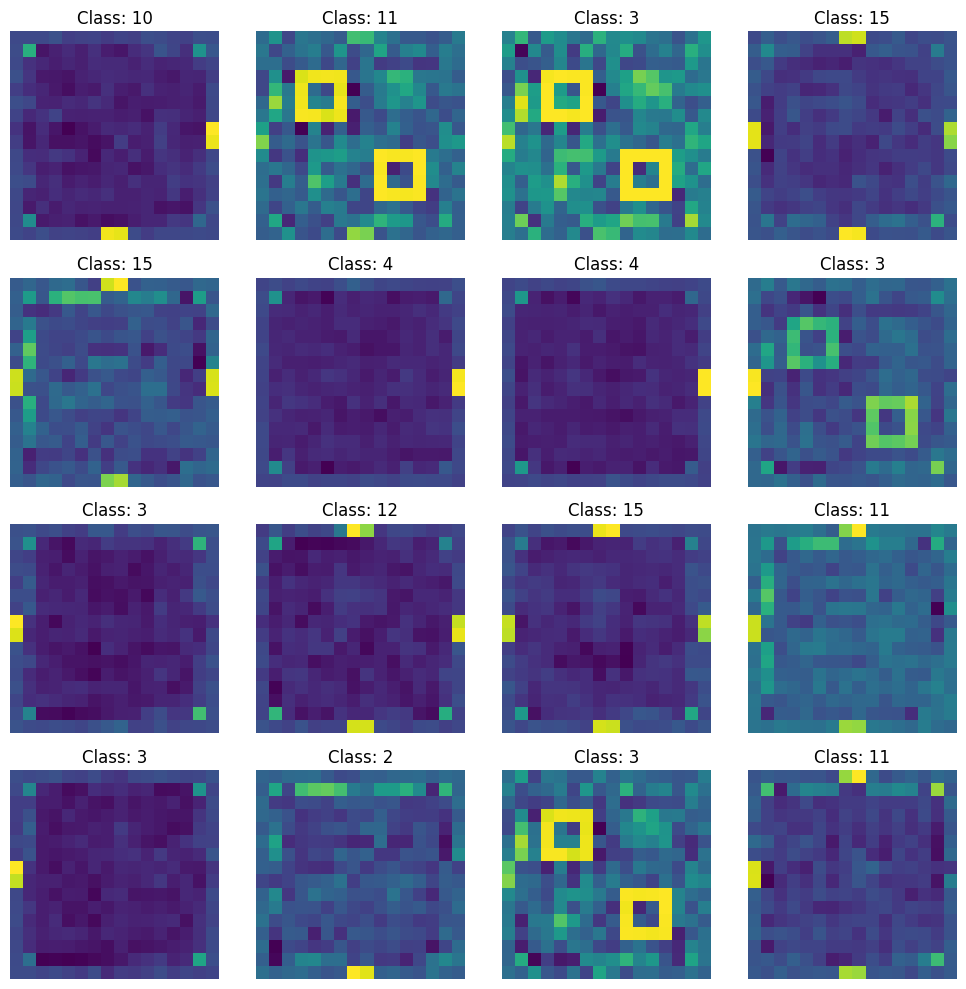

1/1 [==============================] - 0s 24ms/step
8000 [D loss: 0.1957638319581747 | D accuracy: 87.5] [G loss: 5.806070327758789]
1/1 [==============================] - 0s 23ms/step


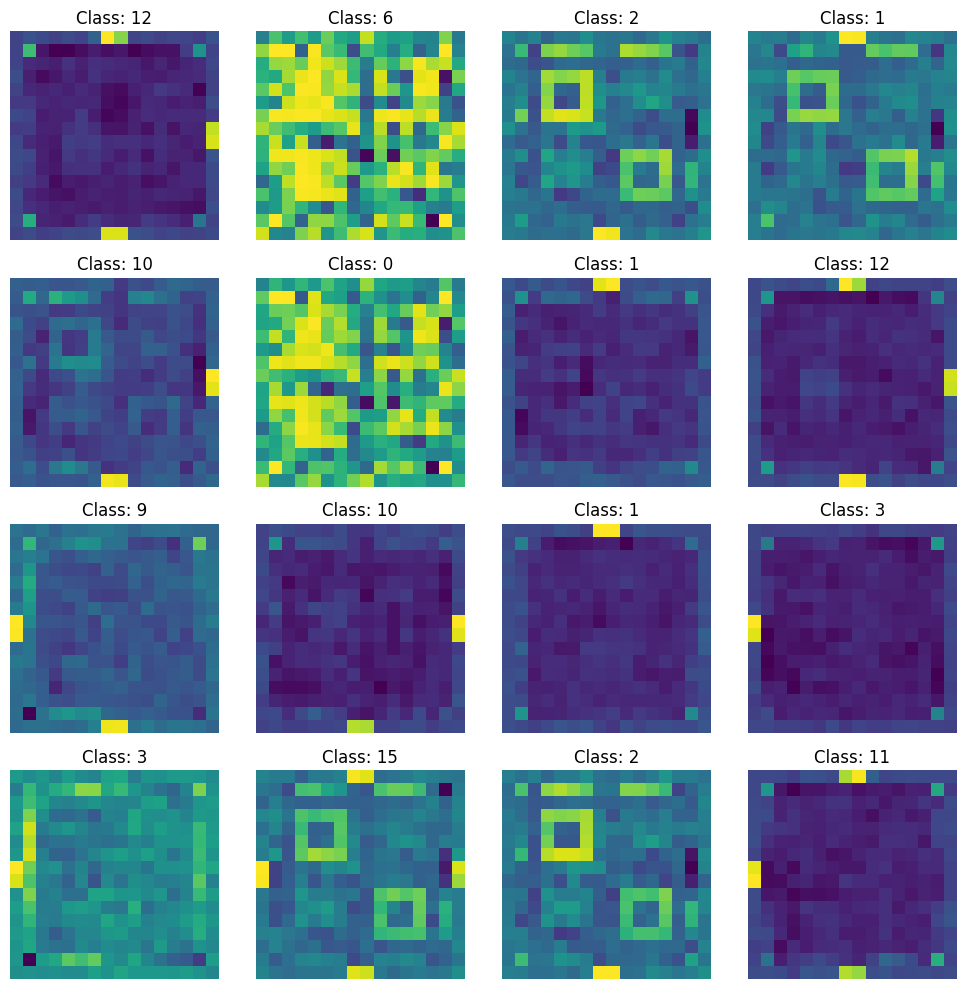

1/1 [==============================] - 0s 31ms/step
8100 [D loss: 0.3383442796766758 | D accuracy: 87.5] [G loss: 4.06053352355957]
1/1 [==============================] - 0s 42ms/step


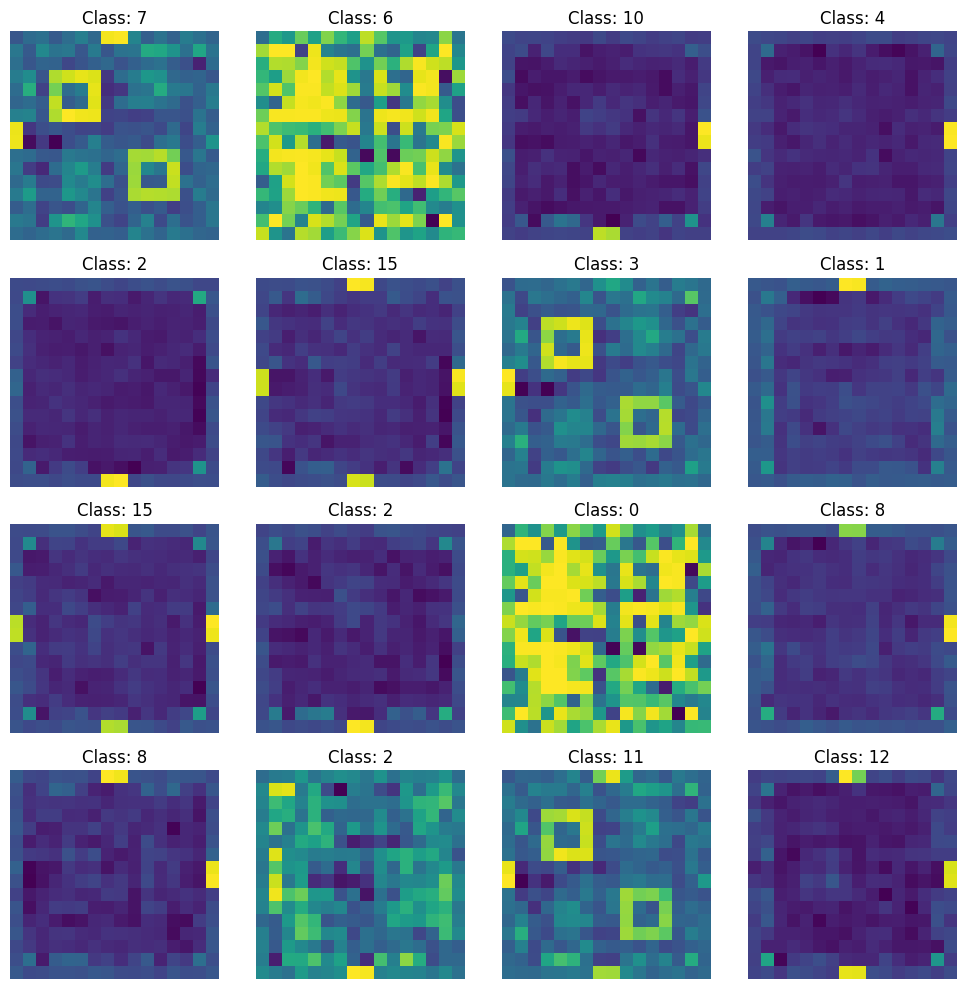

1/1 [==============================] - 0s 48ms/step
8200 [D loss: 0.07434120401740074 | D accuracy: 96.875] [G loss: 7.3316826820373535]
1/1 [==============================] - 0s 62ms/step


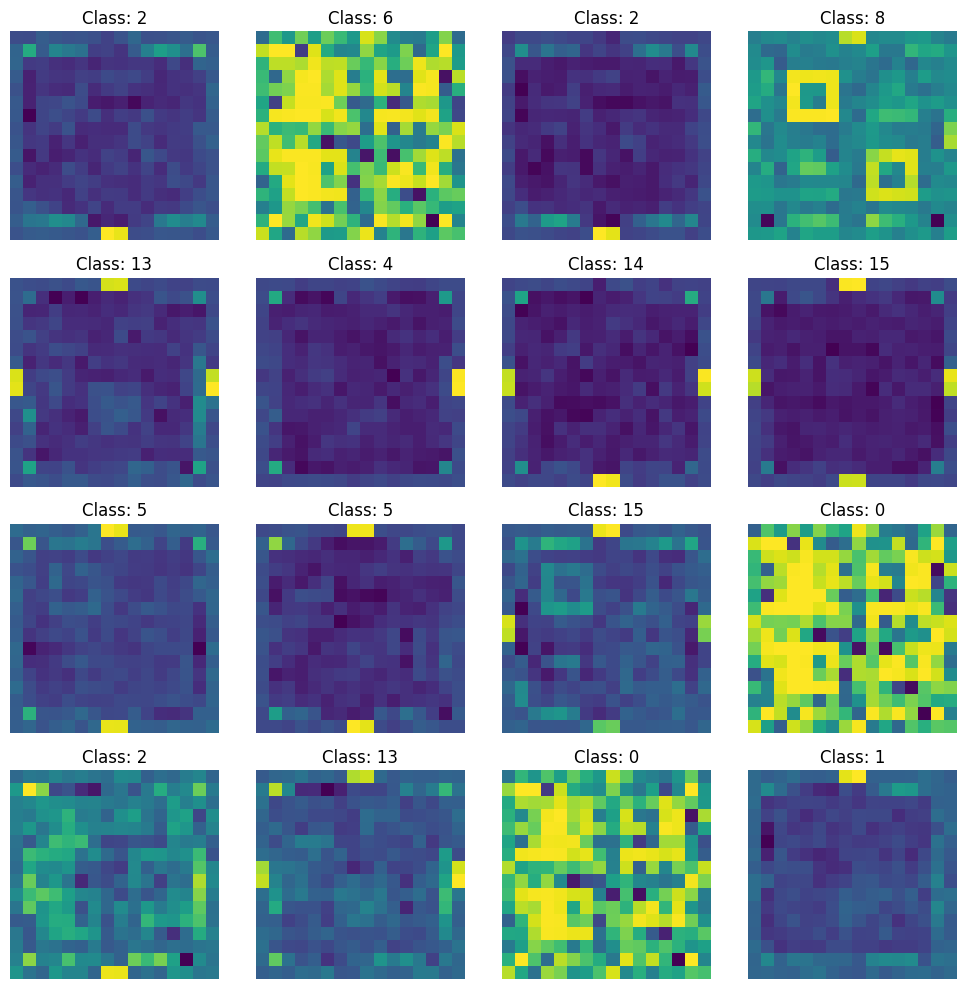

1/1 [==============================] - 0s 25ms/step
8300 [D loss: 0.13228943571448326 | D accuracy: 93.75] [G loss: 4.073081970214844]
1/1 [==============================] - 0s 24ms/step


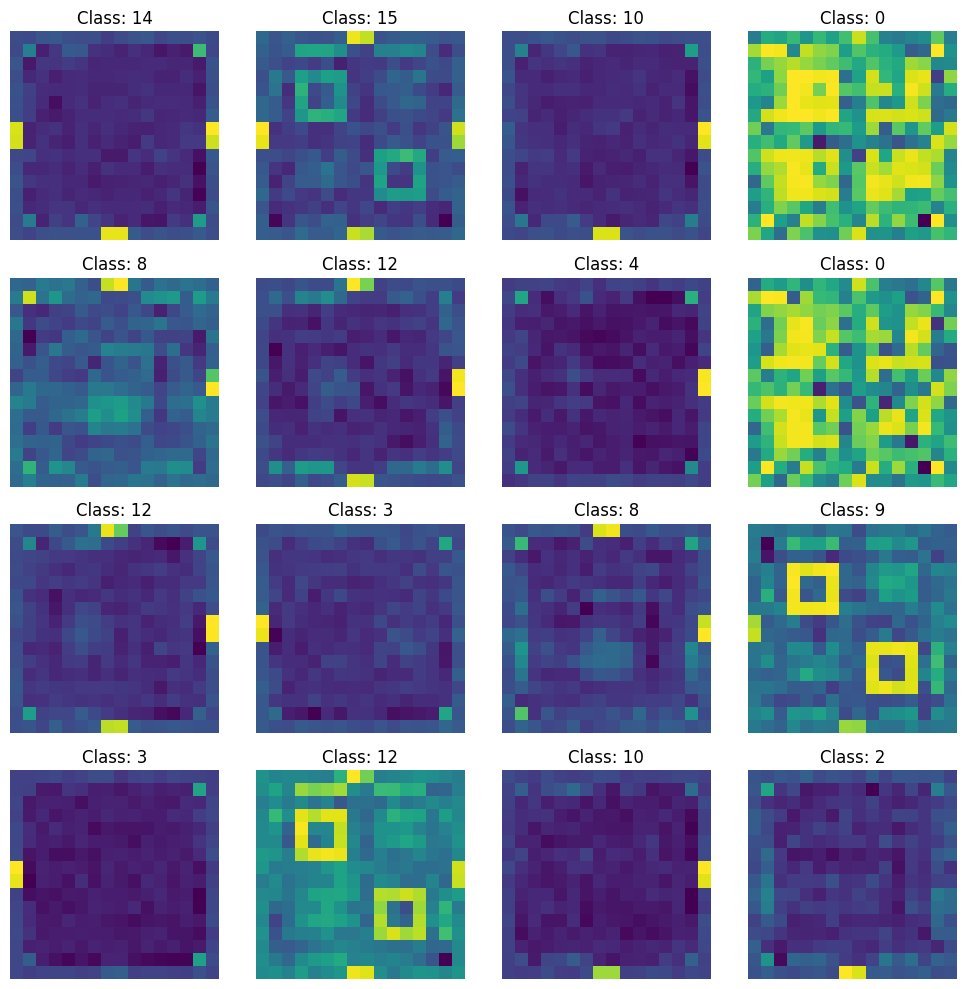

1/1 [==============================] - 0s 60ms/step
8400 [D loss: 0.10877407714724541 | D accuracy: 96.875] [G loss: 6.229233741760254]
1/1 [==============================] - 0s 65ms/step


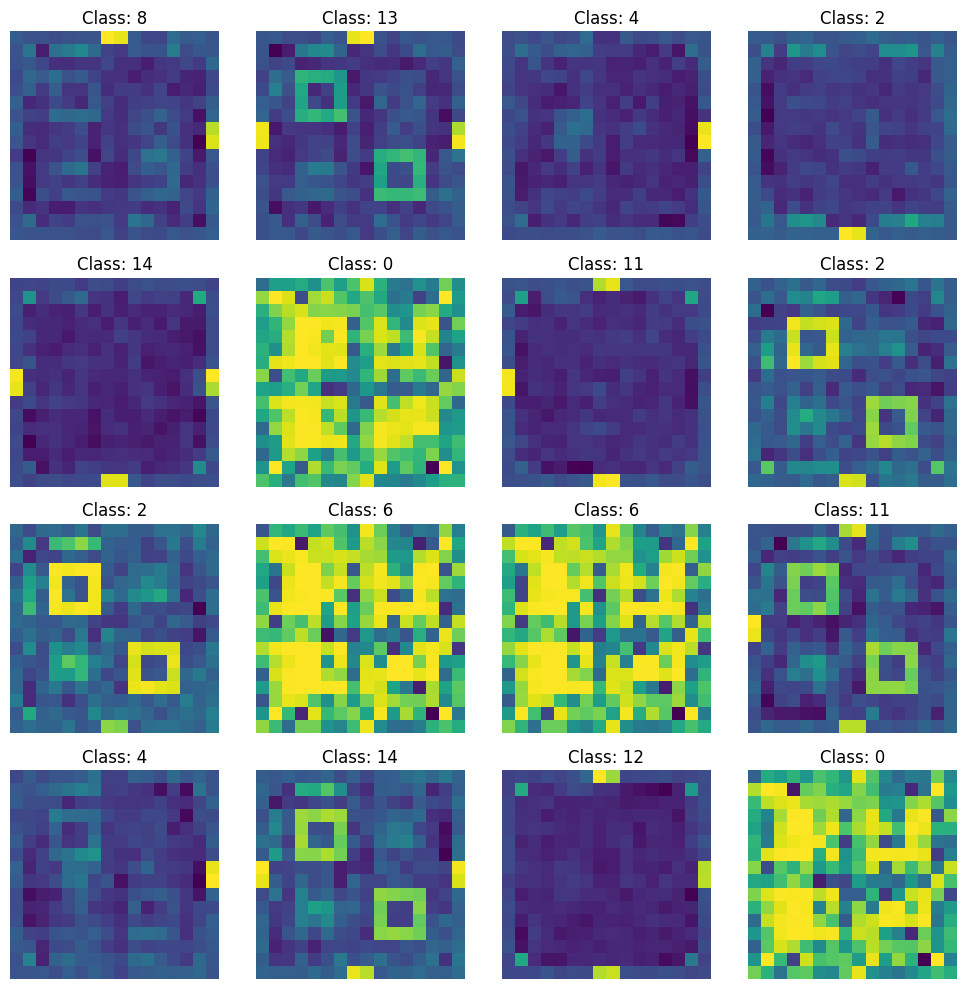

1/1 [==============================] - 0s 35ms/step
8500 [D loss: 0.16024668514728546 | D accuracy: 93.75] [G loss: 6.9073166847229]
1/1 [==============================] - 0s 38ms/step


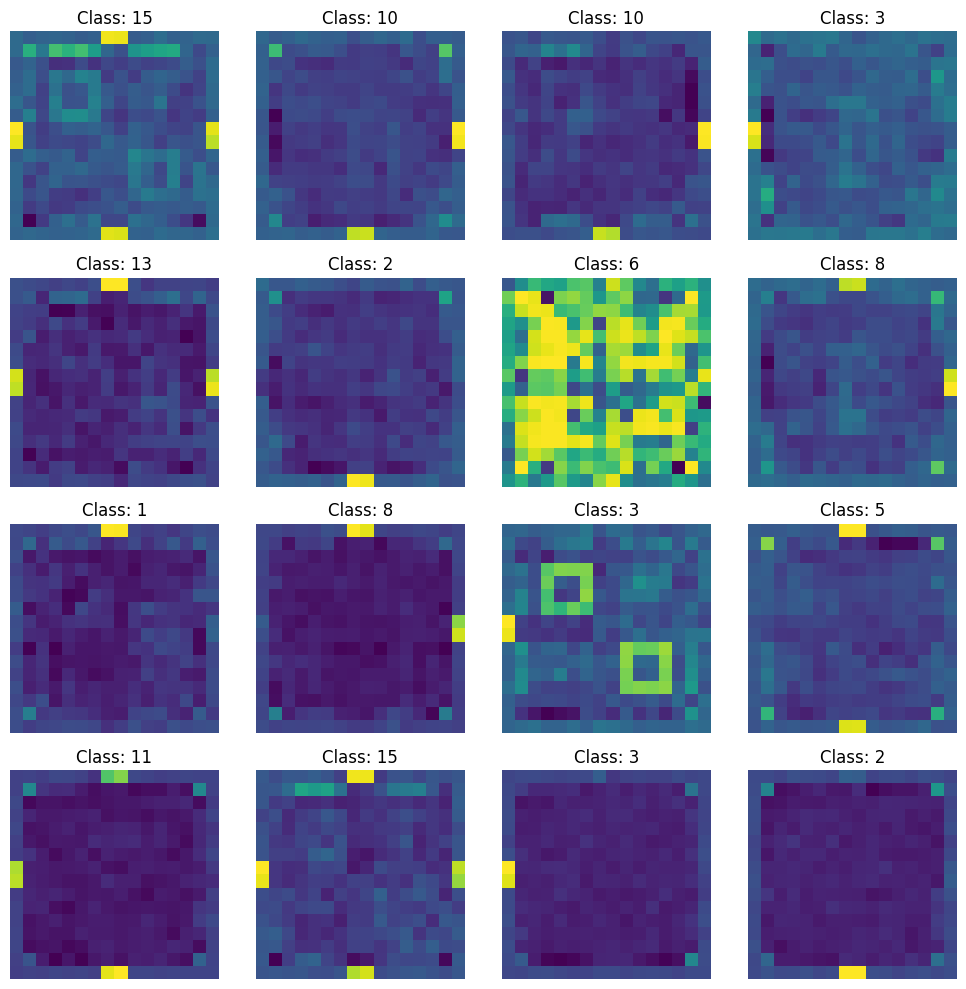

1/1 [==============================] - 0s 37ms/step
8600 [D loss: 0.10094983270391822 | D accuracy: 100.0] [G loss: 5.699402809143066]
1/1 [==============================] - 0s 39ms/step


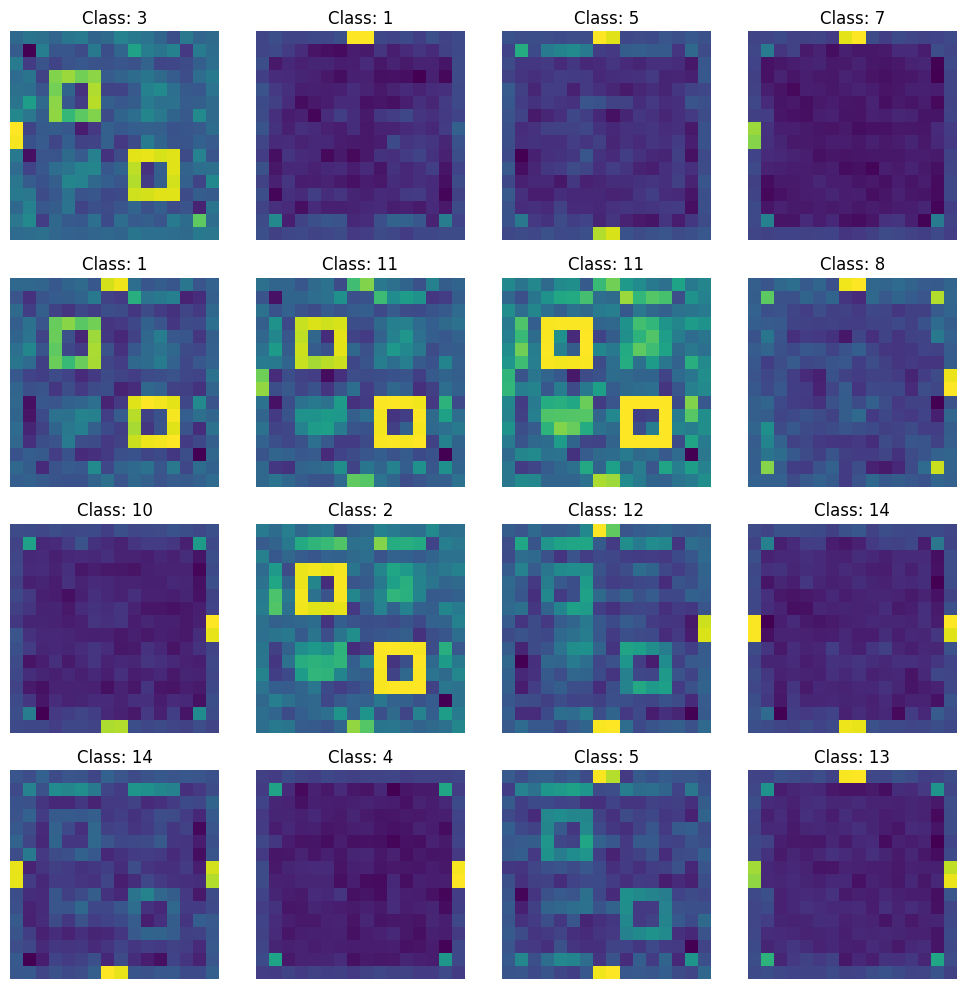

1/1 [==============================] - 0s 26ms/step
8700 [D loss: 0.18772470578551292 | D accuracy: 90.625] [G loss: 5.127763748168945]
1/1 [==============================] - 0s 26ms/step


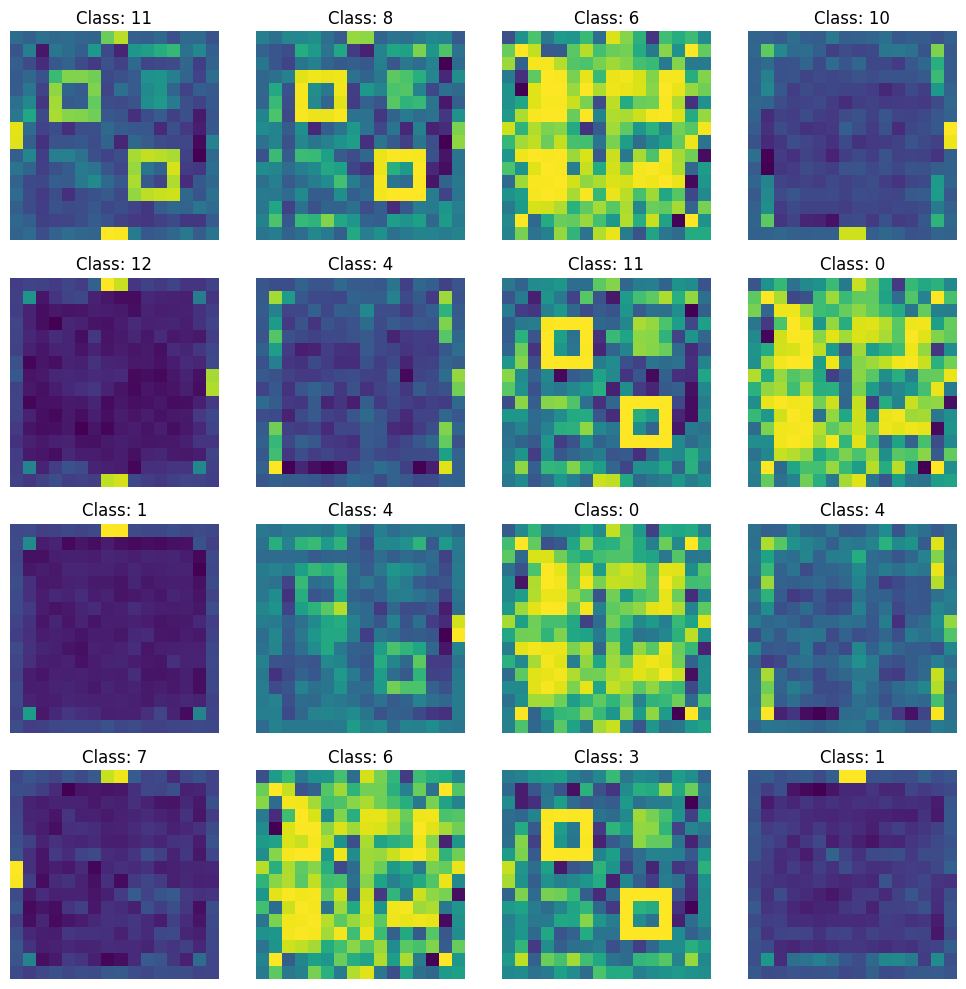

1/1 [==============================] - 0s 52ms/step
8800 [D loss: 0.22645720839500427 | D accuracy: 87.5] [G loss: 5.047023773193359]
1/1 [==============================] - 0s 57ms/step


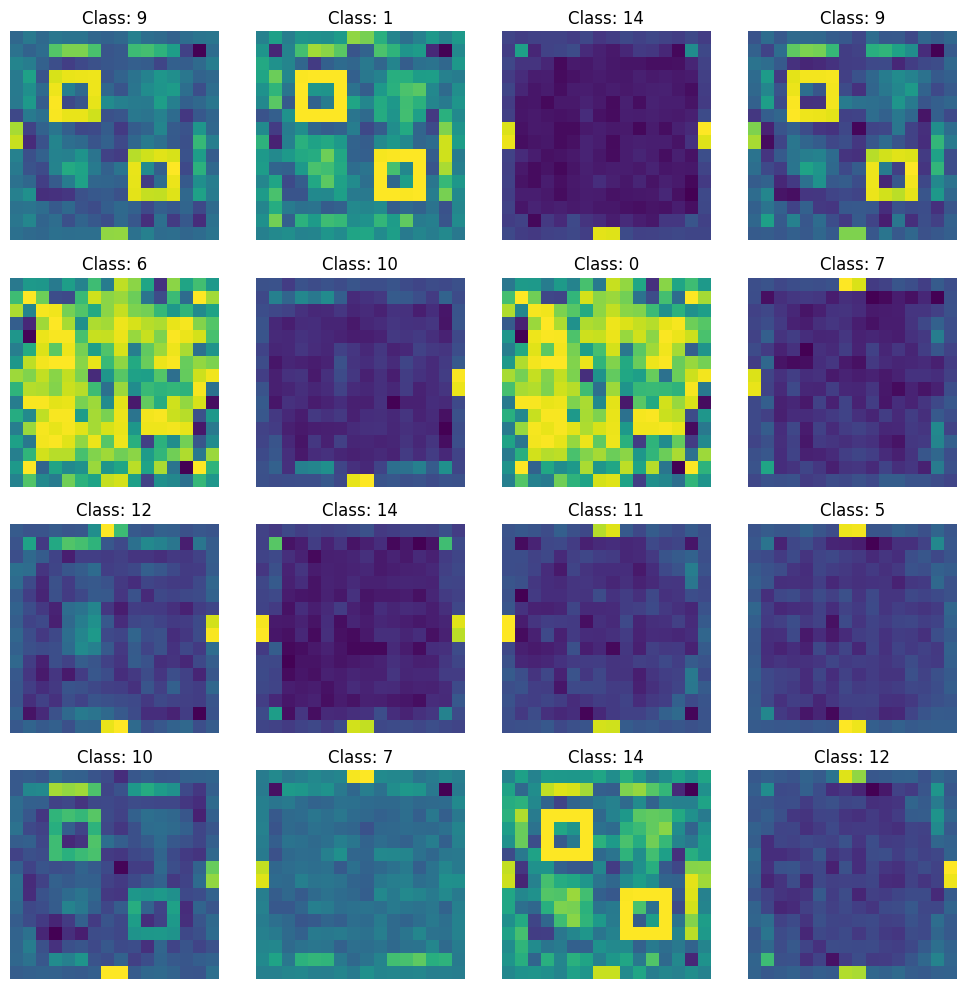

1/1 [==============================] - 0s 55ms/step
8900 [D loss: 0.10380718018859625 | D accuracy: 96.875] [G loss: 5.302934646606445]
1/1 [==============================] - 0s 79ms/step


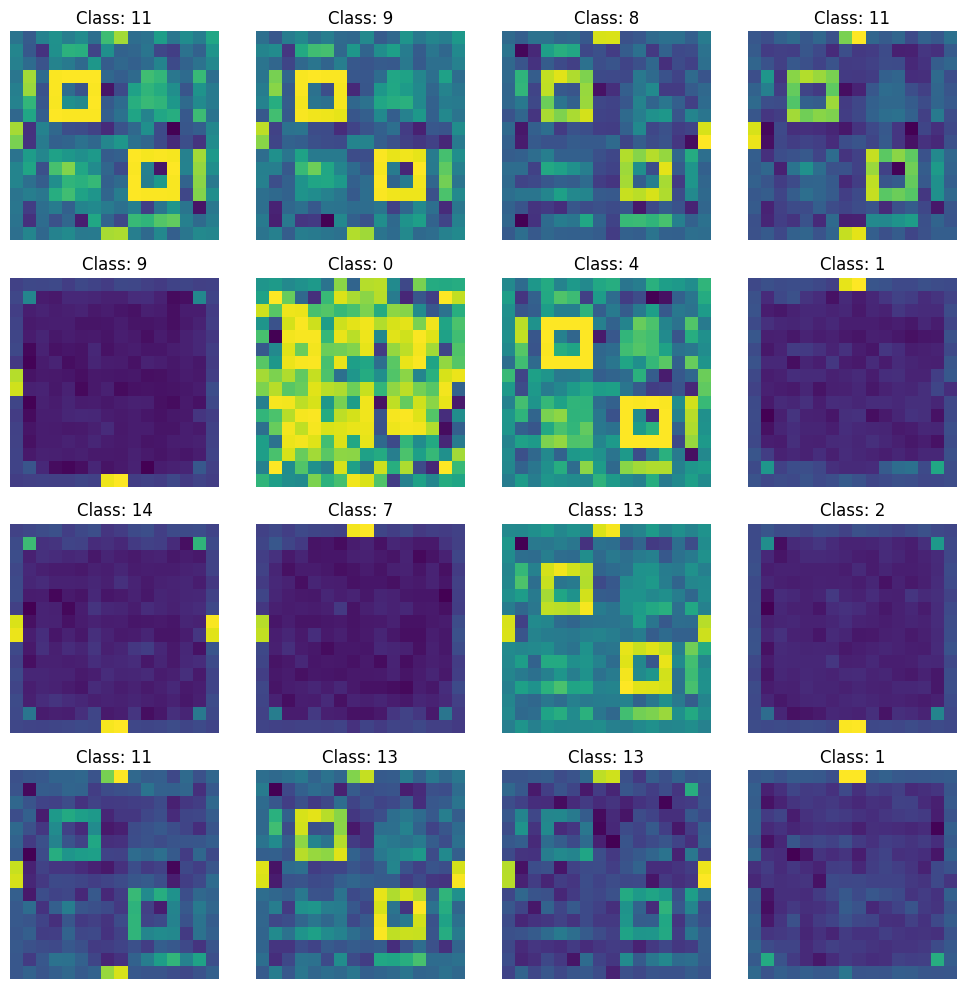

1/1 [==============================] - 0s 42ms/step
9000 [D loss: 0.09159860759973526 | D accuracy: 96.875] [G loss: 15.274842262268066]
1/1 [==============================] - 0s 57ms/step


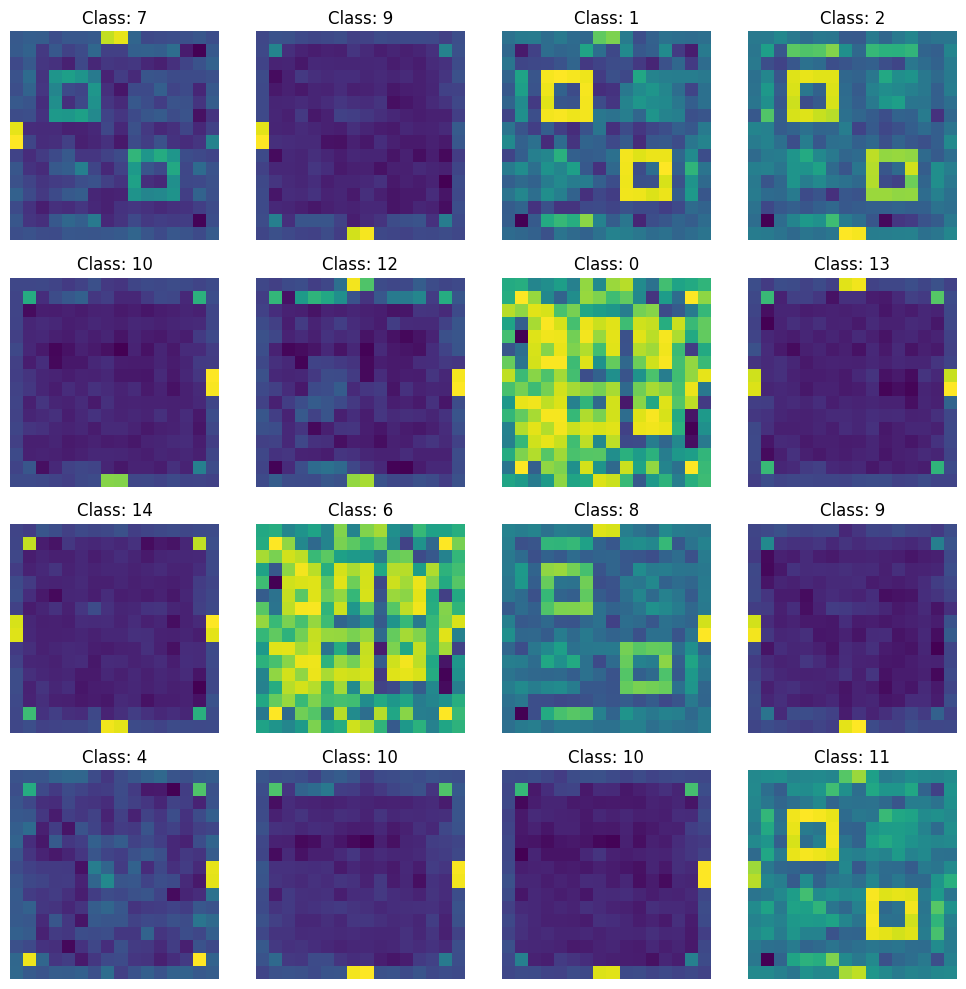

1/1 [==============================] - 0s 35ms/step
9100 [D loss: 0.1274035908281803 | D accuracy: 96.875] [G loss: 5.002956867218018]
1/1 [==============================] - 0s 41ms/step


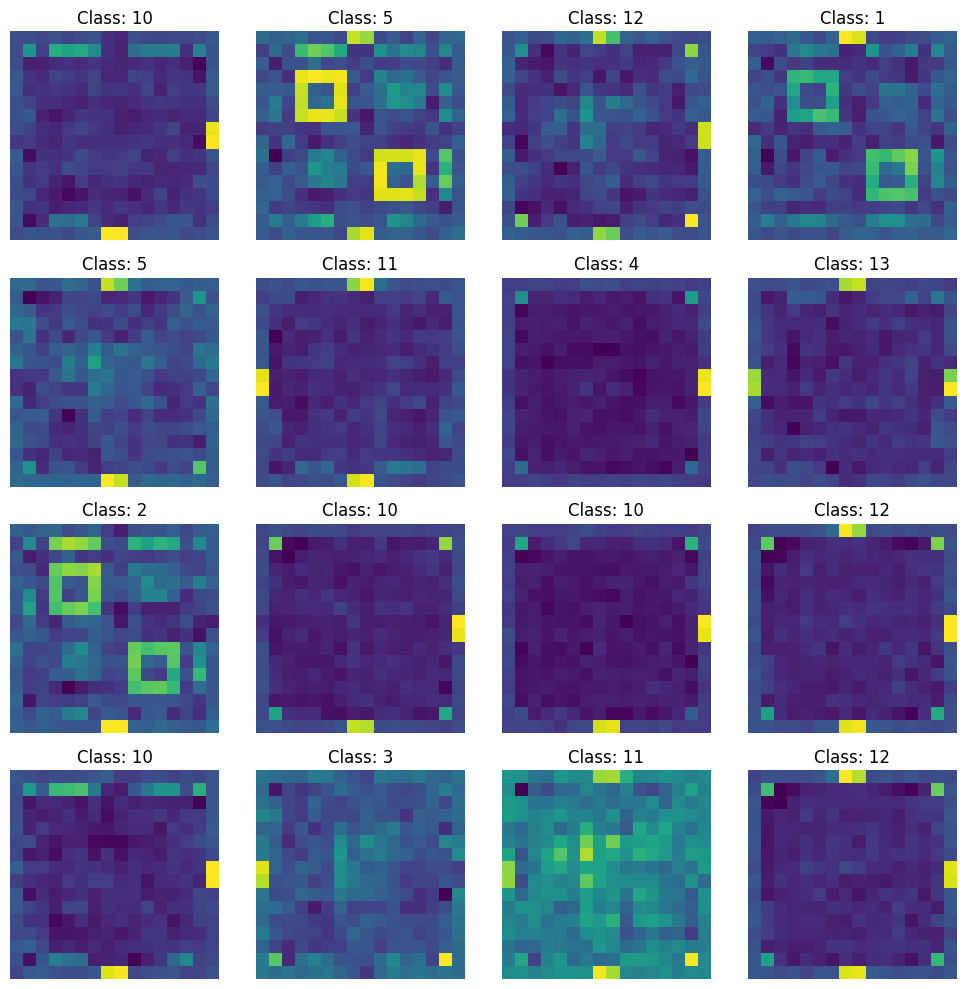

1/1 [==============================] - 0s 70ms/step
9200 [D loss: 0.22391746938228607 | D accuracy: 90.625] [G loss: 5.758907318115234]
1/1 [==============================] - 0s 48ms/step


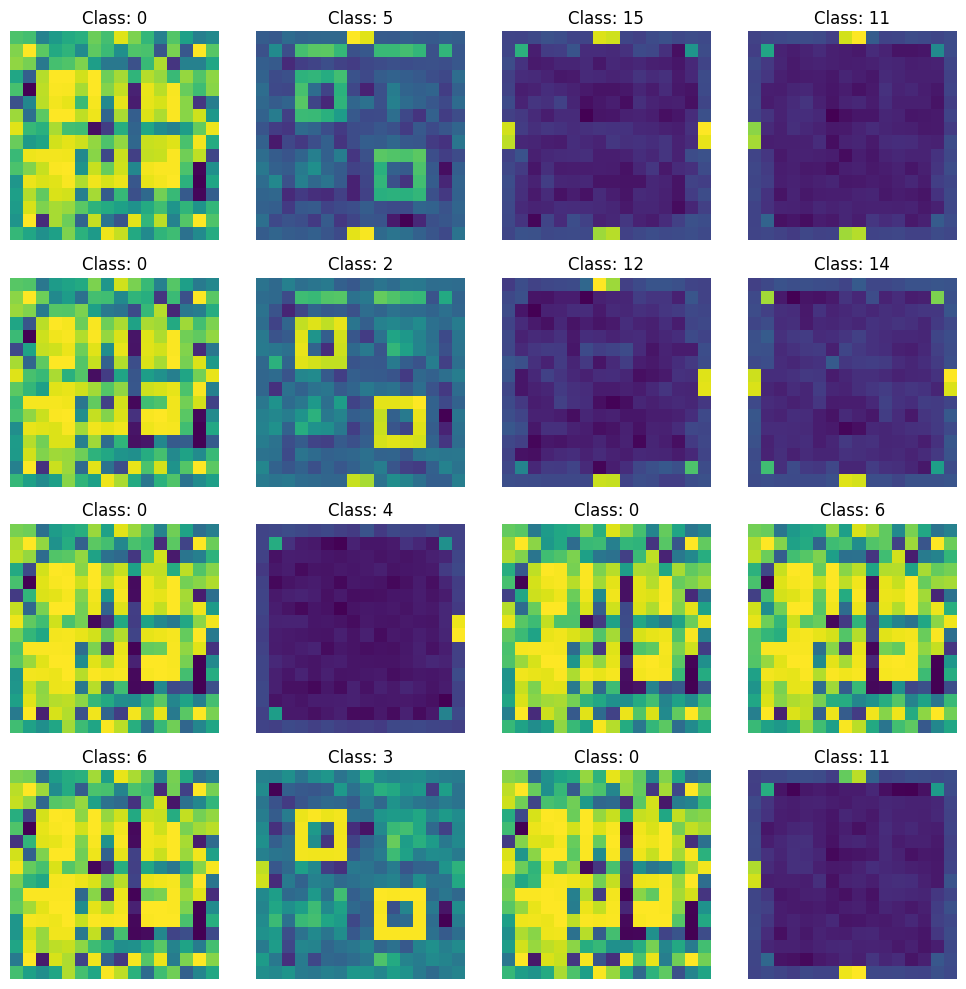

1/1 [==============================] - 0s 27ms/step
9300 [D loss: 0.05955123342573643 | D accuracy: 100.0] [G loss: 12.232236862182617]
1/1 [==============================] - 0s 26ms/step


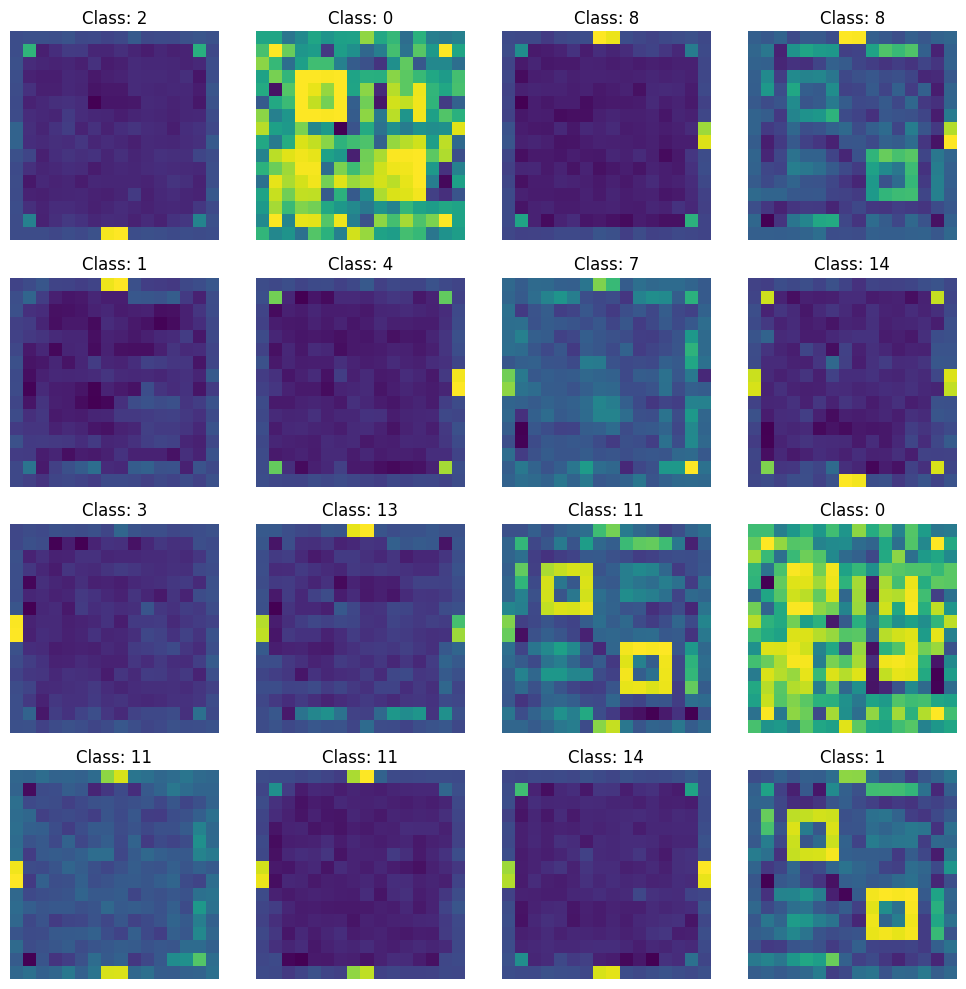

1/1 [==============================] - 0s 41ms/step
9400 [D loss: 0.17784869484603405 | D accuracy: 90.625] [G loss: 6.06876277923584]
1/1 [==============================] - 0s 55ms/step


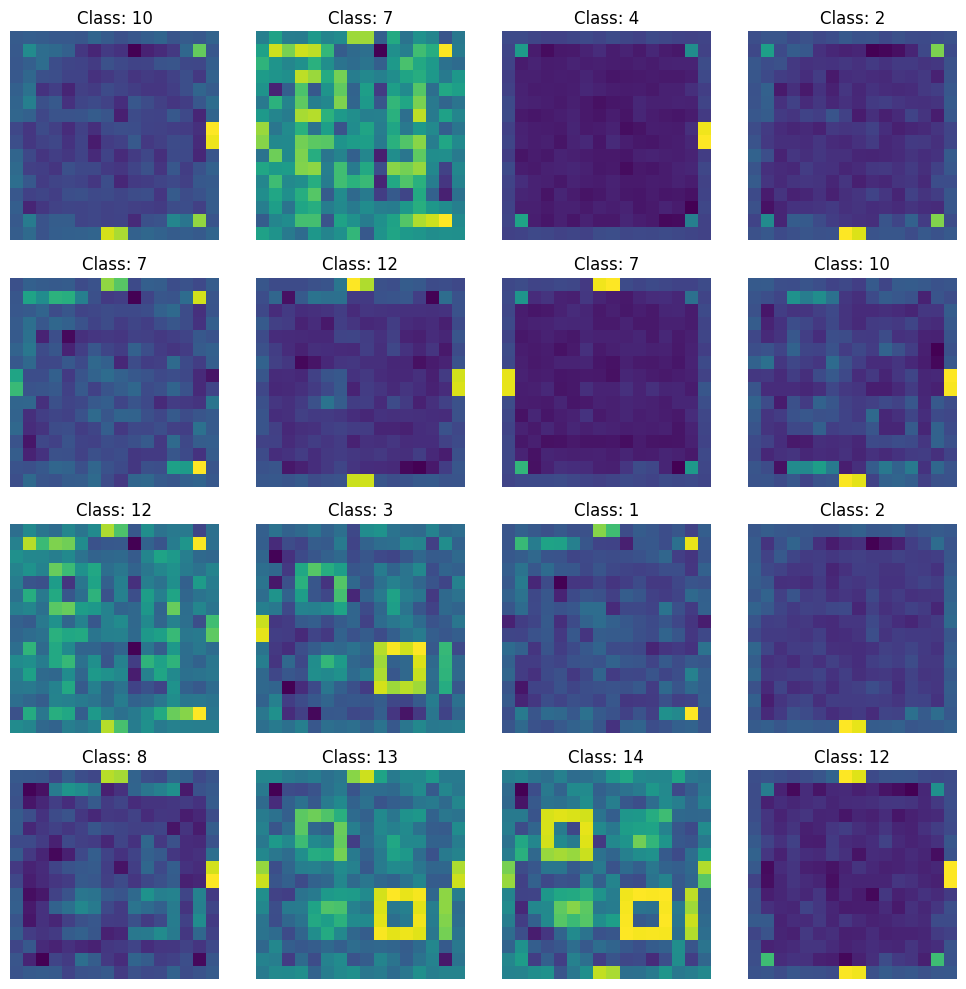

1/1 [==============================] - 0s 34ms/step
9500 [D loss: 0.11475788988173008 | D accuracy: 93.75] [G loss: 8.210043907165527]
1/1 [==============================] - 0s 50ms/step


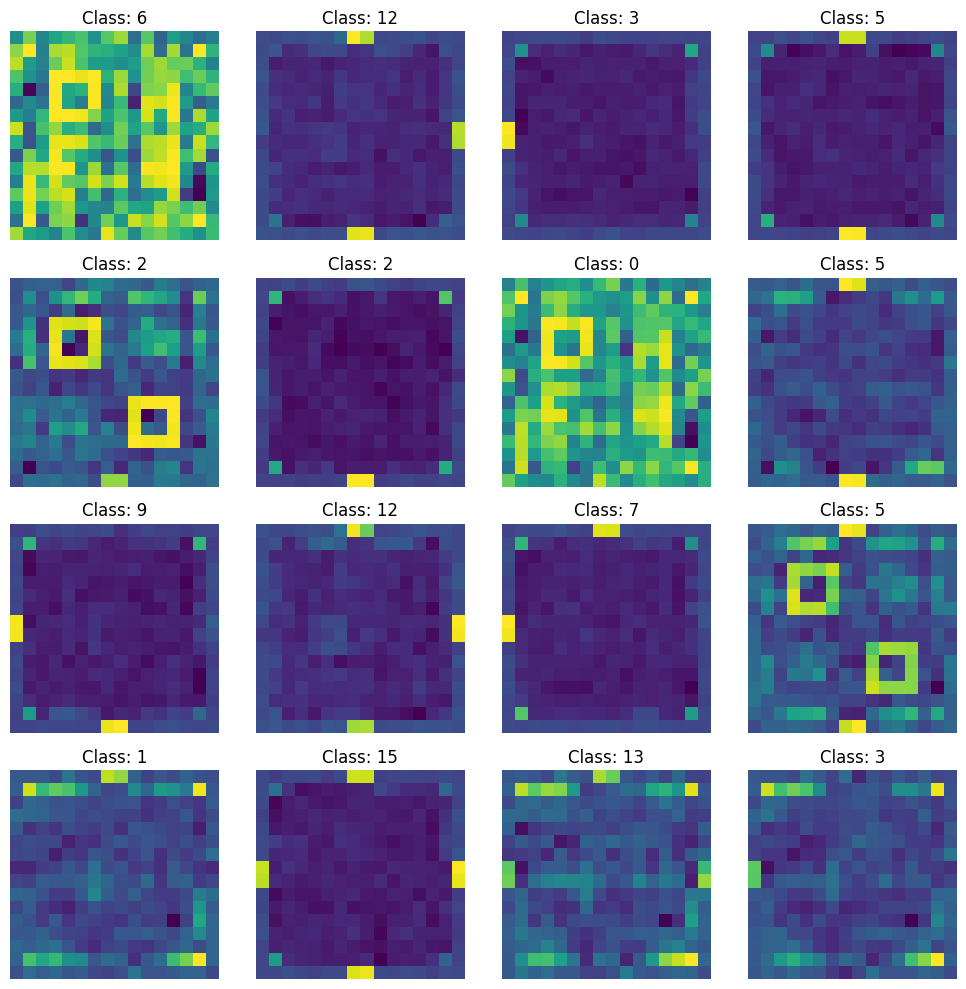

1/1 [==============================] - 0s 62ms/step
9600 [D loss: 0.2809809595346451 | D accuracy: 87.5] [G loss: 3.9237117767333984]
1/1 [==============================] - 0s 57ms/step


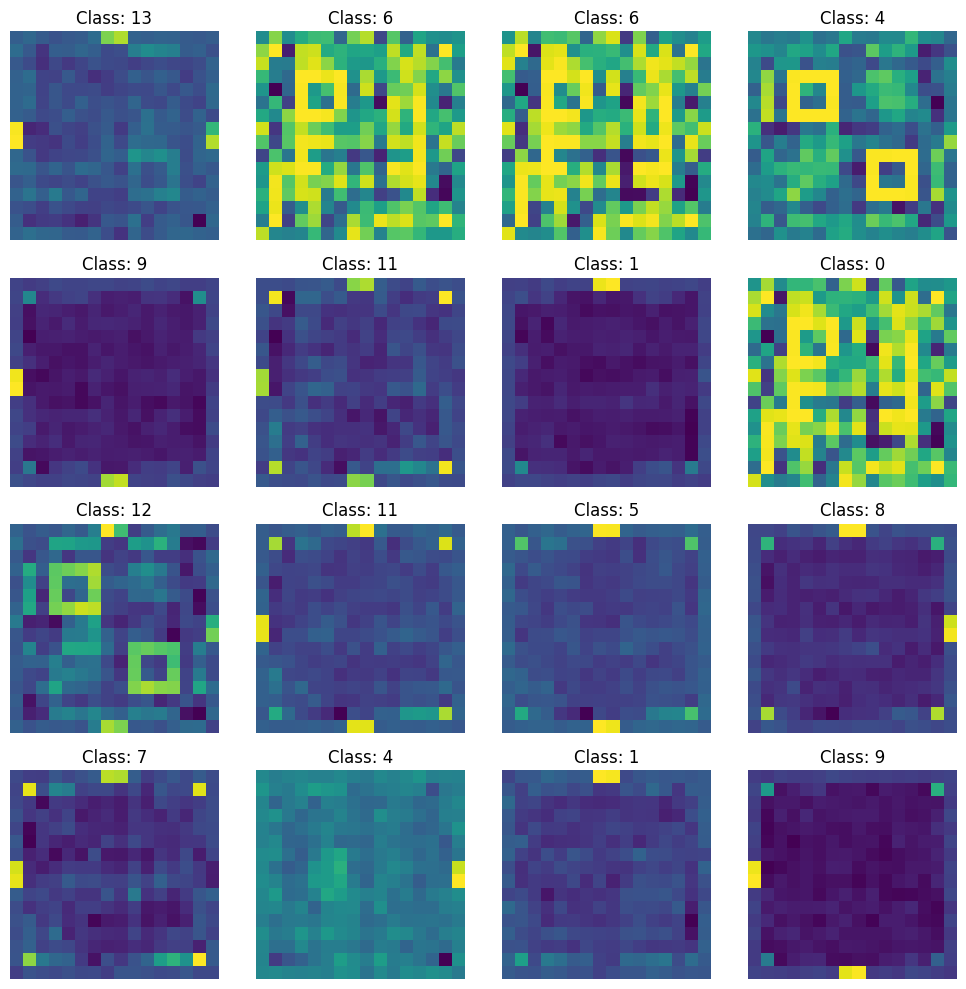

1/1 [==============================] - 0s 34ms/step
9700 [D loss: 0.1718045398592949 | D accuracy: 90.625] [G loss: 6.305414199829102]
1/1 [==============================] - 0s 32ms/step


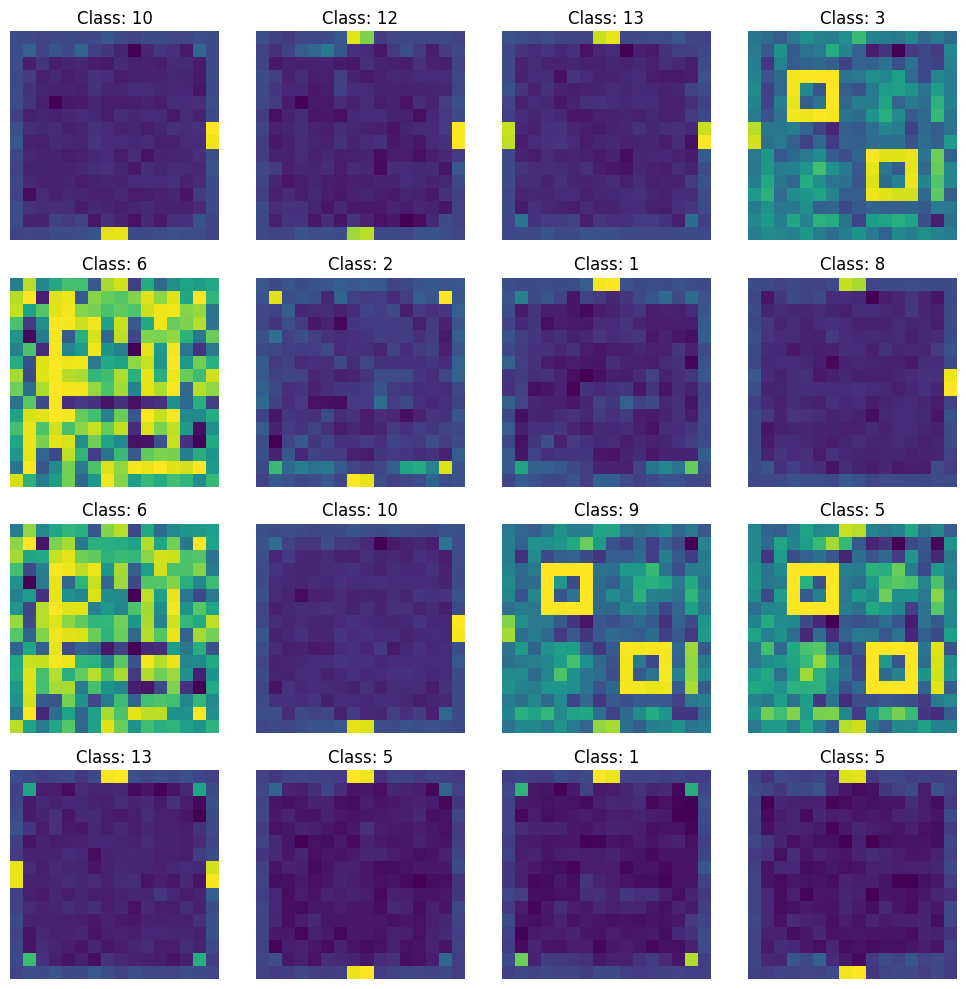

1/1 [==============================] - 0s 54ms/step
9800 [D loss: 0.21664297580718994 | D accuracy: 93.75] [G loss: 5.30290412902832]
1/1 [==============================] - 0s 93ms/step


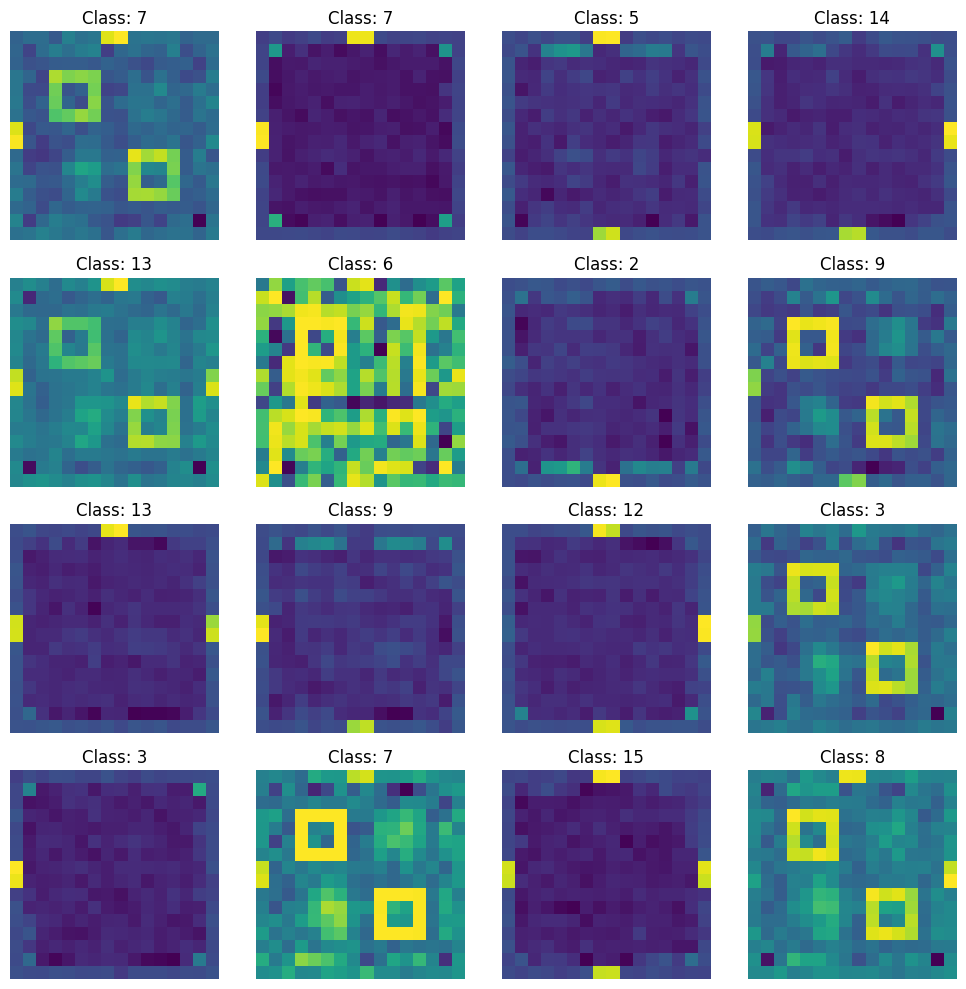

1/1 [==============================] - 0s 41ms/step
9900 [D loss: 0.1215740330517292 | D accuracy: 96.875] [G loss: 7.716014862060547]
1/1 [==============================] - 0s 29ms/step


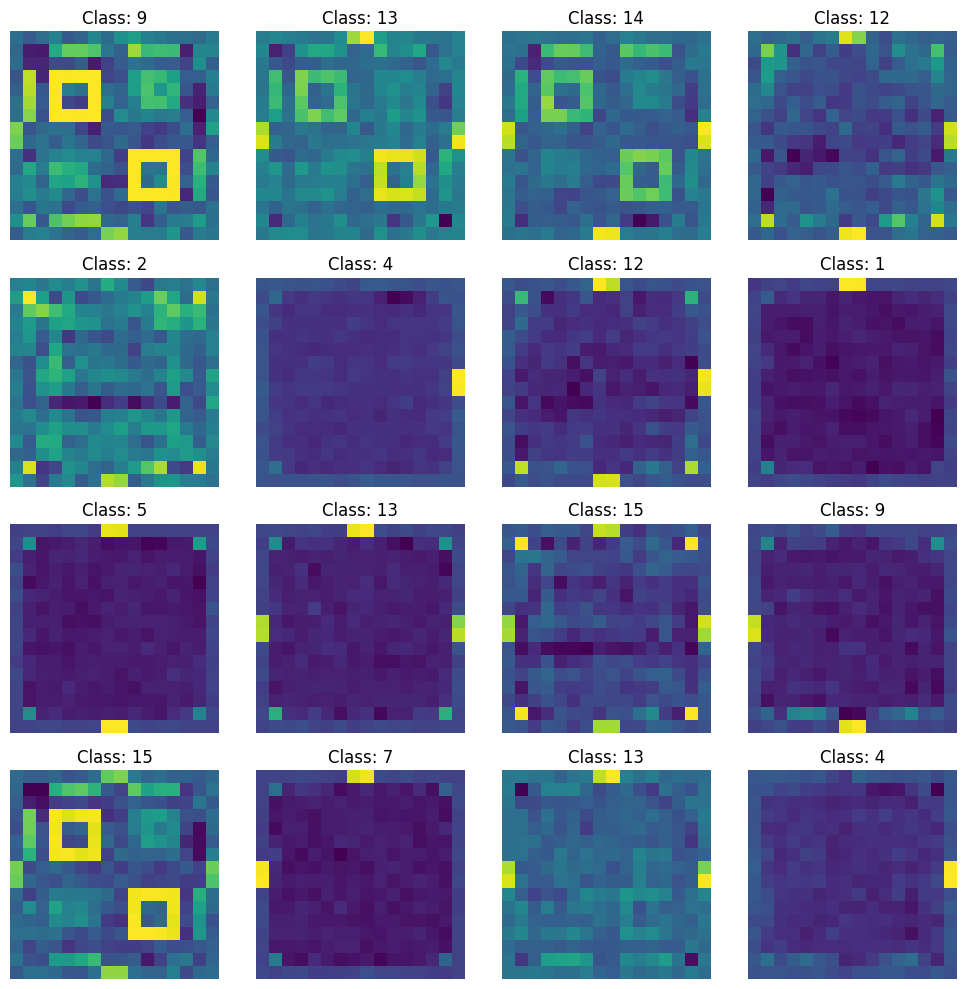

1/1 [==============================] - 0s 31ms/step


In [160]:
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Function to plot generated rooms
def plot_generated_rooms(generator, epoch, noise_dim, num_classes, num_images=16):
    noise = np.random.normal(0, 1, (num_images, noise_dim))  # Generate random noise
    gen_labels = np.random.randint(0, num_classes, num_images)  # Generate random labels
    gen_labels_one_hot = to_categorical(gen_labels, num_classes=num_classes)  # One-hot encode the labels

    generated_rooms = generator.predict([noise, gen_labels_one_hot])  # Generate rooms using the generator
    generated_rooms = 0.5 * generated_rooms + 0.5  # Rescale images to range [0, 1]

    plt.figure(figsize=(10, 10))  # Set figure size
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_rooms[i, :, :, 0], cmap='viridis')  # Use 'viridis' colormap for color
        plt.title(f"Class: {gen_labels[i]}")  # Set title to show class label
        plt.axis('off')  # Turn off axis
    plt.tight_layout()  # Adjust subplot parameters for better layout
    plt.show()  # Display the plot

# Updated training function for the CGAN
def train(generator, discriminator, cgan, epochs, batch_size, X_train, y_train, noise_dim=100, num_classes=16):
    real = np.ones((batch_size, 1))  # Real labels (for real images)
    fake = np.zeros((batch_size, 1))  # Fake labels (for generated images)

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)  # Randomly select a batch of real images
        real_rooms = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_dim))  # Generate random noise
        gen_labels = np.random.randint(0, num_classes, batch_size)  # Generate random labels
        gen_labels_one_hot = to_categorical(gen_labels, num_classes=num_classes)  # One-hot encode the labels

        generated_rooms = generator.predict([noise, gen_labels_one_hot])  # Generate fake rooms

        # Train the discriminator (real images and fake images)
        d_loss_real = discriminator.train_on_batch([real_rooms, real_labels], real)
        d_loss_fake = discriminator.train_on_batch([generated_rooms, gen_labels_one_hot], fake)

        # Calculate the total discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generate noise and labels for training the generator via CGAN
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_labels_one_hot = to_categorical(gen_labels, num_classes=num_classes)

        # Train the generator (via the CGAN model)
        g_loss = cgan.train_on_batch([noise, gen_labels_one_hot], real)

        # Print progress and plot generated rooms every 100 epochs
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")
            plot_generated_rooms(generator, epoch, noise_dim, num_classes)

# Normalize the data
X_train = np.array(Updatedroomdecor)
X_train = X_train / 9.0  # Normalize the data
X_train = np.expand_dims(X_train, axis=-1)  # Expand dimensions to match the input shape for CNN
y_train = to_categorical(Room_Type, num_classes=16)  # One-hot encode the labels

# Train the CGAN with more epochs
train(generator, discriminator, cgan, epochs=10000, batch_size=16, X_train=X_train, y_train=y_train)


1/1 [==============================] - 0s 25ms/step
0 [D loss: 0.16043364256620407 | D accuracy: 93.75] [G loss: 7.323674201965332]
1/1 [==============================] - 0s 24ms/step


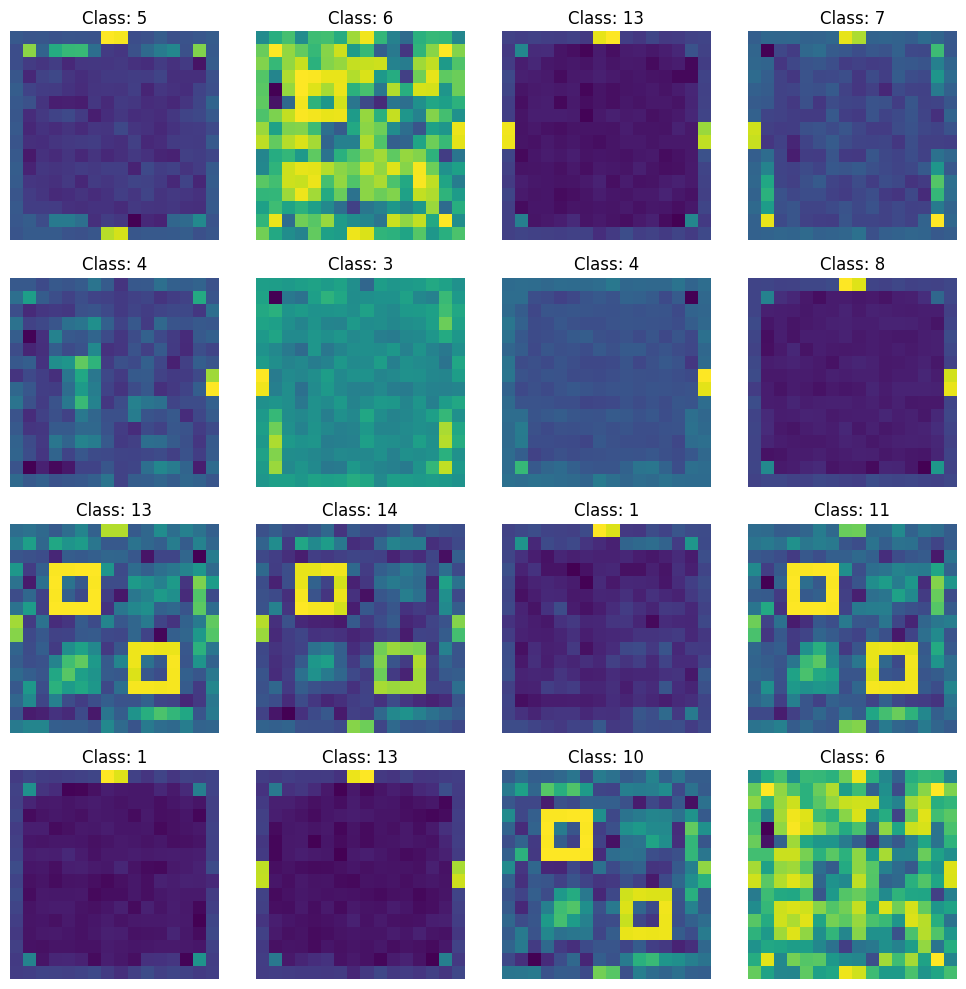

1/1 [==============================] - 0s 32ms/step
100 [D loss: 0.15712784230709076 | D accuracy: 96.875] [G loss: 8.365266799926758]
1/1 [==============================] - 0s 30ms/step


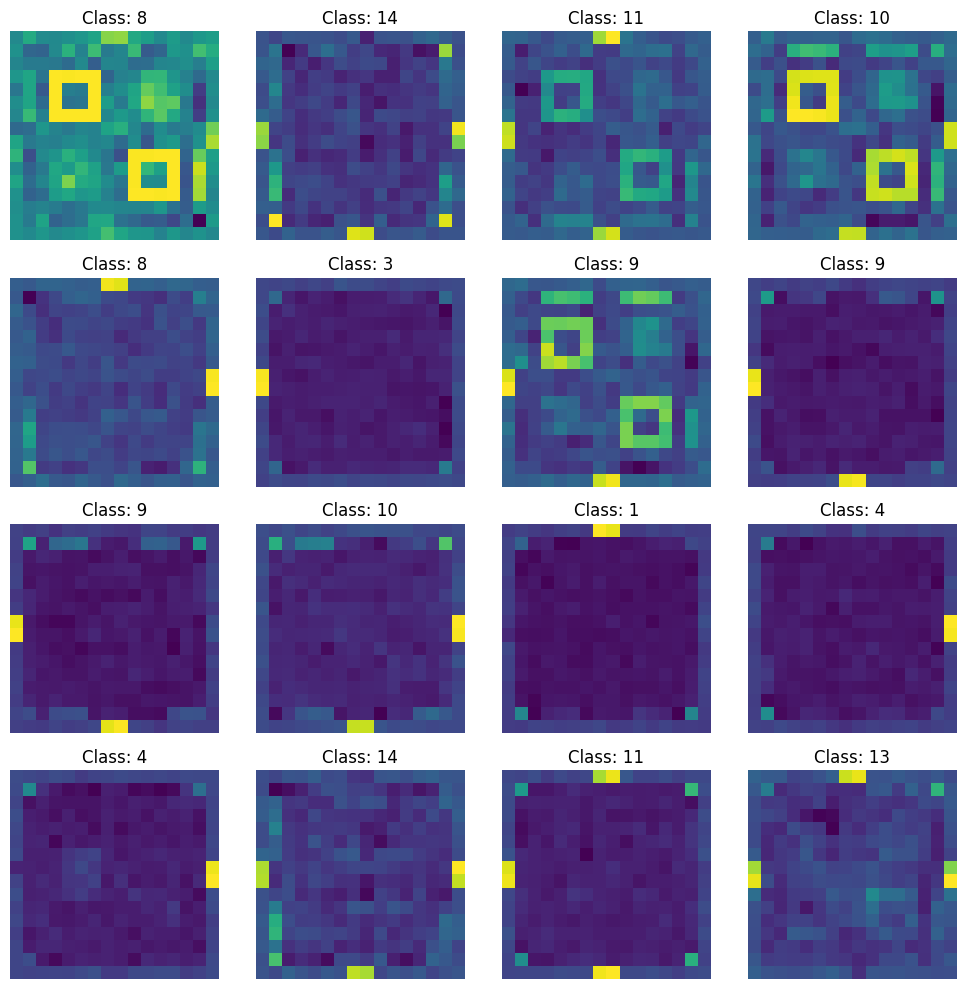

1/1 [==============================] - 0s 28ms/step
200 [D loss: 0.28363000601530075 | D accuracy: 93.75] [G loss: 7.51737117767334]
1/1 [==============================] - 0s 42ms/step


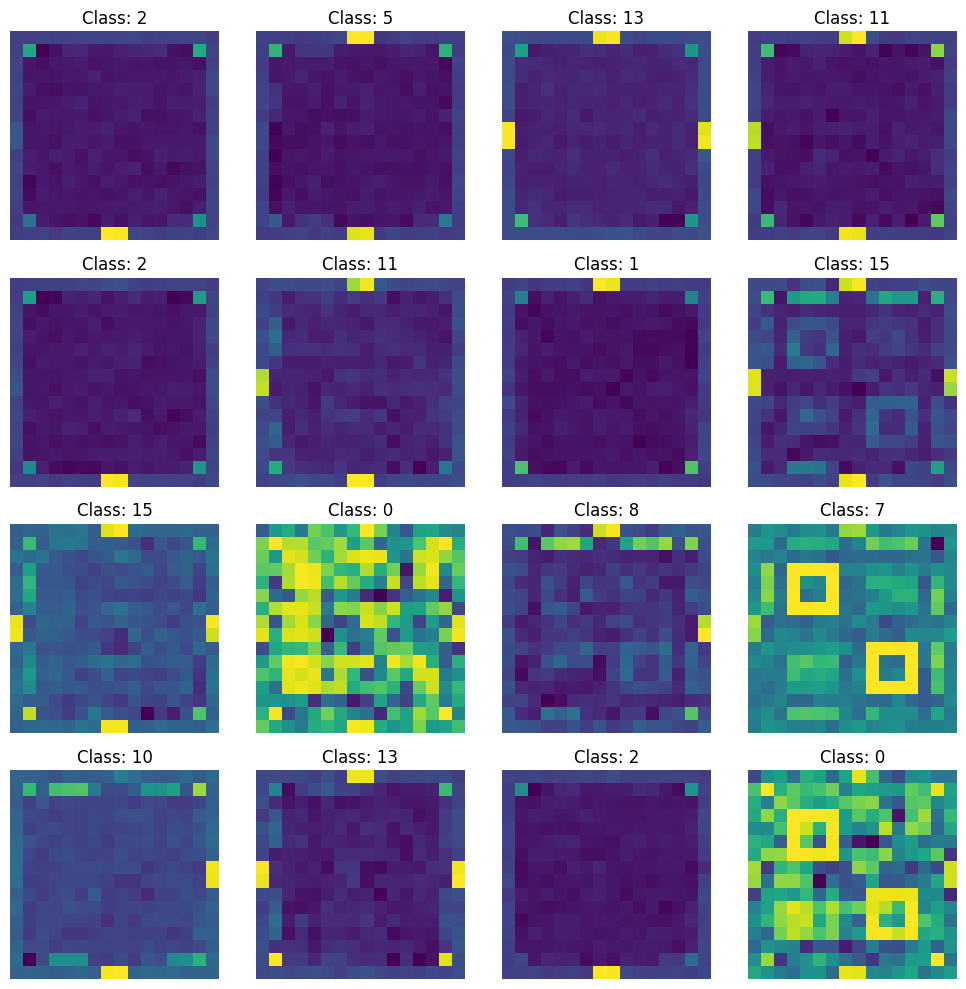

1/1 [==============================] - 0s 23ms/step
300 [D loss: 0.22501694556558505 | D accuracy: 93.75] [G loss: 7.988738536834717]
1/1 [==============================] - 0s 31ms/step


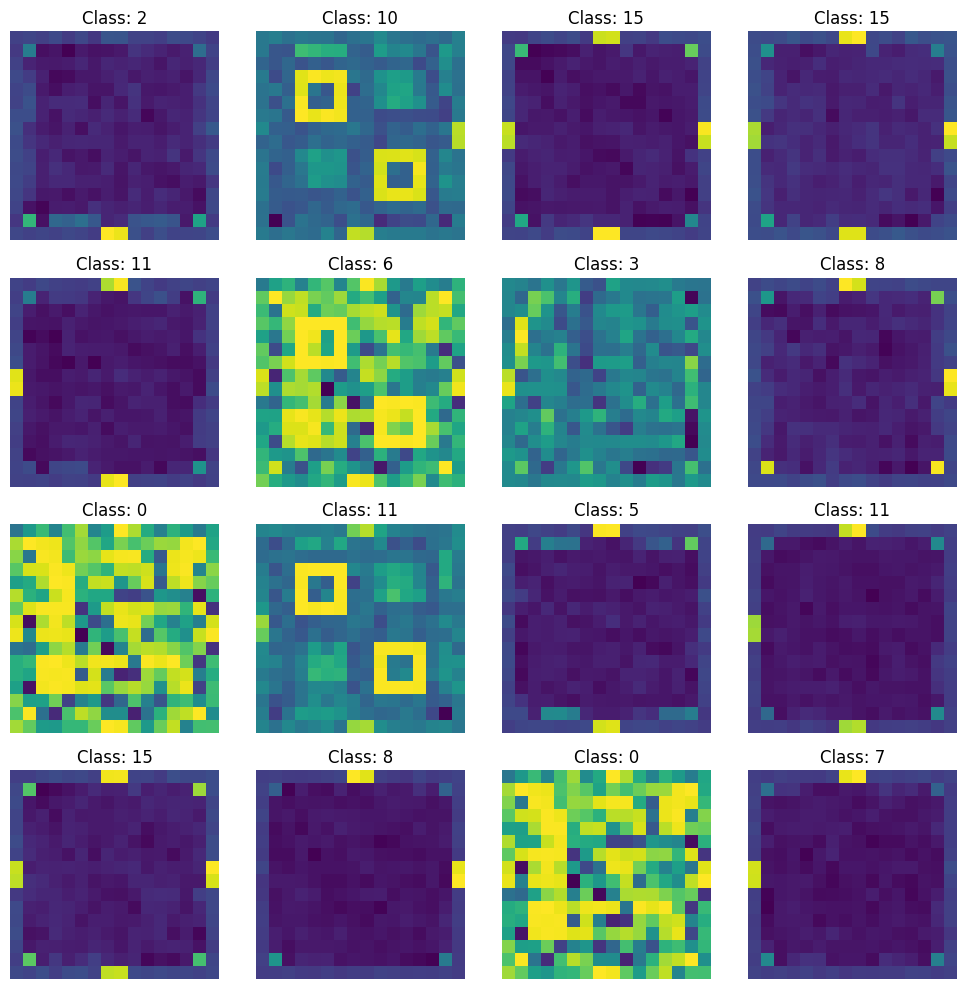

1/1 [==============================] - 0s 32ms/step
400 [D loss: 0.13897542655467987 | D accuracy: 90.625] [G loss: 7.3151469230651855]
1/1 [==============================] - 0s 25ms/step


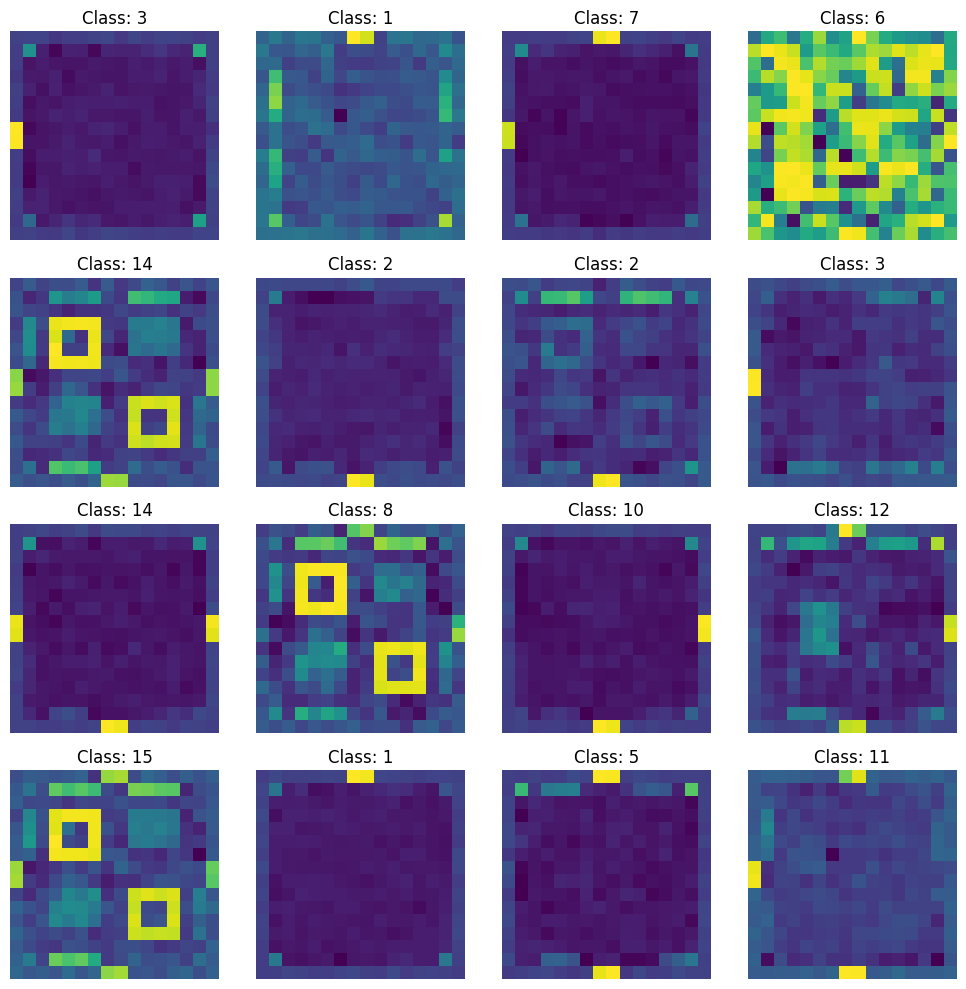

1/1 [==============================] - 0s 35ms/step
500 [D loss: 0.03495272435247898 | D accuracy: 100.0] [G loss: 5.443396091461182]
1/1 [==============================] - 0s 32ms/step


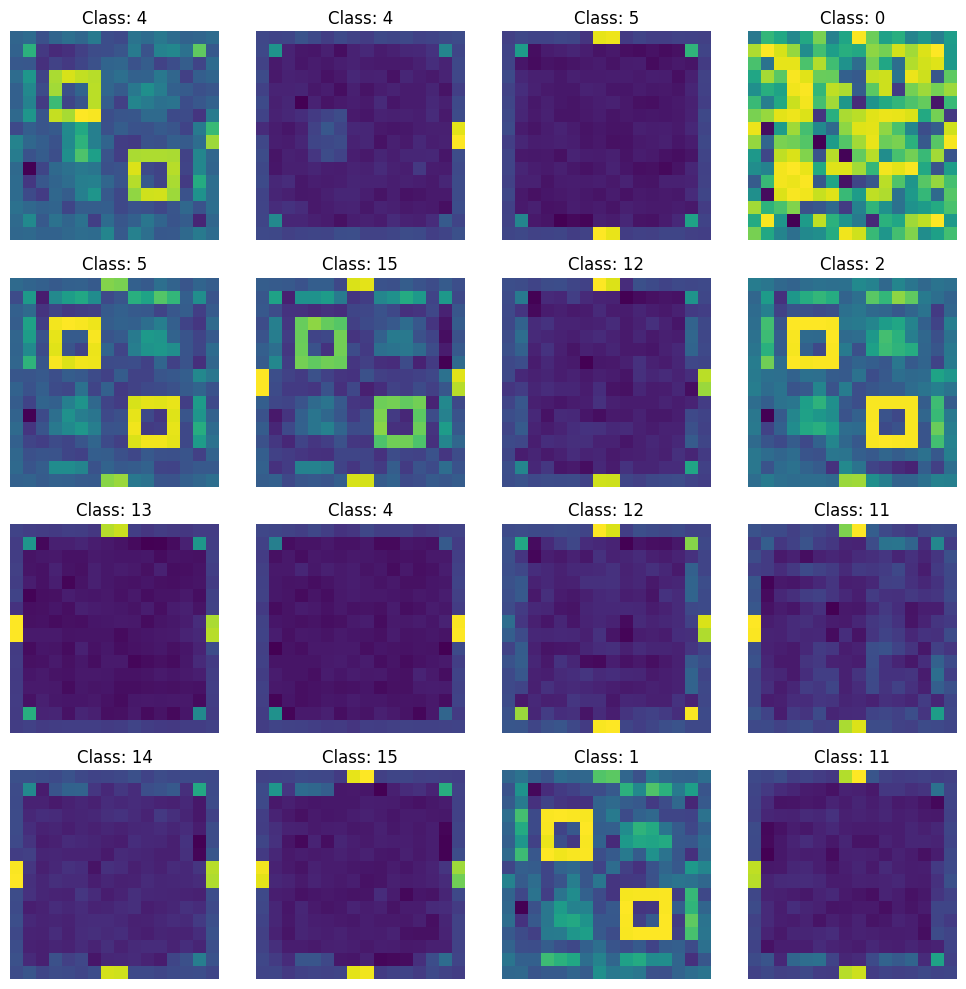

1/1 [==============================] - 0s 37ms/step
600 [D loss: 0.22129829227924347 | D accuracy: 93.75] [G loss: 8.567191123962402]
1/1 [==============================] - 0s 27ms/step


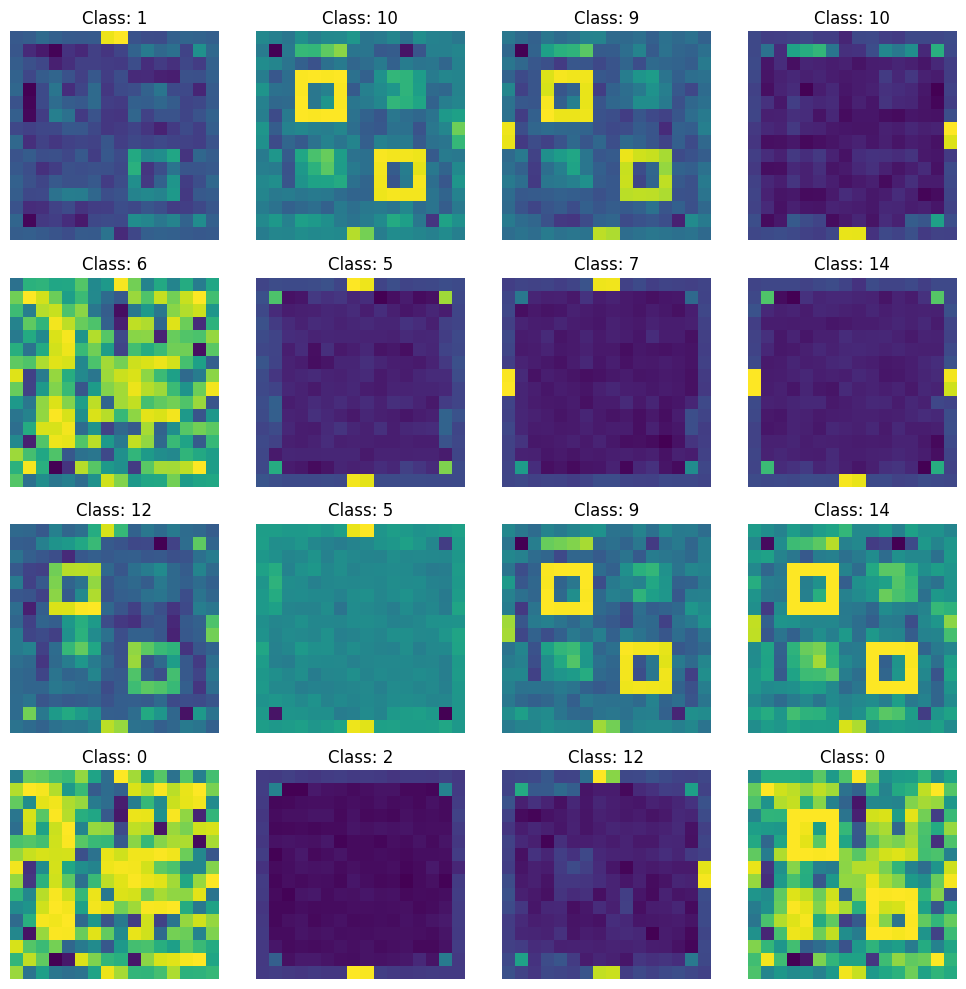

1/1 [==============================] - 0s 25ms/step
700 [D loss: 0.16693120077252388 | D accuracy: 93.75] [G loss: 6.170010566711426]
1/1 [==============================] - 0s 25ms/step


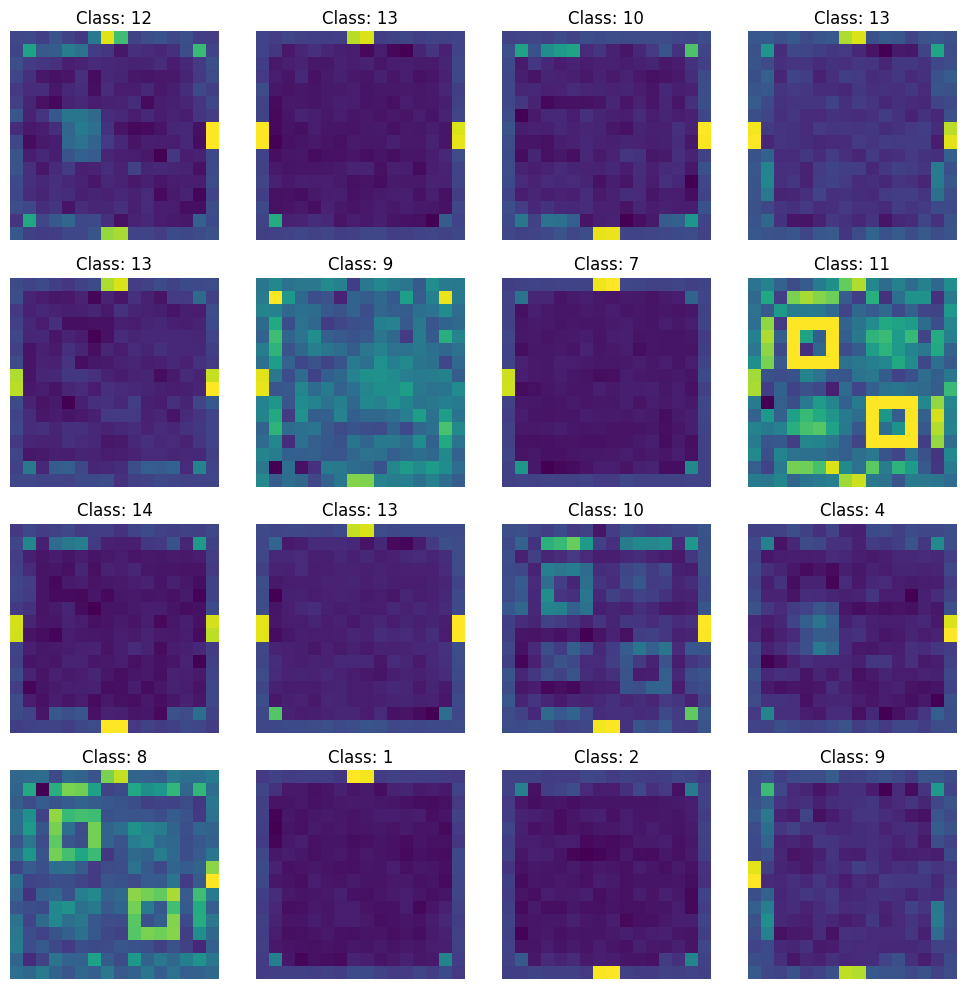

1/1 [==============================] - 0s 35ms/step
800 [D loss: 0.08778662234544754 | D accuracy: 96.875] [G loss: 9.42950439453125]
1/1 [==============================] - 0s 33ms/step


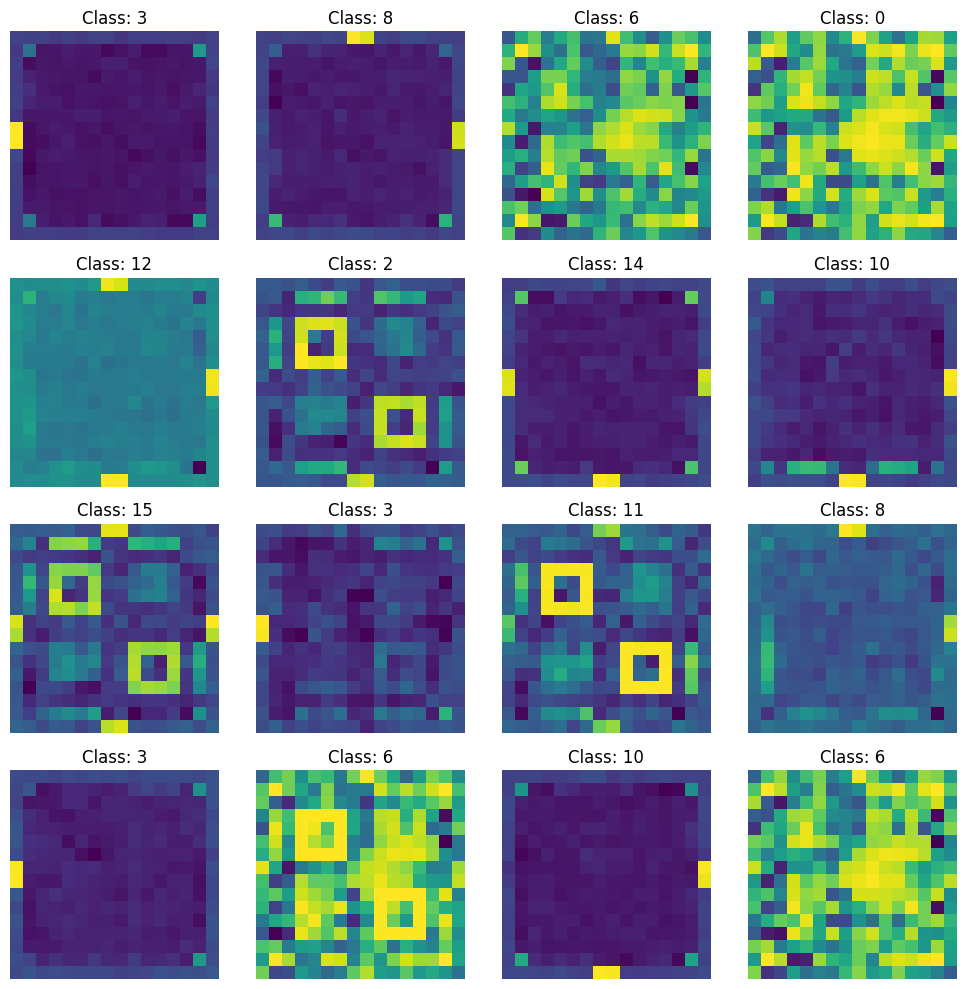

1/1 [==============================] - 0s 30ms/step
900 [D loss: 0.18081267178058624 | D accuracy: 90.625] [G loss: 5.89044713973999]
1/1 [==============================] - 0s 39ms/step


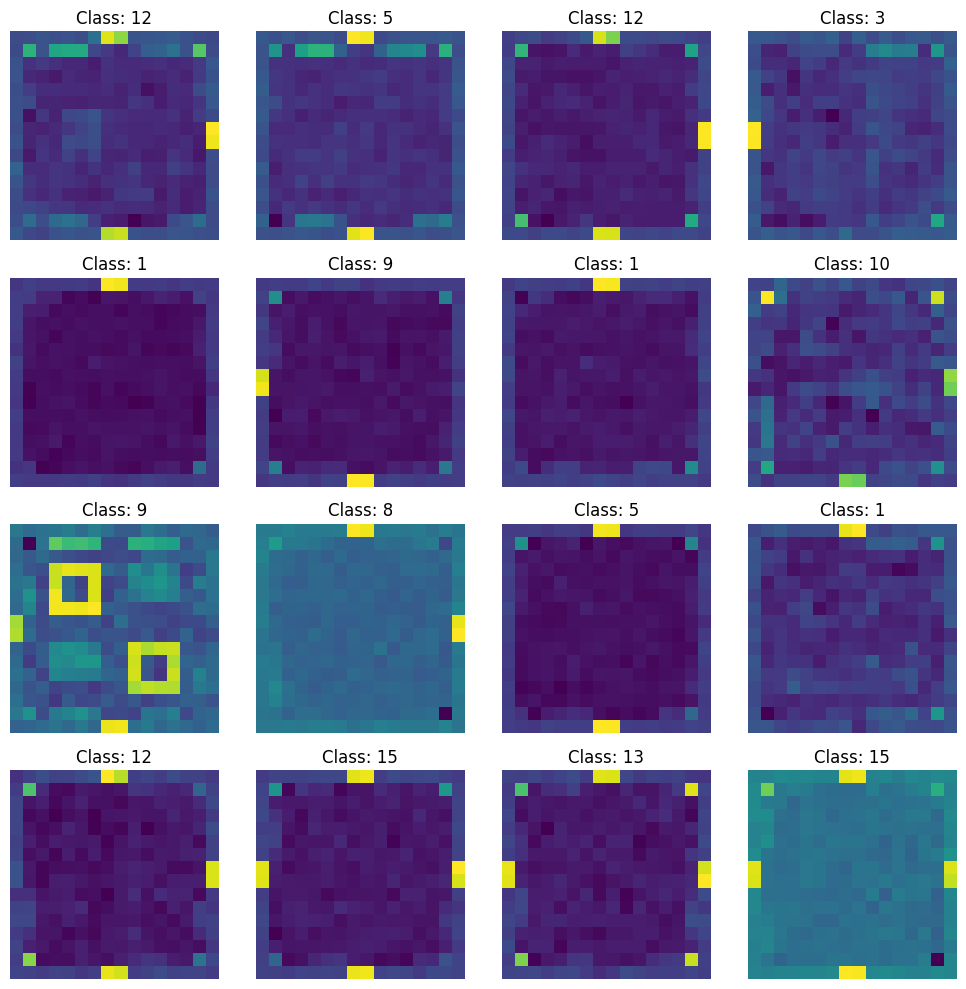

1/1 [==============================] - 0s 24ms/step
1000 [D loss: 0.23189011216163635 | D accuracy: 90.625] [G loss: 5.931787490844727]
1/1 [==============================] - 0s 31ms/step


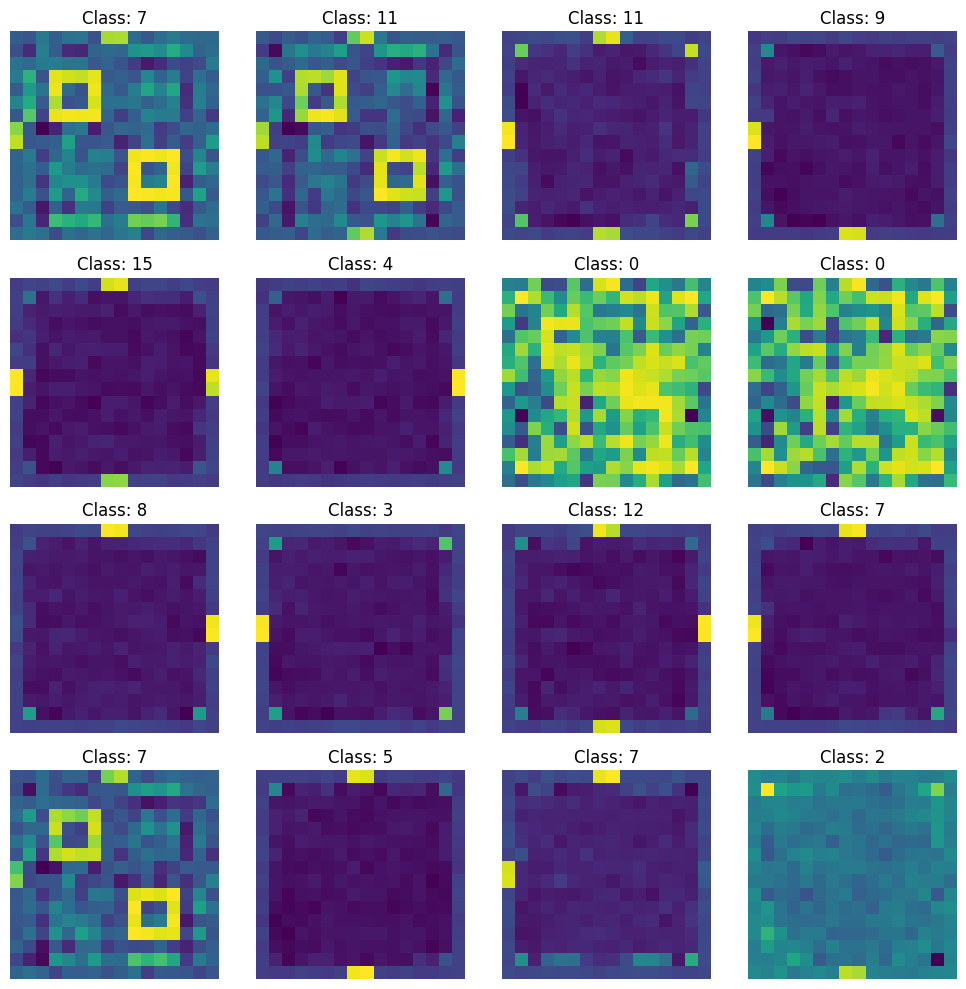

1/1 [==============================] - 0s 26ms/step
1100 [D loss: 0.4191102981567383 | D accuracy: 84.375] [G loss: 9.722177505493164]
1/1 [==============================] - 0s 36ms/step


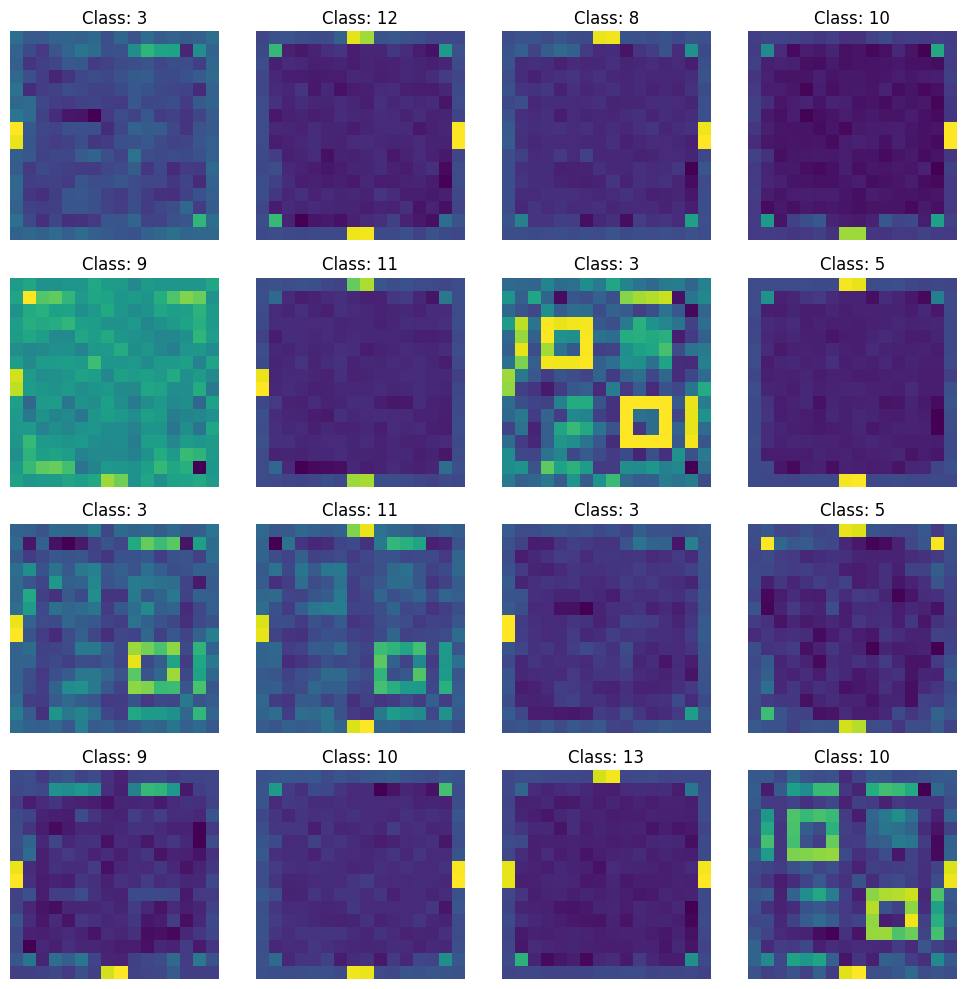

1/1 [==============================] - 0s 34ms/step
1200 [D loss: 0.13518085330724716 | D accuracy: 93.75] [G loss: 5.766322135925293]
1/1 [==============================] - 0s 34ms/step


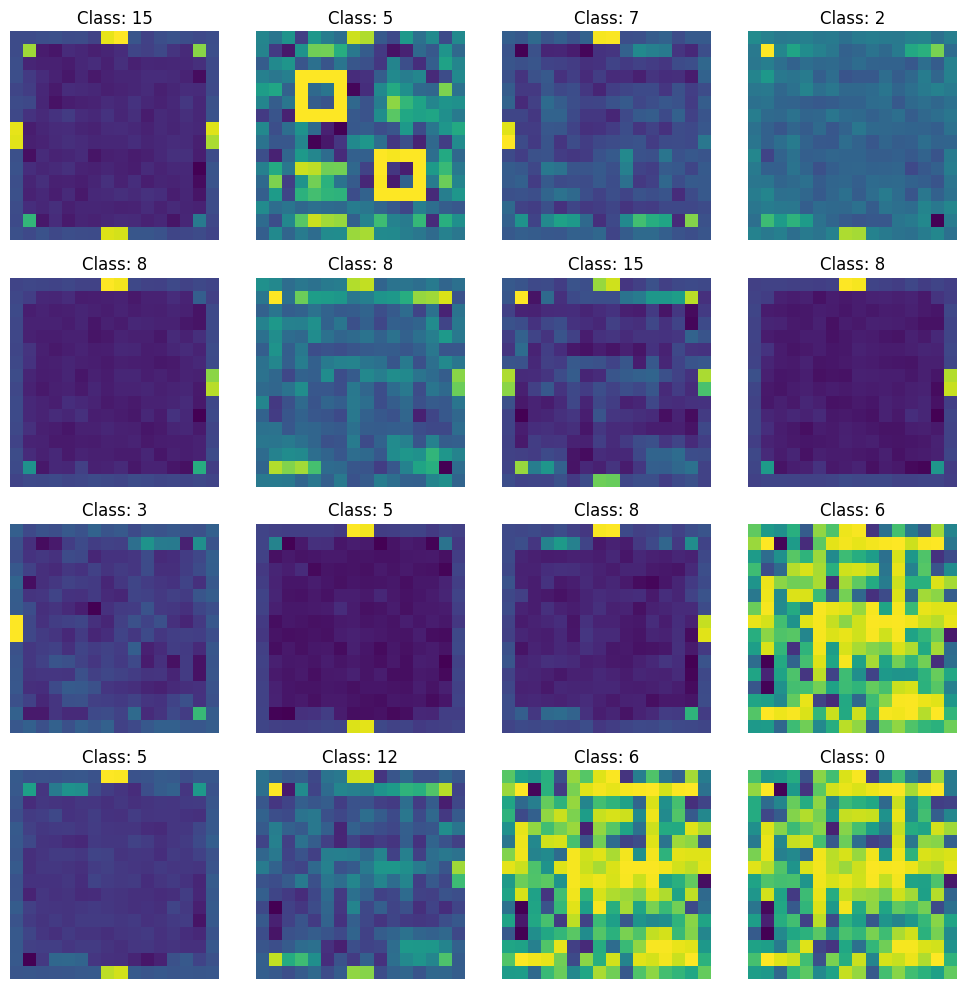

1/1 [==============================] - 0s 31ms/step
1300 [D loss: 0.1695338562130928 | D accuracy: 87.5] [G loss: 6.96754264831543]
1/1 [==============================] - 0s 27ms/step


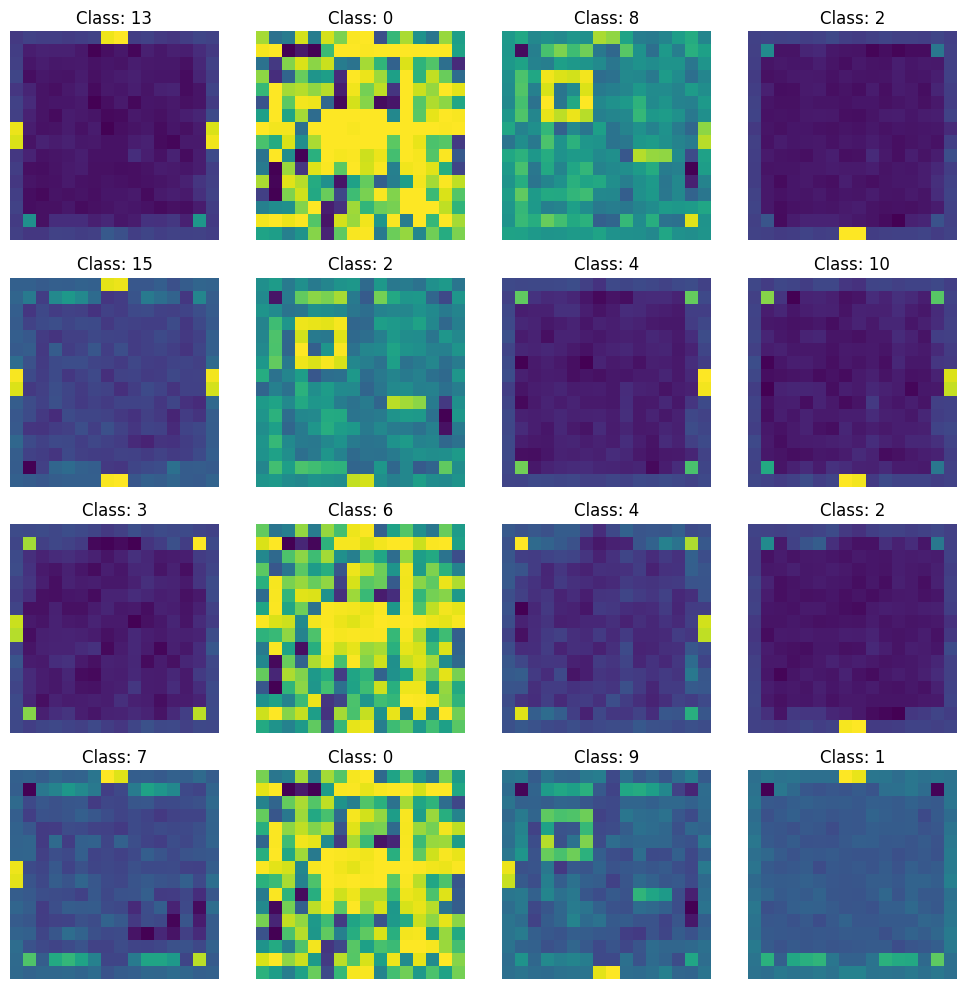

1/1 [==============================] - 0s 39ms/step
1400 [D loss: 0.1582035794854164 | D accuracy: 90.625] [G loss: 12.44096565246582]
1/1 [==============================] - 0s 51ms/step


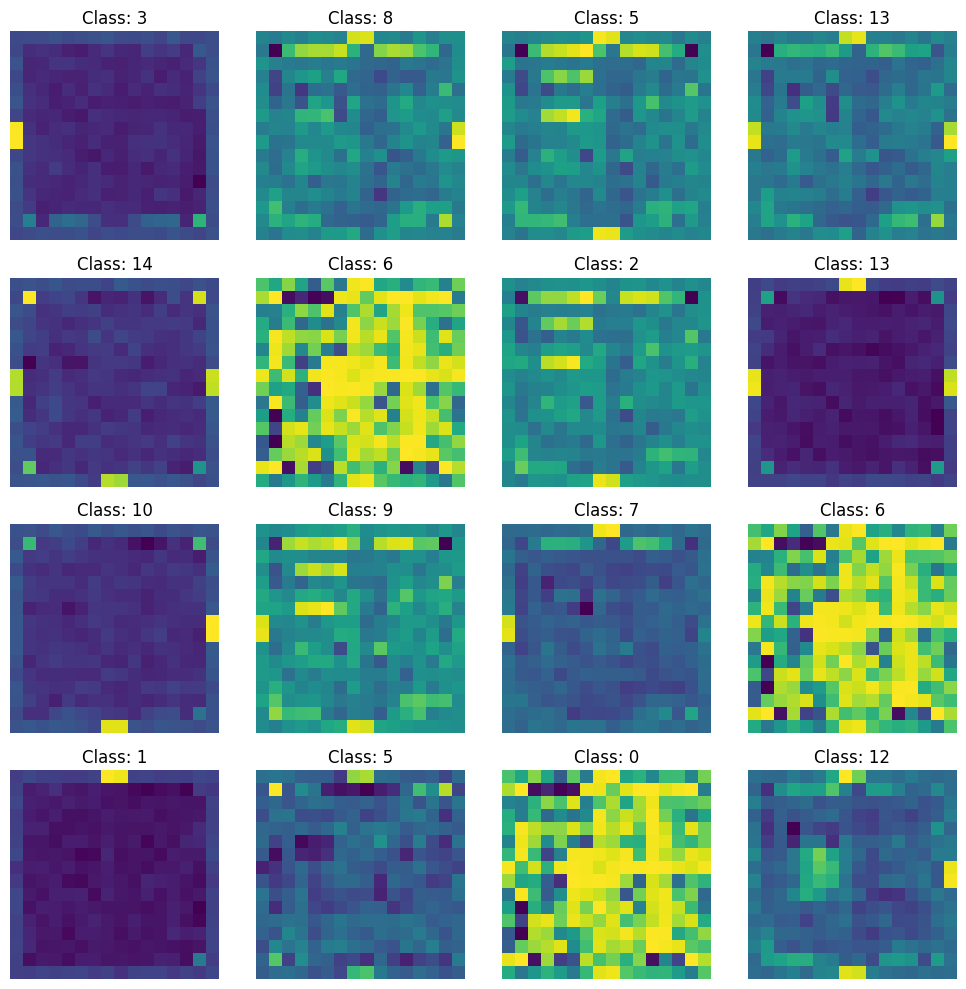

1/1 [==============================] - 0s 32ms/step
1500 [D loss: 0.015314671909436584 | D accuracy: 100.0] [G loss: 7.897936820983887]
1/1 [==============================] - 0s 33ms/step


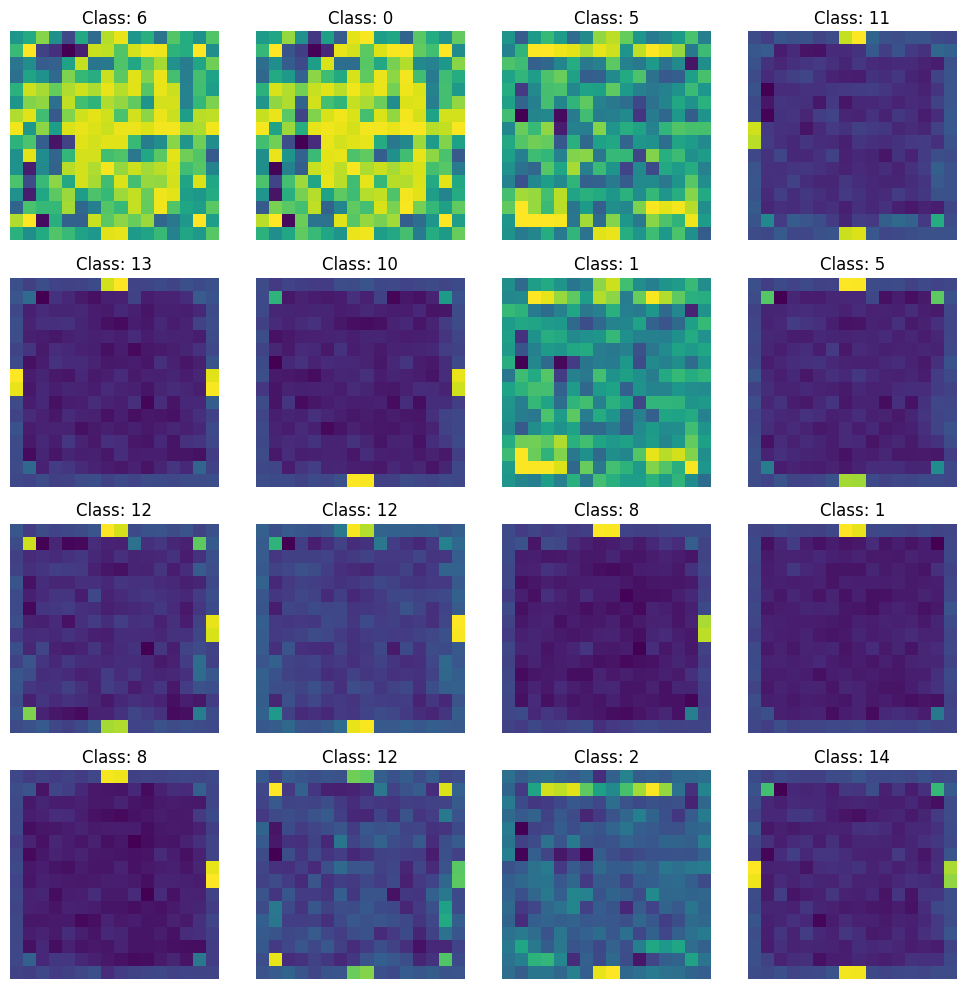

1/1 [==============================] - 0s 33ms/step
1600 [D loss: 0.19698172807693481 | D accuracy: 90.625] [G loss: 7.361942291259766]
1/1 [==============================] - 0s 32ms/step


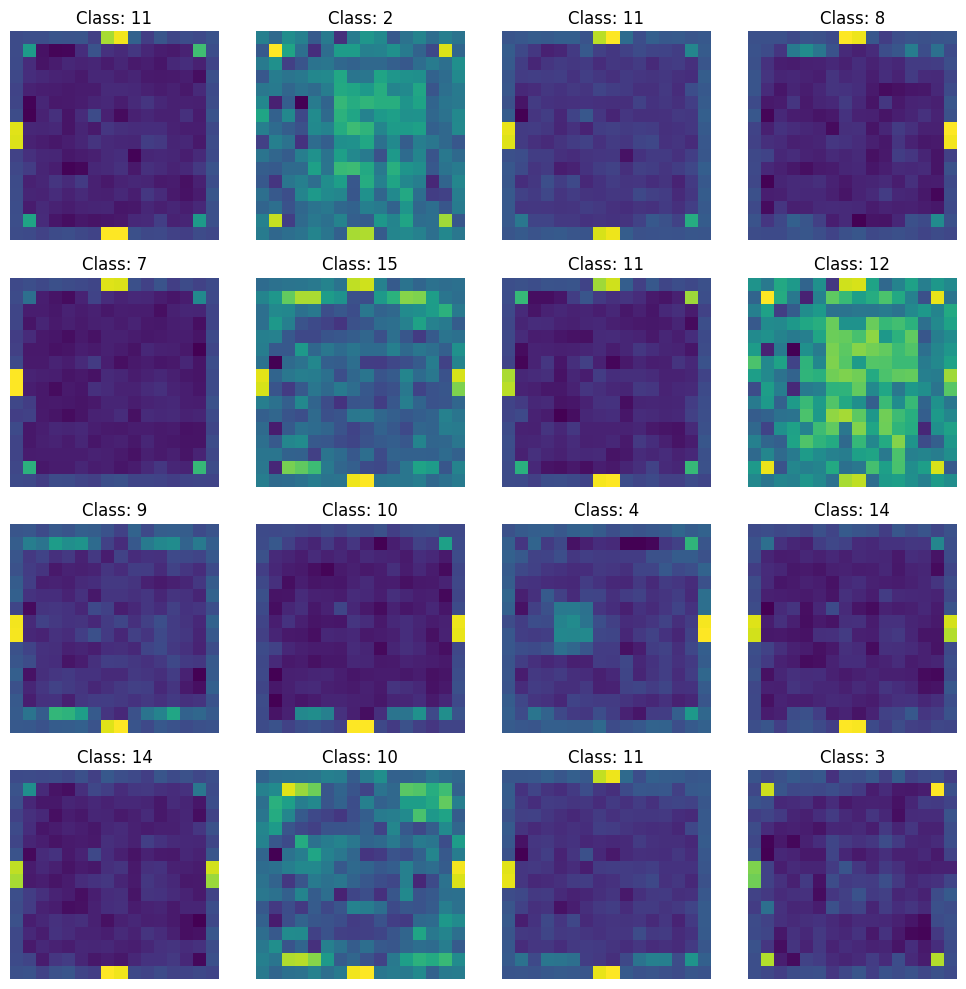

1/1 [==============================] - 0s 26ms/step
1700 [D loss: 0.0525262700393796 | D accuracy: 96.875] [G loss: 3.281430959701538]
1/1 [==============================] - 0s 25ms/step


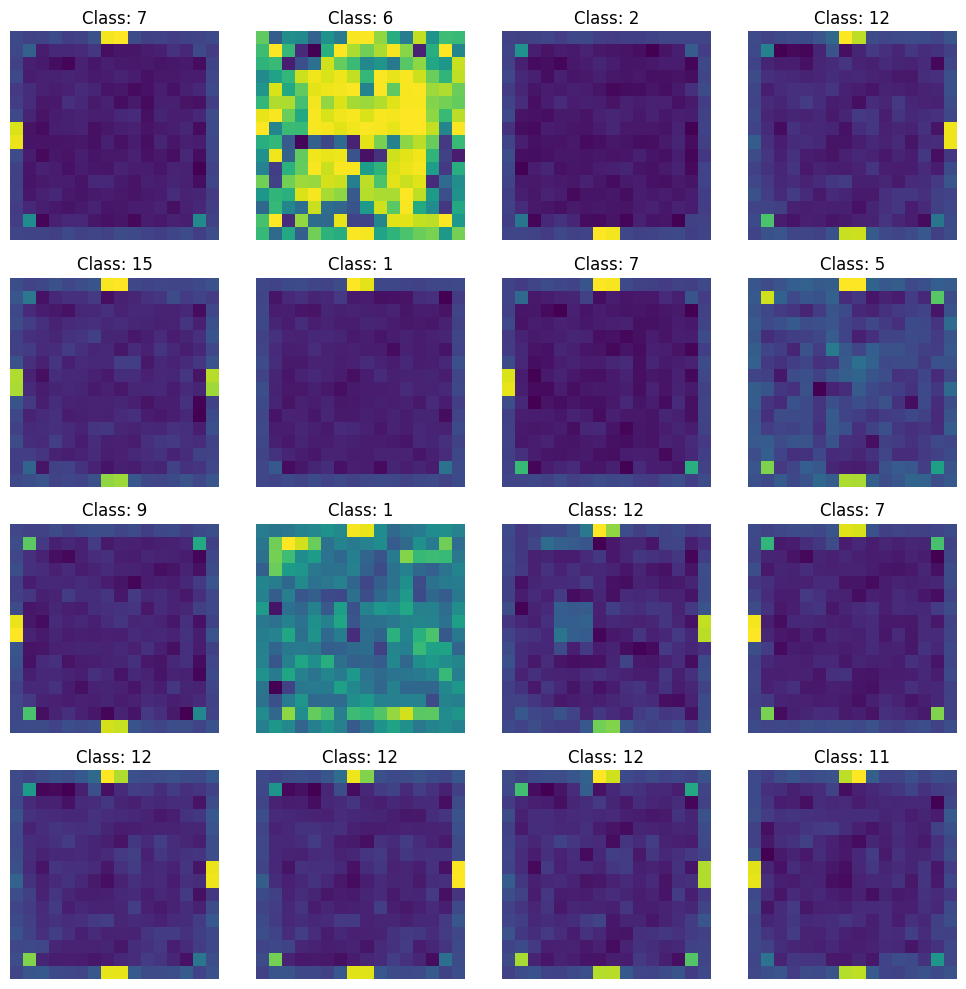

1/1 [==============================] - 0s 24ms/step
1800 [D loss: 0.31031762808561325 | D accuracy: 90.625] [G loss: 8.562309265136719]
1/1 [==============================] - 0s 24ms/step


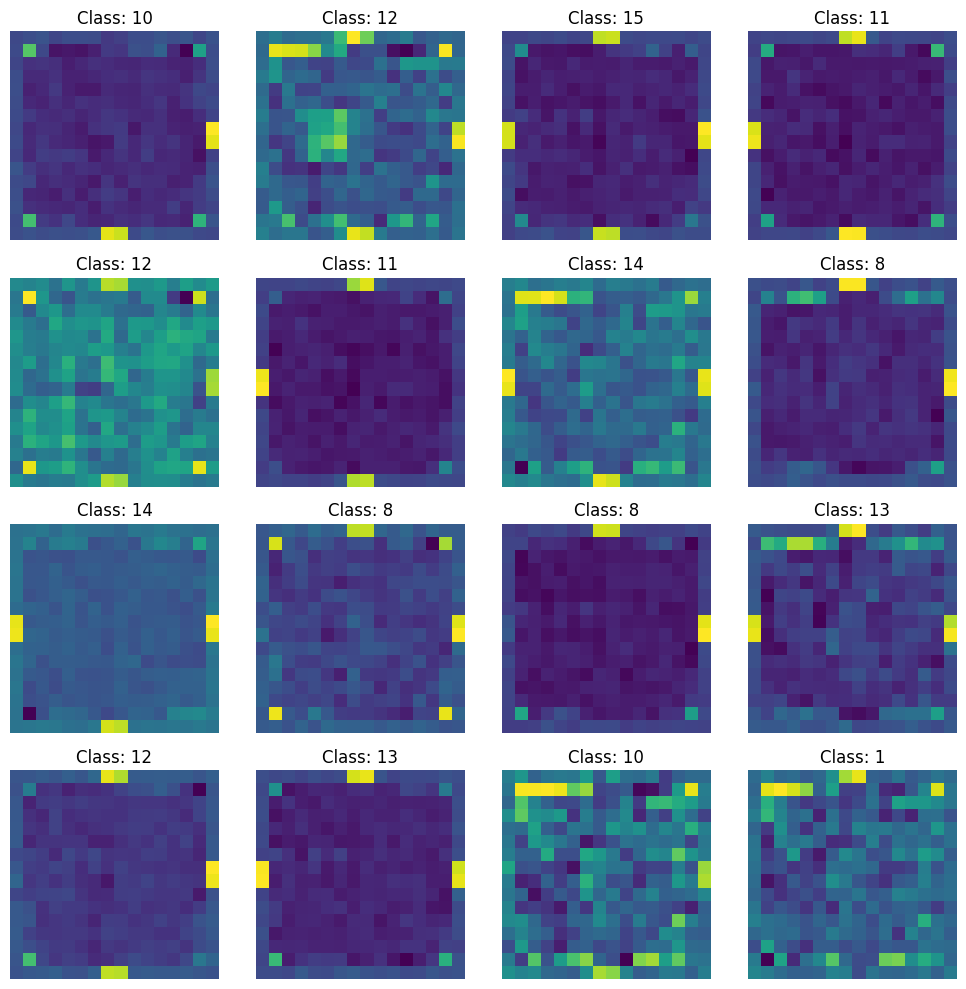

1/1 [==============================] - 0s 33ms/step
1900 [D loss: 0.28952999971807003 | D accuracy: 93.75] [G loss: 9.364435195922852]
1/1 [==============================] - 0s 71ms/step


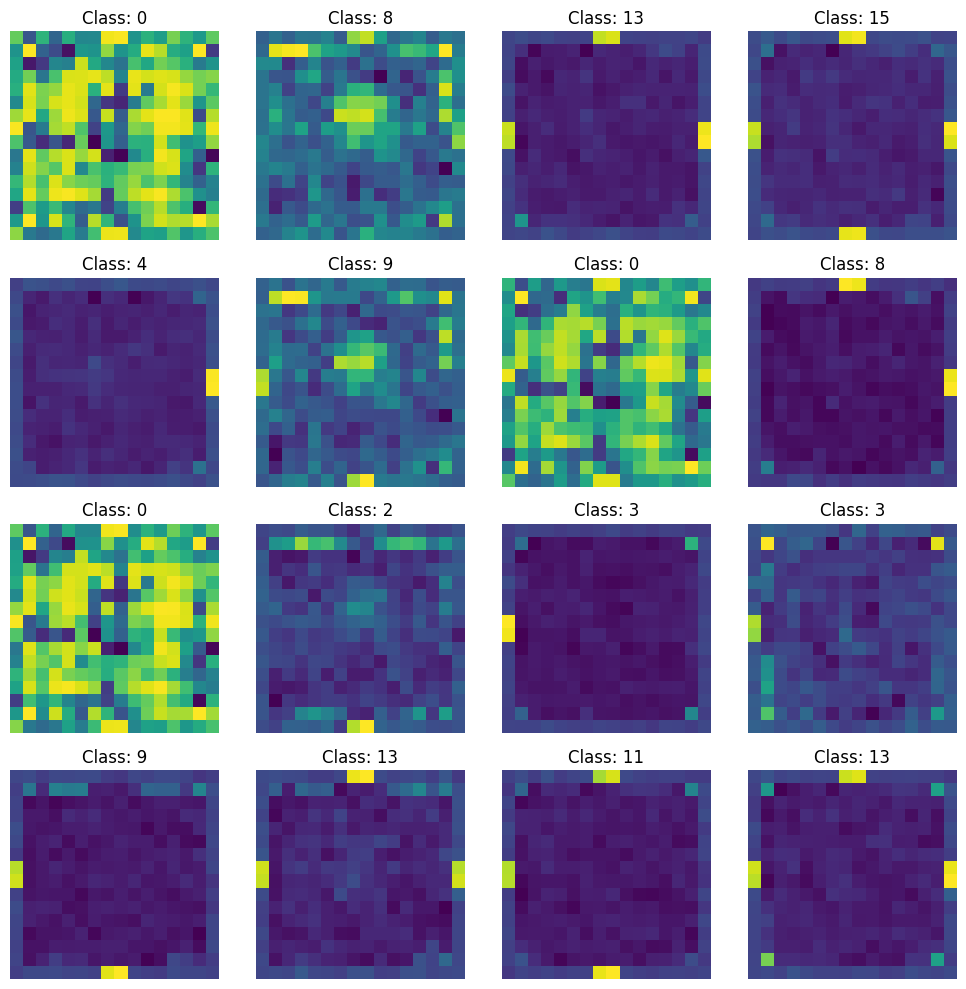

1/1 [==============================] - 0s 26ms/step
2000 [D loss: 0.20313172042369843 | D accuracy: 87.5] [G loss: 4.808110237121582]
1/1 [==============================] - 0s 27ms/step


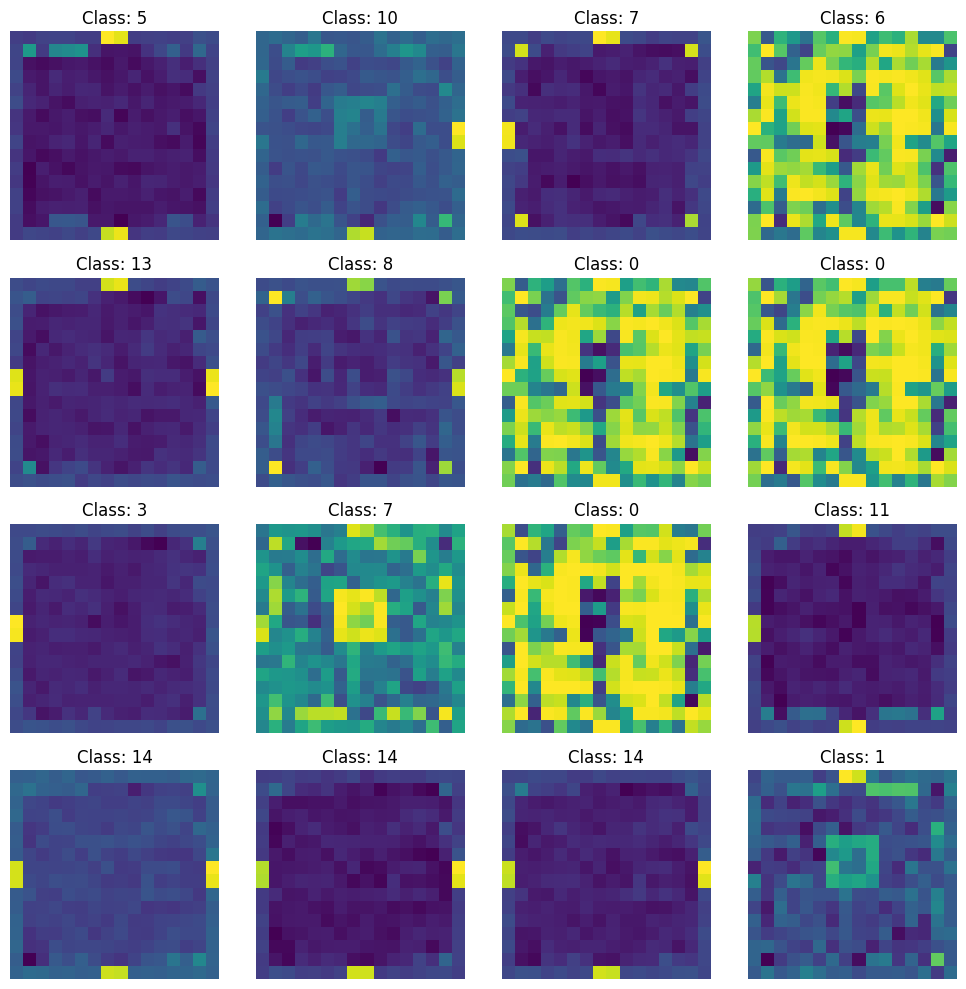

1/1 [==============================] - 0s 24ms/step
2100 [D loss: 0.2512942776083946 | D accuracy: 90.625] [G loss: 3.9890594482421875]
1/1 [==============================] - 0s 25ms/step


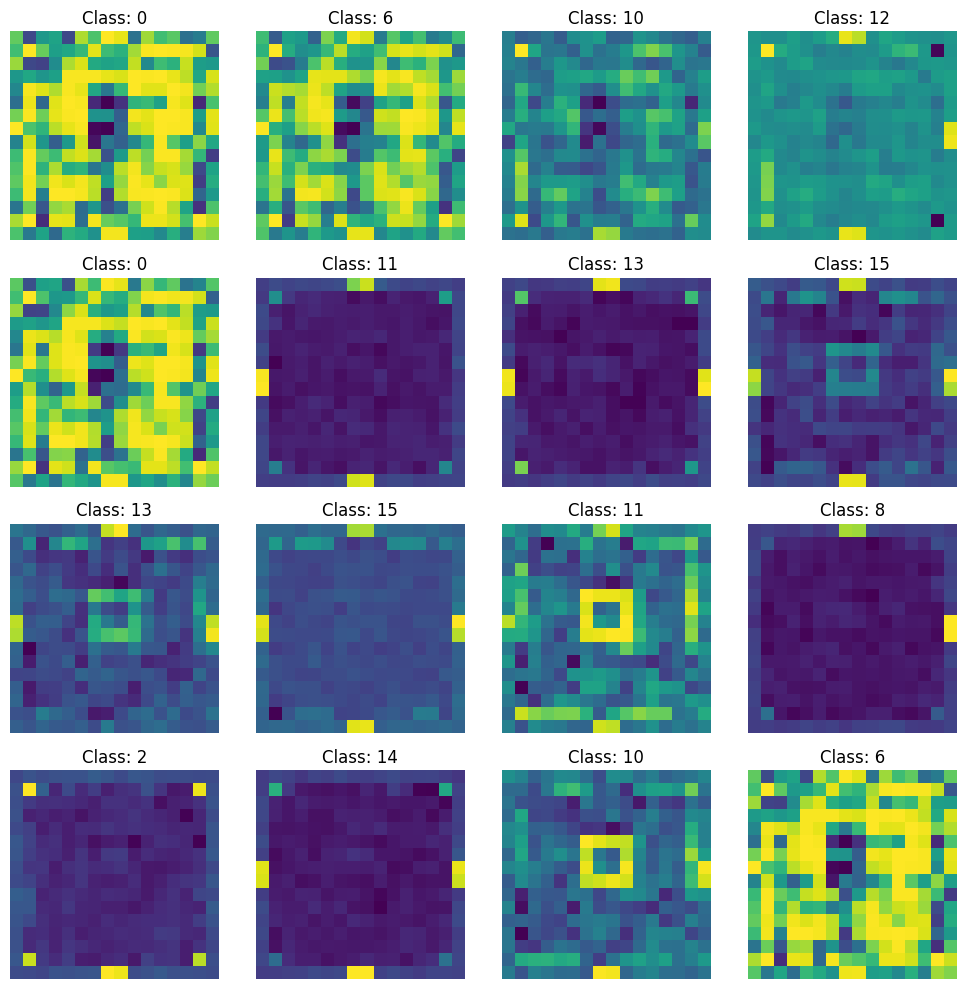

1/1 [==============================] - 0s 27ms/step
2200 [D loss: 0.2154560387134552 | D accuracy: 93.75] [G loss: 4.701632499694824]
1/1 [==============================] - 0s 22ms/step


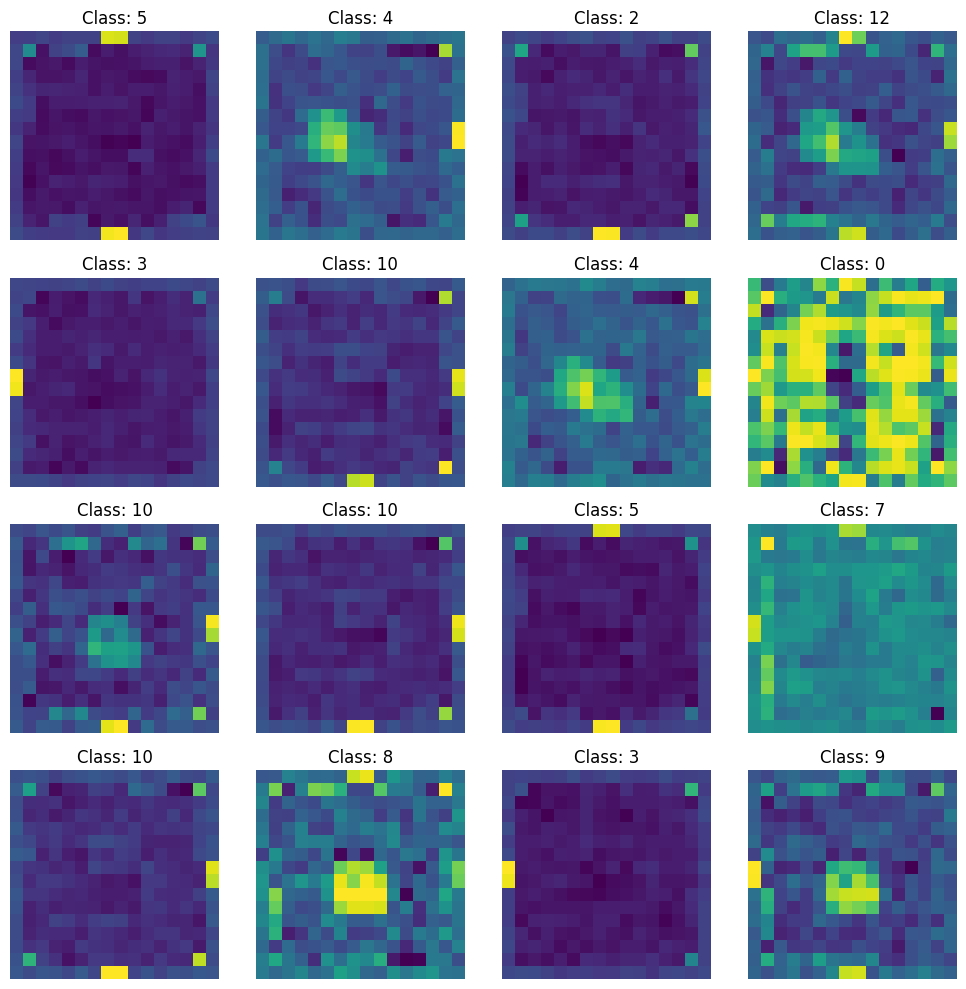

1/1 [==============================] - 0s 29ms/step
2300 [D loss: 0.722057580947876 | D accuracy: 78.125] [G loss: 6.03692626953125]
1/1 [==============================] - 0s 29ms/step


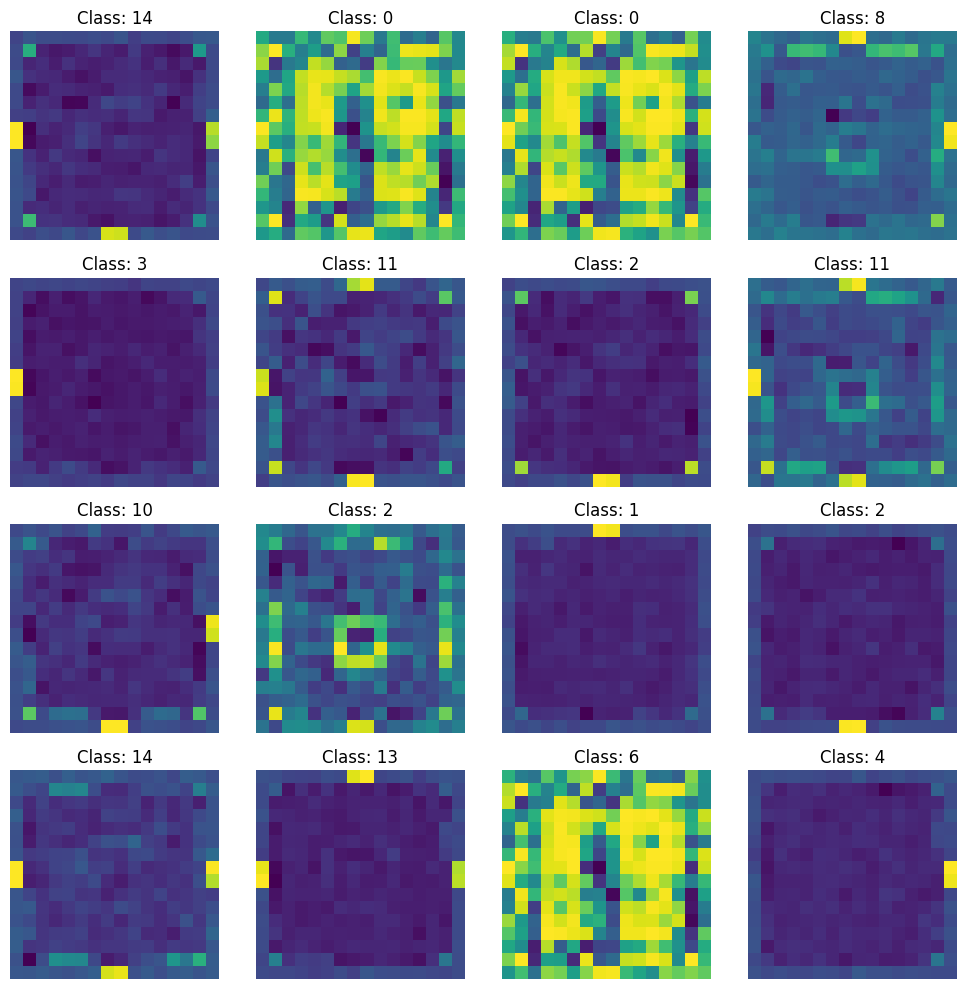

1/1 [==============================] - 0s 29ms/step
2400 [D loss: 0.1876048520207405 | D accuracy: 93.75] [G loss: 4.559813499450684]
1/1 [==============================] - 0s 56ms/step


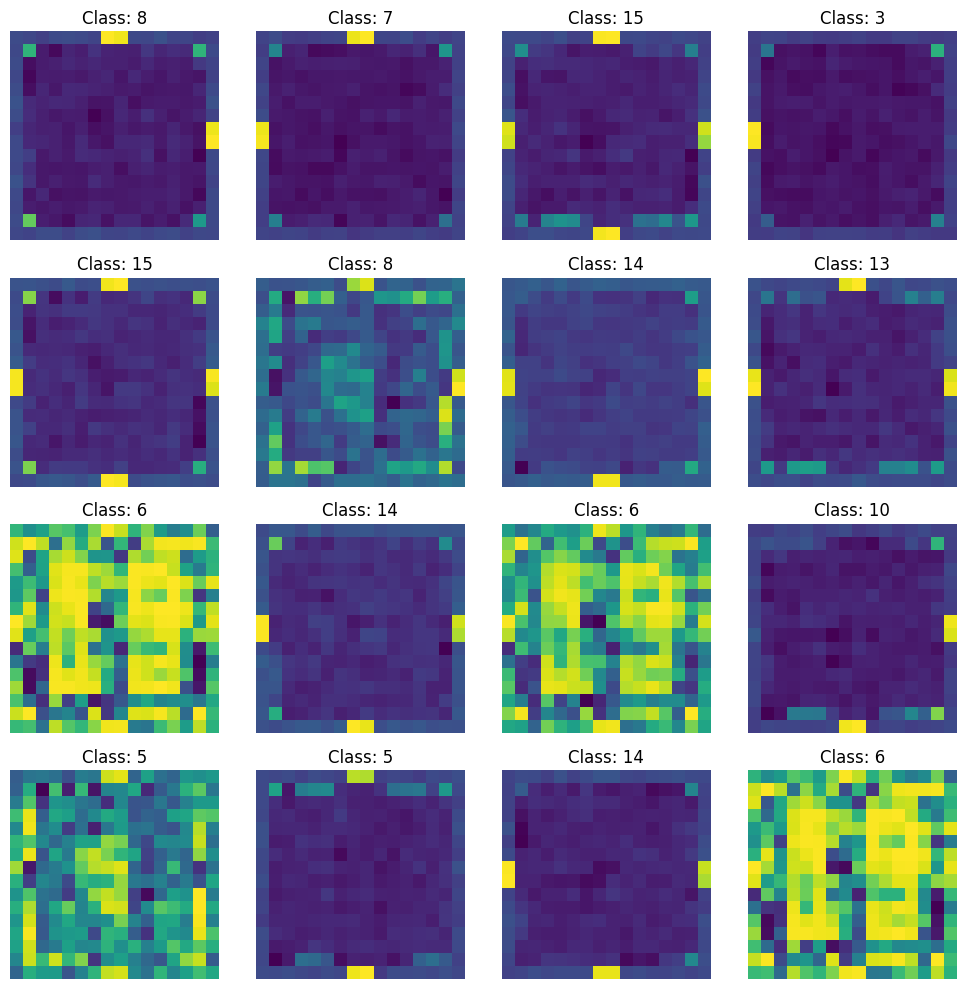

1/1 [==============================] - 0s 41ms/step
2500 [D loss: 0.5642781853675842 | D accuracy: 84.375] [G loss: 6.161375522613525]
1/1 [==============================] - 0s 51ms/step


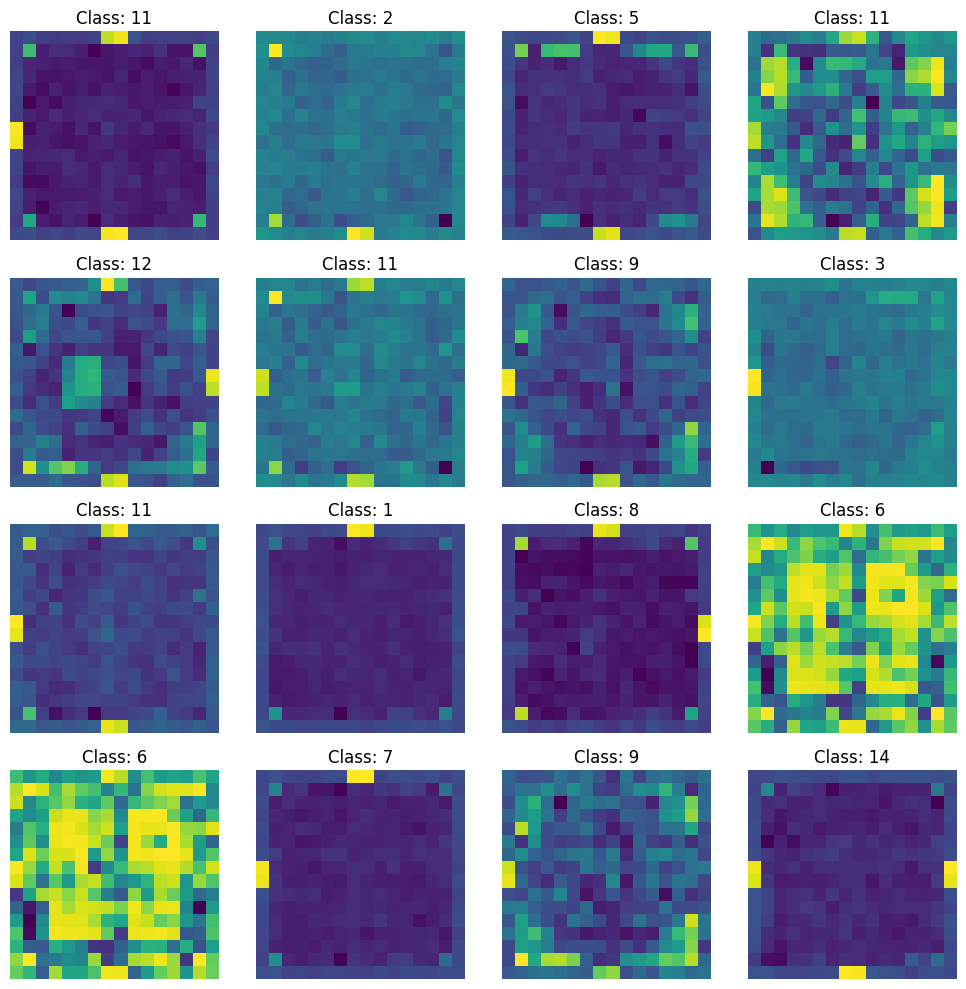

1/1 [==============================] - 0s 34ms/step
2600 [D loss: 0.12878874456509948 | D accuracy: 96.875] [G loss: 12.20977783203125]
1/1 [==============================] - 0s 40ms/step


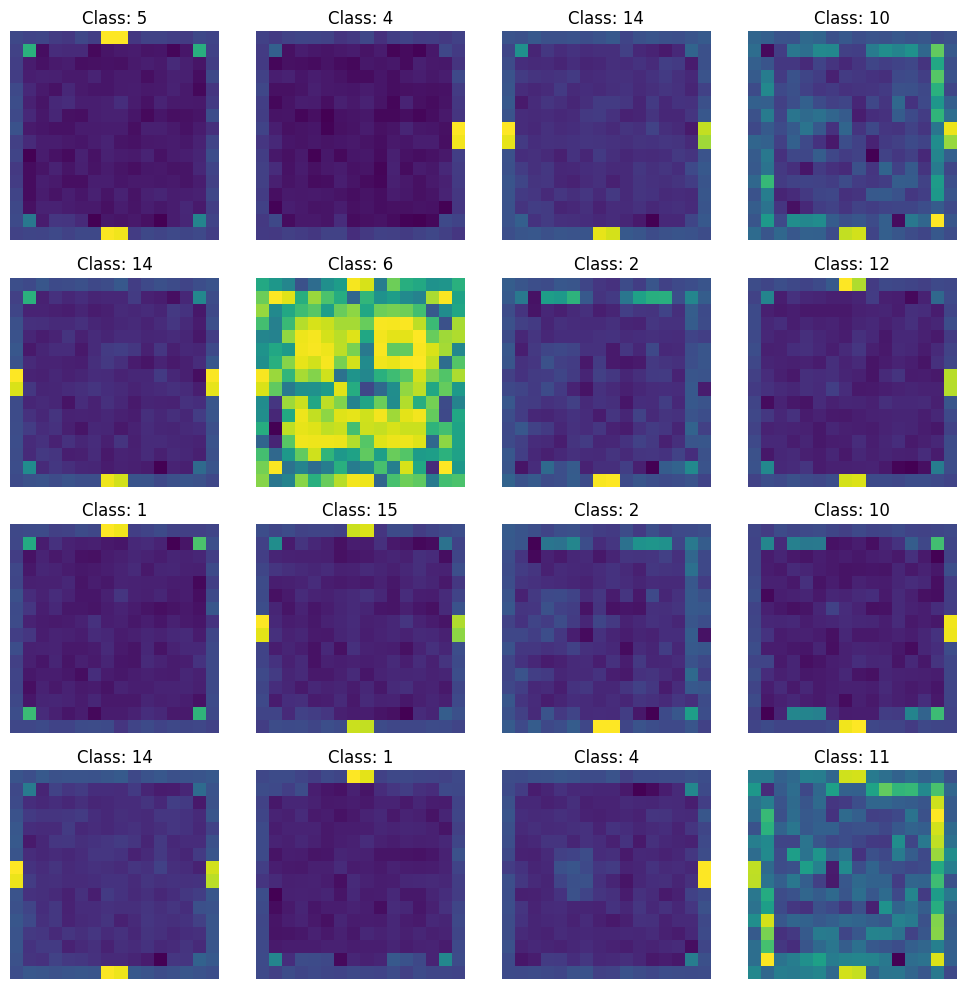

1/1 [==============================] - 0s 44ms/step
2700 [D loss: 0.0675564706325531 | D accuracy: 100.0] [G loss: 7.341742515563965]
1/1 [==============================] - 0s 47ms/step


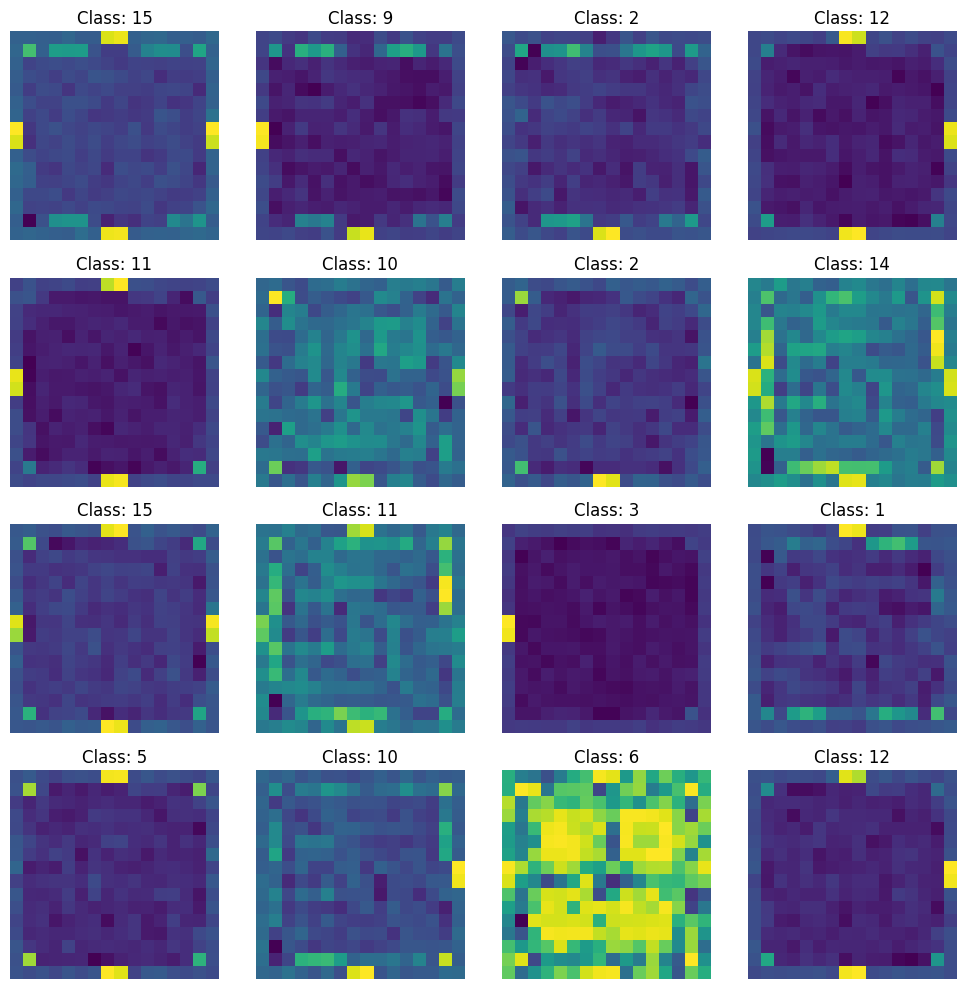

1/1 [==============================] - 0s 27ms/step
2800 [D loss: 0.2127455696463585 | D accuracy: 93.75] [G loss: 5.564107894897461]
1/1 [==============================] - 0s 28ms/step


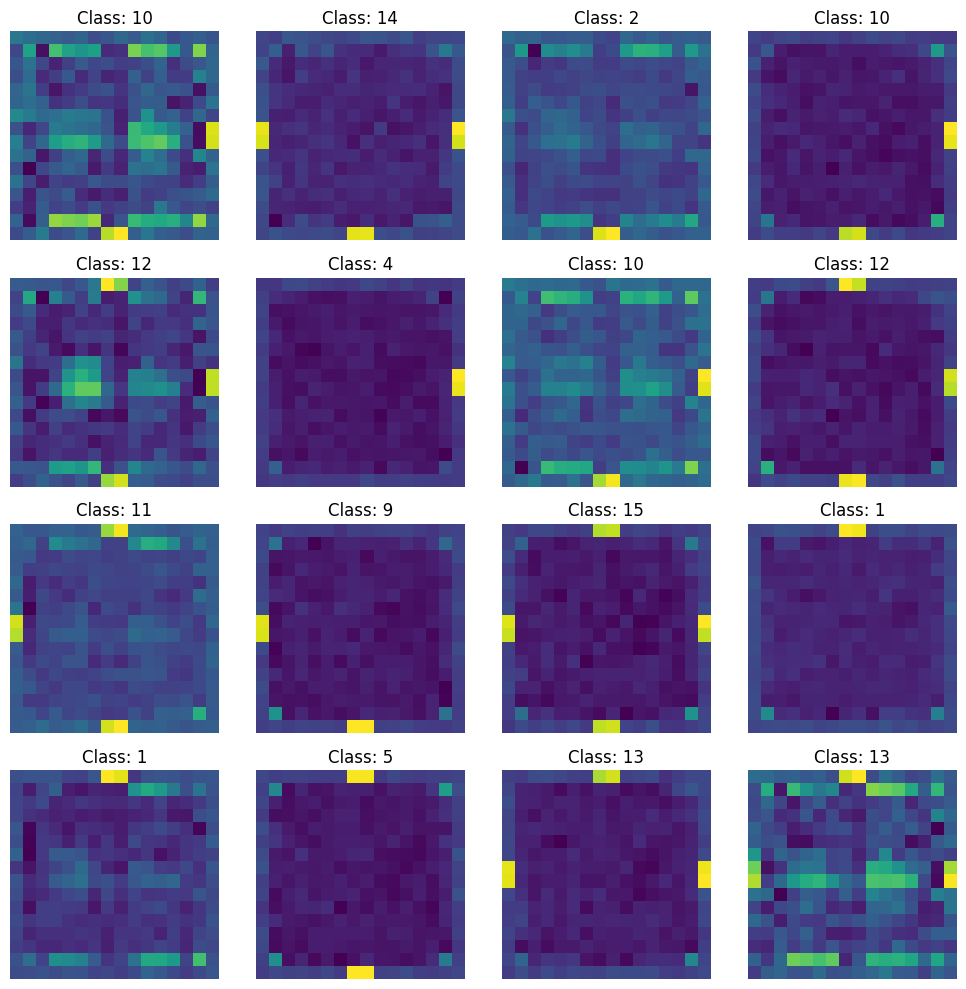

1/1 [==============================] - 0s 23ms/step
2900 [D loss: 0.16229954361915588 | D accuracy: 93.75] [G loss: 9.801091194152832]
1/1 [==============================] - 0s 23ms/step


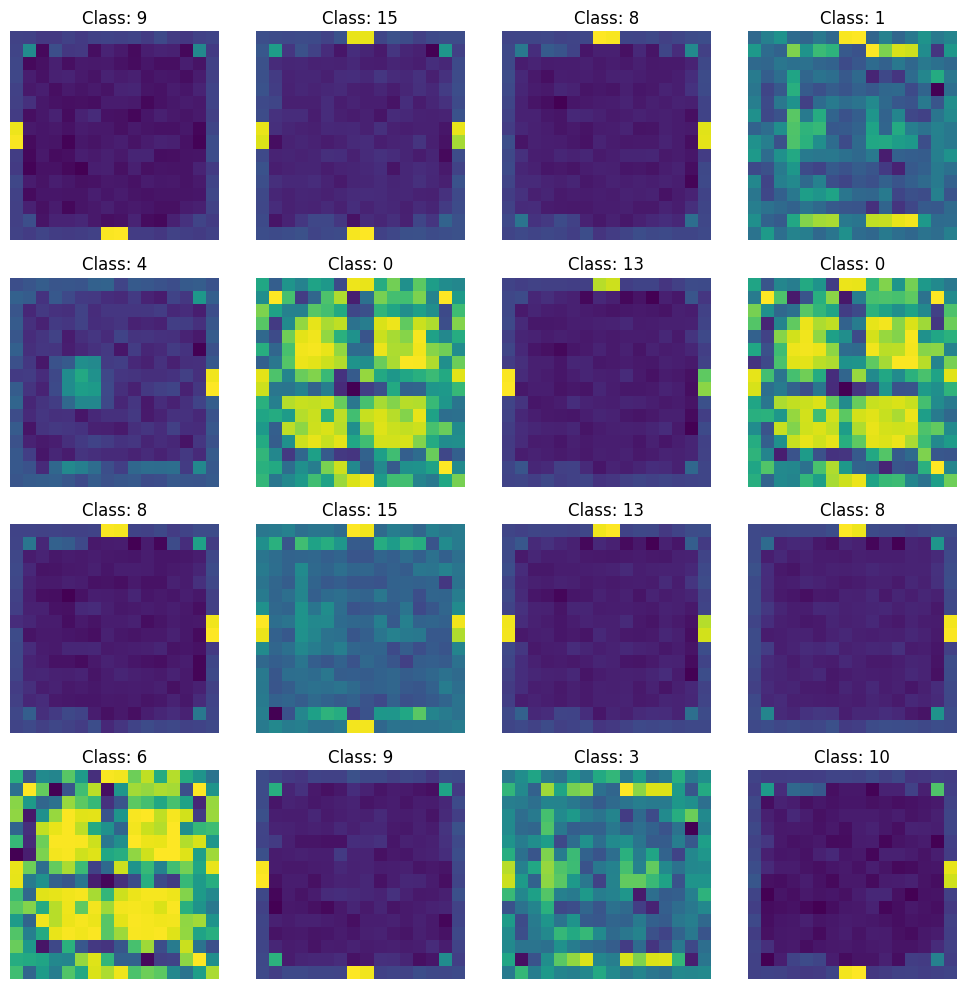

1/1 [==============================] - 0s 42ms/step
3000 [D loss: 0.1353443693369627 | D accuracy: 96.875] [G loss: 6.945623874664307]
1/1 [==============================] - 0s 35ms/step


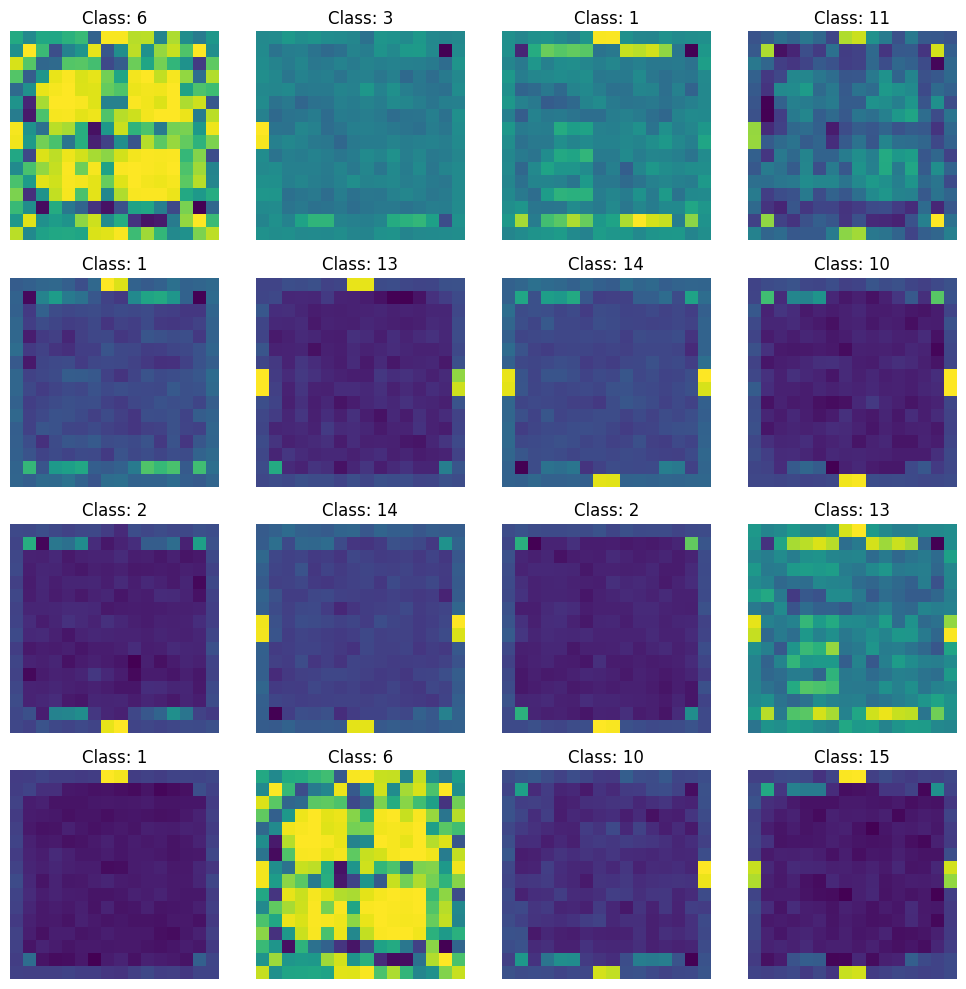

1/1 [==============================] - 0s 28ms/step
3100 [D loss: 0.11303955875337124 | D accuracy: 93.75] [G loss: 6.97130823135376]
1/1 [==============================] - 0s 27ms/step


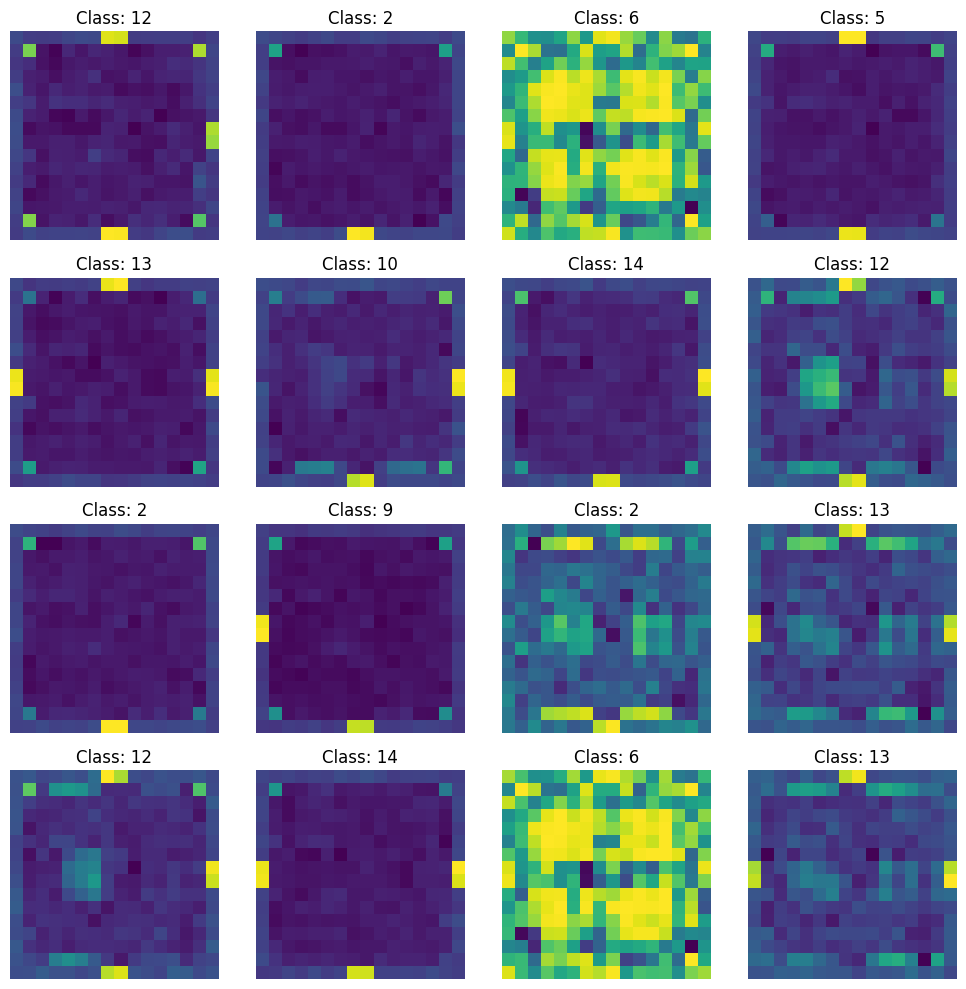

1/1 [==============================] - 0s 36ms/step
3200 [D loss: 0.2680421397089958 | D accuracy: 93.75] [G loss: 5.811424255371094]
1/1 [==============================] - 0s 37ms/step


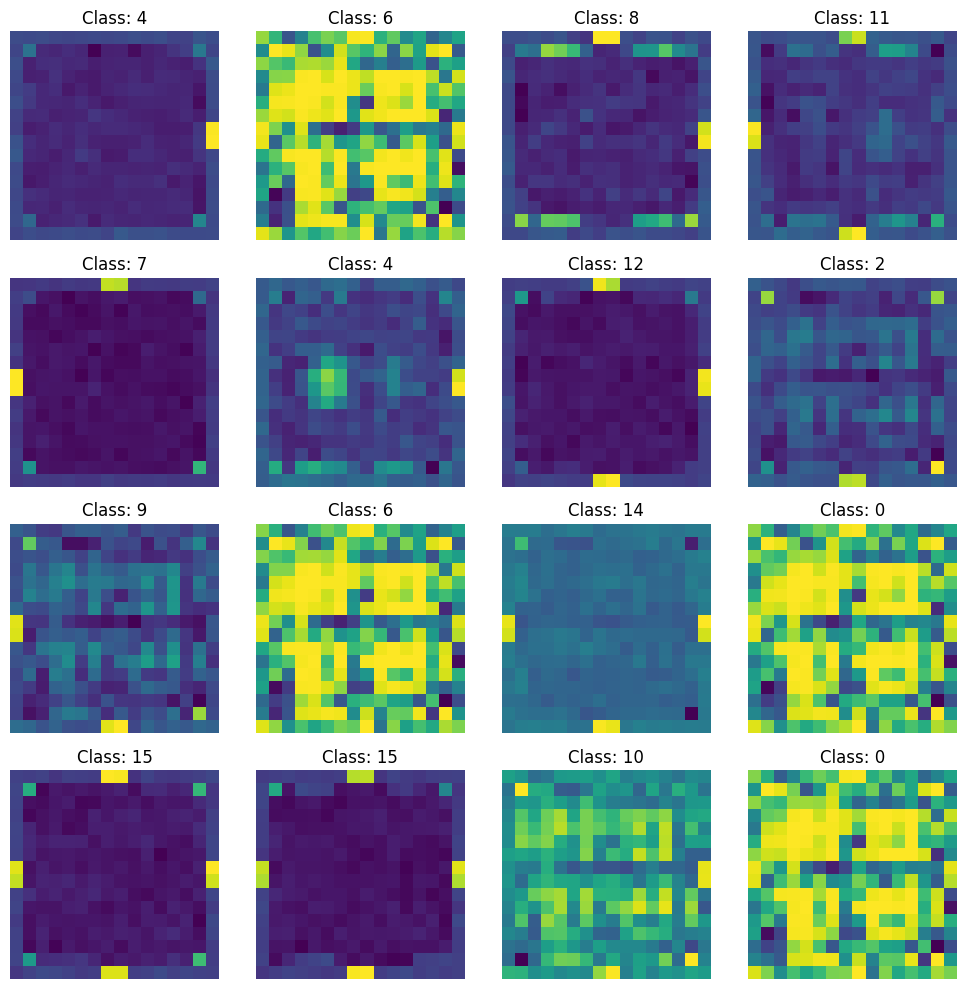

1/1 [==============================] - 0s 34ms/step
3300 [D loss: 0.06716474890708923 | D accuracy: 96.875] [G loss: 4.6663923263549805]
1/1 [==============================] - 0s 30ms/step


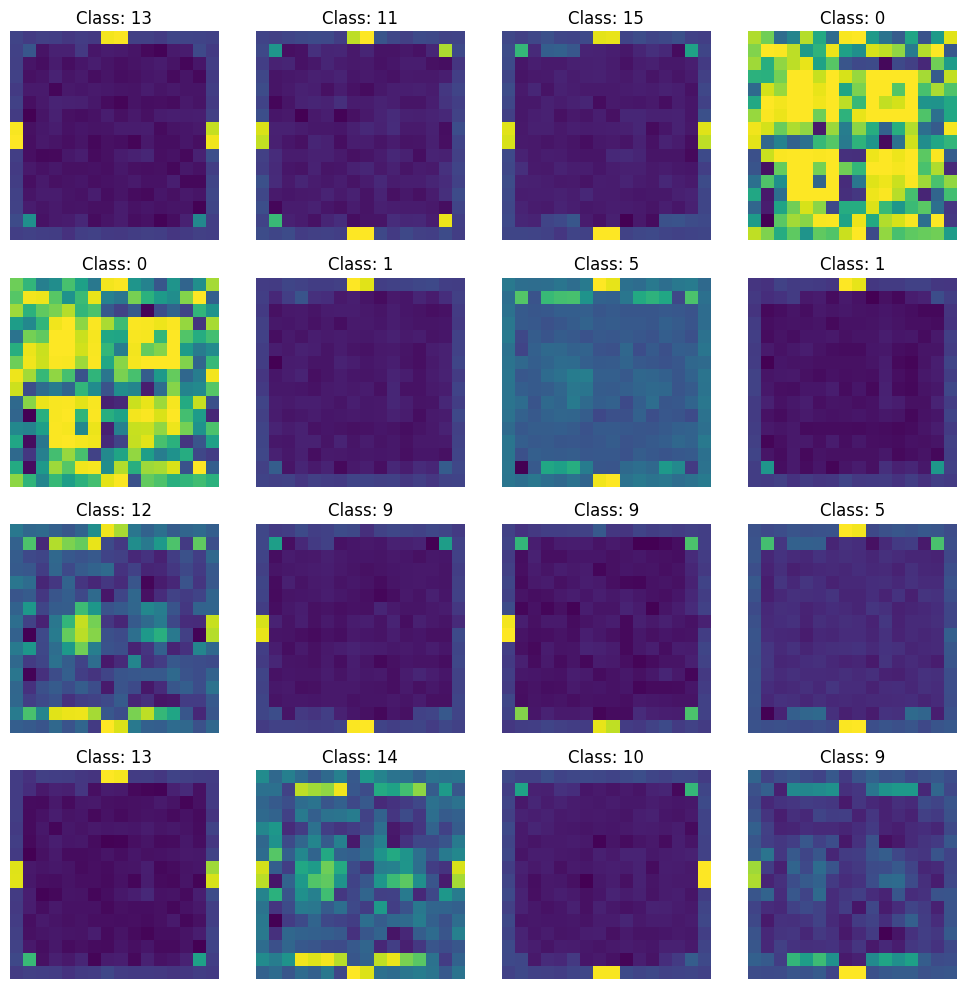

1/1 [==============================] - 0s 42ms/step
3400 [D loss: 0.17305278778076172 | D accuracy: 93.75] [G loss: 7.063197612762451]
1/1 [==============================] - 0s 53ms/step


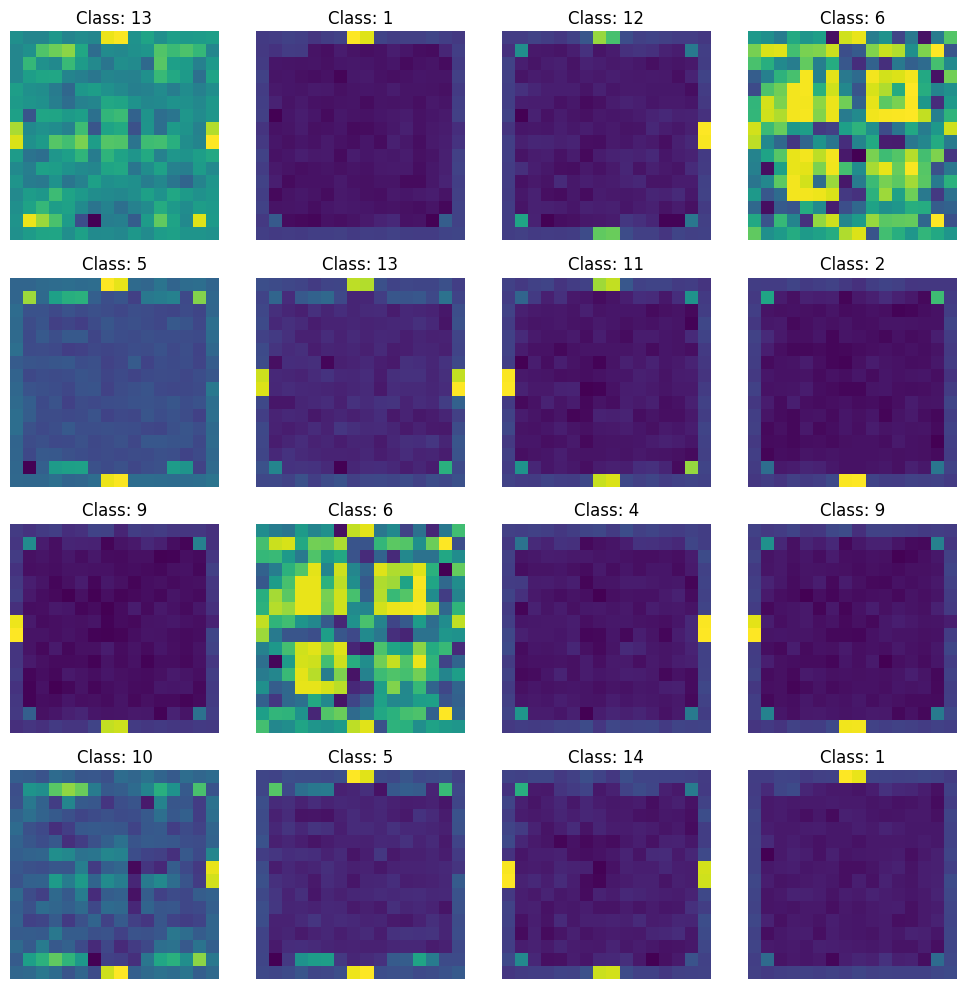

1/1 [==============================] - 0s 32ms/step
3500 [D loss: 0.15442728996276855 | D accuracy: 96.875] [G loss: 4.586193084716797]
1/1 [==============================] - 0s 23ms/step


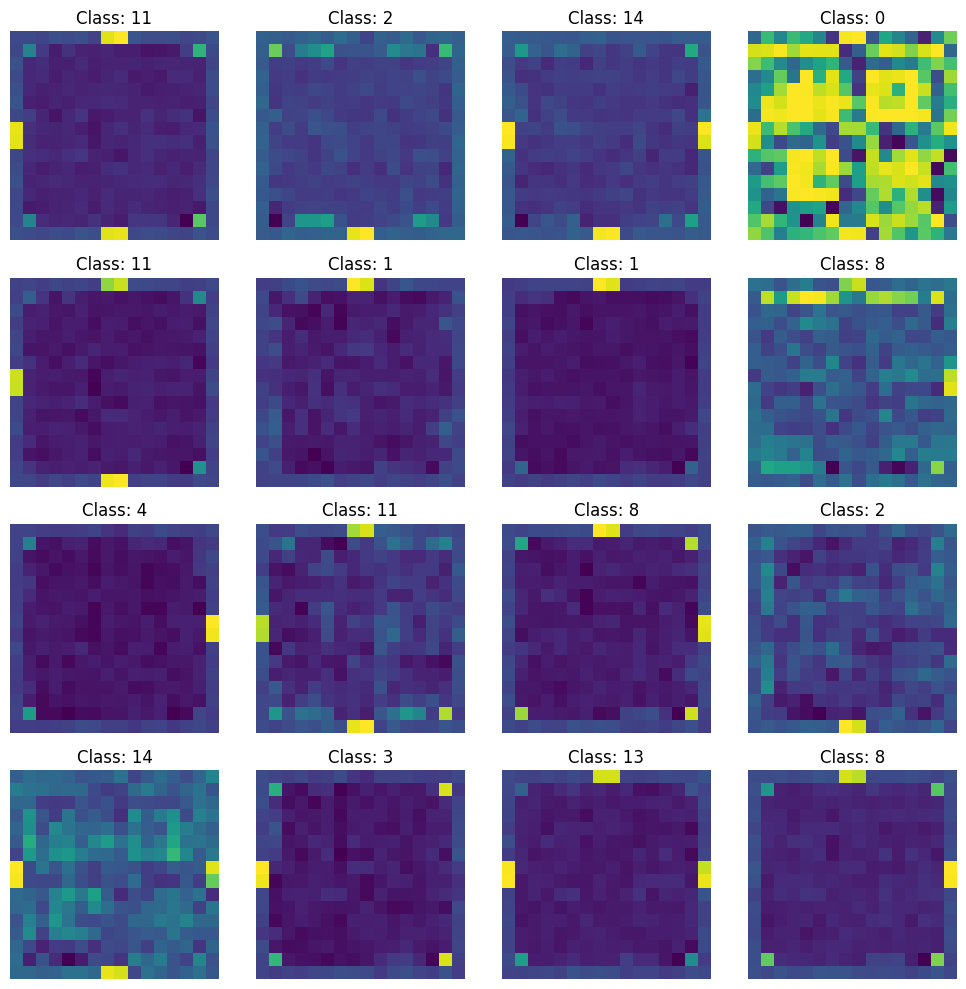

1/1 [==============================] - 0s 25ms/step
3600 [D loss: 0.2752813547849655 | D accuracy: 90.625] [G loss: 5.770061492919922]
1/1 [==============================] - 0s 24ms/step


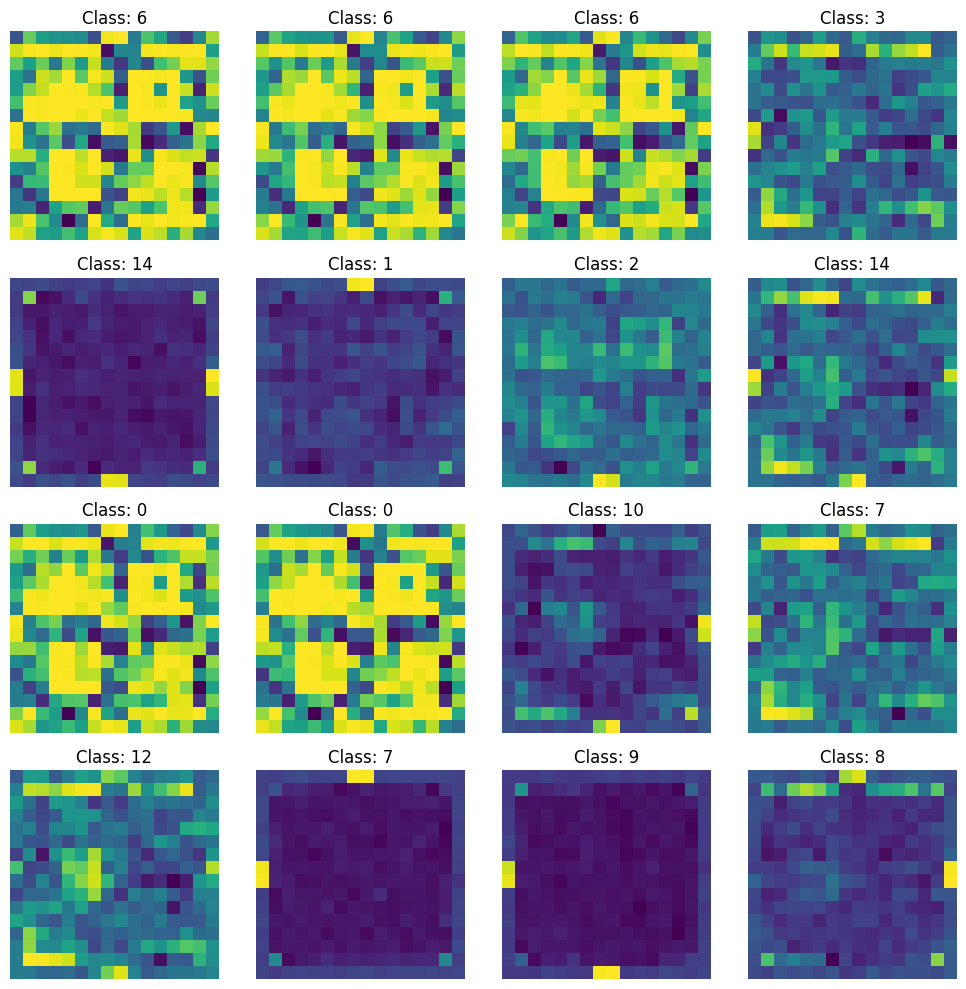

1/1 [==============================] - 0s 37ms/step
3700 [D loss: 0.19313418865203857 | D accuracy: 90.625] [G loss: 8.442107200622559]
1/1 [==============================] - 0s 58ms/step


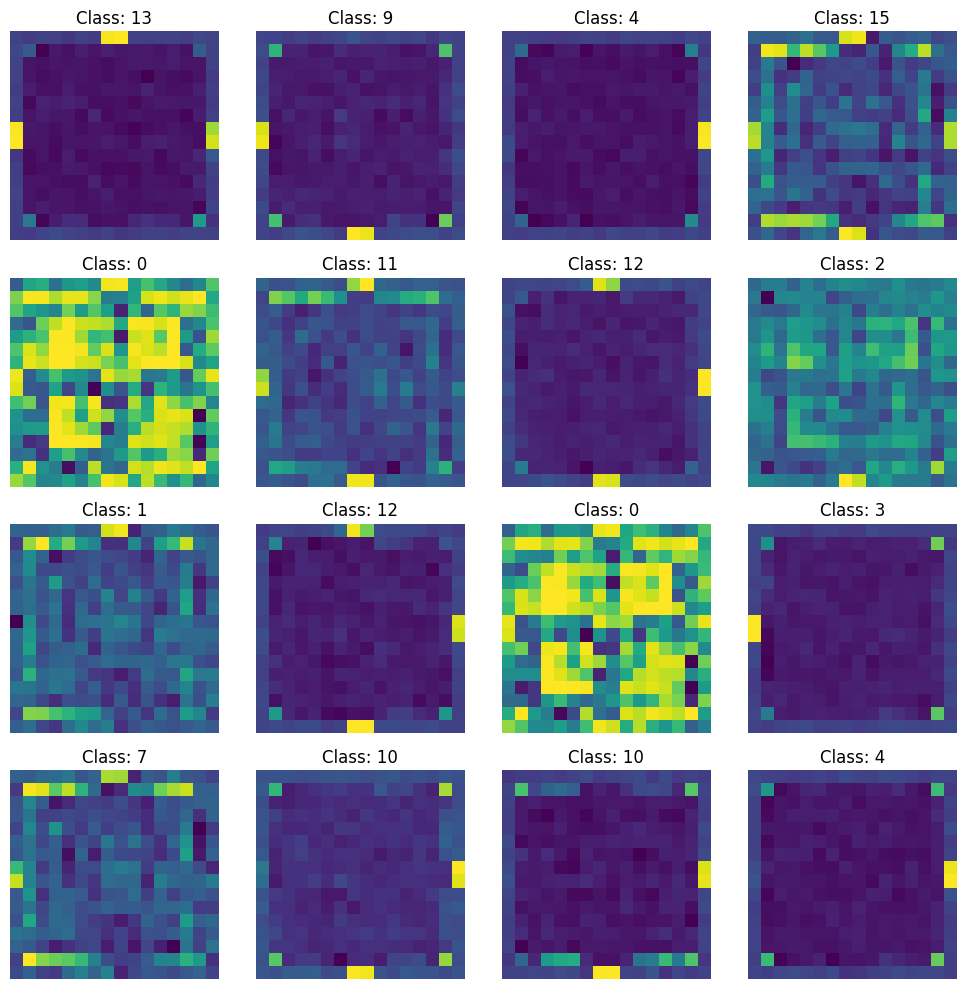

1/1 [==============================] - 0s 43ms/step
3800 [D loss: 0.09841950982809067 | D accuracy: 96.875] [G loss: 4.919257164001465]
1/1 [==============================] - 0s 41ms/step


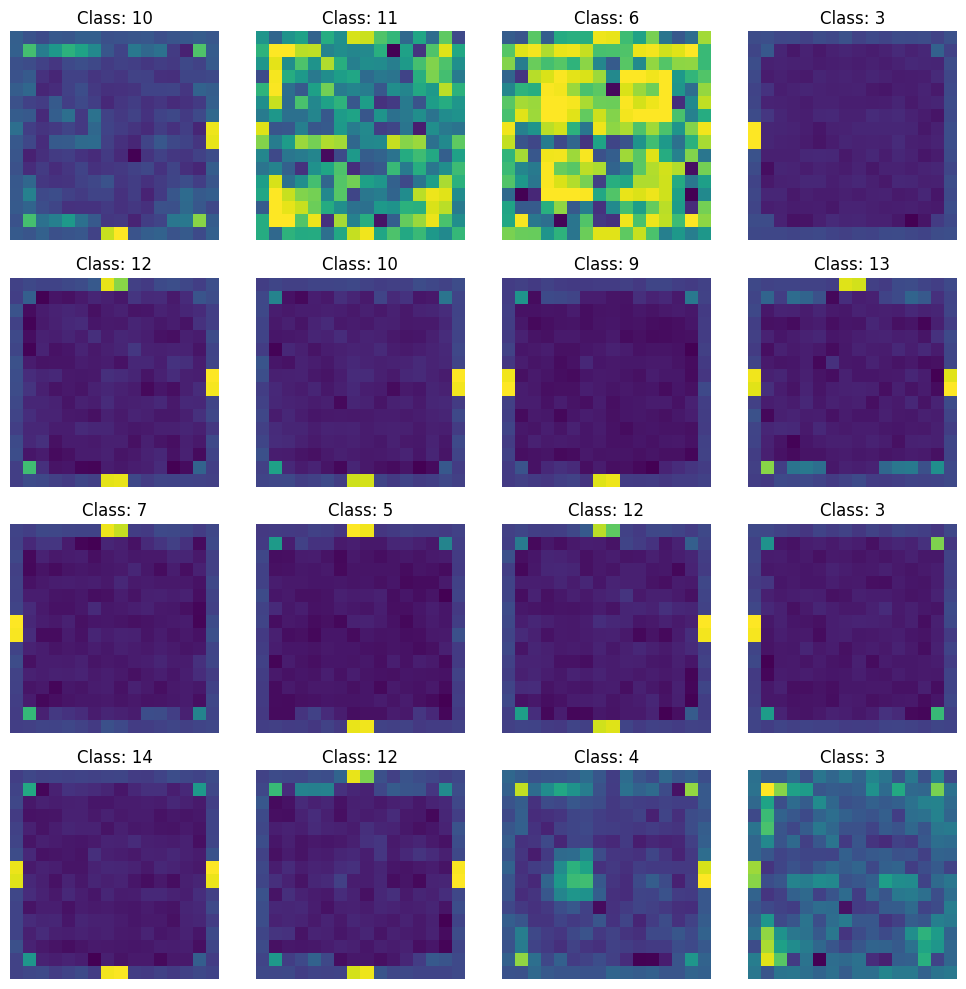

1/1 [==============================] - 0s 23ms/step
3900 [D loss: 0.2774593457579613 | D accuracy: 87.5] [G loss: 6.476242542266846]
1/1 [==============================] - 0s 23ms/step


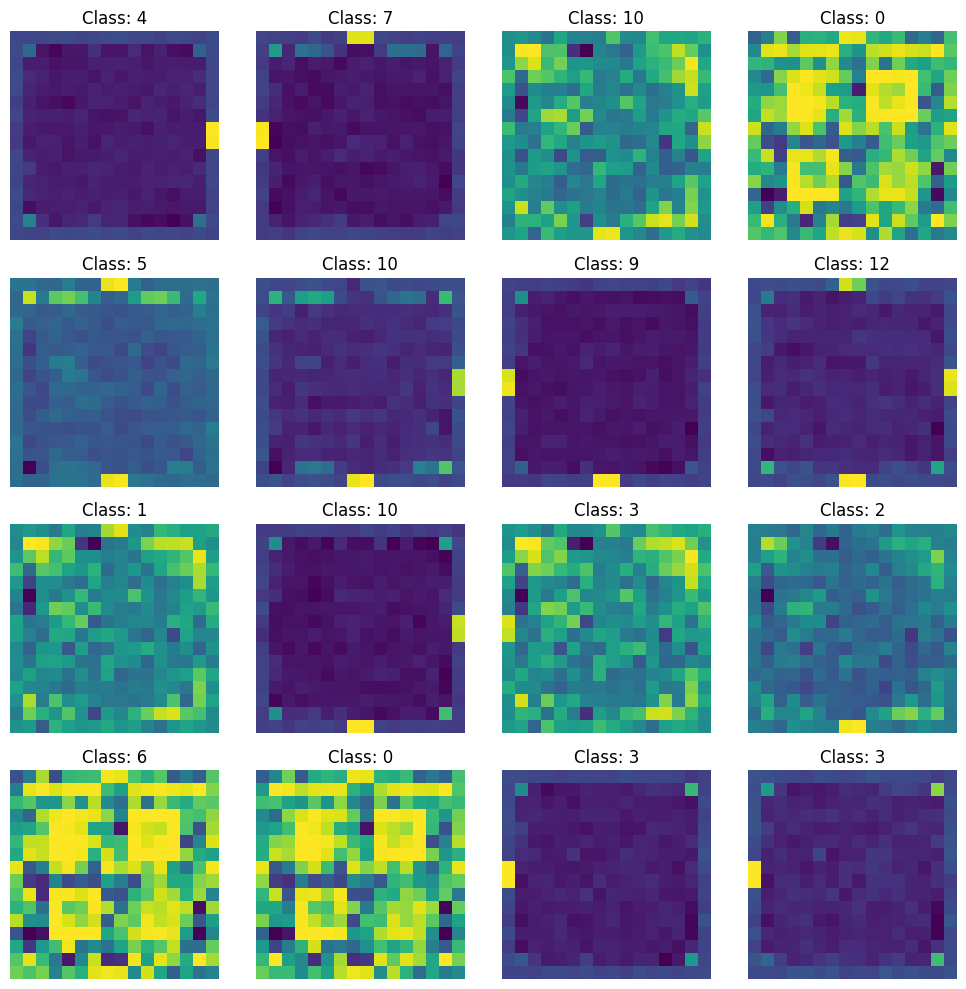

1/1 [==============================] - 0s 32ms/step
4000 [D loss: 0.20178703218698502 | D accuracy: 90.625] [G loss: 7.732364654541016]
1/1 [==============================] - 0s 32ms/step


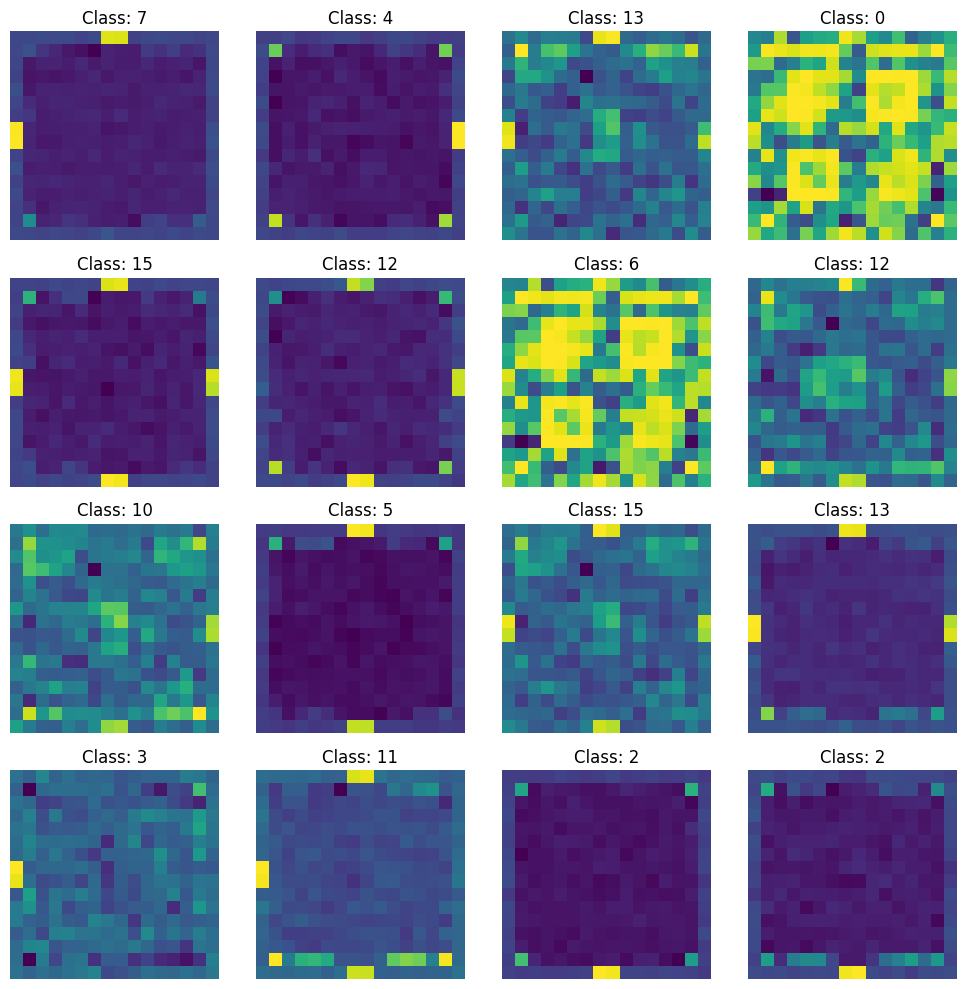

1/1 [==============================] - 0s 28ms/step
4100 [D loss: 0.4088898003101349 | D accuracy: 84.375] [G loss: 6.950944423675537]
1/1 [==============================] - 0s 27ms/step


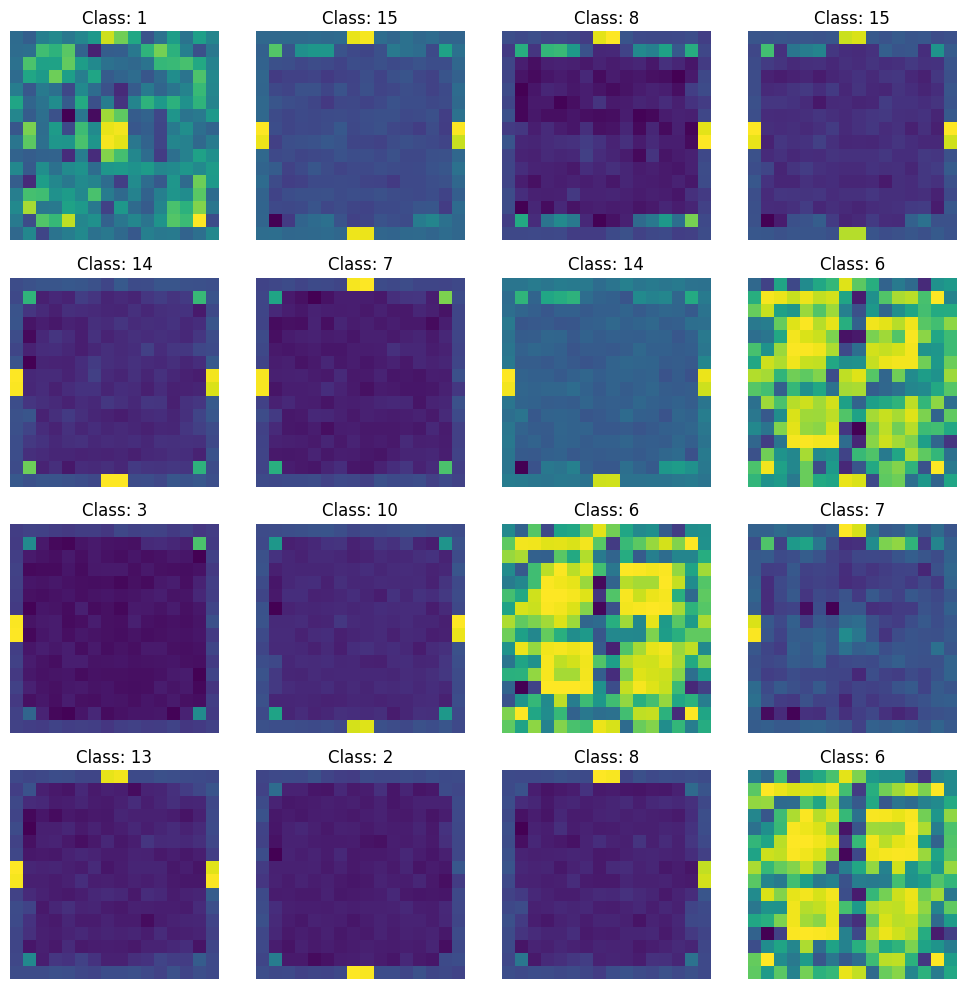

1/1 [==============================] - 0s 24ms/step
4200 [D loss: 0.11851634085178375 | D accuracy: 96.875] [G loss: 4.569525241851807]
1/1 [==============================] - 0s 26ms/step


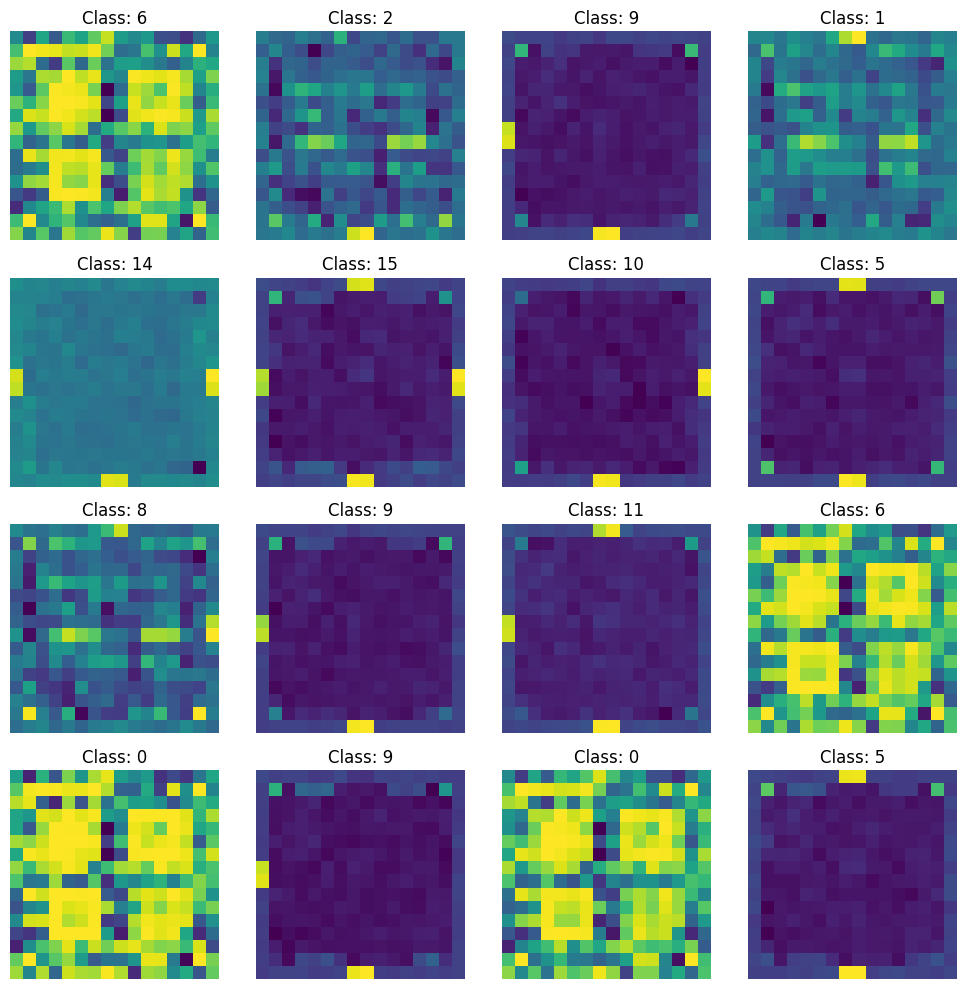

1/1 [==============================] - 0s 22ms/step
4300 [D loss: 0.26363511197268963 | D accuracy: 90.625] [G loss: 7.036720275878906]
1/1 [==============================] - 0s 22ms/step


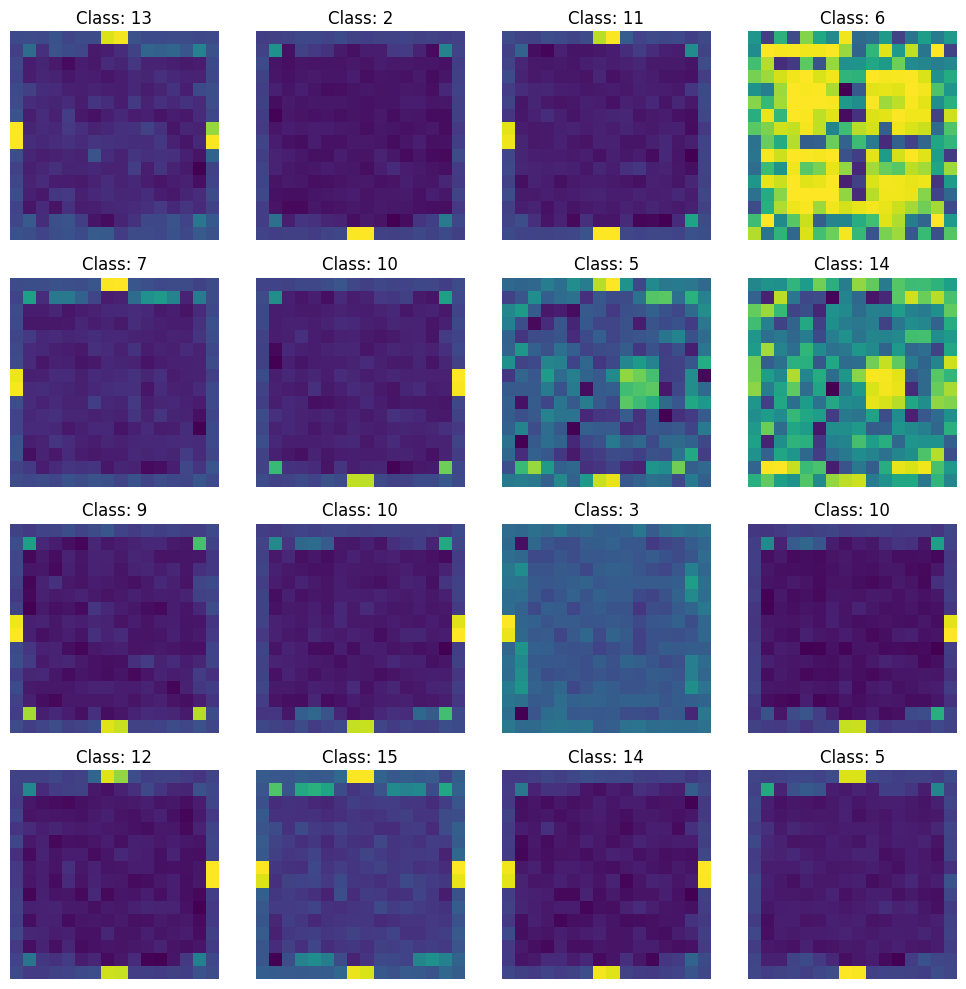

1/1 [==============================] - 0s 30ms/step
4400 [D loss: 0.15891332924365997 | D accuracy: 93.75] [G loss: 8.187830924987793]
1/1 [==============================] - 0s 35ms/step


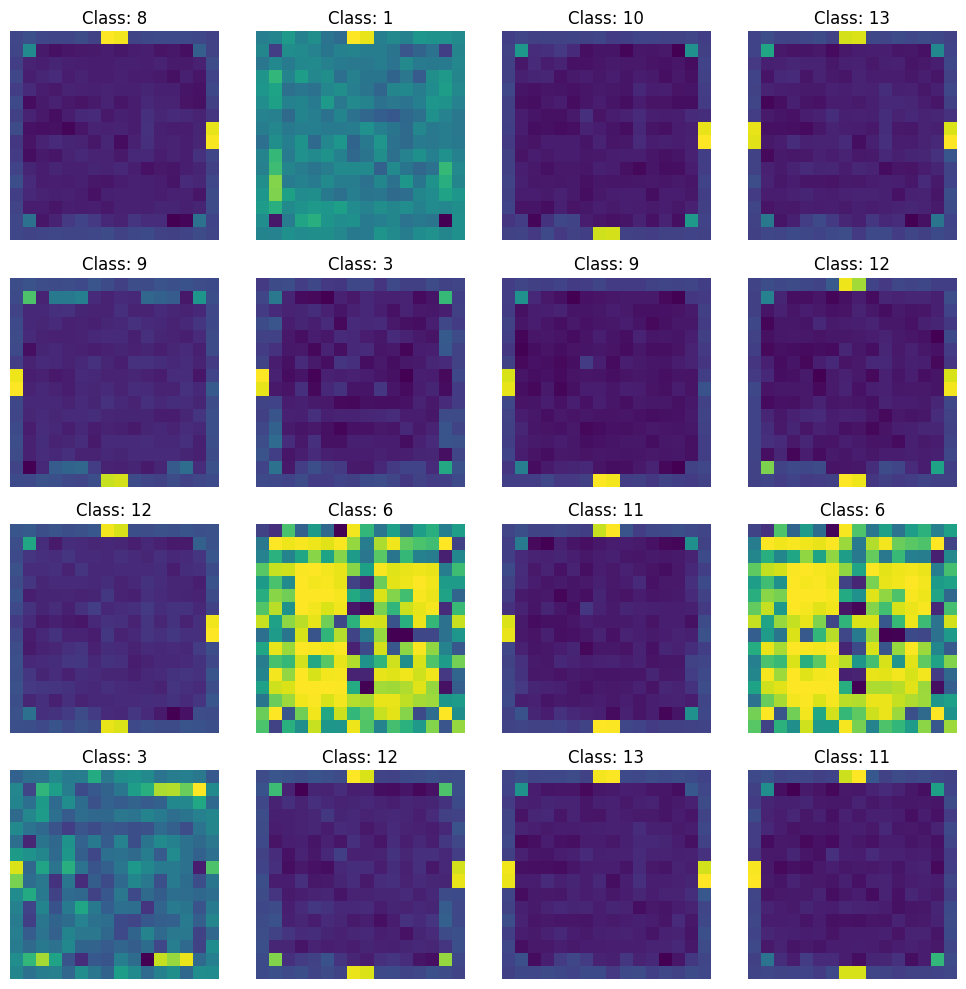

1/1 [==============================] - 0s 29ms/step
4500 [D loss: 0.21372779458761215 | D accuracy: 90.625] [G loss: 9.323486328125]
1/1 [==============================] - 0s 26ms/step


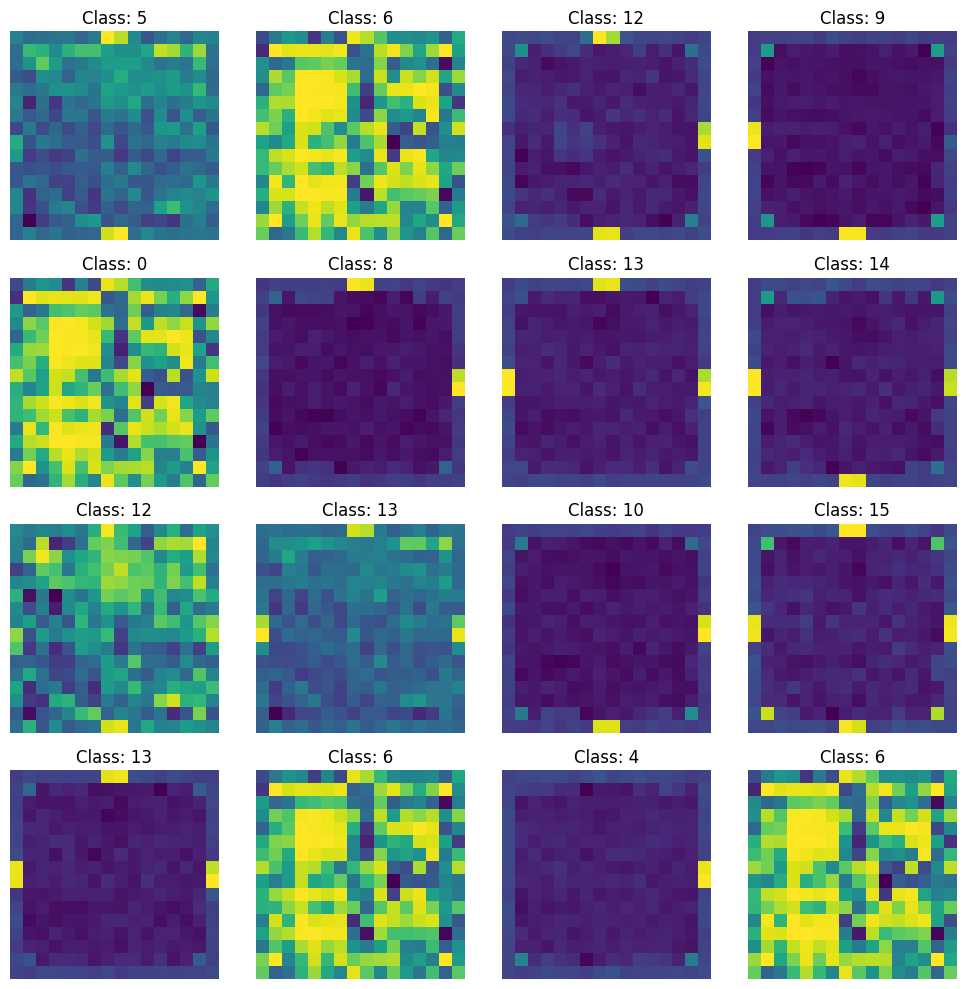

1/1 [==============================] - 0s 22ms/step
4600 [D loss: 0.21662019938230515 | D accuracy: 93.75] [G loss: 4.5229339599609375]
1/1 [==============================] - 0s 26ms/step


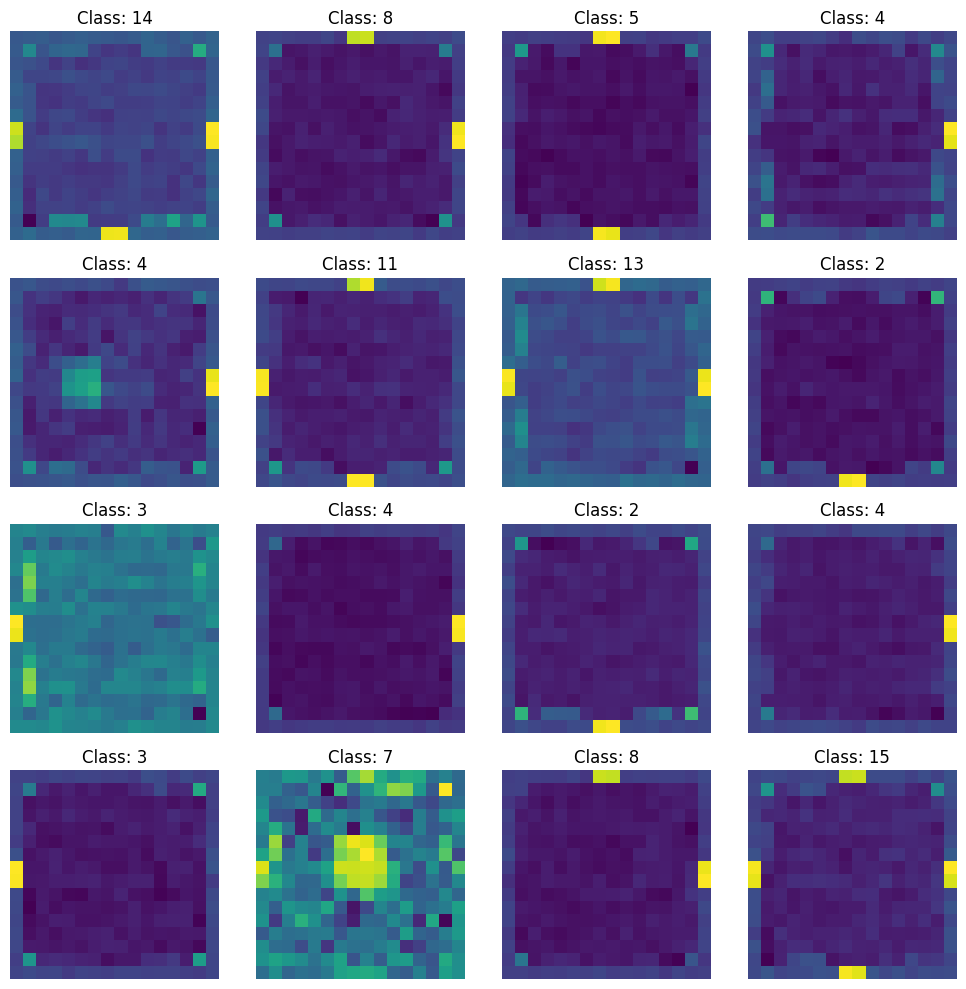

1/1 [==============================] - 0s 34ms/step
4700 [D loss: 0.03841833956539631 | D accuracy: 100.0] [G loss: 5.703982353210449]
1/1 [==============================] - 0s 42ms/step


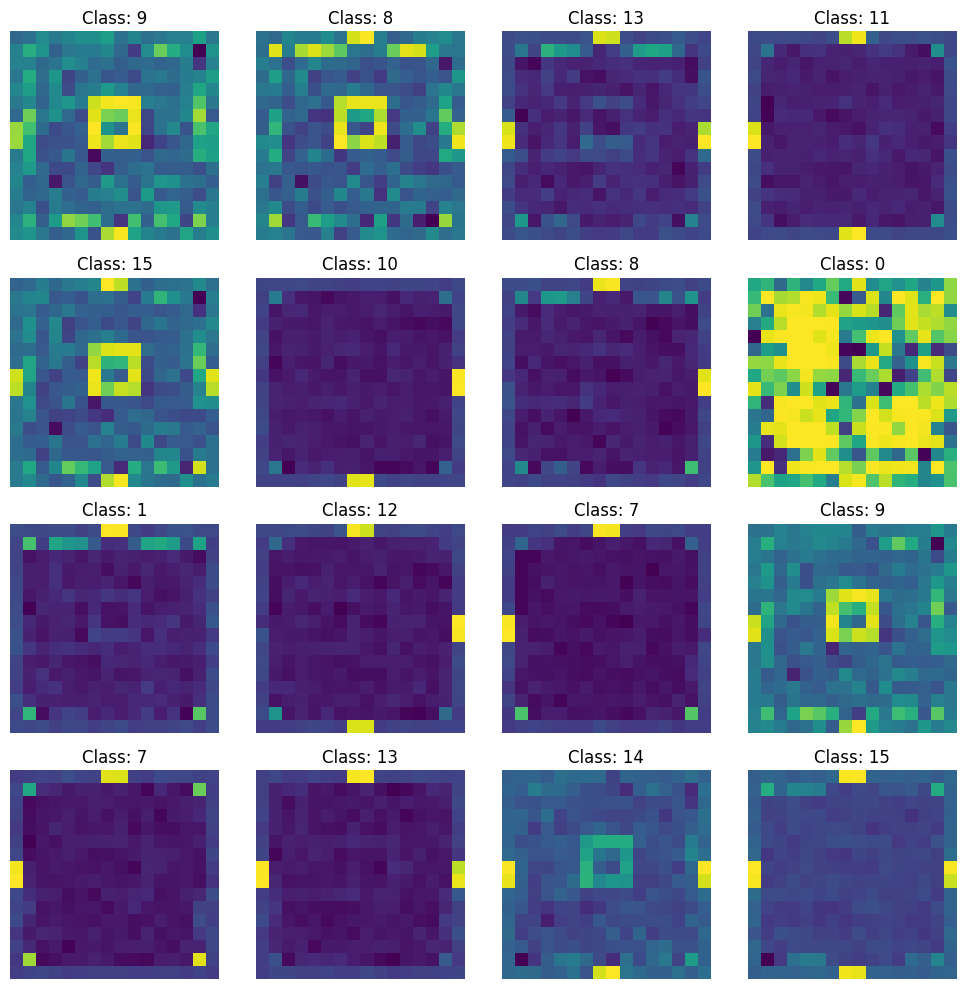

1/1 [==============================] - 0s 28ms/step
4800 [D loss: 0.08452312275767326 | D accuracy: 96.875] [G loss: 7.5768866539001465]
1/1 [==============================] - 0s 37ms/step


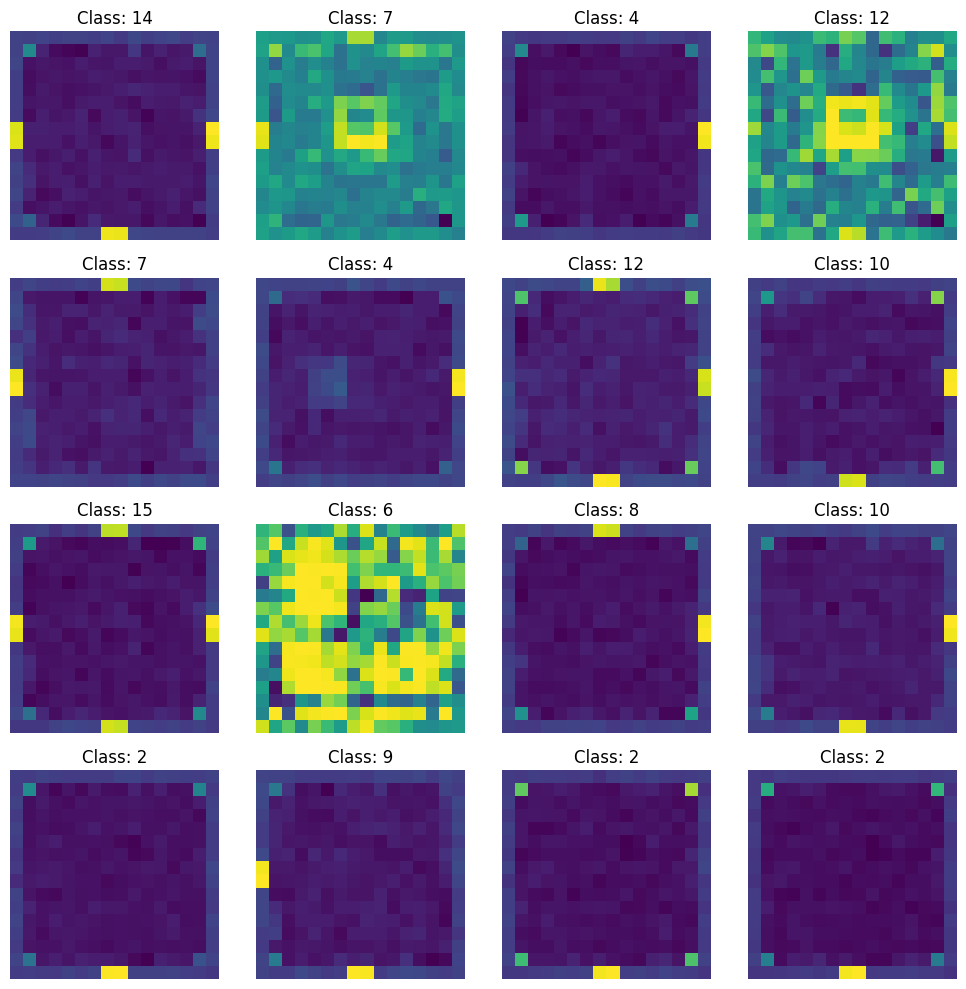

1/1 [==============================] - 0s 35ms/step
4900 [D loss: 0.16457679495215416 | D accuracy: 93.75] [G loss: 9.103290557861328]
1/1 [==============================] - 0s 65ms/step


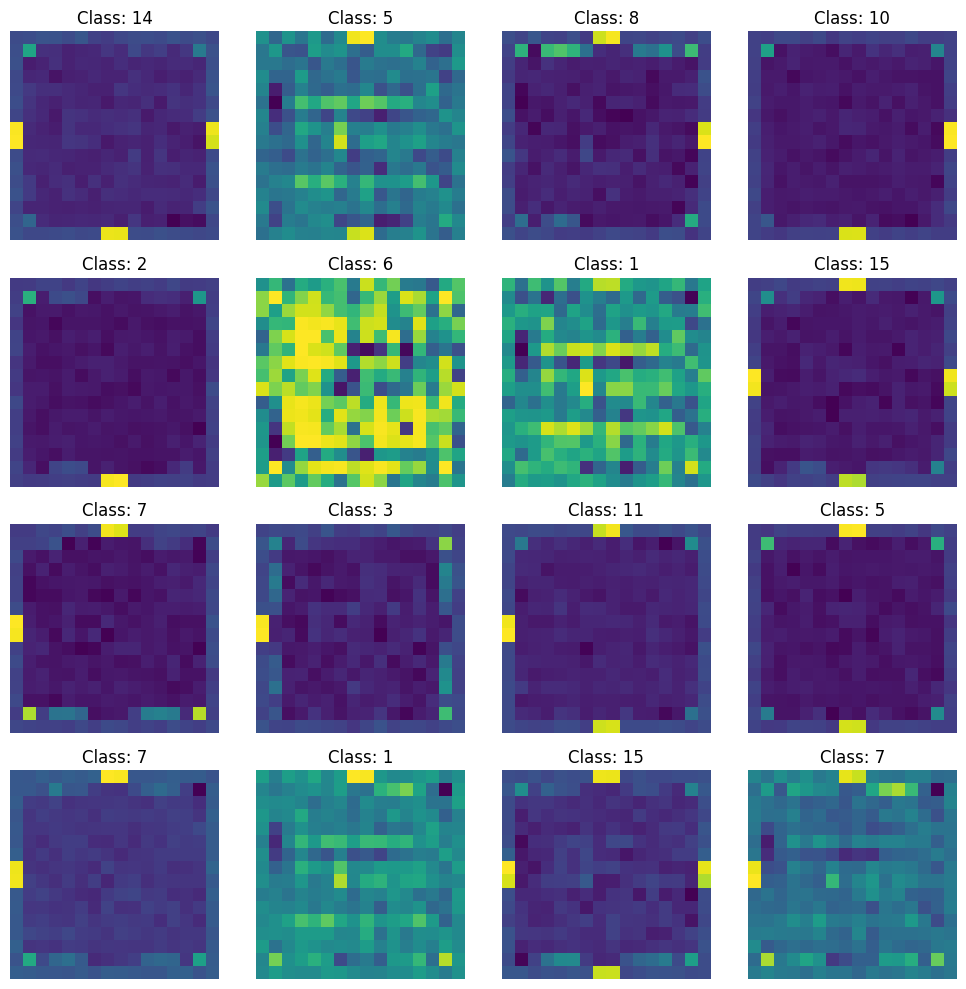

17/17 [==============================] - 0s 3ms/step
FID: 19.721269525060833
17/17 [==============================] - 0s 4ms/step
Precision: 0.9786780383795309
Recall: 0.884393063583815
Diversity Score: 0.2354213
Coverage Score: 2.335825733388499


In [164]:


# Function to plot generated rooms
def plot_generated_rooms(generator, noise_dim, num_classes, num_images=16):
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    gen_labels = np.random.randint(0, num_classes, num_images)
    gen_labels_one_hot = to_categorical(gen_labels, num_classes=num_classes)

    generated_rooms = generator.predict([noise, gen_labels_one_hot])
    generated_rooms = 0.5 * generated_rooms + 0.5  # Rescale images to 0 - 1

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_rooms[i, :, :, 0], cmap='viridis')  # Use 'viridis' colormap for color
        plt.title(f"Class: {gen_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Function to calculate FID
def calculate_fid(real_images, generated_images):
    mu1, sigma1 = np.mean(real_images, axis=0), np.cov(real_images, rowvar=False)
    mu2, sigma2 = np.mean(generated_images, axis=0), np.cov(generated_images, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Function to evaluate precision and recall
def evaluate_precision_recall(discriminator, X_test, y_test, generator, noise_dim, num_classes):
    real_rooms = X_test
    real_labels = y_test
    real = np.ones((real_rooms.shape[0], 1))
    noise = np.random.normal(0, 1, (real_rooms.shape[0], noise_dim))
    gen_labels = np.random.randint(0, num_classes, real_rooms.shape[0])
    gen_labels_one_hot = to_categorical(gen_labels, num_classes=num_classes)
    generated_rooms = generator.predict([noise, gen_labels_one_hot])
    fake = np.zeros((generated_rooms.shape[0], 1))
    y_true = np.concatenate((real, fake), axis=0)
    y_pred = np.concatenate((discriminator.predict([real_rooms, real_labels]), discriminator.predict([generated_rooms, gen_labels_one_hot])), axis=0)
    y_pred = (y_pred > 0.5).astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return precision, recall

# Function to assess diversity
def assess_diversity(generated_images):
    diversity_score = np.std(generated_images, axis=0).mean()
    return diversity_score

# Function to assess coverage
def assess_coverage(real_images, generated_images):
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(real_images)
    distances, _ = nbrs.kneighbors(generated_images)
    coverage_score = np.mean(distances)
    return coverage_score

# Function to train the model and generate the evaluation metrics
def train_and_evaluate(generator, discriminator, cgan, epochs, batch_size, X_train, y_train, X_test, y_test, noise_dim=100, num_classes=16):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_rooms = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_labels_one_hot = to_categorical(gen_labels, num_classes=num_classes)

        generated_rooms = generator.predict([noise, gen_labels_one_hot])

        d_loss_real = discriminator.train_on_batch([real_rooms, real_labels], real)
        d_loss_fake = discriminator.train_on_batch([generated_rooms, gen_labels_one_hot], fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_labels_one_hot = to_categorical(gen_labels, num_classes=num_classes)

        g_loss = cgan.train_on_batch([noise, gen_labels_one_hot], real)

        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")
            plot_generated_rooms(generator, noise_dim, num_classes)

    # Generate final batch of images for evaluation
    noise = np.random.normal(0, 1, (X_test.shape[0], noise_dim))
    gen_labels = np.random.randint(0, num_classes, X_test.shape[0])
    gen_labels_one_hot = to_categorical(gen_labels, num_classes=num_classes)
    generated_rooms = generator.predict([noise, gen_labels_one_hot])

    # Flatten the images for evaluation
    real_images = X_test.reshape((X_test.shape[0], -1))
    generated_images = generated_rooms.reshape((generated_rooms.shape[0], -1))

    # Calculate FID
    fid = calculate_fid(real_images, generated_images)
    print('FID:', fid)

    # Evaluate precision and recall
    precision, recall = evaluate_precision_recall(discriminator, X_test, y_test, generator, noise_dim, num_classes)
    print('Precision:', precision)
    print('Recall:', recall)

    # Assess diversity
    diversity_score = assess_diversity(generated_rooms)
    print('Diversity Score:', diversity_score)

    # Assess coverage
    coverage_score = assess_coverage(real_images, generated_images)
    print('Coverage Score:', coverage_score)

# Normalize the data
X_train = np.array(Updatedroomdecor)
X_train = X_train / 9.0  # Normalize the data
X_train = np.expand_dims(X_train, axis=-1)  # Expand dimensions to match the input shape for CNN
y_train = to_categorical(Room_Type, num_classes=16)  # One-hot encode the labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train the CGAN and evaluate
train_and_evaluate(generator, discriminator, cgan, epochs=5000, batch_size=16, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)


In [166]:
# Assuming the models have been trained
generator.save('/content/drive/MyDrive/generator_model.h5')
discriminator.save('/content/drive/MyDrive/discriminator_model.h5')
print("Models have been saved.")


Models have been saved.


###Correction Algorithm

1/1 [==============================] - 0s 170ms/step


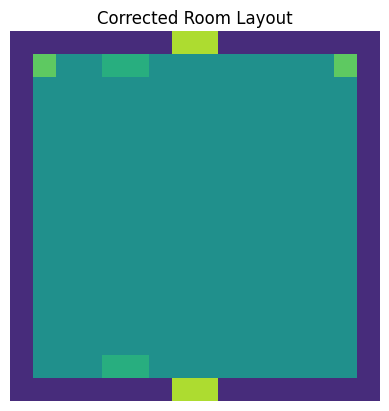

In [189]:

# Load the generator model
generator = load_model('/content/drive/MyDrive/generator_model.h5')

# Define the dimensions and number of classes
noise_dim = 100
num_classes = 16

# Generate a single image
noise = np.random.normal(0, 1, (1, noise_dim))
gen_label = np.random.randint(0, num_classes, 1)
gen_label_one_hot = to_categorical(gen_label, num_classes=num_classes)

# Generate the image
generated_image = generator.predict([noise, gen_label_one_hot])
generated_image = 0.5 * generated_image + 0.5  # Rescale image to 0 - 1



# Function to correct the room layout
def correct_room_layout(room):
    n = room.shape[0]

    # Create an empty corrected room layout
    corrected_room = np.zeros((n, n), dtype=int)

    # Ensure walls (1) are placed around the borders
    corrected_room[0, :] = 1
    corrected_room[:, 0] = 1
    corrected_room[n-1, :] = 1
    corrected_room[:, n-1] = 1

    # Place doors (7) in their original positions
    corrected_room[room == 7] = 7

    # Fill in the remaining cells with walls (1) or background (0)
    for i in range(1, n-1):
        for j in range(1, n-1):
            if room[i, j] == 7:
                corrected_room[i, j] = 7  # Ensure doors are not overwritten
            elif corrected_room[i, j] == 0:
                corrected_room[i, j] = room[i, j]  # Fill with original value if empty

    return corrected_room

corrected_image = correct_room_layout(converted_image)



# Visualize the corrected image
plt.imshow(corrected_image, cmap='viridis', vmin=0, vmax=8)
plt.title("Corrected Room Layout")
plt.axis('off')
plt.show()
